In [19]:
import os
from os.path import expanduser
home_dir = expanduser("~")
module_path = home_dir + '/code/modules/'
import sys
sys.path.append(module_path)
fig_dir = 'figures/'
import time
import importlib
import random
import tensorflow as tf
import pandas as pd
from keras import regularizers
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LeakyReLU, concatenate
from keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
#import model_management
from scipy.special import comb
import datetime
import codecs, json
from itertools import combinations
%load_ext autoreload
%autoreload 1
%aimport environmental_density
%aimport data_processing
%aimport plotting
from environmental_density import get_density_periodic
from data_processing import log_weighted_mse, normal_weighted_mse, stellar_mass_weighted_mse, \
                            halo_mass_weighted_loss_wrapper, load_galfile, divide_train_data, \
                            normalise_data, get_test_score, predict_points
from plotting import *

np.random.seed(999)
random.seed(999)

#loss_func_dict = {
#    'mse': 'mse',
#    'mae': 'mae',
#    'weighted_mse_1': weighted_mse_1,
#    'stellar_mass_weighted_mse': stellar_mass_weighted_mse
#}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
if run_on_cpu:
    os.environ["CUDA_VISIBLE_DEVICES"] = ""

## Set parameter string

In [ ]:
### Set name ending with parameters for figures to be saved
param_string = 'nLayers_%d_nNeurons_%d_actFun_%s_lossFunc_%s_nTrainSamples_%d_nEpochs_%d_batchSize_%d' % (
    nLayers, neuronsPerLayer, activationFunction, loss_function, train_size, nEpochs, batchSize)
print(param_string)

In [ ]:
print(np.mean(y_test_norm, 0))
print(np.std(y_test_norm, 0))
print(np.min(x_test_norm, 0))
print(np.max(x_test_norm, 0))

In [ ]:
### Get a feel for the data
for i in range(len(input_features)):
    print(input_features[i],': min: %.2e, max: %.2e.' % (np.min(x_train[:,i]), np.max(x_train[:,i])))
for i in range(len(output_features)):
    print(output_features[i],': min: %.2e, max: %.2e.' % (np.min(y_train[:,i]), np.max(y_train[:,i])))

In [ ]:
### Visualisation for when we have 2 input features
%matplotlib notebook
input_feat_1 = 0
input_feat_2 = 1
output_feat = 1

fig = plt.figure(1, figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_train_norm[:500,input_feat_1], x_train_norm[:500,input_feat_2], 
           y_train_norm[:500,output_feat])
ax.set_xlabel('%s log($M_{H}/M_{S}$)' % (input_features[input_feat_1]))
ax.set_ylabel('%s log($M_{H}/M_{S}$)' % (input_features[input_feat_2]))
ax.set_zlabel('%s log($M_{G}/M_{S}$)' % (output_features[output_feat]))
plt.show()

## Load an existing model

In [ ]:
### Search for the model that you want
importlib.reload(model_management)
search_dict = {
    'training_method': 'backprop'
}
[model_dicts, description_dicts] = model_management.SearchModel(search_dict, get_hits=True)
print(description_dicts)
print('\n')
for key in model_dicts:
    print(key)
    print(model_dicts[key])
    print('\n')


In [ ]:
importlib.reload(model_management)
model, model_dict, description = model_management.LoadModel(search_dict, 1)

## Get the standard pictures

In [70]:
mode = 'test' # 'train', 'val, 'test'

10000/10000 [==============================] - 1s 134us/step


<function matplotlib.pyplot.show>

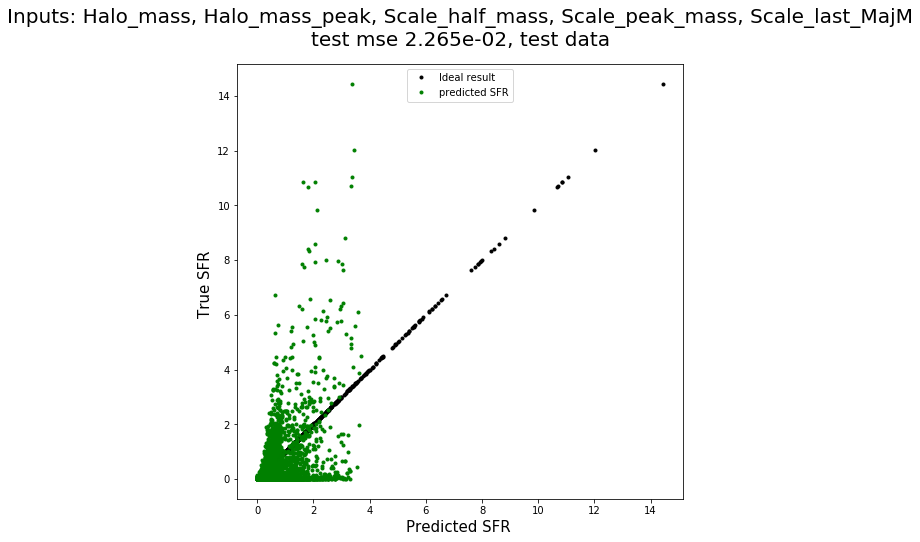

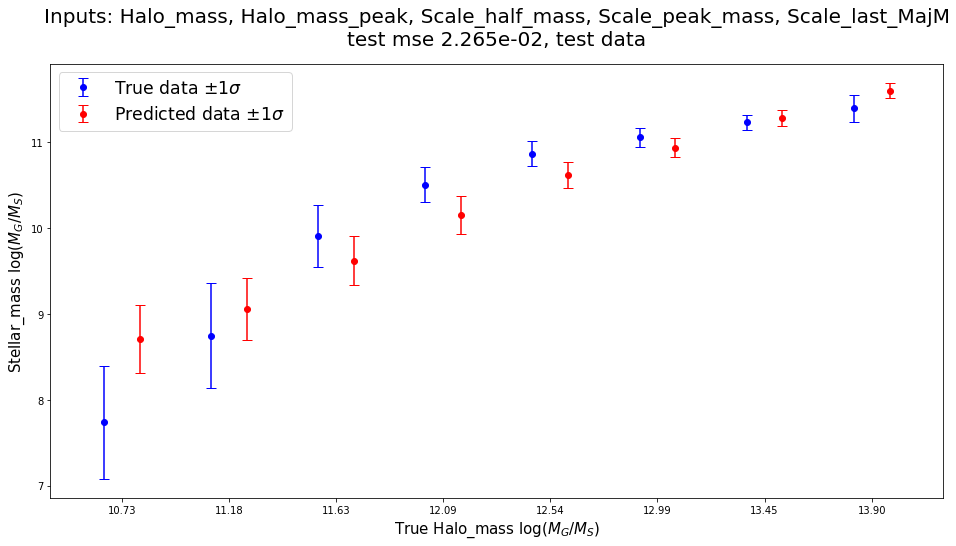

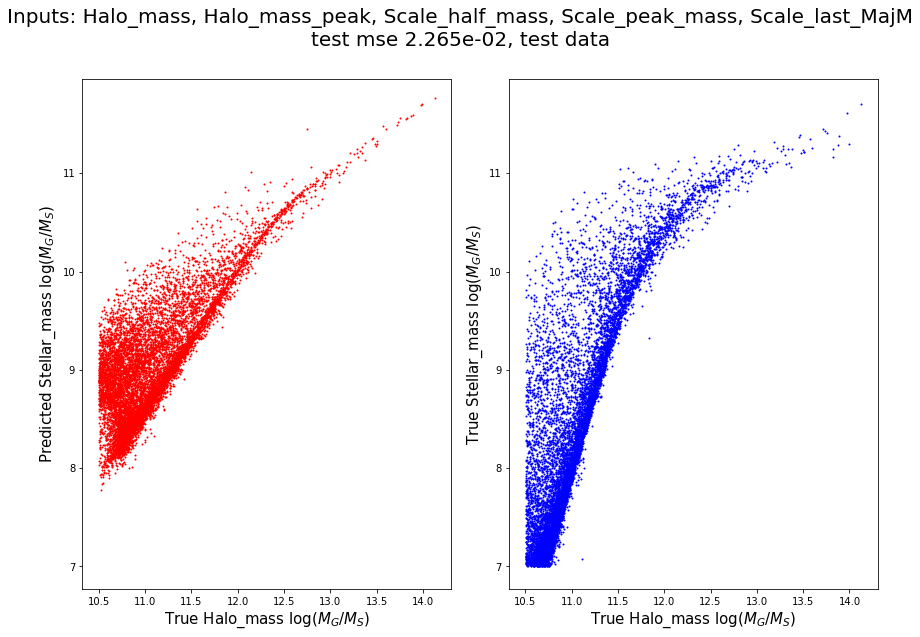

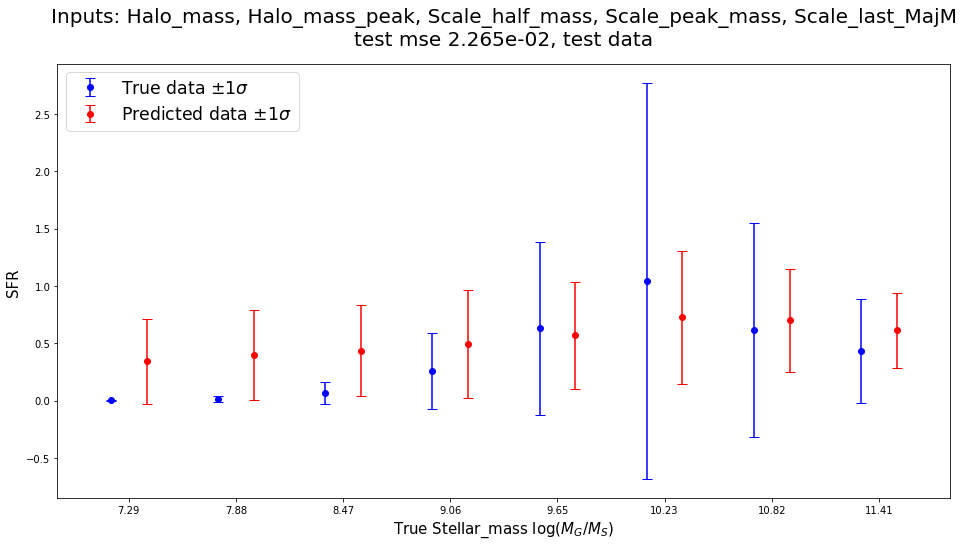

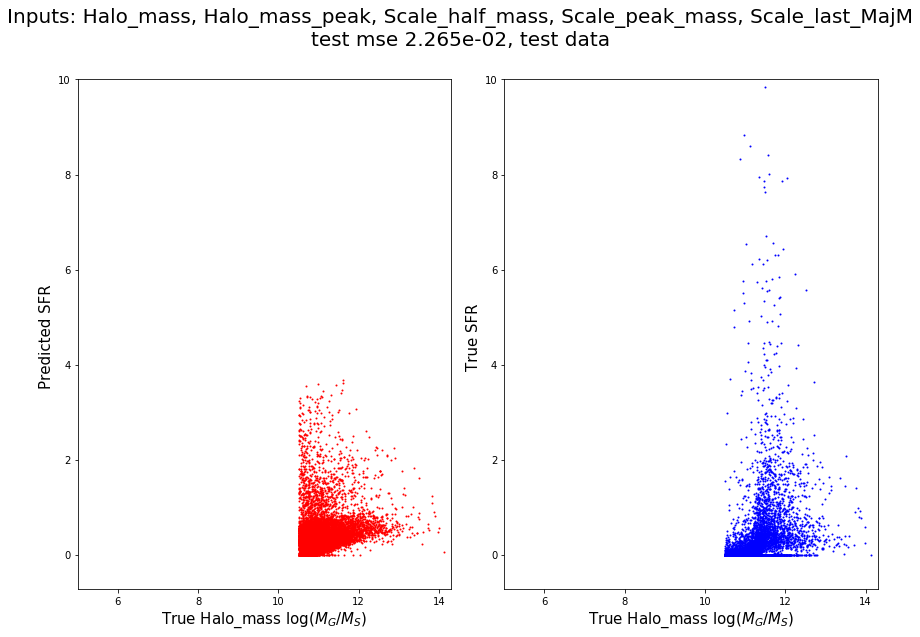

In [114]:
norm_scores = model.evaluate(x=training_data_dict['input_test_dict'], y=training_data_dict['output_test_dict'],
                                               verbose=1)
tot_score = norm_scores[0]
title = 'Inputs: %s\ntest mse %.3e, %s data' % (', '.join(input_features), tot_score, mode)
fig1 = get_pred_vs_real_scatterplot(model, training_data_dict, unit_dict, data_keys, 'SFR', title=title, data_type=mode)
fig2 = get_real_vs_pred_boxplot(model, training_data_dict, unit_dict, data_keys, predicted_feat = 'Stellar_mass', 
                                binning_feat = 'Halo_mass', title=title, data_type=mode)
fig3 = get_scatter_comparison_plots(model, training_data_dict, unit_dict, x_axis_feature = 'Halo_mass', 
                                    y_axis_feature = 'Stellar_mass', title=title, y_max = None, y_min = None,
                                    x_min = None, x_max = None, data_type=mode)
fig4 = get_real_vs_pred_boxplot(model, training_data_dict, unit_dict, data_keys, 'SFR', 
                                binning_feat = 'Stellar_mass', title=title, data_type=mode)
fig5 = get_scatter_comparison_plots(model, training_data_dict, unit_dict, x_axis_feature = 'Halo_mass', 
                                    y_axis_feature = 'SFR', title=title, y_max = 10, y_min = None,
                                    x_min = 5, x_max = None, data_type=mode)

plt.show

<function matplotlib.pyplot.show>

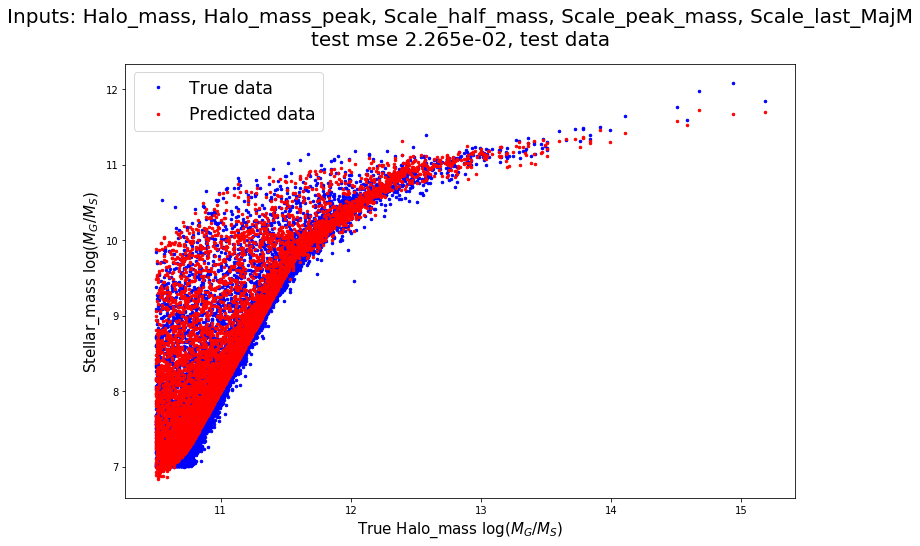

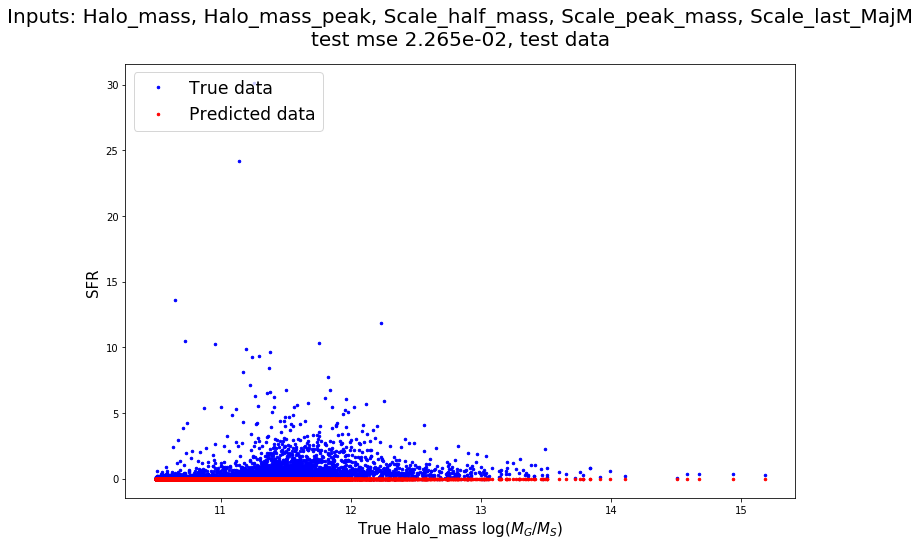

In [124]:
fig6 = get_real_vs_pred_same_fig(model, training_data_dict, unit_dict, x_axis_feature='Halo_mass', 
                                 y_axis_feature = 'Stellar_mass', title=title, data_type=mode, marker_size=5)
fig7 = get_real_vs_pred_same_fig(model, training_data_dict, unit_dict, x_axis_feature='Halo_mass', 
                                 y_axis_feature = 'SFR', title=title, data_type=mode, marker_size=5)
plt.show

In [ ]:
### Save the figures
fig1.savefig(fig_dir + '_'.join(input_features) + '_true_pred_sfr_scatter.png', bbox_inches = 'tight')
fig2.savefig(fig_dir + '_'.join(input_features) + '_boxplot_stellar_mass.png', bbox_inches = 'tight')
fig3.savefig(fig_dir + '_'.join(input_features) + '_scatter_comp_halo_vs_stellar_mass.png', bbox_inches = 'tight')
fig4.savefig(fig_dir + '_'.join(input_features) + '_boxplot_sfr.png', bbox_inches = 'tight')
fig5.savefig(fig_dir + '_'.join(input_features) + '_scatter_comp_stellar_mass_vs_sfr.png', bbox_inches = 'tight')

## Create a new model

In [121]:
### General parameters
nr_steps = 1e5
batch_size = 1e4
total_set_size = 3e4 # how many examples will be used for training+validation+testing
train_size = 1e4
val_size = 1e4
test_size = 1e4
norm = 'none' # 'none',   'zero_mean_unit_std',   'zero_to_one'
input_features = ['Halo_mass', 'Halo_mass_peak', 'Scale_half_mass', 'Scale_peak_mass', 'Scale_last_MajM']
output_features = ['Stellar_mass', 'SFR']
#loss_func = halo_mass_weighted_loss
#loss_func_dict = {   # 'mse', weighted_mse_1, 'mae', stellar_mass_weighted_mse
#    'Stellar_mass': stellar_mass_weighted_mse,
#    'SFR': normal_weighted_mse
#} 
early_stop_patience = 2000
early_stop_monitor = 'val_loss'
early_stop_min_delta = 1e-16

nr_epochs = nr_steps * batch_size / train_size

validation_data = 'val' #'val' is normally used, use 'train' to check overfitting potential

### Network parameters
nLayers = 8
activationFunction = 'tanh'
neuronsPerLayer = 10
reg_strength = 0#1e-5


In [122]:
# load the selected galaxyfile
galaxies, data_keys, unit_dict = load_galfile()
    
# prepare the training data
training_data_dict = divide_train_data(galaxies, data_keys, input_features, output_features, 
                                       int(total_set_size), int(train_size), int(val_size), int(test_size))
#galaxies = None
training_data_dict = normalise_data(training_data_dict, norm)

In [125]:
# Create model
halo_mass_input = Input(shape=(1,), name = 'halo_mass_input')
others_input = Input(shape=(len(input_features)-1,), name = 'others_input')

for i in range(0, nLayers-1): # -1 because one layer is added automatically with the input layer
    if i == 0:
        x = concatenate([halo_mass_input, others_input])
        #x = Dense(neuronsPerLayer, activation = activationFunction)(x)
        x = Dense(neuronsPerLayer, kernel_regularizer=regularizers.l2(reg_strength))(x)
        x = LeakyReLU(alpha = 0.1)(x)
    else:
        #x = Dense(neuronsPerLayer, activation = activationFunction)(x)
        x = Dense(neuronsPerLayer, kernel_regularizer=regularizers.l2(reg_strength))(x)
        x = LeakyReLU(alpha = 0.1)(x)
        
output_layers = []
for feat in output_features:
#    out_pre_act = Dense(1)(x)
#    output_layers.append(LeakyReLU(alpha = 0, name = feat)(out_pre_act))
    output_layers.append(Dense(1, kernel_regularizer=regularizers.l2(reg_strength), name = feat)(x))

model = Model([halo_mass_input, others_input], output_layers)
model.compile(optimizer = 'adam', loss = halo_mass_weighted_loss_wrapper(halo_mass_input))

earlystop = EarlyStopping(monitor=early_stop_monitor, min_delta=early_stop_min_delta, patience=early_stop_patience, \
                          verbose=1, mode='auto')
callbacks_list = [earlystop]

history = model.fit(x = training_data_dict['input_train_dict'], y = training_data_dict['output_train_dict'], 
                    validation_data = (training_data_dict['input_'+validation_data+'_dict'], 
                    training_data_dict['output_'+validation_data+'_dict']), 
                    epochs=int(nr_epochs), batch_size=int(batch_size), callbacks=callbacks_list)

Train on 10000 samples, validate on 10000 samples
Epoch 1/100000
10000/10000 [==============================] - 3s 325us/step - loss: 0.0114 - Stellar_mass_loss: 0.0113 - SFR_loss: 7.2826e-05 - val_loss: 0.0113 - val_Stellar_mass_loss: 0.0113 - val_SFR_loss: 8.0456e-05
Epoch 2/100000
10000/10000 [==============================] - 0s 4us/step - loss: 0.0113 - Stellar_mass_loss: 0.0113 - SFR_loss: 7.2165e-05 - val_loss: 0.0113 - val_Stellar_mass_loss: 0.0112 - val_SFR_loss: 7.9622e-05
Epoch 3/100000
10000/10000 [==============================] - 0s 3us/step - loss: 0.0113 - Stellar_mass_loss: 0.0112 - SFR_loss: 7.1464e-05 - val_loss: 0.0113 - val_Stellar_mass_loss: 0.0112 - val_SFR_loss: 7.8765e-05
Epoch 4/100000
10000/10000 [==============================] - 0s 4us/step - loss: 0.0113 - Stellar_mass_loss: 0.0112 - SFR_loss: 7.0752e-05 - val_loss: 0.0113 - val_Stellar_mass_loss: 0.0112 - val_SFR_loss: 7.7839e-05
Epoch 5/100000
10000/10000 [==============================] - 0s 4us/step - 

Epoch 39/100000
10000/10000 [==============================] - 0s 3us/step - loss: 0.0090 - Stellar_mass_loss: 0.0090 - SFR_loss: 6.4952e-05 - val_loss: 0.0089 - val_Stellar_mass_loss: 0.0088 - val_SFR_loss: 6.2472e-05
Epoch 40/100000
10000/10000 [==============================] - 0s 3us/step - loss: 0.0089 - Stellar_mass_loss: 0.0088 - SFR_loss: 6.7784e-05 - val_loss: 0.0088 - val_Stellar_mass_loss: 0.0087 - val_SFR_loss: 6.5016e-05
Epoch 41/100000
10000/10000 [==============================] - 0s 3us/step - loss: 0.0088 - Stellar_mass_loss: 0.0087 - SFR_loss: 7.0961e-05 - val_loss: 0.0086 - val_Stellar_mass_loss: 0.0085 - val_SFR_loss: 6.7897e-05
Epoch 42/100000
10000/10000 [==============================] - 0s 3us/step - loss: 0.0086 - Stellar_mass_loss: 0.0085 - SFR_loss: 7.4484e-05 - val_loss: 0.0085 - val_Stellar_mass_loss: 0.0084 - val_SFR_loss: 7.1119e-05
Epoch 43/100000
10000/10000 [==============================] - 0s 3us/step - loss: 0.0085 - Stellar_mass_loss: 0.0084 - SFR_

Epoch 77/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.5258e-04 - Stellar_mass_loss: 3.1674e-04 - SFR_loss: 3.3584e-04 - val_loss: 5.1111e-04 - val_Stellar_mass_loss: 2.0669e-04 - val_SFR_loss: 3.0442e-04
Epoch 78/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.3603e-04 - Stellar_mass_loss: 2.0469e-04 - SFR_loss: 3.3134e-04 - val_loss: 4.2095e-04 - val_Stellar_mass_loss: 1.2415e-04 - val_SFR_loss: 2.9679e-04
Epoch 79/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.4556e-04 - Stellar_mass_loss: 1.2222e-04 - SFR_loss: 3.2334e-04 - val_loss: 3.5605e-04 - val_Stellar_mass_loss: 7.0154e-05 - val_SFR_loss: 2.8589e-04
Epoch 80/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8019e-04 - Stellar_mass_loss: 6.8381e-05 - SFR_loss: 3.1181e-04 - val_loss: 3.1422e-04 - val_Stellar_mass_loss: 4.2527e-05 - val_SFR_loss: 2.7169e-04
Epoch 81/100000
10000/10000 [==============================]

Epoch 112/100000
10000/10000 [==============================] - 0s 3us/step - loss: 1.1310e-04 - Stellar_mass_loss: 4.5966e-05 - SFR_loss: 6.7138e-05 - val_loss: 1.1844e-04 - val_Stellar_mass_loss: 4.5819e-05 - val_SFR_loss: 7.2624e-05
Epoch 113/100000
10000/10000 [==============================] - 0s 4us/step - loss: 1.0996e-04 - Stellar_mass_loss: 4.4160e-05 - SFR_loss: 6.5800e-05 - val_loss: 1.1475e-04 - val_Stellar_mass_loss: 4.3888e-05 - val_SFR_loss: 7.0862e-05
Epoch 114/100000
10000/10000 [==============================] - 0s 4us/step - loss: 1.0661e-04 - Stellar_mass_loss: 4.2242e-05 - SFR_loss: 6.4371e-05 - val_loss: 1.1103e-04 - val_Stellar_mass_loss: 4.1999e-05 - val_SFR_loss: 6.9029e-05
Epoch 115/100000
10000/10000 [==============================] - 0s 4us/step - loss: 1.0327e-04 - Stellar_mass_loss: 4.0367e-05 - SFR_loss: 6.2902e-05 - val_loss: 1.0746e-04 - val_Stellar_mass_loss: 4.0281e-05 - val_SFR_loss: 6.7180e-05
Epoch 116/100000
10000/10000 [==========================

Epoch 147/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.7961e-05 - Stellar_mass_loss: 3.5191e-05 - SFR_loss: 5.2770e-05 - val_loss: 8.9533e-05 - val_Stellar_mass_loss: 3.6759e-05 - val_SFR_loss: 5.2774e-05
Epoch 148/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.7941e-05 - Stellar_mass_loss: 3.5203e-05 - SFR_loss: 5.2738e-05 - val_loss: 8.9549e-05 - val_Stellar_mass_loss: 3.6750e-05 - val_SFR_loss: 5.2799e-05
Epoch 149/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.7901e-05 - Stellar_mass_loss: 3.5194e-05 - SFR_loss: 5.2708e-05 - val_loss: 8.9550e-05 - val_Stellar_mass_loss: 3.6722e-05 - val_SFR_loss: 5.2828e-05
Epoch 150/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.7846e-05 - Stellar_mass_loss: 3.5167e-05 - SFR_loss: 5.2679e-05 - val_loss: 8.9538e-05 - val_Stellar_mass_loss: 3.6680e-05 - val_SFR_loss: 5.2859e-05
Epoch 151/100000
10000/10000 [==========================

Epoch 182/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.7321e-05 - Stellar_mass_loss: 3.4789e-05 - SFR_loss: 5.2531e-05 - val_loss: 8.9791e-05 - val_Stellar_mass_loss: 3.6315e-05 - val_SFR_loss: 5.3476e-05
Epoch 183/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.7319e-05 - Stellar_mass_loss: 3.4789e-05 - SFR_loss: 5.2530e-05 - val_loss: 8.9776e-05 - val_Stellar_mass_loss: 3.6314e-05 - val_SFR_loss: 5.3462e-05
Epoch 184/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.7317e-05 - Stellar_mass_loss: 3.4788e-05 - SFR_loss: 5.2529e-05 - val_loss: 8.9759e-05 - val_Stellar_mass_loss: 3.6312e-05 - val_SFR_loss: 5.3447e-05
Epoch 185/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.7314e-05 - Stellar_mass_loss: 3.4787e-05 - SFR_loss: 5.2528e-05 - val_loss: 8.9742e-05 - val_Stellar_mass_loss: 3.6310e-05 - val_SFR_loss: 5.3431e-05
Epoch 186/100000
10000/10000 [==========================

Epoch 217/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.7252e-05 - Stellar_mass_loss: 3.4727e-05 - SFR_loss: 5.2524e-05 - val_loss: 8.9564e-05 - val_Stellar_mass_loss: 3.6241e-05 - val_SFR_loss: 5.3323e-05
Epoch 218/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.7250e-05 - Stellar_mass_loss: 3.4726e-05 - SFR_loss: 5.2524e-05 - val_loss: 8.9564e-05 - val_Stellar_mass_loss: 3.6239e-05 - val_SFR_loss: 5.3326e-05
Epoch 219/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.7248e-05 - Stellar_mass_loss: 3.4724e-05 - SFR_loss: 5.2524e-05 - val_loss: 8.9565e-05 - val_Stellar_mass_loss: 3.6237e-05 - val_SFR_loss: 5.3328e-05
Epoch 220/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.7247e-05 - Stellar_mass_loss: 3.4722e-05 - SFR_loss: 5.2524e-05 - val_loss: 8.9565e-05 - val_Stellar_mass_loss: 3.6235e-05 - val_SFR_loss: 5.3331e-05
Epoch 221/100000
10000/10000 [==========================

Epoch 252/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.7190e-05 - Stellar_mass_loss: 3.4664e-05 - SFR_loss: 5.2526e-05 - val_loss: 8.9497e-05 - val_Stellar_mass_loss: 3.6167e-05 - val_SFR_loss: 5.3330e-05
Epoch 253/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.7188e-05 - Stellar_mass_loss: 3.4662e-05 - SFR_loss: 5.2526e-05 - val_loss: 8.9494e-05 - val_Stellar_mass_loss: 3.6165e-05 - val_SFR_loss: 5.3329e-05
Epoch 254/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.7186e-05 - Stellar_mass_loss: 3.4660e-05 - SFR_loss: 5.2526e-05 - val_loss: 8.9492e-05 - val_Stellar_mass_loss: 3.6163e-05 - val_SFR_loss: 5.3329e-05
Epoch 255/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.7184e-05 - Stellar_mass_loss: 3.4658e-05 - SFR_loss: 5.2526e-05 - val_loss: 8.9489e-05 - val_Stellar_mass_loss: 3.6161e-05 - val_SFR_loss: 5.3329e-05
Epoch 256/100000
10000/10000 [==========================

Epoch 287/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.7124e-05 - Stellar_mass_loss: 3.4596e-05 - SFR_loss: 5.2528e-05 - val_loss: 8.9422e-05 - val_Stellar_mass_loss: 3.6089e-05 - val_SFR_loss: 5.3333e-05
Epoch 288/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.7122e-05 - Stellar_mass_loss: 3.4594e-05 - SFR_loss: 5.2528e-05 - val_loss: 8.9419e-05 - val_Stellar_mass_loss: 3.6087e-05 - val_SFR_loss: 5.3333e-05
Epoch 289/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.7120e-05 - Stellar_mass_loss: 3.4592e-05 - SFR_loss: 5.2528e-05 - val_loss: 8.9417e-05 - val_Stellar_mass_loss: 3.6085e-05 - val_SFR_loss: 5.3333e-05
Epoch 290/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.7118e-05 - Stellar_mass_loss: 3.4590e-05 - SFR_loss: 5.2528e-05 - val_loss: 8.9415e-05 - val_Stellar_mass_loss: 3.6082e-05 - val_SFR_loss: 5.3333e-05
Epoch 291/100000
10000/10000 [==========================

Epoch 322/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.7055e-05 - Stellar_mass_loss: 3.4525e-05 - SFR_loss: 5.2530e-05 - val_loss: 8.9340e-05 - val_Stellar_mass_loss: 3.6007e-05 - val_SFR_loss: 5.3333e-05
Epoch 323/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.7053e-05 - Stellar_mass_loss: 3.4523e-05 - SFR_loss: 5.2530e-05 - val_loss: 8.9338e-05 - val_Stellar_mass_loss: 3.6005e-05 - val_SFR_loss: 5.3333e-05
Epoch 324/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.7051e-05 - Stellar_mass_loss: 3.4521e-05 - SFR_loss: 5.2530e-05 - val_loss: 8.9336e-05 - val_Stellar_mass_loss: 3.6002e-05 - val_SFR_loss: 5.3333e-05
Epoch 325/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.7049e-05 - Stellar_mass_loss: 3.4519e-05 - SFR_loss: 5.2530e-05 - val_loss: 8.9333e-05 - val_Stellar_mass_loss: 3.6000e-05 - val_SFR_loss: 5.3333e-05
Epoch 326/100000
10000/10000 [==========================

Epoch 357/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.6982e-05 - Stellar_mass_loss: 3.4450e-05 - SFR_loss: 5.2532e-05 - val_loss: 8.9256e-05 - val_Stellar_mass_loss: 3.5921e-05 - val_SFR_loss: 5.3335e-05
Epoch 358/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.6980e-05 - Stellar_mass_loss: 3.4448e-05 - SFR_loss: 5.2532e-05 - val_loss: 8.9253e-05 - val_Stellar_mass_loss: 3.5919e-05 - val_SFR_loss: 5.3335e-05
Epoch 359/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.6978e-05 - Stellar_mass_loss: 3.4446e-05 - SFR_loss: 5.2532e-05 - val_loss: 8.9251e-05 - val_Stellar_mass_loss: 3.5916e-05 - val_SFR_loss: 5.3335e-05
Epoch 360/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.6976e-05 - Stellar_mass_loss: 3.4444e-05 - SFR_loss: 5.2532e-05 - val_loss: 8.9248e-05 - val_Stellar_mass_loss: 3.5914e-05 - val_SFR_loss: 5.3335e-05
Epoch 361/100000
10000/10000 [==========================

Epoch 392/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.6906e-05 - Stellar_mass_loss: 3.4373e-05 - SFR_loss: 5.2534e-05 - val_loss: 8.9168e-05 - val_Stellar_mass_loss: 3.5832e-05 - val_SFR_loss: 5.3336e-05
Epoch 393/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.6904e-05 - Stellar_mass_loss: 3.4370e-05 - SFR_loss: 5.2534e-05 - val_loss: 8.9165e-05 - val_Stellar_mass_loss: 3.5829e-05 - val_SFR_loss: 5.3336e-05
Epoch 394/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.6902e-05 - Stellar_mass_loss: 3.4368e-05 - SFR_loss: 5.2534e-05 - val_loss: 8.9163e-05 - val_Stellar_mass_loss: 3.5826e-05 - val_SFR_loss: 5.3336e-05
Epoch 395/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.6900e-05 - Stellar_mass_loss: 3.4366e-05 - SFR_loss: 5.2534e-05 - val_loss: 8.9160e-05 - val_Stellar_mass_loss: 3.5824e-05 - val_SFR_loss: 5.3336e-05
Epoch 396/100000
10000/10000 [==========================

Epoch 427/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.6828e-05 - Stellar_mass_loss: 3.4292e-05 - SFR_loss: 5.2536e-05 - val_loss: 8.9077e-05 - val_Stellar_mass_loss: 3.5739e-05 - val_SFR_loss: 5.3338e-05
Epoch 428/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.6826e-05 - Stellar_mass_loss: 3.4290e-05 - SFR_loss: 5.2536e-05 - val_loss: 8.9074e-05 - val_Stellar_mass_loss: 3.5736e-05 - val_SFR_loss: 5.3338e-05
Epoch 429/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.6823e-05 - Stellar_mass_loss: 3.4287e-05 - SFR_loss: 5.2536e-05 - val_loss: 8.9071e-05 - val_Stellar_mass_loss: 3.5733e-05 - val_SFR_loss: 5.3338e-05
Epoch 430/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.6821e-05 - Stellar_mass_loss: 3.4285e-05 - SFR_loss: 5.2536e-05 - val_loss: 8.9069e-05 - val_Stellar_mass_loss: 3.5731e-05 - val_SFR_loss: 5.3338e-05
Epoch 431/100000
10000/10000 [==========================

Epoch 462/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.6747e-05 - Stellar_mass_loss: 3.4209e-05 - SFR_loss: 5.2538e-05 - val_loss: 8.8982e-05 - val_Stellar_mass_loss: 3.5643e-05 - val_SFR_loss: 5.3339e-05
Epoch 463/100000
10000/10000 [==============================] - 0s 5us/step - loss: 8.6745e-05 - Stellar_mass_loss: 3.4206e-05 - SFR_loss: 5.2538e-05 - val_loss: 8.8980e-05 - val_Stellar_mass_loss: 3.5640e-05 - val_SFR_loss: 5.3339e-05
Epoch 464/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.6742e-05 - Stellar_mass_loss: 3.4204e-05 - SFR_loss: 5.2538e-05 - val_loss: 8.8977e-05 - val_Stellar_mass_loss: 3.5637e-05 - val_SFR_loss: 5.3339e-05
Epoch 465/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.6740e-05 - Stellar_mass_loss: 3.4201e-05 - SFR_loss: 5.2538e-05 - val_loss: 8.8974e-05 - val_Stellar_mass_loss: 3.5635e-05 - val_SFR_loss: 5.3340e-05
Epoch 466/100000
10000/10000 [==========================

Epoch 497/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.6664e-05 - Stellar_mass_loss: 3.4123e-05 - SFR_loss: 5.2541e-05 - val_loss: 8.8886e-05 - val_Stellar_mass_loss: 3.5545e-05 - val_SFR_loss: 5.3341e-05
Epoch 498/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.6661e-05 - Stellar_mass_loss: 3.4120e-05 - SFR_loss: 5.2541e-05 - val_loss: 8.8883e-05 - val_Stellar_mass_loss: 3.5542e-05 - val_SFR_loss: 5.3341e-05
Epoch 499/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.6659e-05 - Stellar_mass_loss: 3.4118e-05 - SFR_loss: 5.2541e-05 - val_loss: 8.8880e-05 - val_Stellar_mass_loss: 3.5539e-05 - val_SFR_loss: 5.3341e-05
Epoch 500/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.6656e-05 - Stellar_mass_loss: 3.4115e-05 - SFR_loss: 5.2541e-05 - val_loss: 8.8877e-05 - val_Stellar_mass_loss: 3.5536e-05 - val_SFR_loss: 5.3341e-05
Epoch 501/100000
10000/10000 [==========================

Epoch 532/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.6578e-05 - Stellar_mass_loss: 3.4035e-05 - SFR_loss: 5.2543e-05 - val_loss: 8.8786e-05 - val_Stellar_mass_loss: 3.5444e-05 - val_SFR_loss: 5.3343e-05
Epoch 533/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.6576e-05 - Stellar_mass_loss: 3.4033e-05 - SFR_loss: 5.2543e-05 - val_loss: 8.8783e-05 - val_Stellar_mass_loss: 3.5441e-05 - val_SFR_loss: 5.3343e-05
Epoch 534/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.6573e-05 - Stellar_mass_loss: 3.4030e-05 - SFR_loss: 5.2543e-05 - val_loss: 8.8781e-05 - val_Stellar_mass_loss: 3.5438e-05 - val_SFR_loss: 5.3343e-05
Epoch 535/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.6571e-05 - Stellar_mass_loss: 3.4028e-05 - SFR_loss: 5.2543e-05 - val_loss: 8.8778e-05 - val_Stellar_mass_loss: 3.5435e-05 - val_SFR_loss: 5.3343e-05
Epoch 536/100000
10000/10000 [==========================

Epoch 567/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.6491e-05 - Stellar_mass_loss: 3.3945e-05 - SFR_loss: 5.2545e-05 - val_loss: 8.8685e-05 - val_Stellar_mass_loss: 3.5340e-05 - val_SFR_loss: 5.3344e-05
Epoch 568/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.6488e-05 - Stellar_mass_loss: 3.3943e-05 - SFR_loss: 5.2546e-05 - val_loss: 8.8682e-05 - val_Stellar_mass_loss: 3.5337e-05 - val_SFR_loss: 5.3344e-05
Epoch 569/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.6486e-05 - Stellar_mass_loss: 3.3940e-05 - SFR_loss: 5.2546e-05 - val_loss: 8.8679e-05 - val_Stellar_mass_loss: 3.5334e-05 - val_SFR_loss: 5.3344e-05
Epoch 570/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.6483e-05 - Stellar_mass_loss: 3.3938e-05 - SFR_loss: 5.2546e-05 - val_loss: 8.8676e-05 - val_Stellar_mass_loss: 3.5331e-05 - val_SFR_loss: 5.3344e-05
Epoch 571/100000
10000/10000 [==========================

Epoch 602/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.6402e-05 - Stellar_mass_loss: 3.3854e-05 - SFR_loss: 5.2548e-05 - val_loss: 8.8581e-05 - val_Stellar_mass_loss: 3.5235e-05 - val_SFR_loss: 5.3346e-05
Epoch 603/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.6399e-05 - Stellar_mass_loss: 3.3851e-05 - SFR_loss: 5.2548e-05 - val_loss: 8.8578e-05 - val_Stellar_mass_loss: 3.5232e-05 - val_SFR_loss: 5.3346e-05
Epoch 604/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.6397e-05 - Stellar_mass_loss: 3.3848e-05 - SFR_loss: 5.2548e-05 - val_loss: 8.8575e-05 - val_Stellar_mass_loss: 3.5229e-05 - val_SFR_loss: 5.3346e-05
Epoch 605/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.6394e-05 - Stellar_mass_loss: 3.3846e-05 - SFR_loss: 5.2548e-05 - val_loss: 8.8572e-05 - val_Stellar_mass_loss: 3.5226e-05 - val_SFR_loss: 5.3346e-05
Epoch 606/100000
10000/10000 [==========================

Epoch 637/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.6311e-05 - Stellar_mass_loss: 3.3760e-05 - SFR_loss: 5.2551e-05 - val_loss: 8.8476e-05 - val_Stellar_mass_loss: 3.5128e-05 - val_SFR_loss: 5.3348e-05
Epoch 638/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.6308e-05 - Stellar_mass_loss: 3.3758e-05 - SFR_loss: 5.2551e-05 - val_loss: 8.8473e-05 - val_Stellar_mass_loss: 3.5125e-05 - val_SFR_loss: 5.3348e-05
Epoch 639/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.6306e-05 - Stellar_mass_loss: 3.3755e-05 - SFR_loss: 5.2551e-05 - val_loss: 8.8470e-05 - val_Stellar_mass_loss: 3.5122e-05 - val_SFR_loss: 5.3348e-05
Epoch 640/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.6303e-05 - Stellar_mass_loss: 3.3752e-05 - SFR_loss: 5.2551e-05 - val_loss: 8.8467e-05 - val_Stellar_mass_loss: 3.5119e-05 - val_SFR_loss: 5.3348e-05
Epoch 641/100000
10000/10000 [==========================

Epoch 672/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.6219e-05 - Stellar_mass_loss: 3.3666e-05 - SFR_loss: 5.2553e-05 - val_loss: 8.8369e-05 - val_Stellar_mass_loss: 3.5019e-05 - val_SFR_loss: 5.3350e-05
Epoch 673/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.6216e-05 - Stellar_mass_loss: 3.3663e-05 - SFR_loss: 5.2553e-05 - val_loss: 8.8366e-05 - val_Stellar_mass_loss: 3.5016e-05 - val_SFR_loss: 5.3350e-05
Epoch 674/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.6213e-05 - Stellar_mass_loss: 3.3660e-05 - SFR_loss: 5.2553e-05 - val_loss: 8.8362e-05 - val_Stellar_mass_loss: 3.5013e-05 - val_SFR_loss: 5.3350e-05
Epoch 675/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.6211e-05 - Stellar_mass_loss: 3.3657e-05 - SFR_loss: 5.2553e-05 - val_loss: 8.8359e-05 - val_Stellar_mass_loss: 3.5010e-05 - val_SFR_loss: 5.3350e-05
Epoch 676/100000
10000/10000 [==========================

Epoch 707/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.6125e-05 - Stellar_mass_loss: 3.3569e-05 - SFR_loss: 5.2556e-05 - val_loss: 8.8260e-05 - val_Stellar_mass_loss: 3.4909e-05 - val_SFR_loss: 5.3351e-05
Epoch 708/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.6123e-05 - Stellar_mass_loss: 3.3567e-05 - SFR_loss: 5.2556e-05 - val_loss: 8.8257e-05 - val_Stellar_mass_loss: 3.4905e-05 - val_SFR_loss: 5.3351e-05
Epoch 709/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.6120e-05 - Stellar_mass_loss: 3.3564e-05 - SFR_loss: 5.2556e-05 - val_loss: 8.8254e-05 - val_Stellar_mass_loss: 3.4902e-05 - val_SFR_loss: 5.3352e-05
Epoch 710/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.6117e-05 - Stellar_mass_loss: 3.3561e-05 - SFR_loss: 5.2556e-05 - val_loss: 8.8251e-05 - val_Stellar_mass_loss: 3.4899e-05 - val_SFR_loss: 5.3352e-05
Epoch 711/100000
10000/10000 [==========================

Epoch 742/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.6030e-05 - Stellar_mass_loss: 3.3472e-05 - SFR_loss: 5.2559e-05 - val_loss: 8.8150e-05 - val_Stellar_mass_loss: 3.4797e-05 - val_SFR_loss: 5.3353e-05
Epoch 743/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.6028e-05 - Stellar_mass_loss: 3.3469e-05 - SFR_loss: 5.2559e-05 - val_loss: 8.8147e-05 - val_Stellar_mass_loss: 3.4793e-05 - val_SFR_loss: 5.3353e-05
Epoch 744/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.6025e-05 - Stellar_mass_loss: 3.3466e-05 - SFR_loss: 5.2559e-05 - val_loss: 8.8143e-05 - val_Stellar_mass_loss: 3.4790e-05 - val_SFR_loss: 5.3353e-05
Epoch 745/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.6022e-05 - Stellar_mass_loss: 3.3464e-05 - SFR_loss: 5.2559e-05 - val_loss: 8.8140e-05 - val_Stellar_mass_loss: 3.4787e-05 - val_SFR_loss: 5.3353e-05
Epoch 746/100000
10000/10000 [==========================

Epoch 777/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.5935e-05 - Stellar_mass_loss: 3.3373e-05 - SFR_loss: 5.2561e-05 - val_loss: 8.8038e-05 - val_Stellar_mass_loss: 3.4683e-05 - val_SFR_loss: 5.3355e-05
Epoch 778/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.5932e-05 - Stellar_mass_loss: 3.3370e-05 - SFR_loss: 5.2561e-05 - val_loss: 8.8035e-05 - val_Stellar_mass_loss: 3.4680e-05 - val_SFR_loss: 5.3355e-05
Epoch 779/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.5929e-05 - Stellar_mass_loss: 3.3368e-05 - SFR_loss: 5.2561e-05 - val_loss: 8.8032e-05 - val_Stellar_mass_loss: 3.4677e-05 - val_SFR_loss: 5.3355e-05
Epoch 780/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.5926e-05 - Stellar_mass_loss: 3.3365e-05 - SFR_loss: 5.2562e-05 - val_loss: 8.8029e-05 - val_Stellar_mass_loss: 3.4674e-05 - val_SFR_loss: 5.3355e-05
Epoch 781/100000
10000/10000 [==========================

Epoch 812/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.5838e-05 - Stellar_mass_loss: 3.3274e-05 - SFR_loss: 5.2564e-05 - val_loss: 8.7926e-05 - val_Stellar_mass_loss: 3.4569e-05 - val_SFR_loss: 5.3357e-05
Epoch 813/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.5835e-05 - Stellar_mass_loss: 3.3271e-05 - SFR_loss: 5.2564e-05 - val_loss: 8.7922e-05 - val_Stellar_mass_loss: 3.4565e-05 - val_SFR_loss: 5.3357e-05
Epoch 814/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.5832e-05 - Stellar_mass_loss: 3.3268e-05 - SFR_loss: 5.2564e-05 - val_loss: 8.7919e-05 - val_Stellar_mass_loss: 3.4562e-05 - val_SFR_loss: 5.3357e-05
Epoch 815/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.5829e-05 - Stellar_mass_loss: 3.3265e-05 - SFR_loss: 5.2564e-05 - val_loss: 8.7916e-05 - val_Stellar_mass_loss: 3.4559e-05 - val_SFR_loss: 5.3357e-05
Epoch 816/100000
10000/10000 [==========================

Epoch 847/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.5740e-05 - Stellar_mass_loss: 3.3173e-05 - SFR_loss: 5.2567e-05 - val_loss: 8.7812e-05 - val_Stellar_mass_loss: 3.4453e-05 - val_SFR_loss: 5.3359e-05
Epoch 848/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.5737e-05 - Stellar_mass_loss: 3.3170e-05 - SFR_loss: 5.2567e-05 - val_loss: 8.7809e-05 - val_Stellar_mass_loss: 3.4450e-05 - val_SFR_loss: 5.3359e-05
Epoch 849/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.5734e-05 - Stellar_mass_loss: 3.3167e-05 - SFR_loss: 5.2567e-05 - val_loss: 8.7805e-05 - val_Stellar_mass_loss: 3.4447e-05 - val_SFR_loss: 5.3359e-05
Epoch 850/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.5731e-05 - Stellar_mass_loss: 3.3164e-05 - SFR_loss: 5.2567e-05 - val_loss: 8.7802e-05 - val_Stellar_mass_loss: 3.4443e-05 - val_SFR_loss: 5.3359e-05
Epoch 851/100000
10000/10000 [==========================

Epoch 882/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.5641e-05 - Stellar_mass_loss: 3.3071e-05 - SFR_loss: 5.2570e-05 - val_loss: 8.7697e-05 - val_Stellar_mass_loss: 3.4337e-05 - val_SFR_loss: 5.3361e-05
Epoch 883/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.5638e-05 - Stellar_mass_loss: 3.3068e-05 - SFR_loss: 5.2570e-05 - val_loss: 8.7694e-05 - val_Stellar_mass_loss: 3.4333e-05 - val_SFR_loss: 5.3361e-05
Epoch 884/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.5635e-05 - Stellar_mass_loss: 3.3065e-05 - SFR_loss: 5.2570e-05 - val_loss: 8.7691e-05 - val_Stellar_mass_loss: 3.4330e-05 - val_SFR_loss: 5.3361e-05
Epoch 885/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.5632e-05 - Stellar_mass_loss: 3.3063e-05 - SFR_loss: 5.2570e-05 - val_loss: 8.7687e-05 - val_Stellar_mass_loss: 3.4327e-05 - val_SFR_loss: 5.3361e-05
Epoch 886/100000
10000/10000 [==========================

Epoch 917/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.5541e-05 - Stellar_mass_loss: 3.2969e-05 - SFR_loss: 5.2572e-05 - val_loss: 8.7582e-05 - val_Stellar_mass_loss: 3.4219e-05 - val_SFR_loss: 5.3362e-05
Epoch 918/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.5539e-05 - Stellar_mass_loss: 3.2966e-05 - SFR_loss: 5.2573e-05 - val_loss: 8.7578e-05 - val_Stellar_mass_loss: 3.4216e-05 - val_SFR_loss: 5.3363e-05
Epoch 919/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.5536e-05 - Stellar_mass_loss: 3.2963e-05 - SFR_loss: 5.2573e-05 - val_loss: 8.7575e-05 - val_Stellar_mass_loss: 3.4212e-05 - val_SFR_loss: 5.3363e-05
Epoch 920/100000
10000/10000 [==============================] - 0s 5us/step - loss: 8.5533e-05 - Stellar_mass_loss: 3.2960e-05 - SFR_loss: 5.2573e-05 - val_loss: 8.7572e-05 - val_Stellar_mass_loss: 3.4209e-05 - val_SFR_loss: 5.3363e-05
Epoch 921/100000
10000/10000 [==========================

Epoch 952/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.5441e-05 - Stellar_mass_loss: 3.2866e-05 - SFR_loss: 5.2575e-05 - val_loss: 8.7465e-05 - val_Stellar_mass_loss: 3.4101e-05 - val_SFR_loss: 5.3364e-05
Epoch 953/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.5438e-05 - Stellar_mass_loss: 3.2863e-05 - SFR_loss: 5.2575e-05 - val_loss: 8.7462e-05 - val_Stellar_mass_loss: 3.4097e-05 - val_SFR_loss: 5.3364e-05
Epoch 954/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.5435e-05 - Stellar_mass_loss: 3.2860e-05 - SFR_loss: 5.2575e-05 - val_loss: 8.7458e-05 - val_Stellar_mass_loss: 3.4094e-05 - val_SFR_loss: 5.3364e-05
Epoch 955/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.5433e-05 - Stellar_mass_loss: 3.2857e-05 - SFR_loss: 5.2576e-05 - val_loss: 8.7455e-05 - val_Stellar_mass_loss: 3.4091e-05 - val_SFR_loss: 5.3364e-05
Epoch 956/100000
10000/10000 [==========================

Epoch 987/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.5340e-05 - Stellar_mass_loss: 3.2762e-05 - SFR_loss: 5.2578e-05 - val_loss: 8.7348e-05 - val_Stellar_mass_loss: 3.3982e-05 - val_SFR_loss: 5.3366e-05
Epoch 988/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.5337e-05 - Stellar_mass_loss: 3.2759e-05 - SFR_loss: 5.2578e-05 - val_loss: 8.7345e-05 - val_Stellar_mass_loss: 3.3978e-05 - val_SFR_loss: 5.3366e-05
Epoch 989/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.5335e-05 - Stellar_mass_loss: 3.2756e-05 - SFR_loss: 5.2578e-05 - val_loss: 8.7341e-05 - val_Stellar_mass_loss: 3.3975e-05 - val_SFR_loss: 5.3366e-05
Epoch 990/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.5332e-05 - Stellar_mass_loss: 3.2753e-05 - SFR_loss: 5.2578e-05 - val_loss: 8.7338e-05 - val_Stellar_mass_loss: 3.3971e-05 - val_SFR_loss: 5.3366e-05
Epoch 991/100000
10000/10000 [==========================

Epoch 1022/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.5239e-05 - Stellar_mass_loss: 3.2658e-05 - SFR_loss: 5.2581e-05 - val_loss: 8.7230e-05 - val_Stellar_mass_loss: 3.3862e-05 - val_SFR_loss: 5.3368e-05
Epoch 1023/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.5236e-05 - Stellar_mass_loss: 3.2655e-05 - SFR_loss: 5.2581e-05 - val_loss: 8.7227e-05 - val_Stellar_mass_loss: 3.3859e-05 - val_SFR_loss: 5.3368e-05
Epoch 1024/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.5233e-05 - Stellar_mass_loss: 3.2652e-05 - SFR_loss: 5.2581e-05 - val_loss: 8.7223e-05 - val_Stellar_mass_loss: 3.3855e-05 - val_SFR_loss: 5.3368e-05
Epoch 1025/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.5230e-05 - Stellar_mass_loss: 3.2649e-05 - SFR_loss: 5.2581e-05 - val_loss: 8.7220e-05 - val_Stellar_mass_loss: 3.3852e-05 - val_SFR_loss: 5.3368e-05
Epoch 1026/100000
10000/10000 [=====================

Epoch 1057/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.5137e-05 - Stellar_mass_loss: 3.2553e-05 - SFR_loss: 5.2584e-05 - val_loss: 8.7112e-05 - val_Stellar_mass_loss: 3.3742e-05 - val_SFR_loss: 5.3370e-05
Epoch 1058/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.5134e-05 - Stellar_mass_loss: 3.2550e-05 - SFR_loss: 5.2584e-05 - val_loss: 8.7108e-05 - val_Stellar_mass_loss: 3.3738e-05 - val_SFR_loss: 5.3370e-05
Epoch 1059/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.5131e-05 - Stellar_mass_loss: 3.2547e-05 - SFR_loss: 5.2584e-05 - val_loss: 8.7105e-05 - val_Stellar_mass_loss: 3.3735e-05 - val_SFR_loss: 5.3370e-05
Epoch 1060/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.5128e-05 - Stellar_mass_loss: 3.2544e-05 - SFR_loss: 5.2584e-05 - val_loss: 8.7101e-05 - val_Stellar_mass_loss: 3.3731e-05 - val_SFR_loss: 5.3370e-05
Epoch 1061/100000
10000/10000 [=====================

Epoch 1092/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.5034e-05 - Stellar_mass_loss: 3.2448e-05 - SFR_loss: 5.2587e-05 - val_loss: 8.6992e-05 - val_Stellar_mass_loss: 3.3621e-05 - val_SFR_loss: 5.3372e-05
Epoch 1093/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.5031e-05 - Stellar_mass_loss: 3.2445e-05 - SFR_loss: 5.2587e-05 - val_loss: 8.6989e-05 - val_Stellar_mass_loss: 3.3617e-05 - val_SFR_loss: 5.3372e-05
Epoch 1094/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.5029e-05 - Stellar_mass_loss: 3.2442e-05 - SFR_loss: 5.2587e-05 - val_loss: 8.6986e-05 - val_Stellar_mass_loss: 3.3614e-05 - val_SFR_loss: 5.3372e-05
Epoch 1095/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.5026e-05 - Stellar_mass_loss: 3.2439e-05 - SFR_loss: 5.2587e-05 - val_loss: 8.6982e-05 - val_Stellar_mass_loss: 3.3610e-05 - val_SFR_loss: 5.3372e-05
Epoch 1096/100000
10000/10000 [=====================

Epoch 1127/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.4931e-05 - Stellar_mass_loss: 3.2342e-05 - SFR_loss: 5.2590e-05 - val_loss: 8.6873e-05 - val_Stellar_mass_loss: 3.3499e-05 - val_SFR_loss: 5.3374e-05
Epoch 1128/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.4929e-05 - Stellar_mass_loss: 3.2339e-05 - SFR_loss: 5.2590e-05 - val_loss: 8.6870e-05 - val_Stellar_mass_loss: 3.3496e-05 - val_SFR_loss: 5.3374e-05
Epoch 1129/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.4926e-05 - Stellar_mass_loss: 3.2336e-05 - SFR_loss: 5.2590e-05 - val_loss: 8.6866e-05 - val_Stellar_mass_loss: 3.3492e-05 - val_SFR_loss: 5.3374e-05
Epoch 1130/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.4923e-05 - Stellar_mass_loss: 3.2333e-05 - SFR_loss: 5.2590e-05 - val_loss: 8.6863e-05 - val_Stellar_mass_loss: 3.3489e-05 - val_SFR_loss: 5.3374e-05
Epoch 1131/100000
10000/10000 [=====================

Epoch 1162/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.4828e-05 - Stellar_mass_loss: 3.2236e-05 - SFR_loss: 5.2593e-05 - val_loss: 8.6753e-05 - val_Stellar_mass_loss: 3.3377e-05 - val_SFR_loss: 5.3375e-05
Epoch 1163/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.4825e-05 - Stellar_mass_loss: 3.2233e-05 - SFR_loss: 5.2593e-05 - val_loss: 8.6749e-05 - val_Stellar_mass_loss: 3.3374e-05 - val_SFR_loss: 5.3376e-05
Epoch 1164/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.4822e-05 - Stellar_mass_loss: 3.2230e-05 - SFR_loss: 5.2593e-05 - val_loss: 8.6746e-05 - val_Stellar_mass_loss: 3.3370e-05 - val_SFR_loss: 5.3376e-05
Epoch 1165/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.4819e-05 - Stellar_mass_loss: 3.2227e-05 - SFR_loss: 5.2593e-05 - val_loss: 8.6743e-05 - val_Stellar_mass_loss: 3.3367e-05 - val_SFR_loss: 5.3376e-05
Epoch 1166/100000
10000/10000 [=====================

Epoch 1197/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.4725e-05 - Stellar_mass_loss: 3.2129e-05 - SFR_loss: 5.2595e-05 - val_loss: 8.6633e-05 - val_Stellar_mass_loss: 3.3255e-05 - val_SFR_loss: 5.3377e-05
Epoch 1198/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.4722e-05 - Stellar_mass_loss: 3.2126e-05 - SFR_loss: 5.2595e-05 - val_loss: 8.6629e-05 - val_Stellar_mass_loss: 3.3252e-05 - val_SFR_loss: 5.3377e-05
Epoch 1199/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.4719e-05 - Stellar_mass_loss: 3.2123e-05 - SFR_loss: 5.2596e-05 - val_loss: 8.6626e-05 - val_Stellar_mass_loss: 3.3248e-05 - val_SFR_loss: 5.3377e-05
Epoch 1200/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.4716e-05 - Stellar_mass_loss: 3.2120e-05 - SFR_loss: 5.2596e-05 - val_loss: 8.6622e-05 - val_Stellar_mass_loss: 3.3245e-05 - val_SFR_loss: 5.3377e-05
Epoch 1201/100000
10000/10000 [=====================

Epoch 1232/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.4621e-05 - Stellar_mass_loss: 3.2022e-05 - SFR_loss: 5.2598e-05 - val_loss: 8.6512e-05 - val_Stellar_mass_loss: 3.3133e-05 - val_SFR_loss: 5.3379e-05
Epoch 1233/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.4618e-05 - Stellar_mass_loss: 3.2019e-05 - SFR_loss: 5.2598e-05 - val_loss: 8.6508e-05 - val_Stellar_mass_loss: 3.3129e-05 - val_SFR_loss: 5.3379e-05
Epoch 1234/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.4615e-05 - Stellar_mass_loss: 3.2016e-05 - SFR_loss: 5.2598e-05 - val_loss: 8.6505e-05 - val_Stellar_mass_loss: 3.3126e-05 - val_SFR_loss: 5.3379e-05
Epoch 1235/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.4612e-05 - Stellar_mass_loss: 3.2013e-05 - SFR_loss: 5.2599e-05 - val_loss: 8.6501e-05 - val_Stellar_mass_loss: 3.3122e-05 - val_SFR_loss: 5.3379e-05
Epoch 1236/100000
10000/10000 [=====================

Epoch 1267/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.4516e-05 - Stellar_mass_loss: 3.1915e-05 - SFR_loss: 5.2601e-05 - val_loss: 8.6391e-05 - val_Stellar_mass_loss: 3.3010e-05 - val_SFR_loss: 5.3381e-05
Epoch 1268/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.4513e-05 - Stellar_mass_loss: 3.1912e-05 - SFR_loss: 5.2601e-05 - val_loss: 8.6387e-05 - val_Stellar_mass_loss: 3.3006e-05 - val_SFR_loss: 5.3381e-05
Epoch 1269/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.4510e-05 - Stellar_mass_loss: 3.1909e-05 - SFR_loss: 5.2601e-05 - val_loss: 8.6384e-05 - val_Stellar_mass_loss: 3.3003e-05 - val_SFR_loss: 5.3381e-05
Epoch 1270/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.4507e-05 - Stellar_mass_loss: 3.1906e-05 - SFR_loss: 5.2601e-05 - val_loss: 8.6380e-05 - val_Stellar_mass_loss: 3.2999e-05 - val_SFR_loss: 5.3381e-05
Epoch 1271/100000
10000/10000 [=====================

Epoch 1302/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.4412e-05 - Stellar_mass_loss: 3.1808e-05 - SFR_loss: 5.2604e-05 - val_loss: 8.6269e-05 - val_Stellar_mass_loss: 3.2887e-05 - val_SFR_loss: 5.3383e-05
Epoch 1303/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.4409e-05 - Stellar_mass_loss: 3.1805e-05 - SFR_loss: 5.2604e-05 - val_loss: 8.6266e-05 - val_Stellar_mass_loss: 3.2883e-05 - val_SFR_loss: 5.3383e-05
Epoch 1304/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.4406e-05 - Stellar_mass_loss: 3.1802e-05 - SFR_loss: 5.2604e-05 - val_loss: 8.6262e-05 - val_Stellar_mass_loss: 3.2880e-05 - val_SFR_loss: 5.3383e-05
Epoch 1305/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.4403e-05 - Stellar_mass_loss: 3.1799e-05 - SFR_loss: 5.2604e-05 - val_loss: 8.6259e-05 - val_Stellar_mass_loss: 3.2876e-05 - val_SFR_loss: 5.3383e-05
Epoch 1306/100000
10000/10000 [=====================

Epoch 1337/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.4307e-05 - Stellar_mass_loss: 3.1700e-05 - SFR_loss: 5.2607e-05 - val_loss: 8.6148e-05 - val_Stellar_mass_loss: 3.2763e-05 - val_SFR_loss: 5.3384e-05
Epoch 1338/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.4304e-05 - Stellar_mass_loss: 3.1697e-05 - SFR_loss: 5.2607e-05 - val_loss: 8.6144e-05 - val_Stellar_mass_loss: 3.2760e-05 - val_SFR_loss: 5.3385e-05
Epoch 1339/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.4301e-05 - Stellar_mass_loss: 3.1694e-05 - SFR_loss: 5.2607e-05 - val_loss: 8.6141e-05 - val_Stellar_mass_loss: 3.2756e-05 - val_SFR_loss: 5.3385e-05
Epoch 1340/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.4298e-05 - Stellar_mass_loss: 3.1691e-05 - SFR_loss: 5.2607e-05 - val_loss: 8.6137e-05 - val_Stellar_mass_loss: 3.2753e-05 - val_SFR_loss: 5.3385e-05
Epoch 1341/100000
10000/10000 [=====================

Epoch 1372/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.4202e-05 - Stellar_mass_loss: 3.1593e-05 - SFR_loss: 5.2609e-05 - val_loss: 8.6026e-05 - val_Stellar_mass_loss: 3.2640e-05 - val_SFR_loss: 5.3386e-05
Epoch 1373/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.4199e-05 - Stellar_mass_loss: 3.1590e-05 - SFR_loss: 5.2610e-05 - val_loss: 8.6022e-05 - val_Stellar_mass_loss: 3.2636e-05 - val_SFR_loss: 5.3386e-05
Epoch 1374/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.4196e-05 - Stellar_mass_loss: 3.1587e-05 - SFR_loss: 5.2610e-05 - val_loss: 8.6019e-05 - val_Stellar_mass_loss: 3.2633e-05 - val_SFR_loss: 5.3386e-05
Epoch 1375/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.4193e-05 - Stellar_mass_loss: 3.1584e-05 - SFR_loss: 5.2610e-05 - val_loss: 8.6015e-05 - val_Stellar_mass_loss: 3.2629e-05 - val_SFR_loss: 5.3386e-05
Epoch 1376/100000
10000/10000 [=====================

Epoch 1407/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.4097e-05 - Stellar_mass_loss: 3.1485e-05 - SFR_loss: 5.2612e-05 - val_loss: 8.5904e-05 - val_Stellar_mass_loss: 3.2516e-05 - val_SFR_loss: 5.3388e-05
Epoch 1408/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.4094e-05 - Stellar_mass_loss: 3.1482e-05 - SFR_loss: 5.2612e-05 - val_loss: 8.5900e-05 - val_Stellar_mass_loss: 3.2512e-05 - val_SFR_loss: 5.3388e-05
Epoch 1409/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.4091e-05 - Stellar_mass_loss: 3.1479e-05 - SFR_loss: 5.2612e-05 - val_loss: 8.5897e-05 - val_Stellar_mass_loss: 3.2509e-05 - val_SFR_loss: 5.3388e-05
Epoch 1410/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.4088e-05 - Stellar_mass_loss: 3.1476e-05 - SFR_loss: 5.2612e-05 - val_loss: 8.5893e-05 - val_Stellar_mass_loss: 3.2505e-05 - val_SFR_loss: 5.3388e-05
Epoch 1411/100000
10000/10000 [=====================

Epoch 1442/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.3992e-05 - Stellar_mass_loss: 3.1377e-05 - SFR_loss: 5.2615e-05 - val_loss: 8.5782e-05 - val_Stellar_mass_loss: 3.2392e-05 - val_SFR_loss: 5.3390e-05
Epoch 1443/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.3989e-05 - Stellar_mass_loss: 3.1374e-05 - SFR_loss: 5.2615e-05 - val_loss: 8.5778e-05 - val_Stellar_mass_loss: 3.2389e-05 - val_SFR_loss: 5.3390e-05
Epoch 1444/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.3986e-05 - Stellar_mass_loss: 3.1371e-05 - SFR_loss: 5.2615e-05 - val_loss: 8.5775e-05 - val_Stellar_mass_loss: 3.2385e-05 - val_SFR_loss: 5.3390e-05
Epoch 1445/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.3983e-05 - Stellar_mass_loss: 3.1368e-05 - SFR_loss: 5.2615e-05 - val_loss: 8.5771e-05 - val_Stellar_mass_loss: 3.2381e-05 - val_SFR_loss: 5.3390e-05
Epoch 1446/100000
10000/10000 [=====================

Epoch 1477/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.3887e-05 - Stellar_mass_loss: 3.1269e-05 - SFR_loss: 5.2617e-05 - val_loss: 8.5660e-05 - val_Stellar_mass_loss: 3.2268e-05 - val_SFR_loss: 5.3391e-05
Epoch 1478/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.3884e-05 - Stellar_mass_loss: 3.1266e-05 - SFR_loss: 5.2618e-05 - val_loss: 8.5656e-05 - val_Stellar_mass_loss: 3.2265e-05 - val_SFR_loss: 5.3391e-05
Epoch 1479/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.3881e-05 - Stellar_mass_loss: 3.1263e-05 - SFR_loss: 5.2618e-05 - val_loss: 8.5653e-05 - val_Stellar_mass_loss: 3.2261e-05 - val_SFR_loss: 5.3392e-05
Epoch 1480/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.3878e-05 - Stellar_mass_loss: 3.1260e-05 - SFR_loss: 5.2618e-05 - val_loss: 8.5649e-05 - val_Stellar_mass_loss: 3.2258e-05 - val_SFR_loss: 5.3392e-05
Epoch 1481/100000
10000/10000 [=====================

Epoch 1512/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.3781e-05 - Stellar_mass_loss: 3.1161e-05 - SFR_loss: 5.2620e-05 - val_loss: 8.5537e-05 - val_Stellar_mass_loss: 3.2144e-05 - val_SFR_loss: 5.3393e-05
Epoch 1513/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.3778e-05 - Stellar_mass_loss: 3.1158e-05 - SFR_loss: 5.2620e-05 - val_loss: 8.5534e-05 - val_Stellar_mass_loss: 3.2141e-05 - val_SFR_loss: 5.3393e-05
Epoch 1514/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.3775e-05 - Stellar_mass_loss: 3.1155e-05 - SFR_loss: 5.2620e-05 - val_loss: 8.5530e-05 - val_Stellar_mass_loss: 3.2137e-05 - val_SFR_loss: 5.3393e-05
Epoch 1515/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.3772e-05 - Stellar_mass_loss: 3.1152e-05 - SFR_loss: 5.2620e-05 - val_loss: 8.5527e-05 - val_Stellar_mass_loss: 3.2134e-05 - val_SFR_loss: 5.3393e-05
Epoch 1516/100000
10000/10000 [=====================

Epoch 1547/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.3676e-05 - Stellar_mass_loss: 3.1053e-05 - SFR_loss: 5.2623e-05 - val_loss: 8.5415e-05 - val_Stellar_mass_loss: 3.2020e-05 - val_SFR_loss: 5.3395e-05
Epoch 1548/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.3673e-05 - Stellar_mass_loss: 3.1050e-05 - SFR_loss: 5.2623e-05 - val_loss: 8.5411e-05 - val_Stellar_mass_loss: 3.2017e-05 - val_SFR_loss: 5.3395e-05
Epoch 1549/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.3670e-05 - Stellar_mass_loss: 3.1047e-05 - SFR_loss: 5.2623e-05 - val_loss: 8.5408e-05 - val_Stellar_mass_loss: 3.2013e-05 - val_SFR_loss: 5.3395e-05
Epoch 1550/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.3667e-05 - Stellar_mass_loss: 3.1044e-05 - SFR_loss: 5.2623e-05 - val_loss: 8.5404e-05 - val_Stellar_mass_loss: 3.2010e-05 - val_SFR_loss: 5.3395e-05
Epoch 1551/100000
10000/10000 [=====================

Epoch 1582/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.3570e-05 - Stellar_mass_loss: 3.0945e-05 - SFR_loss: 5.2625e-05 - val_loss: 8.5293e-05 - val_Stellar_mass_loss: 3.1896e-05 - val_SFR_loss: 5.3396e-05
Epoch 1583/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.3567e-05 - Stellar_mass_loss: 3.0942e-05 - SFR_loss: 5.2625e-05 - val_loss: 8.5289e-05 - val_Stellar_mass_loss: 3.1893e-05 - val_SFR_loss: 5.3396e-05
Epoch 1584/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.3564e-05 - Stellar_mass_loss: 3.0939e-05 - SFR_loss: 5.2625e-05 - val_loss: 8.5286e-05 - val_Stellar_mass_loss: 3.1889e-05 - val_SFR_loss: 5.3396e-05
Epoch 1585/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.3561e-05 - Stellar_mass_loss: 3.0936e-05 - SFR_loss: 5.2625e-05 - val_loss: 8.5282e-05 - val_Stellar_mass_loss: 3.1886e-05 - val_SFR_loss: 5.3397e-05
Epoch 1586/100000
10000/10000 [=====================

Epoch 1617/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.3465e-05 - Stellar_mass_loss: 3.0837e-05 - SFR_loss: 5.2628e-05 - val_loss: 8.5170e-05 - val_Stellar_mass_loss: 3.1772e-05 - val_SFR_loss: 5.3398e-05
Epoch 1618/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.3462e-05 - Stellar_mass_loss: 3.0834e-05 - SFR_loss: 5.2628e-05 - val_loss: 8.5167e-05 - val_Stellar_mass_loss: 3.1769e-05 - val_SFR_loss: 5.3398e-05
Epoch 1619/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.3459e-05 - Stellar_mass_loss: 3.0831e-05 - SFR_loss: 5.2628e-05 - val_loss: 8.5163e-05 - val_Stellar_mass_loss: 3.1765e-05 - val_SFR_loss: 5.3398e-05
Epoch 1620/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.3456e-05 - Stellar_mass_loss: 3.0828e-05 - SFR_loss: 5.2628e-05 - val_loss: 8.5160e-05 - val_Stellar_mass_loss: 3.1762e-05 - val_SFR_loss: 5.3398e-05
Epoch 1621/100000
10000/10000 [=====================

Epoch 1652/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.3359e-05 - Stellar_mass_loss: 3.0729e-05 - SFR_loss: 5.2630e-05 - val_loss: 8.5048e-05 - val_Stellar_mass_loss: 3.1648e-05 - val_SFR_loss: 5.3400e-05
Epoch 1653/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.3356e-05 - Stellar_mass_loss: 3.0726e-05 - SFR_loss: 5.2630e-05 - val_loss: 8.5044e-05 - val_Stellar_mass_loss: 3.1645e-05 - val_SFR_loss: 5.3400e-05
Epoch 1654/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.3353e-05 - Stellar_mass_loss: 3.0723e-05 - SFR_loss: 5.2630e-05 - val_loss: 8.5041e-05 - val_Stellar_mass_loss: 3.1641e-05 - val_SFR_loss: 5.3400e-05
Epoch 1655/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.3350e-05 - Stellar_mass_loss: 3.0720e-05 - SFR_loss: 5.2630e-05 - val_loss: 8.5037e-05 - val_Stellar_mass_loss: 3.1638e-05 - val_SFR_loss: 5.3400e-05
Epoch 1656/100000
10000/10000 [=====================

Epoch 1687/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.3254e-05 - Stellar_mass_loss: 3.0622e-05 - SFR_loss: 5.2632e-05 - val_loss: 8.4925e-05 - val_Stellar_mass_loss: 3.1524e-05 - val_SFR_loss: 5.3401e-05
Epoch 1688/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.3251e-05 - Stellar_mass_loss: 3.0619e-05 - SFR_loss: 5.2632e-05 - val_loss: 8.4922e-05 - val_Stellar_mass_loss: 3.1521e-05 - val_SFR_loss: 5.3401e-05
Epoch 1689/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.3248e-05 - Stellar_mass_loss: 3.0615e-05 - SFR_loss: 5.2632e-05 - val_loss: 8.4918e-05 - val_Stellar_mass_loss: 3.1517e-05 - val_SFR_loss: 5.3401e-05
Epoch 1690/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.3245e-05 - Stellar_mass_loss: 3.0612e-05 - SFR_loss: 5.2632e-05 - val_loss: 8.4915e-05 - val_Stellar_mass_loss: 3.1514e-05 - val_SFR_loss: 5.3401e-05
Epoch 1691/100000
10000/10000 [=====================

Epoch 1722/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.3148e-05 - Stellar_mass_loss: 3.0514e-05 - SFR_loss: 5.2634e-05 - val_loss: 8.4803e-05 - val_Stellar_mass_loss: 3.1401e-05 - val_SFR_loss: 5.3403e-05
Epoch 1723/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.3145e-05 - Stellar_mass_loss: 3.0511e-05 - SFR_loss: 5.2634e-05 - val_loss: 8.4800e-05 - val_Stellar_mass_loss: 3.1397e-05 - val_SFR_loss: 5.3403e-05
Epoch 1724/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.3142e-05 - Stellar_mass_loss: 3.0508e-05 - SFR_loss: 5.2635e-05 - val_loss: 8.4796e-05 - val_Stellar_mass_loss: 3.1394e-05 - val_SFR_loss: 5.3403e-05
Epoch 1725/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.3139e-05 - Stellar_mass_loss: 3.0505e-05 - SFR_loss: 5.2635e-05 - val_loss: 8.4793e-05 - val_Stellar_mass_loss: 3.1390e-05 - val_SFR_loss: 5.3403e-05
Epoch 1726/100000
10000/10000 [=====================

Epoch 1757/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.3043e-05 - Stellar_mass_loss: 3.0407e-05 - SFR_loss: 5.2636e-05 - val_loss: 8.4681e-05 - val_Stellar_mass_loss: 3.1277e-05 - val_SFR_loss: 5.3404e-05
Epoch 1758/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.3040e-05 - Stellar_mass_loss: 3.0403e-05 - SFR_loss: 5.2637e-05 - val_loss: 8.4678e-05 - val_Stellar_mass_loss: 3.1274e-05 - val_SFR_loss: 5.3404e-05
Epoch 1759/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.3037e-05 - Stellar_mass_loss: 3.0400e-05 - SFR_loss: 5.2637e-05 - val_loss: 8.4674e-05 - val_Stellar_mass_loss: 3.1270e-05 - val_SFR_loss: 5.3404e-05
Epoch 1760/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.3034e-05 - Stellar_mass_loss: 3.0397e-05 - SFR_loss: 5.2637e-05 - val_loss: 8.4671e-05 - val_Stellar_mass_loss: 3.1266e-05 - val_SFR_loss: 5.3404e-05
Epoch 1761/100000
10000/10000 [=====================

Epoch 1792/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.2938e-05 - Stellar_mass_loss: 3.0299e-05 - SFR_loss: 5.2639e-05 - val_loss: 8.4559e-05 - val_Stellar_mass_loss: 3.1154e-05 - val_SFR_loss: 5.3406e-05
Epoch 1793/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.2935e-05 - Stellar_mass_loss: 3.0296e-05 - SFR_loss: 5.2639e-05 - val_loss: 8.4556e-05 - val_Stellar_mass_loss: 3.1150e-05 - val_SFR_loss: 5.3406e-05
Epoch 1794/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.2932e-05 - Stellar_mass_loss: 3.0293e-05 - SFR_loss: 5.2639e-05 - val_loss: 8.4552e-05 - val_Stellar_mass_loss: 3.1147e-05 - val_SFR_loss: 5.3406e-05
Epoch 1795/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.2929e-05 - Stellar_mass_loss: 3.0290e-05 - SFR_loss: 5.2639e-05 - val_loss: 8.4549e-05 - val_Stellar_mass_loss: 3.1143e-05 - val_SFR_loss: 5.3406e-05
Epoch 1796/100000
10000/10000 [=====================

Epoch 1827/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.2833e-05 - Stellar_mass_loss: 3.0192e-05 - SFR_loss: 5.2640e-05 - val_loss: 8.4437e-05 - val_Stellar_mass_loss: 3.1030e-05 - val_SFR_loss: 5.3407e-05
Epoch 1828/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.2830e-05 - Stellar_mass_loss: 3.0189e-05 - SFR_loss: 5.2640e-05 - val_loss: 8.4434e-05 - val_Stellar_mass_loss: 3.1027e-05 - val_SFR_loss: 5.3407e-05
Epoch 1829/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.2827e-05 - Stellar_mass_loss: 3.0186e-05 - SFR_loss: 5.2641e-05 - val_loss: 8.4430e-05 - val_Stellar_mass_loss: 3.1023e-05 - val_SFR_loss: 5.3407e-05
Epoch 1830/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.2824e-05 - Stellar_mass_loss: 3.0183e-05 - SFR_loss: 5.2641e-05 - val_loss: 8.4427e-05 - val_Stellar_mass_loss: 3.1020e-05 - val_SFR_loss: 5.3407e-05
Epoch 1831/100000
10000/10000 [=====================

Epoch 1862/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.2727e-05 - Stellar_mass_loss: 3.0085e-05 - SFR_loss: 5.2642e-05 - val_loss: 8.4316e-05 - val_Stellar_mass_loss: 3.0907e-05 - val_SFR_loss: 5.3408e-05
Epoch 1863/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.2725e-05 - Stellar_mass_loss: 3.0082e-05 - SFR_loss: 5.2642e-05 - val_loss: 8.4312e-05 - val_Stellar_mass_loss: 3.0904e-05 - val_SFR_loss: 5.3408e-05
Epoch 1864/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.2722e-05 - Stellar_mass_loss: 3.0079e-05 - SFR_loss: 5.2642e-05 - val_loss: 8.4309e-05 - val_Stellar_mass_loss: 3.0900e-05 - val_SFR_loss: 5.3408e-05
Epoch 1865/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.2719e-05 - Stellar_mass_loss: 3.0076e-05 - SFR_loss: 5.2642e-05 - val_loss: 8.4305e-05 - val_Stellar_mass_loss: 3.0897e-05 - val_SFR_loss: 5.3409e-05
Epoch 1866/100000
10000/10000 [=====================

Epoch 1897/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.2623e-05 - Stellar_mass_loss: 2.9979e-05 - SFR_loss: 5.2644e-05 - val_loss: 8.4194e-05 - val_Stellar_mass_loss: 3.0785e-05 - val_SFR_loss: 5.3410e-05
Epoch 1898/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.2620e-05 - Stellar_mass_loss: 2.9976e-05 - SFR_loss: 5.2644e-05 - val_loss: 8.4191e-05 - val_Stellar_mass_loss: 3.0781e-05 - val_SFR_loss: 5.3410e-05
Epoch 1899/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.2617e-05 - Stellar_mass_loss: 2.9973e-05 - SFR_loss: 5.2644e-05 - val_loss: 8.4188e-05 - val_Stellar_mass_loss: 3.0778e-05 - val_SFR_loss: 5.3410e-05
Epoch 1900/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.2614e-05 - Stellar_mass_loss: 2.9970e-05 - SFR_loss: 5.2644e-05 - val_loss: 8.4184e-05 - val_Stellar_mass_loss: 3.0774e-05 - val_SFR_loss: 5.3410e-05
Epoch 1901/100000
10000/10000 [=====================

Epoch 1932/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.2518e-05 - Stellar_mass_loss: 2.9872e-05 - SFR_loss: 5.2645e-05 - val_loss: 8.4073e-05 - val_Stellar_mass_loss: 3.0662e-05 - val_SFR_loss: 5.3411e-05
Epoch 1933/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.2515e-05 - Stellar_mass_loss: 2.9869e-05 - SFR_loss: 5.2646e-05 - val_loss: 8.4070e-05 - val_Stellar_mass_loss: 3.0659e-05 - val_SFR_loss: 5.3411e-05
Epoch 1934/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.2512e-05 - Stellar_mass_loss: 2.9866e-05 - SFR_loss: 5.2646e-05 - val_loss: 8.4066e-05 - val_Stellar_mass_loss: 3.0655e-05 - val_SFR_loss: 5.3411e-05
Epoch 1935/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.2509e-05 - Stellar_mass_loss: 2.9863e-05 - SFR_loss: 5.2646e-05 - val_loss: 8.4063e-05 - val_Stellar_mass_loss: 3.0652e-05 - val_SFR_loss: 5.3411e-05
Epoch 1936/100000
10000/10000 [=====================

Epoch 1967/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.2413e-05 - Stellar_mass_loss: 2.9766e-05 - SFR_loss: 5.2647e-05 - val_loss: 8.3952e-05 - val_Stellar_mass_loss: 3.0540e-05 - val_SFR_loss: 5.3412e-05
Epoch 1968/100000
10000/10000 [==============================] - 0s 2us/step - loss: 8.2410e-05 - Stellar_mass_loss: 2.9763e-05 - SFR_loss: 5.2647e-05 - val_loss: 8.3949e-05 - val_Stellar_mass_loss: 3.0537e-05 - val_SFR_loss: 5.3412e-05
Epoch 1969/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.2407e-05 - Stellar_mass_loss: 2.9760e-05 - SFR_loss: 5.2647e-05 - val_loss: 8.3946e-05 - val_Stellar_mass_loss: 3.0533e-05 - val_SFR_loss: 5.3412e-05
Epoch 1970/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.2404e-05 - Stellar_mass_loss: 2.9757e-05 - SFR_loss: 5.2647e-05 - val_loss: 8.3942e-05 - val_Stellar_mass_loss: 3.0530e-05 - val_SFR_loss: 5.3412e-05
Epoch 1971/100000
10000/10000 [=====================

Epoch 2002/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.2309e-05 - Stellar_mass_loss: 2.9661e-05 - SFR_loss: 5.2648e-05 - val_loss: 8.3832e-05 - val_Stellar_mass_loss: 3.0418e-05 - val_SFR_loss: 5.3413e-05
Epoch 2003/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.2306e-05 - Stellar_mass_loss: 2.9658e-05 - SFR_loss: 5.2648e-05 - val_loss: 8.3828e-05 - val_Stellar_mass_loss: 3.0415e-05 - val_SFR_loss: 5.3413e-05
Epoch 2004/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.2303e-05 - Stellar_mass_loss: 2.9655e-05 - SFR_loss: 5.2648e-05 - val_loss: 8.3825e-05 - val_Stellar_mass_loss: 3.0412e-05 - val_SFR_loss: 5.3413e-05
Epoch 2005/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.2300e-05 - Stellar_mass_loss: 2.9652e-05 - SFR_loss: 5.2648e-05 - val_loss: 8.3822e-05 - val_Stellar_mass_loss: 3.0408e-05 - val_SFR_loss: 5.3414e-05
Epoch 2006/100000
10000/10000 [=====================

Epoch 2037/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.2205e-05 - Stellar_mass_loss: 2.9556e-05 - SFR_loss: 5.2649e-05 - val_loss: 8.3712e-05 - val_Stellar_mass_loss: 3.0297e-05 - val_SFR_loss: 5.3415e-05
Epoch 2038/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.2202e-05 - Stellar_mass_loss: 2.9553e-05 - SFR_loss: 5.2649e-05 - val_loss: 8.3708e-05 - val_Stellar_mass_loss: 3.0294e-05 - val_SFR_loss: 5.3415e-05
Epoch 2039/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.2199e-05 - Stellar_mass_loss: 2.9550e-05 - SFR_loss: 5.2649e-05 - val_loss: 8.3705e-05 - val_Stellar_mass_loss: 3.0290e-05 - val_SFR_loss: 5.3415e-05
Epoch 2040/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.2196e-05 - Stellar_mass_loss: 2.9547e-05 - SFR_loss: 5.2649e-05 - val_loss: 8.3701e-05 - val_Stellar_mass_loss: 3.0287e-05 - val_SFR_loss: 5.3415e-05
Epoch 2041/100000
10000/10000 [=====================

Epoch 2072/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.2101e-05 - Stellar_mass_loss: 2.9451e-05 - SFR_loss: 5.2650e-05 - val_loss: 8.3592e-05 - val_Stellar_mass_loss: 3.0176e-05 - val_SFR_loss: 5.3416e-05
Epoch 2073/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.2098e-05 - Stellar_mass_loss: 2.9448e-05 - SFR_loss: 5.2650e-05 - val_loss: 8.3588e-05 - val_Stellar_mass_loss: 3.0173e-05 - val_SFR_loss: 5.3416e-05
Epoch 2074/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.2095e-05 - Stellar_mass_loss: 2.9445e-05 - SFR_loss: 5.2650e-05 - val_loss: 8.3585e-05 - val_Stellar_mass_loss: 3.0169e-05 - val_SFR_loss: 5.3416e-05
Epoch 2075/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.2092e-05 - Stellar_mass_loss: 2.9442e-05 - SFR_loss: 5.2650e-05 - val_loss: 8.3582e-05 - val_Stellar_mass_loss: 3.0166e-05 - val_SFR_loss: 5.3416e-05
Epoch 2076/100000
10000/10000 [=====================

Epoch 2107/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.1998e-05 - Stellar_mass_loss: 2.9347e-05 - SFR_loss: 5.2651e-05 - val_loss: 8.3472e-05 - val_Stellar_mass_loss: 3.0056e-05 - val_SFR_loss: 5.3417e-05
Epoch 2108/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.1995e-05 - Stellar_mass_loss: 2.9344e-05 - SFR_loss: 5.2651e-05 - val_loss: 8.3469e-05 - val_Stellar_mass_loss: 3.0052e-05 - val_SFR_loss: 5.3417e-05
Epoch 2109/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.1992e-05 - Stellar_mass_loss: 2.9341e-05 - SFR_loss: 5.2651e-05 - val_loss: 8.3466e-05 - val_Stellar_mass_loss: 3.0049e-05 - val_SFR_loss: 5.3417e-05
Epoch 2110/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.1989e-05 - Stellar_mass_loss: 2.9338e-05 - SFR_loss: 5.2651e-05 - val_loss: 8.3462e-05 - val_Stellar_mass_loss: 3.0045e-05 - val_SFR_loss: 5.3417e-05
Epoch 2111/100000
10000/10000 [=====================

Epoch 2142/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.1894e-05 - Stellar_mass_loss: 2.9243e-05 - SFR_loss: 5.2651e-05 - val_loss: 8.3353e-05 - val_Stellar_mass_loss: 2.9936e-05 - val_SFR_loss: 5.3418e-05
Epoch 2143/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.1891e-05 - Stellar_mass_loss: 2.9240e-05 - SFR_loss: 5.2651e-05 - val_loss: 8.3350e-05 - val_Stellar_mass_loss: 2.9932e-05 - val_SFR_loss: 5.3418e-05
Epoch 2144/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.1888e-05 - Stellar_mass_loss: 2.9237e-05 - SFR_loss: 5.2651e-05 - val_loss: 8.3347e-05 - val_Stellar_mass_loss: 2.9929e-05 - val_SFR_loss: 5.3418e-05
Epoch 2145/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.1886e-05 - Stellar_mass_loss: 2.9234e-05 - SFR_loss: 5.2652e-05 - val_loss: 8.3343e-05 - val_Stellar_mass_loss: 2.9926e-05 - val_SFR_loss: 5.3418e-05
Epoch 2146/100000
10000/10000 [=====================

Epoch 2177/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.1791e-05 - Stellar_mass_loss: 2.9140e-05 - SFR_loss: 5.2652e-05 - val_loss: 8.3235e-05 - val_Stellar_mass_loss: 2.9817e-05 - val_SFR_loss: 5.3418e-05
Epoch 2178/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.1788e-05 - Stellar_mass_loss: 2.9137e-05 - SFR_loss: 5.2652e-05 - val_loss: 8.3231e-05 - val_Stellar_mass_loss: 2.9813e-05 - val_SFR_loss: 5.3418e-05
Epoch 2179/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.1786e-05 - Stellar_mass_loss: 2.9134e-05 - SFR_loss: 5.2652e-05 - val_loss: 8.3228e-05 - val_Stellar_mass_loss: 2.9810e-05 - val_SFR_loss: 5.3418e-05
Epoch 2180/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.1783e-05 - Stellar_mass_loss: 2.9131e-05 - SFR_loss: 5.2652e-05 - val_loss: 8.3225e-05 - val_Stellar_mass_loss: 2.9806e-05 - val_SFR_loss: 5.3418e-05
Epoch 2181/100000
10000/10000 [=====================

Epoch 2212/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.1689e-05 - Stellar_mass_loss: 2.9037e-05 - SFR_loss: 5.2652e-05 - val_loss: 8.3117e-05 - val_Stellar_mass_loss: 2.9698e-05 - val_SFR_loss: 5.3419e-05
Epoch 2213/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.1686e-05 - Stellar_mass_loss: 2.9034e-05 - SFR_loss: 5.2652e-05 - val_loss: 8.3113e-05 - val_Stellar_mass_loss: 2.9694e-05 - val_SFR_loss: 5.3419e-05
Epoch 2214/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.1683e-05 - Stellar_mass_loss: 2.9031e-05 - SFR_loss: 5.2652e-05 - val_loss: 8.3110e-05 - val_Stellar_mass_loss: 2.9691e-05 - val_SFR_loss: 5.3419e-05
Epoch 2215/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.1680e-05 - Stellar_mass_loss: 2.9028e-05 - SFR_loss: 5.2652e-05 - val_loss: 8.3107e-05 - val_Stellar_mass_loss: 2.9688e-05 - val_SFR_loss: 5.3419e-05
Epoch 2216/100000
10000/10000 [=====================

Epoch 2247/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.1587e-05 - Stellar_mass_loss: 2.8935e-05 - SFR_loss: 5.2652e-05 - val_loss: 8.2999e-05 - val_Stellar_mass_loss: 2.9580e-05 - val_SFR_loss: 5.3420e-05
Epoch 2248/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.1584e-05 - Stellar_mass_loss: 2.8932e-05 - SFR_loss: 5.2652e-05 - val_loss: 8.2996e-05 - val_Stellar_mass_loss: 2.9576e-05 - val_SFR_loss: 5.3420e-05
Epoch 2249/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.1581e-05 - Stellar_mass_loss: 2.8929e-05 - SFR_loss: 5.2652e-05 - val_loss: 8.2993e-05 - val_Stellar_mass_loss: 2.9573e-05 - val_SFR_loss: 5.3420e-05
Epoch 2250/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.1578e-05 - Stellar_mass_loss: 2.8926e-05 - SFR_loss: 5.2652e-05 - val_loss: 8.2989e-05 - val_Stellar_mass_loss: 2.9569e-05 - val_SFR_loss: 5.3420e-05
Epoch 2251/100000
10000/10000 [=====================

Epoch 2282/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.1485e-05 - Stellar_mass_loss: 2.8834e-05 - SFR_loss: 5.2651e-05 - val_loss: 8.2882e-05 - val_Stellar_mass_loss: 2.9462e-05 - val_SFR_loss: 5.3420e-05
Epoch 2283/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.1482e-05 - Stellar_mass_loss: 2.8831e-05 - SFR_loss: 5.2651e-05 - val_loss: 8.2879e-05 - val_Stellar_mass_loss: 2.9459e-05 - val_SFR_loss: 5.3420e-05
Epoch 2284/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.1479e-05 - Stellar_mass_loss: 2.8828e-05 - SFR_loss: 5.2651e-05 - val_loss: 8.2876e-05 - val_Stellar_mass_loss: 2.9455e-05 - val_SFR_loss: 5.3420e-05
Epoch 2285/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.1476e-05 - Stellar_mass_loss: 2.8825e-05 - SFR_loss: 5.2651e-05 - val_loss: 8.2873e-05 - val_Stellar_mass_loss: 2.9452e-05 - val_SFR_loss: 5.3420e-05
Epoch 2286/100000
10000/10000 [=====================

Epoch 2317/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.1383e-05 - Stellar_mass_loss: 2.8733e-05 - SFR_loss: 5.2650e-05 - val_loss: 8.2766e-05 - val_Stellar_mass_loss: 2.9345e-05 - val_SFR_loss: 5.3421e-05
Epoch 2318/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.1381e-05 - Stellar_mass_loss: 2.8730e-05 - SFR_loss: 5.2650e-05 - val_loss: 8.2763e-05 - val_Stellar_mass_loss: 2.9342e-05 - val_SFR_loss: 5.3421e-05
Epoch 2319/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.1378e-05 - Stellar_mass_loss: 2.8727e-05 - SFR_loss: 5.2650e-05 - val_loss: 8.2760e-05 - val_Stellar_mass_loss: 2.9339e-05 - val_SFR_loss: 5.3421e-05
Epoch 2320/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.1375e-05 - Stellar_mass_loss: 2.8724e-05 - SFR_loss: 5.2650e-05 - val_loss: 8.2756e-05 - val_Stellar_mass_loss: 2.9335e-05 - val_SFR_loss: 5.3421e-05
Epoch 2321/100000
10000/10000 [=====================

Epoch 2352/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.1282e-05 - Stellar_mass_loss: 2.8633e-05 - SFR_loss: 5.2649e-05 - val_loss: 8.2650e-05 - val_Stellar_mass_loss: 2.9229e-05 - val_SFR_loss: 5.3421e-05
Epoch 2353/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.1280e-05 - Stellar_mass_loss: 2.8630e-05 - SFR_loss: 5.2649e-05 - val_loss: 8.2647e-05 - val_Stellar_mass_loss: 2.9226e-05 - val_SFR_loss: 5.3421e-05
Epoch 2354/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.1277e-05 - Stellar_mass_loss: 2.8627e-05 - SFR_loss: 5.2649e-05 - val_loss: 8.2644e-05 - val_Stellar_mass_loss: 2.9223e-05 - val_SFR_loss: 5.3421e-05
Epoch 2355/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.1274e-05 - Stellar_mass_loss: 2.8625e-05 - SFR_loss: 5.2649e-05 - val_loss: 8.2641e-05 - val_Stellar_mass_loss: 2.9219e-05 - val_SFR_loss: 5.3421e-05
Epoch 2356/100000
10000/10000 [=====================

Epoch 2387/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.1182e-05 - Stellar_mass_loss: 2.8534e-05 - SFR_loss: 5.2648e-05 - val_loss: 8.2536e-05 - val_Stellar_mass_loss: 2.9114e-05 - val_SFR_loss: 5.3421e-05
Epoch 2388/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.1179e-05 - Stellar_mass_loss: 2.8531e-05 - SFR_loss: 5.2648e-05 - val_loss: 8.2532e-05 - val_Stellar_mass_loss: 2.9111e-05 - val_SFR_loss: 5.3421e-05
Epoch 2389/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.1176e-05 - Stellar_mass_loss: 2.8528e-05 - SFR_loss: 5.2648e-05 - val_loss: 8.2529e-05 - val_Stellar_mass_loss: 2.9108e-05 - val_SFR_loss: 5.3421e-05
Epoch 2390/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.1173e-05 - Stellar_mass_loss: 2.8526e-05 - SFR_loss: 5.2648e-05 - val_loss: 8.2526e-05 - val_Stellar_mass_loss: 2.9104e-05 - val_SFR_loss: 5.3421e-05
Epoch 2391/100000
10000/10000 [=====================

Epoch 2422/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.1082e-05 - Stellar_mass_loss: 2.8436e-05 - SFR_loss: 5.2646e-05 - val_loss: 8.2421e-05 - val_Stellar_mass_loss: 2.9000e-05 - val_SFR_loss: 5.3421e-05
Epoch 2423/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.1079e-05 - Stellar_mass_loss: 2.8433e-05 - SFR_loss: 5.2646e-05 - val_loss: 8.2418e-05 - val_Stellar_mass_loss: 2.8997e-05 - val_SFR_loss: 5.3421e-05
Epoch 2424/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.1076e-05 - Stellar_mass_loss: 2.8430e-05 - SFR_loss: 5.2646e-05 - val_loss: 8.2415e-05 - val_Stellar_mass_loss: 2.8994e-05 - val_SFR_loss: 5.3421e-05
Epoch 2425/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.1073e-05 - Stellar_mass_loss: 2.8427e-05 - SFR_loss: 5.2646e-05 - val_loss: 8.2412e-05 - val_Stellar_mass_loss: 2.8990e-05 - val_SFR_loss: 5.3421e-05
Epoch 2426/100000
10000/10000 [=====================

Epoch 2457/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.0982e-05 - Stellar_mass_loss: 2.8339e-05 - SFR_loss: 5.2644e-05 - val_loss: 8.2308e-05 - val_Stellar_mass_loss: 2.8887e-05 - val_SFR_loss: 5.3421e-05
Epoch 2458/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.0980e-05 - Stellar_mass_loss: 2.8336e-05 - SFR_loss: 5.2644e-05 - val_loss: 8.2305e-05 - val_Stellar_mass_loss: 2.8884e-05 - val_SFR_loss: 5.3421e-05
Epoch 2459/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.0977e-05 - Stellar_mass_loss: 2.8333e-05 - SFR_loss: 5.2644e-05 - val_loss: 8.2301e-05 - val_Stellar_mass_loss: 2.8880e-05 - val_SFR_loss: 5.3421e-05
Epoch 2460/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.0974e-05 - Stellar_mass_loss: 2.8330e-05 - SFR_loss: 5.2644e-05 - val_loss: 8.2298e-05 - val_Stellar_mass_loss: 2.8877e-05 - val_SFR_loss: 5.3421e-05
Epoch 2461/100000
10000/10000 [=====================

Epoch 2492/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.0883e-05 - Stellar_mass_loss: 2.8242e-05 - SFR_loss: 5.2641e-05 - val_loss: 8.2195e-05 - val_Stellar_mass_loss: 2.8774e-05 - val_SFR_loss: 5.3421e-05
Epoch 2493/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.0881e-05 - Stellar_mass_loss: 2.8239e-05 - SFR_loss: 5.2641e-05 - val_loss: 8.2192e-05 - val_Stellar_mass_loss: 2.8771e-05 - val_SFR_loss: 5.3421e-05
Epoch 2494/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.0878e-05 - Stellar_mass_loss: 2.8237e-05 - SFR_loss: 5.2641e-05 - val_loss: 8.2189e-05 - val_Stellar_mass_loss: 2.8768e-05 - val_SFR_loss: 5.3421e-05
Epoch 2495/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.0875e-05 - Stellar_mass_loss: 2.8234e-05 - SFR_loss: 5.2641e-05 - val_loss: 8.2186e-05 - val_Stellar_mass_loss: 2.8765e-05 - val_SFR_loss: 5.3421e-05
Epoch 2496/100000
10000/10000 [=====================

Epoch 2527/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.0785e-05 - Stellar_mass_loss: 2.8147e-05 - SFR_loss: 5.2638e-05 - val_loss: 8.2083e-05 - val_Stellar_mass_loss: 2.8663e-05 - val_SFR_loss: 5.3420e-05
Epoch 2528/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.0782e-05 - Stellar_mass_loss: 2.8144e-05 - SFR_loss: 5.2638e-05 - val_loss: 8.2080e-05 - val_Stellar_mass_loss: 2.8660e-05 - val_SFR_loss: 5.3420e-05
Epoch 2529/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.0779e-05 - Stellar_mass_loss: 2.8142e-05 - SFR_loss: 5.2638e-05 - val_loss: 8.2077e-05 - val_Stellar_mass_loss: 2.8657e-05 - val_SFR_loss: 5.3420e-05
Epoch 2530/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.0777e-05 - Stellar_mass_loss: 2.8139e-05 - SFR_loss: 5.2638e-05 - val_loss: 8.2074e-05 - val_Stellar_mass_loss: 2.8654e-05 - val_SFR_loss: 5.3420e-05
Epoch 2531/100000
10000/10000 [=====================

Epoch 2562/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.0687e-05 - Stellar_mass_loss: 2.8053e-05 - SFR_loss: 5.2634e-05 - val_loss: 8.1973e-05 - val_Stellar_mass_loss: 2.8553e-05 - val_SFR_loss: 5.3419e-05
Epoch 2563/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.0684e-05 - Stellar_mass_loss: 2.8050e-05 - SFR_loss: 5.2634e-05 - val_loss: 8.1969e-05 - val_Stellar_mass_loss: 2.8550e-05 - val_SFR_loss: 5.3419e-05
Epoch 2564/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.0681e-05 - Stellar_mass_loss: 2.8047e-05 - SFR_loss: 5.2634e-05 - val_loss: 8.1966e-05 - val_Stellar_mass_loss: 2.8547e-05 - val_SFR_loss: 5.3419e-05
Epoch 2565/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.0679e-05 - Stellar_mass_loss: 2.8045e-05 - SFR_loss: 5.2634e-05 - val_loss: 8.1963e-05 - val_Stellar_mass_loss: 2.8544e-05 - val_SFR_loss: 5.3419e-05
Epoch 2566/100000
10000/10000 [=====================

Epoch 2597/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.0590e-05 - Stellar_mass_loss: 2.7960e-05 - SFR_loss: 5.2630e-05 - val_loss: 8.1863e-05 - val_Stellar_mass_loss: 2.8444e-05 - val_SFR_loss: 5.3418e-05
Epoch 2598/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.0587e-05 - Stellar_mass_loss: 2.7957e-05 - SFR_loss: 5.2630e-05 - val_loss: 8.1859e-05 - val_Stellar_mass_loss: 2.8441e-05 - val_SFR_loss: 5.3418e-05
Epoch 2599/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.0584e-05 - Stellar_mass_loss: 2.7955e-05 - SFR_loss: 5.2630e-05 - val_loss: 8.1856e-05 - val_Stellar_mass_loss: 2.8438e-05 - val_SFR_loss: 5.3418e-05
Epoch 2600/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.0581e-05 - Stellar_mass_loss: 2.7952e-05 - SFR_loss: 5.2629e-05 - val_loss: 8.1853e-05 - val_Stellar_mass_loss: 2.8435e-05 - val_SFR_loss: 5.3418e-05
Epoch 2601/100000
10000/10000 [=====================

Epoch 2632/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.0493e-05 - Stellar_mass_loss: 2.7868e-05 - SFR_loss: 5.2625e-05 - val_loss: 8.1754e-05 - val_Stellar_mass_loss: 2.8337e-05 - val_SFR_loss: 5.3417e-05
Epoch 2633/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.0490e-05 - Stellar_mass_loss: 2.7866e-05 - SFR_loss: 5.2625e-05 - val_loss: 8.1751e-05 - val_Stellar_mass_loss: 2.8334e-05 - val_SFR_loss: 5.3417e-05
Epoch 2634/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.0488e-05 - Stellar_mass_loss: 2.7863e-05 - SFR_loss: 5.2625e-05 - val_loss: 8.1747e-05 - val_Stellar_mass_loss: 2.8331e-05 - val_SFR_loss: 5.3417e-05
Epoch 2635/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.0485e-05 - Stellar_mass_loss: 2.7860e-05 - SFR_loss: 5.2624e-05 - val_loss: 8.1744e-05 - val_Stellar_mass_loss: 2.8328e-05 - val_SFR_loss: 5.3417e-05
Epoch 2636/100000
10000/10000 [=====================

Epoch 2667/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.0397e-05 - Stellar_mass_loss: 2.7778e-05 - SFR_loss: 5.2619e-05 - val_loss: 8.1646e-05 - val_Stellar_mass_loss: 2.8231e-05 - val_SFR_loss: 5.3415e-05
Epoch 2668/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.0394e-05 - Stellar_mass_loss: 2.7775e-05 - SFR_loss: 5.2619e-05 - val_loss: 8.1643e-05 - val_Stellar_mass_loss: 2.8228e-05 - val_SFR_loss: 5.3415e-05
Epoch 2669/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.0392e-05 - Stellar_mass_loss: 2.7773e-05 - SFR_loss: 5.2619e-05 - val_loss: 8.1640e-05 - val_Stellar_mass_loss: 2.8225e-05 - val_SFR_loss: 5.3415e-05
Epoch 2670/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.0389e-05 - Stellar_mass_loss: 2.7770e-05 - SFR_loss: 5.2619e-05 - val_loss: 8.1637e-05 - val_Stellar_mass_loss: 2.8222e-05 - val_SFR_loss: 5.3415e-05
Epoch 2671/100000
10000/10000 [=====================

Epoch 2702/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.0302e-05 - Stellar_mass_loss: 2.7689e-05 - SFR_loss: 5.2613e-05 - val_loss: 8.1539e-05 - val_Stellar_mass_loss: 2.8126e-05 - val_SFR_loss: 5.3413e-05
Epoch 2703/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.0299e-05 - Stellar_mass_loss: 2.7686e-05 - SFR_loss: 5.2613e-05 - val_loss: 8.1536e-05 - val_Stellar_mass_loss: 2.8123e-05 - val_SFR_loss: 5.3413e-05
Epoch 2704/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.0296e-05 - Stellar_mass_loss: 2.7684e-05 - SFR_loss: 5.2612e-05 - val_loss: 8.1533e-05 - val_Stellar_mass_loss: 2.8120e-05 - val_SFR_loss: 5.3413e-05
Epoch 2705/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.0294e-05 - Stellar_mass_loss: 2.7681e-05 - SFR_loss: 5.2612e-05 - val_loss: 8.1530e-05 - val_Stellar_mass_loss: 2.8117e-05 - val_SFR_loss: 5.3413e-05
Epoch 2706/100000
10000/10000 [=====================

Epoch 2737/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.0207e-05 - Stellar_mass_loss: 2.7601e-05 - SFR_loss: 5.2606e-05 - val_loss: 8.1433e-05 - val_Stellar_mass_loss: 2.8023e-05 - val_SFR_loss: 5.3410e-05
Epoch 2738/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.0204e-05 - Stellar_mass_loss: 2.7599e-05 - SFR_loss: 5.2605e-05 - val_loss: 8.1430e-05 - val_Stellar_mass_loss: 2.8020e-05 - val_SFR_loss: 5.3410e-05
Epoch 2739/100000
10000/10000 [==============================] - 0s 4us/step - loss: 8.0201e-05 - Stellar_mass_loss: 2.7596e-05 - SFR_loss: 5.2605e-05 - val_loss: 8.1427e-05 - val_Stellar_mass_loss: 2.8017e-05 - val_SFR_loss: 5.3410e-05
Epoch 2740/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.0199e-05 - Stellar_mass_loss: 2.7594e-05 - SFR_loss: 5.2605e-05 - val_loss: 8.1424e-05 - val_Stellar_mass_loss: 2.8014e-05 - val_SFR_loss: 5.3410e-05
Epoch 2741/100000
10000/10000 [=====================

Epoch 2772/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.0113e-05 - Stellar_mass_loss: 2.7515e-05 - SFR_loss: 5.2597e-05 - val_loss: 8.1329e-05 - val_Stellar_mass_loss: 2.7922e-05 - val_SFR_loss: 5.3407e-05
Epoch 2773/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.0110e-05 - Stellar_mass_loss: 2.7513e-05 - SFR_loss: 5.2597e-05 - val_loss: 8.1326e-05 - val_Stellar_mass_loss: 2.7919e-05 - val_SFR_loss: 5.3407e-05
Epoch 2774/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.0107e-05 - Stellar_mass_loss: 2.7511e-05 - SFR_loss: 5.2597e-05 - val_loss: 8.1323e-05 - val_Stellar_mass_loss: 2.7916e-05 - val_SFR_loss: 5.3407e-05
Epoch 2775/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.0105e-05 - Stellar_mass_loss: 2.7508e-05 - SFR_loss: 5.2597e-05 - val_loss: 8.1320e-05 - val_Stellar_mass_loss: 2.7913e-05 - val_SFR_loss: 5.3407e-05
Epoch 2776/100000
10000/10000 [=====================

Epoch 2807/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.0020e-05 - Stellar_mass_loss: 2.7432e-05 - SFR_loss: 5.2588e-05 - val_loss: 8.1226e-05 - val_Stellar_mass_loss: 2.7822e-05 - val_SFR_loss: 5.3404e-05
Epoch 2808/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.0017e-05 - Stellar_mass_loss: 2.7429e-05 - SFR_loss: 5.2588e-05 - val_loss: 8.1223e-05 - val_Stellar_mass_loss: 2.7819e-05 - val_SFR_loss: 5.3404e-05
Epoch 2809/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.0014e-05 - Stellar_mass_loss: 2.7427e-05 - SFR_loss: 5.2588e-05 - val_loss: 8.1220e-05 - val_Stellar_mass_loss: 2.7816e-05 - val_SFR_loss: 5.3403e-05
Epoch 2810/100000
10000/10000 [==============================] - 0s 3us/step - loss: 8.0012e-05 - Stellar_mass_loss: 2.7424e-05 - SFR_loss: 5.2587e-05 - val_loss: 8.1217e-05 - val_Stellar_mass_loss: 2.7814e-05 - val_SFR_loss: 5.3403e-05
Epoch 2811/100000
10000/10000 [=====================

Epoch 2842/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.9928e-05 - Stellar_mass_loss: 2.7350e-05 - SFR_loss: 5.2578e-05 - val_loss: 8.1125e-05 - val_Stellar_mass_loss: 2.7725e-05 - val_SFR_loss: 5.3400e-05
Epoch 2843/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.9925e-05 - Stellar_mass_loss: 2.7347e-05 - SFR_loss: 5.2578e-05 - val_loss: 8.1122e-05 - val_Stellar_mass_loss: 2.7722e-05 - val_SFR_loss: 5.3400e-05
Epoch 2844/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.9923e-05 - Stellar_mass_loss: 2.7345e-05 - SFR_loss: 5.2577e-05 - val_loss: 8.1119e-05 - val_Stellar_mass_loss: 2.7720e-05 - val_SFR_loss: 5.3399e-05
Epoch 2845/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.9920e-05 - Stellar_mass_loss: 2.7343e-05 - SFR_loss: 5.2577e-05 - val_loss: 8.1116e-05 - val_Stellar_mass_loss: 2.7717e-05 - val_SFR_loss: 5.3399e-05
Epoch 2846/100000
10000/10000 [=====================

Epoch 2877/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.9837e-05 - Stellar_mass_loss: 2.7270e-05 - SFR_loss: 5.2567e-05 - val_loss: 8.1025e-05 - val_Stellar_mass_loss: 2.7630e-05 - val_SFR_loss: 5.3395e-05
Epoch 2878/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.9834e-05 - Stellar_mass_loss: 2.7268e-05 - SFR_loss: 5.2566e-05 - val_loss: 8.1023e-05 - val_Stellar_mass_loss: 2.7628e-05 - val_SFR_loss: 5.3395e-05
Epoch 2879/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.9832e-05 - Stellar_mass_loss: 2.7266e-05 - SFR_loss: 5.2566e-05 - val_loss: 8.1020e-05 - val_Stellar_mass_loss: 2.7625e-05 - val_SFR_loss: 5.3395e-05
Epoch 2880/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.9829e-05 - Stellar_mass_loss: 2.7263e-05 - SFR_loss: 5.2566e-05 - val_loss: 8.1017e-05 - val_Stellar_mass_loss: 2.7622e-05 - val_SFR_loss: 5.3395e-05
Epoch 2881/100000
10000/10000 [=====================

Epoch 2912/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.9747e-05 - Stellar_mass_loss: 2.7192e-05 - SFR_loss: 5.2554e-05 - val_loss: 8.0927e-05 - val_Stellar_mass_loss: 2.7538e-05 - val_SFR_loss: 5.3390e-05
Epoch 2913/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.9744e-05 - Stellar_mass_loss: 2.7190e-05 - SFR_loss: 5.2554e-05 - val_loss: 8.0925e-05 - val_Stellar_mass_loss: 2.7535e-05 - val_SFR_loss: 5.3390e-05
Epoch 2914/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.9741e-05 - Stellar_mass_loss: 2.7188e-05 - SFR_loss: 5.2553e-05 - val_loss: 8.0922e-05 - val_Stellar_mass_loss: 2.7532e-05 - val_SFR_loss: 5.3390e-05
Epoch 2915/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.9739e-05 - Stellar_mass_loss: 2.7186e-05 - SFR_loss: 5.2553e-05 - val_loss: 8.0919e-05 - val_Stellar_mass_loss: 2.7530e-05 - val_SFR_loss: 5.3389e-05
Epoch 2916/100000
10000/10000 [=====================

Epoch 2947/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.9657e-05 - Stellar_mass_loss: 2.7117e-05 - SFR_loss: 5.2540e-05 - val_loss: 8.0831e-05 - val_Stellar_mass_loss: 2.7447e-05 - val_SFR_loss: 5.3384e-05
Epoch 2948/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.9655e-05 - Stellar_mass_loss: 2.7115e-05 - SFR_loss: 5.2540e-05 - val_loss: 8.0828e-05 - val_Stellar_mass_loss: 2.7444e-05 - val_SFR_loss: 5.3384e-05
Epoch 2949/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.9652e-05 - Stellar_mass_loss: 2.7113e-05 - SFR_loss: 5.2540e-05 - val_loss: 8.0825e-05 - val_Stellar_mass_loss: 2.7442e-05 - val_SFR_loss: 5.3383e-05
Epoch 2950/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.9650e-05 - Stellar_mass_loss: 2.7110e-05 - SFR_loss: 5.2539e-05 - val_loss: 8.0823e-05 - val_Stellar_mass_loss: 2.7439e-05 - val_SFR_loss: 5.3383e-05
Epoch 2951/100000
10000/10000 [=====================

Epoch 2982/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.9568e-05 - Stellar_mass_loss: 2.7043e-05 - SFR_loss: 5.2525e-05 - val_loss: 8.0736e-05 - val_Stellar_mass_loss: 2.7359e-05 - val_SFR_loss: 5.3377e-05
Epoch 2983/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.9566e-05 - Stellar_mass_loss: 2.7041e-05 - SFR_loss: 5.2525e-05 - val_loss: 8.0733e-05 - val_Stellar_mass_loss: 2.7356e-05 - val_SFR_loss: 5.3377e-05
Epoch 2984/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.9563e-05 - Stellar_mass_loss: 2.7039e-05 - SFR_loss: 5.2524e-05 - val_loss: 8.0730e-05 - val_Stellar_mass_loss: 2.7354e-05 - val_SFR_loss: 5.3376e-05
Epoch 2985/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.9561e-05 - Stellar_mass_loss: 2.7037e-05 - SFR_loss: 5.2524e-05 - val_loss: 8.0728e-05 - val_Stellar_mass_loss: 2.7351e-05 - val_SFR_loss: 5.3376e-05
Epoch 2986/100000
10000/10000 [=====================

Epoch 3017/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.9480e-05 - Stellar_mass_loss: 2.6972e-05 - SFR_loss: 5.2508e-05 - val_loss: 8.0642e-05 - val_Stellar_mass_loss: 2.7273e-05 - val_SFR_loss: 5.3369e-05
Epoch 3018/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.9478e-05 - Stellar_mass_loss: 2.6970e-05 - SFR_loss: 5.2507e-05 - val_loss: 8.0639e-05 - val_Stellar_mass_loss: 2.7271e-05 - val_SFR_loss: 5.3369e-05
Epoch 3019/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.9475e-05 - Stellar_mass_loss: 2.6968e-05 - SFR_loss: 5.2507e-05 - val_loss: 8.0637e-05 - val_Stellar_mass_loss: 2.7268e-05 - val_SFR_loss: 5.3368e-05
Epoch 3020/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.9473e-05 - Stellar_mass_loss: 2.6966e-05 - SFR_loss: 5.2506e-05 - val_loss: 8.0634e-05 - val_Stellar_mass_loss: 2.7266e-05 - val_SFR_loss: 5.3368e-05
Epoch 3021/100000
10000/10000 [=====================

Epoch 3052/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.9393e-05 - Stellar_mass_loss: 2.6904e-05 - SFR_loss: 5.2489e-05 - val_loss: 8.0550e-05 - val_Stellar_mass_loss: 2.7190e-05 - val_SFR_loss: 5.3360e-05
Epoch 3053/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.9390e-05 - Stellar_mass_loss: 2.6902e-05 - SFR_loss: 5.2488e-05 - val_loss: 8.0547e-05 - val_Stellar_mass_loss: 2.7188e-05 - val_SFR_loss: 5.3360e-05
Epoch 3054/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.9388e-05 - Stellar_mass_loss: 2.6900e-05 - SFR_loss: 5.2488e-05 - val_loss: 8.0545e-05 - val_Stellar_mass_loss: 2.7185e-05 - val_SFR_loss: 5.3359e-05
Epoch 3055/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.9385e-05 - Stellar_mass_loss: 2.6898e-05 - SFR_loss: 5.2487e-05 - val_loss: 8.0542e-05 - val_Stellar_mass_loss: 2.7183e-05 - val_SFR_loss: 5.3359e-05
Epoch 3056/100000
10000/10000 [=====================

Epoch 3087/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.9304e-05 - Stellar_mass_loss: 2.6836e-05 - SFR_loss: 5.2468e-05 - val_loss: 8.0457e-05 - val_Stellar_mass_loss: 2.7108e-05 - val_SFR_loss: 5.3349e-05
Epoch 3088/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.9302e-05 - Stellar_mass_loss: 2.6834e-05 - SFR_loss: 5.2467e-05 - val_loss: 8.0454e-05 - val_Stellar_mass_loss: 2.7106e-05 - val_SFR_loss: 5.3348e-05
Epoch 3089/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.9299e-05 - Stellar_mass_loss: 2.6832e-05 - SFR_loss: 5.2467e-05 - val_loss: 8.0451e-05 - val_Stellar_mass_loss: 2.7103e-05 - val_SFR_loss: 5.3348e-05
Epoch 3090/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.9296e-05 - Stellar_mass_loss: 2.6830e-05 - SFR_loss: 5.2466e-05 - val_loss: 8.0449e-05 - val_Stellar_mass_loss: 2.7101e-05 - val_SFR_loss: 5.3348e-05
Epoch 3091/100000
10000/10000 [=====================

Epoch 3122/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.8721e-05 - Stellar_mass_loss: 2.6603e-05 - SFR_loss: 5.2119e-05 - val_loss: 7.9989e-05 - val_Stellar_mass_loss: 2.6860e-05 - val_SFR_loss: 5.3129e-05
Epoch 3123/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.8716e-05 - Stellar_mass_loss: 2.6600e-05 - SFR_loss: 5.2115e-05 - val_loss: 8.0034e-05 - val_Stellar_mass_loss: 2.6870e-05 - val_SFR_loss: 5.3164e-05
Epoch 3124/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.8722e-05 - Stellar_mass_loss: 2.6609e-05 - SFR_loss: 5.2113e-05 - val_loss: 8.0058e-05 - val_Stellar_mass_loss: 2.6866e-05 - val_SFR_loss: 5.3192e-05
Epoch 3125/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.8717e-05 - Stellar_mass_loss: 2.6606e-05 - SFR_loss: 5.2111e-05 - val_loss: 8.0060e-05 - val_Stellar_mass_loss: 2.6852e-05 - val_SFR_loss: 5.3208e-05
Epoch 3126/100000
10000/10000 [=====================

Epoch 3157/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.8506e-05 - Stellar_mass_loss: 2.6527e-05 - SFR_loss: 5.1980e-05 - val_loss: 7.9791e-05 - val_Stellar_mass_loss: 2.6765e-05 - val_SFR_loss: 5.3025e-05
Epoch 3158/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.8500e-05 - Stellar_mass_loss: 2.6524e-05 - SFR_loss: 5.1975e-05 - val_loss: 7.9782e-05 - val_Stellar_mass_loss: 2.6763e-05 - val_SFR_loss: 5.3019e-05
Epoch 3159/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.8494e-05 - Stellar_mass_loss: 2.6523e-05 - SFR_loss: 5.1971e-05 - val_loss: 7.9768e-05 - val_Stellar_mass_loss: 2.6760e-05 - val_SFR_loss: 5.3008e-05
Epoch 3160/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.8487e-05 - Stellar_mass_loss: 2.6520e-05 - SFR_loss: 5.1966e-05 - val_loss: 7.9752e-05 - val_Stellar_mass_loss: 2.6758e-05 - val_SFR_loss: 5.2995e-05
Epoch 3161/100000
10000/10000 [=====================

Epoch 3192/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.8266e-05 - Stellar_mass_loss: 2.6458e-05 - SFR_loss: 5.1808e-05 - val_loss: 7.9563e-05 - val_Stellar_mass_loss: 2.6681e-05 - val_SFR_loss: 5.2882e-05
Epoch 3193/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.8259e-05 - Stellar_mass_loss: 2.6456e-05 - SFR_loss: 5.1803e-05 - val_loss: 7.9557e-05 - val_Stellar_mass_loss: 2.6679e-05 - val_SFR_loss: 5.2878e-05
Epoch 3194/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.8251e-05 - Stellar_mass_loss: 2.6454e-05 - SFR_loss: 5.1797e-05 - val_loss: 7.9551e-05 - val_Stellar_mass_loss: 2.6676e-05 - val_SFR_loss: 5.2875e-05
Epoch 3195/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.8244e-05 - Stellar_mass_loss: 2.6452e-05 - SFR_loss: 5.1792e-05 - val_loss: 7.9546e-05 - val_Stellar_mass_loss: 2.6674e-05 - val_SFR_loss: 5.2872e-05
Epoch 3196/100000
10000/10000 [=====================

Epoch 3227/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.7996e-05 - Stellar_mass_loss: 2.6396e-05 - SFR_loss: 5.1600e-05 - val_loss: 7.9348e-05 - val_Stellar_mass_loss: 2.6606e-05 - val_SFR_loss: 5.2742e-05
Epoch 3228/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.7988e-05 - Stellar_mass_loss: 2.6394e-05 - SFR_loss: 5.1593e-05 - val_loss: 7.9341e-05 - val_Stellar_mass_loss: 2.6604e-05 - val_SFR_loss: 5.2738e-05
Epoch 3229/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.7979e-05 - Stellar_mass_loss: 2.6393e-05 - SFR_loss: 5.1587e-05 - val_loss: 7.9335e-05 - val_Stellar_mass_loss: 2.6602e-05 - val_SFR_loss: 5.2734e-05
Epoch 3230/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.7971e-05 - Stellar_mass_loss: 2.6391e-05 - SFR_loss: 5.1580e-05 - val_loss: 7.9329e-05 - val_Stellar_mass_loss: 2.6600e-05 - val_SFR_loss: 5.2729e-05
Epoch 3231/100000
10000/10000 [=====================

Epoch 3262/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.7688e-05 - Stellar_mass_loss: 2.6343e-05 - SFR_loss: 5.1345e-05 - val_loss: 7.9108e-05 - val_Stellar_mass_loss: 2.6541e-05 - val_SFR_loss: 5.2567e-05
Epoch 3263/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.7678e-05 - Stellar_mass_loss: 2.6341e-05 - SFR_loss: 5.1337e-05 - val_loss: 7.9101e-05 - val_Stellar_mass_loss: 2.6540e-05 - val_SFR_loss: 5.2561e-05
Epoch 3264/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.7669e-05 - Stellar_mass_loss: 2.6340e-05 - SFR_loss: 5.1329e-05 - val_loss: 7.9094e-05 - val_Stellar_mass_loss: 2.6538e-05 - val_SFR_loss: 5.2555e-05
Epoch 3265/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.7659e-05 - Stellar_mass_loss: 2.6339e-05 - SFR_loss: 5.1320e-05 - val_loss: 7.9086e-05 - val_Stellar_mass_loss: 2.6537e-05 - val_SFR_loss: 5.2550e-05
Epoch 3266/100000
10000/10000 [=====================

Epoch 3297/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.7331e-05 - Stellar_mass_loss: 2.6301e-05 - SFR_loss: 5.1030e-05 - val_loss: 7.8841e-05 - val_Stellar_mass_loss: 2.6491e-05 - val_SFR_loss: 5.2349e-05
Epoch 3298/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.7320e-05 - Stellar_mass_loss: 2.6300e-05 - SFR_loss: 5.1020e-05 - val_loss: 7.8833e-05 - val_Stellar_mass_loss: 2.6490e-05 - val_SFR_loss: 5.2342e-05
Epoch 3299/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.7308e-05 - Stellar_mass_loss: 2.6299e-05 - SFR_loss: 5.1010e-05 - val_loss: 7.8824e-05 - val_Stellar_mass_loss: 2.6489e-05 - val_SFR_loss: 5.2335e-05
Epoch 3300/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.7297e-05 - Stellar_mass_loss: 2.6298e-05 - SFR_loss: 5.1000e-05 - val_loss: 7.8816e-05 - val_Stellar_mass_loss: 2.6488e-05 - val_SFR_loss: 5.2328e-05
Epoch 3301/100000
10000/10000 [=====================

Epoch 3332/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.6912e-05 - Stellar_mass_loss: 2.6271e-05 - SFR_loss: 5.0641e-05 - val_loss: 7.8539e-05 - val_Stellar_mass_loss: 2.6458e-05 - val_SFR_loss: 5.2081e-05
Epoch 3333/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.6899e-05 - Stellar_mass_loss: 2.6270e-05 - SFR_loss: 5.0628e-05 - val_loss: 7.8530e-05 - val_Stellar_mass_loss: 2.6457e-05 - val_SFR_loss: 5.2073e-05
Epoch 3334/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.6886e-05 - Stellar_mass_loss: 2.6270e-05 - SFR_loss: 5.0616e-05 - val_loss: 7.8520e-05 - val_Stellar_mass_loss: 2.6456e-05 - val_SFR_loss: 5.2064e-05
Epoch 3335/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.6872e-05 - Stellar_mass_loss: 2.6269e-05 - SFR_loss: 5.0603e-05 - val_loss: 7.8511e-05 - val_Stellar_mass_loss: 2.6456e-05 - val_SFR_loss: 5.2055e-05
Epoch 3336/100000
10000/10000 [=====================

Epoch 3367/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.6417e-05 - Stellar_mass_loss: 2.6256e-05 - SFR_loss: 5.0161e-05 - val_loss: 7.8196e-05 - val_Stellar_mass_loss: 2.6442e-05 - val_SFR_loss: 5.1754e-05
Epoch 3368/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.6401e-05 - Stellar_mass_loss: 2.6256e-05 - SFR_loss: 5.0146e-05 - val_loss: 7.8185e-05 - val_Stellar_mass_loss: 2.6442e-05 - val_SFR_loss: 5.1743e-05
Epoch 3369/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.6386e-05 - Stellar_mass_loss: 2.6255e-05 - SFR_loss: 5.0130e-05 - val_loss: 7.8175e-05 - val_Stellar_mass_loss: 2.6442e-05 - val_SFR_loss: 5.1733e-05
Epoch 3370/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.6370e-05 - Stellar_mass_loss: 2.6255e-05 - SFR_loss: 5.0115e-05 - val_loss: 7.8164e-05 - val_Stellar_mass_loss: 2.6442e-05 - val_SFR_loss: 5.1723e-05
Epoch 3371/100000
10000/10000 [=====================

Epoch 3402/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.5834e-05 - Stellar_mass_loss: 2.6254e-05 - SFR_loss: 4.9579e-05 - val_loss: 7.7809e-05 - val_Stellar_mass_loss: 2.6444e-05 - val_SFR_loss: 5.1365e-05
Epoch 3403/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.5816e-05 - Stellar_mass_loss: 2.6255e-05 - SFR_loss: 4.9561e-05 - val_loss: 7.7797e-05 - val_Stellar_mass_loss: 2.6444e-05 - val_SFR_loss: 5.1353e-05
Epoch 3404/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.5797e-05 - Stellar_mass_loss: 2.6255e-05 - SFR_loss: 4.9543e-05 - val_loss: 7.7785e-05 - val_Stellar_mass_loss: 2.6444e-05 - val_SFR_loss: 5.1341e-05
Epoch 3405/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.5779e-05 - Stellar_mass_loss: 2.6255e-05 - SFR_loss: 4.9525e-05 - val_loss: 7.7774e-05 - val_Stellar_mass_loss: 2.6445e-05 - val_SFR_loss: 5.1329e-05
Epoch 3406/100000
10000/10000 [=====================

Epoch 3437/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.5156e-05 - Stellar_mass_loss: 2.6262e-05 - SFR_loss: 4.8894e-05 - val_loss: 7.7380e-05 - val_Stellar_mass_loss: 2.6456e-05 - val_SFR_loss: 5.0924e-05
Epoch 3438/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.5135e-05 - Stellar_mass_loss: 2.6262e-05 - SFR_loss: 4.8873e-05 - val_loss: 7.7367e-05 - val_Stellar_mass_loss: 2.6456e-05 - val_SFR_loss: 5.0911e-05
Epoch 3439/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.5114e-05 - Stellar_mass_loss: 2.6262e-05 - SFR_loss: 4.8852e-05 - val_loss: 7.7354e-05 - val_Stellar_mass_loss: 2.6457e-05 - val_SFR_loss: 5.0897e-05
Epoch 3440/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.5092e-05 - Stellar_mass_loss: 2.6262e-05 - SFR_loss: 4.8830e-05 - val_loss: 7.7340e-05 - val_Stellar_mass_loss: 2.6457e-05 - val_SFR_loss: 5.0883e-05
Epoch 3441/100000
10000/10000 [=====================

Epoch 3472/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.3968e-05 - Stellar_mass_loss: 2.6344e-05 - SFR_loss: 4.7624e-05 - val_loss: 7.6828e-05 - val_Stellar_mass_loss: 2.6571e-05 - val_SFR_loss: 5.0256e-05
Epoch 3473/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.3943e-05 - Stellar_mass_loss: 2.6344e-05 - SFR_loss: 4.7600e-05 - val_loss: 7.6833e-05 - val_Stellar_mass_loss: 2.6569e-05 - val_SFR_loss: 5.0264e-05
Epoch 3474/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.3918e-05 - Stellar_mass_loss: 2.6343e-05 - SFR_loss: 4.7575e-05 - val_loss: 7.6832e-05 - val_Stellar_mass_loss: 2.6568e-05 - val_SFR_loss: 5.0264e-05
Epoch 3475/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.3894e-05 - Stellar_mass_loss: 2.6343e-05 - SFR_loss: 4.7551e-05 - val_loss: 7.6803e-05 - val_Stellar_mass_loss: 2.6567e-05 - val_SFR_loss: 5.0236e-05
Epoch 3476/100000
10000/10000 [=====================

Epoch 3507/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.3140e-05 - Stellar_mass_loss: 2.6283e-05 - SFR_loss: 4.6857e-05 - val_loss: 7.6480e-05 - val_Stellar_mass_loss: 2.6471e-05 - val_SFR_loss: 5.0009e-05
Epoch 3508/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.3117e-05 - Stellar_mass_loss: 2.6280e-05 - SFR_loss: 4.6837e-05 - val_loss: 7.6471e-05 - val_Stellar_mass_loss: 2.6466e-05 - val_SFR_loss: 5.0005e-05
Epoch 3509/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.3093e-05 - Stellar_mass_loss: 2.6277e-05 - SFR_loss: 4.6816e-05 - val_loss: 7.6462e-05 - val_Stellar_mass_loss: 2.6462e-05 - val_SFR_loss: 5.0000e-05
Epoch 3510/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.3070e-05 - Stellar_mass_loss: 2.6274e-05 - SFR_loss: 4.6796e-05 - val_loss: 7.6453e-05 - val_Stellar_mass_loss: 2.6458e-05 - val_SFR_loss: 4.9996e-05
Epoch 3511/100000
10000/10000 [=====================

Epoch 3542/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.2248e-05 - Stellar_mass_loss: 2.6445e-05 - SFR_loss: 4.5802e-05 - val_loss: 7.6343e-05 - val_Stellar_mass_loss: 2.6620e-05 - val_SFR_loss: 4.9723e-05
Epoch 3543/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.2234e-05 - Stellar_mass_loss: 2.6473e-05 - SFR_loss: 4.5761e-05 - val_loss: 7.6271e-05 - val_Stellar_mass_loss: 2.6659e-05 - val_SFR_loss: 4.9612e-05
Epoch 3544/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.2230e-05 - Stellar_mass_loss: 2.6519e-05 - SFR_loss: 4.5711e-05 - val_loss: 7.6408e-05 - val_Stellar_mass_loss: 2.6656e-05 - val_SFR_loss: 4.9752e-05
Epoch 3545/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.2218e-05 - Stellar_mass_loss: 2.6519e-05 - SFR_loss: 4.5699e-05 - val_loss: 7.6434e-05 - val_Stellar_mass_loss: 2.6667e-05 - val_SFR_loss: 4.9768e-05
Epoch 3546/100000
10000/10000 [=====================

Epoch 3577/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.1864e-05 - Stellar_mass_loss: 2.6331e-05 - SFR_loss: 4.5532e-05 - val_loss: 7.5972e-05 - val_Stellar_mass_loss: 2.6377e-05 - val_SFR_loss: 4.9595e-05
Epoch 3578/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.1856e-05 - Stellar_mass_loss: 2.6332e-05 - SFR_loss: 4.5523e-05 - val_loss: 7.6014e-05 - val_Stellar_mass_loss: 2.6375e-05 - val_SFR_loss: 4.9640e-05
Epoch 3579/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.1848e-05 - Stellar_mass_loss: 2.6331e-05 - SFR_loss: 4.5517e-05 - val_loss: 7.5974e-05 - val_Stellar_mass_loss: 2.6381e-05 - val_SFR_loss: 4.9592e-05
Epoch 3580/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.1839e-05 - Stellar_mass_loss: 2.6339e-05 - SFR_loss: 4.5501e-05 - val_loss: 7.5907e-05 - val_Stellar_mass_loss: 2.6394e-05 - val_SFR_loss: 4.9513e-05
Epoch 3581/100000
10000/10000 [=====================

Epoch 3612/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.1631e-05 - Stellar_mass_loss: 2.6351e-05 - SFR_loss: 4.5279e-05 - val_loss: 7.5760e-05 - val_Stellar_mass_loss: 2.6284e-05 - val_SFR_loss: 4.9476e-05
Epoch 3613/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.1626e-05 - Stellar_mass_loss: 2.6352e-05 - SFR_loss: 4.5273e-05 - val_loss: 7.5742e-05 - val_Stellar_mass_loss: 2.6278e-05 - val_SFR_loss: 4.9463e-05
Epoch 3614/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.1621e-05 - Stellar_mass_loss: 2.6354e-05 - SFR_loss: 4.5267e-05 - val_loss: 7.5743e-05 - val_Stellar_mass_loss: 2.6274e-05 - val_SFR_loss: 4.9469e-05
Epoch 3615/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.1616e-05 - Stellar_mass_loss: 2.6354e-05 - SFR_loss: 4.5262e-05 - val_loss: 7.5743e-05 - val_Stellar_mass_loss: 2.6270e-05 - val_SFR_loss: 4.9473e-05
Epoch 3616/100000
10000/10000 [=====================

Epoch 3647/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.1483e-05 - Stellar_mass_loss: 2.6350e-05 - SFR_loss: 4.5132e-05 - val_loss: 7.5530e-05 - val_Stellar_mass_loss: 2.6181e-05 - val_SFR_loss: 4.9350e-05
Epoch 3648/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.1479e-05 - Stellar_mass_loss: 2.6351e-05 - SFR_loss: 4.5128e-05 - val_loss: 7.5518e-05 - val_Stellar_mass_loss: 2.6178e-05 - val_SFR_loss: 4.9340e-05
Epoch 3649/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.1476e-05 - Stellar_mass_loss: 2.6352e-05 - SFR_loss: 4.5124e-05 - val_loss: 7.5521e-05 - val_Stellar_mass_loss: 2.6176e-05 - val_SFR_loss: 4.9344e-05
Epoch 3650/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.1472e-05 - Stellar_mass_loss: 2.6351e-05 - SFR_loss: 4.5120e-05 - val_loss: 7.5513e-05 - val_Stellar_mass_loss: 2.6174e-05 - val_SFR_loss: 4.9339e-05
Epoch 3651/100000
10000/10000 [=====================

Epoch 3682/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.1362e-05 - Stellar_mass_loss: 2.6351e-05 - SFR_loss: 4.5011e-05 - val_loss: 7.5338e-05 - val_Stellar_mass_loss: 2.6128e-05 - val_SFR_loss: 4.9210e-05
Epoch 3683/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.1359e-05 - Stellar_mass_loss: 2.6350e-05 - SFR_loss: 4.5009e-05 - val_loss: 7.5346e-05 - val_Stellar_mass_loss: 2.6128e-05 - val_SFR_loss: 4.9219e-05
Epoch 3684/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.1355e-05 - Stellar_mass_loss: 2.6349e-05 - SFR_loss: 4.5006e-05 - val_loss: 7.5308e-05 - val_Stellar_mass_loss: 2.6123e-05 - val_SFR_loss: 4.9185e-05
Epoch 3685/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.1352e-05 - Stellar_mass_loss: 2.6352e-05 - SFR_loss: 4.5001e-05 - val_loss: 7.5353e-05 - val_Stellar_mass_loss: 2.6126e-05 - val_SFR_loss: 4.9227e-05
Epoch 3686/100000
10000/10000 [=====================

Epoch 3717/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.1250e-05 - Stellar_mass_loss: 2.6350e-05 - SFR_loss: 4.4900e-05 - val_loss: 7.5185e-05 - val_Stellar_mass_loss: 2.6092e-05 - val_SFR_loss: 4.9092e-05
Epoch 3718/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.1247e-05 - Stellar_mass_loss: 2.6350e-05 - SFR_loss: 4.4898e-05 - val_loss: 7.5172e-05 - val_Stellar_mass_loss: 2.6091e-05 - val_SFR_loss: 4.9081e-05
Epoch 3719/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.1244e-05 - Stellar_mass_loss: 2.6350e-05 - SFR_loss: 4.4894e-05 - val_loss: 7.5170e-05 - val_Stellar_mass_loss: 2.6091e-05 - val_SFR_loss: 4.9080e-05
Epoch 3720/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.1241e-05 - Stellar_mass_loss: 2.6349e-05 - SFR_loss: 4.4891e-05 - val_loss: 7.5161e-05 - val_Stellar_mass_loss: 2.6090e-05 - val_SFR_loss: 4.9071e-05
Epoch 3721/100000
10000/10000 [=====================

Epoch 3752/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.1148e-05 - Stellar_mass_loss: 2.6342e-05 - SFR_loss: 4.4806e-05 - val_loss: 7.5071e-05 - val_Stellar_mass_loss: 2.6077e-05 - val_SFR_loss: 4.8993e-05
Epoch 3753/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.1147e-05 - Stellar_mass_loss: 2.6339e-05 - SFR_loss: 4.4808e-05 - val_loss: 7.4908e-05 - val_Stellar_mass_loss: 2.6066e-05 - val_SFR_loss: 4.8843e-05
Epoch 3754/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.1146e-05 - Stellar_mass_loss: 2.6349e-05 - SFR_loss: 4.4796e-05 - val_loss: 7.5166e-05 - val_Stellar_mass_loss: 2.6081e-05 - val_SFR_loss: 4.9085e-05
Epoch 3755/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.1151e-05 - Stellar_mass_loss: 2.6335e-05 - SFR_loss: 4.4816e-05 - val_loss: 7.4907e-05 - val_Stellar_mass_loss: 2.6064e-05 - val_SFR_loss: 4.8843e-05
Epoch 3756/100000
10000/10000 [=====================

Epoch 3787/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.1052e-05 - Stellar_mass_loss: 2.6340e-05 - SFR_loss: 4.4712e-05 - val_loss: 7.4940e-05 - val_Stellar_mass_loss: 2.6044e-05 - val_SFR_loss: 4.8897e-05
Epoch 3788/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.1048e-05 - Stellar_mass_loss: 2.6341e-05 - SFR_loss: 4.4708e-05 - val_loss: 7.4746e-05 - val_Stellar_mass_loss: 2.6031e-05 - val_SFR_loss: 4.8715e-05
Epoch 3789/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.1059e-05 - Stellar_mass_loss: 2.6355e-05 - SFR_loss: 4.4705e-05 - val_loss: 7.5137e-05 - val_Stellar_mass_loss: 2.6053e-05 - val_SFR_loss: 4.9083e-05
Epoch 3790/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.1070e-05 - Stellar_mass_loss: 2.6333e-05 - SFR_loss: 4.4736e-05 - val_loss: 7.4759e-05 - val_Stellar_mass_loss: 2.6032e-05 - val_SFR_loss: 4.8728e-05
Epoch 3791/100000
10000/10000 [=====================

Epoch 3822/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.0967e-05 - Stellar_mass_loss: 2.6349e-05 - SFR_loss: 4.4619e-05 - val_loss: 7.4886e-05 - val_Stellar_mass_loss: 2.6021e-05 - val_SFR_loss: 4.8865e-05
Epoch 3823/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.0963e-05 - Stellar_mass_loss: 2.6334e-05 - SFR_loss: 4.4628e-05 - val_loss: 7.4684e-05 - val_Stellar_mass_loss: 2.6009e-05 - val_SFR_loss: 4.8675e-05
Epoch 3824/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.0957e-05 - Stellar_mass_loss: 2.6346e-05 - SFR_loss: 4.4611e-05 - val_loss: 7.4829e-05 - val_Stellar_mass_loss: 2.6017e-05 - val_SFR_loss: 4.8812e-05
Epoch 3825/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.0952e-05 - Stellar_mass_loss: 2.6336e-05 - SFR_loss: 4.4616e-05 - val_loss: 7.4680e-05 - val_Stellar_mass_loss: 2.6008e-05 - val_SFR_loss: 4.8672e-05
Epoch 3826/100000
10000/10000 [=====================

Epoch 3857/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.0873e-05 - Stellar_mass_loss: 2.6333e-05 - SFR_loss: 4.4539e-05 - val_loss: 7.4552e-05 - val_Stellar_mass_loss: 2.5984e-05 - val_SFR_loss: 4.8568e-05
Epoch 3858/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.0874e-05 - Stellar_mass_loss: 2.6345e-05 - SFR_loss: 4.4529e-05 - val_loss: 7.4760e-05 - val_Stellar_mass_loss: 2.5993e-05 - val_SFR_loss: 4.8767e-05
Epoch 3859/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.0870e-05 - Stellar_mass_loss: 2.6333e-05 - SFR_loss: 4.4537e-05 - val_loss: 7.4533e-05 - val_Stellar_mass_loss: 2.5982e-05 - val_SFR_loss: 4.8551e-05
Epoch 3860/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.0871e-05 - Stellar_mass_loss: 2.6346e-05 - SFR_loss: 4.4525e-05 - val_loss: 7.4757e-05 - val_Stellar_mass_loss: 2.5992e-05 - val_SFR_loss: 4.8765e-05
Epoch 3861/100000
10000/10000 [=====================

Epoch 3892/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.0795e-05 - Stellar_mass_loss: 2.6344e-05 - SFR_loss: 4.4450e-05 - val_loss: 7.4656e-05 - val_Stellar_mass_loss: 2.5969e-05 - val_SFR_loss: 4.8687e-05
Epoch 3893/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.0786e-05 - Stellar_mass_loss: 2.6331e-05 - SFR_loss: 4.4454e-05 - val_loss: 7.4425e-05 - val_Stellar_mass_loss: 2.5958e-05 - val_SFR_loss: 4.8467e-05
Epoch 3894/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.0789e-05 - Stellar_mass_loss: 2.6344e-05 - SFR_loss: 4.4445e-05 - val_loss: 7.4634e-05 - val_Stellar_mass_loss: 2.5967e-05 - val_SFR_loss: 4.8667e-05
Epoch 3895/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.0780e-05 - Stellar_mass_loss: 2.6332e-05 - SFR_loss: 4.4447e-05 - val_loss: 7.4569e-05 - val_Stellar_mass_loss: 2.5965e-05 - val_SFR_loss: 4.8604e-05
Epoch 3896/100000
10000/10000 [=====================

Epoch 3927/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.0701e-05 - Stellar_mass_loss: 2.6334e-05 - SFR_loss: 4.4367e-05 - val_loss: 7.4613e-05 - val_Stellar_mass_loss: 2.5951e-05 - val_SFR_loss: 4.8662e-05
Epoch 3928/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.0712e-05 - Stellar_mass_loss: 2.6327e-05 - SFR_loss: 4.4386e-05 - val_loss: 7.4207e-05 - val_Stellar_mass_loss: 2.5943e-05 - val_SFR_loss: 4.8264e-05
Epoch 3929/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.0749e-05 - Stellar_mass_loss: 2.6356e-05 - SFR_loss: 4.4392e-05 - val_loss: 7.4734e-05 - val_Stellar_mass_loss: 2.5955e-05 - val_SFR_loss: 4.8779e-05
Epoch 3930/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.0736e-05 - Stellar_mass_loss: 2.6325e-05 - SFR_loss: 4.4411e-05 - val_loss: 7.4311e-05 - val_Stellar_mass_loss: 2.5940e-05 - val_SFR_loss: 4.8371e-05
Epoch 3931/100000
10000/10000 [=====================

Epoch 3962/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.0621e-05 - Stellar_mass_loss: 2.6326e-05 - SFR_loss: 4.4295e-05 - val_loss: 7.4340e-05 - val_Stellar_mass_loss: 2.5930e-05 - val_SFR_loss: 4.8410e-05
Epoch 3963/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.0617e-05 - Stellar_mass_loss: 2.6328e-05 - SFR_loss: 4.4288e-05 - val_loss: 7.4301e-05 - val_Stellar_mass_loss: 2.5929e-05 - val_SFR_loss: 4.8371e-05
Epoch 3964/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.0615e-05 - Stellar_mass_loss: 2.6329e-05 - SFR_loss: 4.4286e-05 - val_loss: 7.4406e-05 - val_Stellar_mass_loss: 2.5932e-05 - val_SFR_loss: 4.8474e-05
Epoch 3965/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.0615e-05 - Stellar_mass_loss: 2.6324e-05 - SFR_loss: 4.4291e-05 - val_loss: 7.4272e-05 - val_Stellar_mass_loss: 2.5931e-05 - val_SFR_loss: 4.8340e-05
Epoch 3966/100000
10000/10000 [=====================

Epoch 3997/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.0554e-05 - Stellar_mass_loss: 2.6319e-05 - SFR_loss: 4.4235e-05 - val_loss: 7.4059e-05 - val_Stellar_mass_loss: 2.5913e-05 - val_SFR_loss: 4.8146e-05
Epoch 3998/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.0575e-05 - Stellar_mass_loss: 2.6341e-05 - SFR_loss: 4.4234e-05 - val_loss: 7.4472e-05 - val_Stellar_mass_loss: 2.5917e-05 - val_SFR_loss: 4.8555e-05
Epoch 3999/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.0563e-05 - Stellar_mass_loss: 2.6320e-05 - SFR_loss: 4.4243e-05 - val_loss: 7.4118e-05 - val_Stellar_mass_loss: 2.5909e-05 - val_SFR_loss: 4.8209e-05
Epoch 4000/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.0548e-05 - Stellar_mass_loss: 2.6333e-05 - SFR_loss: 4.4215e-05 - val_loss: 7.4275e-05 - val_Stellar_mass_loss: 2.5912e-05 - val_SFR_loss: 4.8363e-05
Epoch 4001/100000
10000/10000 [=====================

Epoch 4032/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.0521e-05 - Stellar_mass_loss: 2.6342e-05 - SFR_loss: 4.4179e-05 - val_loss: 7.4421e-05 - val_Stellar_mass_loss: 2.5906e-05 - val_SFR_loss: 4.8515e-05
Epoch 4033/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.0495e-05 - Stellar_mass_loss: 2.6314e-05 - SFR_loss: 4.4181e-05 - val_loss: 7.4083e-05 - val_Stellar_mass_loss: 2.5902e-05 - val_SFR_loss: 4.8181e-05
Epoch 4034/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.0464e-05 - Stellar_mass_loss: 2.6325e-05 - SFR_loss: 4.4140e-05 - val_loss: 7.4083e-05 - val_Stellar_mass_loss: 2.5902e-05 - val_SFR_loss: 4.8181e-05
Epoch 4035/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.0462e-05 - Stellar_mass_loss: 2.6324e-05 - SFR_loss: 4.4137e-05 - val_loss: 7.4374e-05 - val_Stellar_mass_loss: 2.5904e-05 - val_SFR_loss: 4.8470e-05
Epoch 4036/100000
10000/10000 [=====================

Epoch 4067/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.0410e-05 - Stellar_mass_loss: 2.6328e-05 - SFR_loss: 4.4082e-05 - val_loss: 7.4232e-05 - val_Stellar_mass_loss: 2.5894e-05 - val_SFR_loss: 4.8339e-05
Epoch 4068/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.0395e-05 - Stellar_mass_loss: 2.6311e-05 - SFR_loss: 4.4083e-05 - val_loss: 7.4011e-05 - val_Stellar_mass_loss: 2.5893e-05 - val_SFR_loss: 4.8118e-05
Epoch 4069/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.0386e-05 - Stellar_mass_loss: 2.6319e-05 - SFR_loss: 4.4067e-05 - val_loss: 7.4039e-05 - val_Stellar_mass_loss: 2.5891e-05 - val_SFR_loss: 4.8148e-05
Epoch 4070/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.0381e-05 - Stellar_mass_loss: 2.6317e-05 - SFR_loss: 4.4064e-05 - val_loss: 7.4216e-05 - val_Stellar_mass_loss: 2.5892e-05 - val_SFR_loss: 4.8324e-05
Epoch 4071/100000
10000/10000 [=====================

Epoch 4102/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.0338e-05 - Stellar_mass_loss: 2.6323e-05 - SFR_loss: 4.4015e-05 - val_loss: 7.4219e-05 - val_Stellar_mass_loss: 2.5888e-05 - val_SFR_loss: 4.8330e-05
Epoch 4103/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.0334e-05 - Stellar_mass_loss: 2.6305e-05 - SFR_loss: 4.4028e-05 - val_loss: 7.3871e-05 - val_Stellar_mass_loss: 2.5890e-05 - val_SFR_loss: 4.7981e-05
Epoch 4104/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.0314e-05 - Stellar_mass_loss: 2.6316e-05 - SFR_loss: 4.3998e-05 - val_loss: 7.4022e-05 - val_Stellar_mass_loss: 2.5886e-05 - val_SFR_loss: 4.8137e-05
Epoch 4105/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.0298e-05 - Stellar_mass_loss: 2.6309e-05 - SFR_loss: 4.3990e-05 - val_loss: 7.4138e-05 - val_Stellar_mass_loss: 2.5887e-05 - val_SFR_loss: 4.8251e-05
Epoch 4106/100000
10000/10000 [=====================

Epoch 4137/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.0230e-05 - Stellar_mass_loss: 2.6304e-05 - SFR_loss: 4.3926e-05 - val_loss: 7.3921e-05 - val_Stellar_mass_loss: 2.5878e-05 - val_SFR_loss: 4.8042e-05
Epoch 4138/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.0224e-05 - Stellar_mass_loss: 2.6306e-05 - SFR_loss: 4.3918e-05 - val_loss: 7.3921e-05 - val_Stellar_mass_loss: 2.5880e-05 - val_SFR_loss: 4.8041e-05
Epoch 4139/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.0221e-05 - Stellar_mass_loss: 2.6305e-05 - SFR_loss: 4.3916e-05 - val_loss: 7.3972e-05 - val_Stellar_mass_loss: 2.5880e-05 - val_SFR_loss: 4.8092e-05
Epoch 4140/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.0224e-05 - Stellar_mass_loss: 2.6302e-05 - SFR_loss: 4.3922e-05 - val_loss: 7.3761e-05 - val_Stellar_mass_loss: 2.5888e-05 - val_SFR_loss: 4.7873e-05
Epoch 4141/100000
10000/10000 [=====================

Epoch 4172/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.0163e-05 - Stellar_mass_loss: 2.6300e-05 - SFR_loss: 4.3863e-05 - val_loss: 7.3732e-05 - val_Stellar_mass_loss: 2.5877e-05 - val_SFR_loss: 4.7855e-05
Epoch 4173/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.0161e-05 - Stellar_mass_loss: 2.6310e-05 - SFR_loss: 4.3852e-05 - val_loss: 7.4021e-05 - val_Stellar_mass_loss: 2.5870e-05 - val_SFR_loss: 4.8151e-05
Epoch 4174/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.0165e-05 - Stellar_mass_loss: 2.6299e-05 - SFR_loss: 4.3866e-05 - val_loss: 7.3694e-05 - val_Stellar_mass_loss: 2.5880e-05 - val_SFR_loss: 4.7815e-05
Epoch 4175/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.0168e-05 - Stellar_mass_loss: 2.6313e-05 - SFR_loss: 4.3855e-05 - val_loss: 7.4012e-05 - val_Stellar_mass_loss: 2.5869e-05 - val_SFR_loss: 4.8143e-05
Epoch 4176/100000
10000/10000 [=====================

Epoch 4207/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.0130e-05 - Stellar_mass_loss: 2.6322e-05 - SFR_loss: 4.3808e-05 - val_loss: 7.4240e-05 - val_Stellar_mass_loss: 2.5866e-05 - val_SFR_loss: 4.8374e-05
Epoch 4208/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.0163e-05 - Stellar_mass_loss: 2.6303e-05 - SFR_loss: 4.3860e-05 - val_loss: 7.3590e-05 - val_Stellar_mass_loss: 2.5880e-05 - val_SFR_loss: 4.7710e-05
Epoch 4209/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.0134e-05 - Stellar_mass_loss: 2.6323e-05 - SFR_loss: 4.3811e-05 - val_loss: 7.3965e-05 - val_Stellar_mass_loss: 2.5860e-05 - val_SFR_loss: 4.8105e-05
Epoch 4210/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.0084e-05 - Stellar_mass_loss: 2.6301e-05 - SFR_loss: 4.3783e-05 - val_loss: 7.3753e-05 - val_Stellar_mass_loss: 2.5861e-05 - val_SFR_loss: 4.7892e-05
Epoch 4211/100000
10000/10000 [=====================

Epoch 4242/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.0039e-05 - Stellar_mass_loss: 2.6315e-05 - SFR_loss: 4.3724e-05 - val_loss: 7.3961e-05 - val_Stellar_mass_loss: 2.5850e-05 - val_SFR_loss: 4.8110e-05
Epoch 4243/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.0048e-05 - Stellar_mass_loss: 2.6302e-05 - SFR_loss: 4.3746e-05 - val_loss: 7.3540e-05 - val_Stellar_mass_loss: 2.5868e-05 - val_SFR_loss: 4.7672e-05
Epoch 4244/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.0032e-05 - Stellar_mass_loss: 2.6314e-05 - SFR_loss: 4.3717e-05 - val_loss: 7.3786e-05 - val_Stellar_mass_loss: 2.5849e-05 - val_SFR_loss: 4.7937e-05
Epoch 4245/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.9996e-05 - Stellar_mass_loss: 2.6300e-05 - SFR_loss: 4.3696e-05 - val_loss: 7.3597e-05 - val_Stellar_mass_loss: 2.5858e-05 - val_SFR_loss: 4.7739e-05
Epoch 4246/100000
10000/10000 [=====================

Epoch 4277/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.9927e-05 - Stellar_mass_loss: 2.6304e-05 - SFR_loss: 4.3622e-05 - val_loss: 7.3694e-05 - val_Stellar_mass_loss: 2.5847e-05 - val_SFR_loss: 4.7847e-05
Epoch 4278/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.9918e-05 - Stellar_mass_loss: 2.6298e-05 - SFR_loss: 4.3620e-05 - val_loss: 7.3636e-05 - val_Stellar_mass_loss: 2.5849e-05 - val_SFR_loss: 4.7786e-05
Epoch 4279/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.9913e-05 - Stellar_mass_loss: 2.6299e-05 - SFR_loss: 4.3614e-05 - val_loss: 7.3560e-05 - val_Stellar_mass_loss: 2.5854e-05 - val_SFR_loss: 4.7706e-05
Epoch 4280/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9913e-05 - Stellar_mass_loss: 2.6300e-05 - SFR_loss: 4.3613e-05 - val_loss: 7.3679e-05 - val_Stellar_mass_loss: 2.5848e-05 - val_SFR_loss: 4.7831e-05
Epoch 4281/100000
10000/10000 [=====================

Epoch 4312/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9882e-05 - Stellar_mass_loss: 2.6297e-05 - SFR_loss: 4.3585e-05 - val_loss: 7.3376e-05 - val_Stellar_mass_loss: 2.5870e-05 - val_SFR_loss: 4.7506e-05
Epoch 4313/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.9903e-05 - Stellar_mass_loss: 2.6310e-05 - SFR_loss: 4.3593e-05 - val_loss: 7.3844e-05 - val_Stellar_mass_loss: 2.5843e-05 - val_SFR_loss: 4.8002e-05
Epoch 4314/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9901e-05 - Stellar_mass_loss: 2.6297e-05 - SFR_loss: 4.3605e-05 - val_loss: 7.3399e-05 - val_Stellar_mass_loss: 2.5874e-05 - val_SFR_loss: 4.7525e-05
Epoch 4315/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9891e-05 - Stellar_mass_loss: 2.6312e-05 - SFR_loss: 4.3579e-05 - val_loss: 7.3742e-05 - val_Stellar_mass_loss: 2.5843e-05 - val_SFR_loss: 4.7899e-05
Epoch 4316/100000
10000/10000 [=====================

Epoch 4347/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.9869e-05 - Stellar_mass_loss: 2.6298e-05 - SFR_loss: 4.3571e-05 - val_loss: 7.3300e-05 - val_Stellar_mass_loss: 2.5880e-05 - val_SFR_loss: 4.7420e-05
Epoch 4348/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.9852e-05 - Stellar_mass_loss: 2.6312e-05 - SFR_loss: 4.3539e-05 - val_loss: 7.3720e-05 - val_Stellar_mass_loss: 2.5842e-05 - val_SFR_loss: 4.7877e-05
Epoch 4349/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.9800e-05 - Stellar_mass_loss: 2.6292e-05 - SFR_loss: 4.3507e-05 - val_loss: 7.3410e-05 - val_Stellar_mass_loss: 2.5860e-05 - val_SFR_loss: 4.7550e-05
Epoch 4350/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.9773e-05 - Stellar_mass_loss: 2.6298e-05 - SFR_loss: 4.3475e-05 - val_loss: 7.3550e-05 - val_Stellar_mass_loss: 2.5847e-05 - val_SFR_loss: 4.7703e-05
Epoch 4351/100000
10000/10000 [=====================

Epoch 4382/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.9698e-05 - Stellar_mass_loss: 2.6293e-05 - SFR_loss: 4.3406e-05 - val_loss: 7.3597e-05 - val_Stellar_mass_loss: 2.5845e-05 - val_SFR_loss: 4.7752e-05
Epoch 4383/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.9709e-05 - Stellar_mass_loss: 2.6286e-05 - SFR_loss: 4.3423e-05 - val_loss: 7.3257e-05 - val_Stellar_mass_loss: 2.5875e-05 - val_SFR_loss: 4.7382e-05
Epoch 4384/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9744e-05 - Stellar_mass_loss: 2.6299e-05 - SFR_loss: 4.3444e-05 - val_loss: 7.3755e-05 - val_Stellar_mass_loss: 2.5844e-05 - val_SFR_loss: 4.7911e-05
Epoch 4385/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.9774e-05 - Stellar_mass_loss: 2.6293e-05 - SFR_loss: 4.3481e-05 - val_loss: 7.3217e-05 - val_Stellar_mass_loss: 2.5882e-05 - val_SFR_loss: 4.7335e-05
Epoch 4386/100000
10000/10000 [=====================

Epoch 4417/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.9607e-05 - Stellar_mass_loss: 2.6279e-05 - SFR_loss: 4.3328e-05 - val_loss: 7.3462e-05 - val_Stellar_mass_loss: 2.5849e-05 - val_SFR_loss: 4.7613e-05
Epoch 4418/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9614e-05 - Stellar_mass_loss: 2.6278e-05 - SFR_loss: 4.3336e-05 - val_loss: 7.3162e-05 - val_Stellar_mass_loss: 2.5890e-05 - val_SFR_loss: 4.7272e-05
Epoch 4419/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9704e-05 - Stellar_mass_loss: 2.6300e-05 - SFR_loss: 4.3404e-05 - val_loss: 7.3902e-05 - val_Stellar_mass_loss: 2.5845e-05 - val_SFR_loss: 4.8057e-05
Epoch 4420/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.9791e-05 - Stellar_mass_loss: 2.6293e-05 - SFR_loss: 4.3499e-05 - val_loss: 7.3125e-05 - val_Stellar_mass_loss: 2.5895e-05 - val_SFR_loss: 4.7229e-05
Epoch 4421/100000
10000/10000 [=====================

Epoch 4452/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.9544e-05 - Stellar_mass_loss: 2.6265e-05 - SFR_loss: 4.3278e-05 - val_loss: 7.3203e-05 - val_Stellar_mass_loss: 2.5856e-05 - val_SFR_loss: 4.7347e-05
Epoch 4453/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9545e-05 - Stellar_mass_loss: 2.6270e-05 - SFR_loss: 4.3274e-05 - val_loss: 7.3442e-05 - val_Stellar_mass_loss: 2.5834e-05 - val_SFR_loss: 4.7609e-05
Epoch 4454/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9530e-05 - Stellar_mass_loss: 2.6262e-05 - SFR_loss: 4.3268e-05 - val_loss: 7.3214e-05 - val_Stellar_mass_loss: 2.5855e-05 - val_SFR_loss: 4.7359e-05
Epoch 4455/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9539e-05 - Stellar_mass_loss: 2.6269e-05 - SFR_loss: 4.3270e-05 - val_loss: 7.3475e-05 - val_Stellar_mass_loss: 2.5829e-05 - val_SFR_loss: 4.7646e-05
Epoch 4456/100000
10000/10000 [=====================

Epoch 4487/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9470e-05 - Stellar_mass_loss: 2.6241e-05 - SFR_loss: 4.3229e-05 - val_loss: 7.3184e-05 - val_Stellar_mass_loss: 2.5847e-05 - val_SFR_loss: 4.7337e-05
Epoch 4488/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9453e-05 - Stellar_mass_loss: 2.6247e-05 - SFR_loss: 4.3206e-05 - val_loss: 7.3449e-05 - val_Stellar_mass_loss: 2.5827e-05 - val_SFR_loss: 4.7622e-05
Epoch 4489/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9436e-05 - Stellar_mass_loss: 2.6239e-05 - SFR_loss: 4.3197e-05 - val_loss: 7.3194e-05 - val_Stellar_mass_loss: 2.5844e-05 - val_SFR_loss: 4.7350e-05
Epoch 4490/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9445e-05 - Stellar_mass_loss: 2.6245e-05 - SFR_loss: 4.3200e-05 - val_loss: 7.3509e-05 - val_Stellar_mass_loss: 2.5824e-05 - val_SFR_loss: 4.7685e-05
Epoch 4491/100000
10000/10000 [=====================

Epoch 4522/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.9425e-05 - Stellar_mass_loss: 2.6238e-05 - SFR_loss: 4.3187e-05 - val_loss: 7.3592e-05 - val_Stellar_mass_loss: 2.5818e-05 - val_SFR_loss: 4.7774e-05
Epoch 4523/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9421e-05 - Stellar_mass_loss: 2.6231e-05 - SFR_loss: 4.3189e-05 - val_loss: 7.3064e-05 - val_Stellar_mass_loss: 2.5858e-05 - val_SFR_loss: 4.7206e-05
Epoch 4524/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9434e-05 - Stellar_mass_loss: 2.6239e-05 - SFR_loss: 4.3195e-05 - val_loss: 7.3566e-05 - val_Stellar_mass_loss: 2.5818e-05 - val_SFR_loss: 4.7748e-05
Epoch 4525/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.9410e-05 - Stellar_mass_loss: 2.6230e-05 - SFR_loss: 4.3180e-05 - val_loss: 7.3085e-05 - val_Stellar_mass_loss: 2.5853e-05 - val_SFR_loss: 4.7233e-05
Epoch 4526/100000
10000/10000 [=====================

Epoch 4557/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9336e-05 - Stellar_mass_loss: 2.6218e-05 - SFR_loss: 4.3118e-05 - val_loss: 7.3052e-05 - val_Stellar_mass_loss: 2.5852e-05 - val_SFR_loss: 4.7201e-05
Epoch 4558/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9344e-05 - Stellar_mass_loss: 2.6222e-05 - SFR_loss: 4.3122e-05 - val_loss: 7.3462e-05 - val_Stellar_mass_loss: 2.5821e-05 - val_SFR_loss: 4.7641e-05
Epoch 4559/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.9325e-05 - Stellar_mass_loss: 2.6217e-05 - SFR_loss: 4.3109e-05 - val_loss: 7.3058e-05 - val_Stellar_mass_loss: 2.5850e-05 - val_SFR_loss: 4.7208e-05
Epoch 4560/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.9335e-05 - Stellar_mass_loss: 2.6221e-05 - SFR_loss: 4.3114e-05 - val_loss: 7.3439e-05 - val_Stellar_mass_loss: 2.5821e-05 - val_SFR_loss: 4.7618e-05
Epoch 4561/100000
10000/10000 [=====================

Epoch 4592/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.9292e-05 - Stellar_mass_loss: 2.6209e-05 - SFR_loss: 4.3083e-05 - val_loss: 7.3423e-05 - val_Stellar_mass_loss: 2.5809e-05 - val_SFR_loss: 4.7614e-05
Epoch 4593/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9283e-05 - Stellar_mass_loss: 2.6206e-05 - SFR_loss: 4.3077e-05 - val_loss: 7.3003e-05 - val_Stellar_mass_loss: 2.5851e-05 - val_SFR_loss: 4.7152e-05
Epoch 4594/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.9288e-05 - Stellar_mass_loss: 2.6208e-05 - SFR_loss: 4.3080e-05 - val_loss: 7.3398e-05 - val_Stellar_mass_loss: 2.5809e-05 - val_SFR_loss: 4.7589e-05
Epoch 4595/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.9271e-05 - Stellar_mass_loss: 2.6204e-05 - SFR_loss: 4.3067e-05 - val_loss: 7.3010e-05 - val_Stellar_mass_loss: 2.5849e-05 - val_SFR_loss: 4.7161e-05
Epoch 4596/100000
10000/10000 [=====================

Epoch 4627/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9196e-05 - Stellar_mass_loss: 2.6191e-05 - SFR_loss: 4.3005e-05 - val_loss: 7.3007e-05 - val_Stellar_mass_loss: 2.5843e-05 - val_SFR_loss: 4.7164e-05
Epoch 4628/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9209e-05 - Stellar_mass_loss: 2.6190e-05 - SFR_loss: 4.3019e-05 - val_loss: 7.3318e-05 - val_Stellar_mass_loss: 2.5808e-05 - val_SFR_loss: 4.7510e-05
Epoch 4629/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9198e-05 - Stellar_mass_loss: 2.6190e-05 - SFR_loss: 4.3008e-05 - val_loss: 7.2991e-05 - val_Stellar_mass_loss: 2.5846e-05 - val_SFR_loss: 4.7144e-05
Epoch 4630/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9214e-05 - Stellar_mass_loss: 2.6190e-05 - SFR_loss: 4.3024e-05 - val_loss: 7.3350e-05 - val_Stellar_mass_loss: 2.5807e-05 - val_SFR_loss: 4.7543e-05
Epoch 4631/100000
10000/10000 [=====================

Epoch 4662/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9158e-05 - Stellar_mass_loss: 2.6175e-05 - SFR_loss: 4.2983e-05 - val_loss: 7.3301e-05 - val_Stellar_mass_loss: 2.5807e-05 - val_SFR_loss: 4.7494e-05
Epoch 4663/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9145e-05 - Stellar_mass_loss: 2.6176e-05 - SFR_loss: 4.2969e-05 - val_loss: 7.2942e-05 - val_Stellar_mass_loss: 2.5846e-05 - val_SFR_loss: 4.7096e-05
Epoch 4664/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9163e-05 - Stellar_mass_loss: 2.6175e-05 - SFR_loss: 4.2988e-05 - val_loss: 7.3347e-05 - val_Stellar_mass_loss: 2.5805e-05 - val_SFR_loss: 4.7542e-05
Epoch 4665/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9159e-05 - Stellar_mass_loss: 2.6177e-05 - SFR_loss: 4.2982e-05 - val_loss: 7.2920e-05 - val_Stellar_mass_loss: 2.5851e-05 - val_SFR_loss: 4.7069e-05
Epoch 4666/100000
10000/10000 [=====================

Epoch 4697/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9102e-05 - Stellar_mass_loss: 2.6162e-05 - SFR_loss: 4.2939e-05 - val_loss: 7.2888e-05 - val_Stellar_mass_loss: 2.5848e-05 - val_SFR_loss: 4.7040e-05
Epoch 4698/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.9118e-05 - Stellar_mass_loss: 2.6160e-05 - SFR_loss: 4.2958e-05 - val_loss: 7.3372e-05 - val_Stellar_mass_loss: 2.5803e-05 - val_SFR_loss: 4.7569e-05
Epoch 4699/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9125e-05 - Stellar_mass_loss: 2.6164e-05 - SFR_loss: 4.2961e-05 - val_loss: 7.2866e-05 - val_Stellar_mass_loss: 2.5852e-05 - val_SFR_loss: 4.7013e-05
Epoch 4700/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9132e-05 - Stellar_mass_loss: 2.6161e-05 - SFR_loss: 4.2971e-05 - val_loss: 7.3368e-05 - val_Stellar_mass_loss: 2.5802e-05 - val_SFR_loss: 4.7566e-05
Epoch 4701/100000
10000/10000 [=====================

Epoch 4732/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9039e-05 - Stellar_mass_loss: 2.6146e-05 - SFR_loss: 4.2892e-05 - val_loss: 7.3265e-05 - val_Stellar_mass_loss: 2.5811e-05 - val_SFR_loss: 4.7454e-05
Epoch 4733/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9016e-05 - Stellar_mass_loss: 2.6148e-05 - SFR_loss: 4.2868e-05 - val_loss: 7.2844e-05 - val_Stellar_mass_loss: 2.5845e-05 - val_SFR_loss: 4.6998e-05
Epoch 4734/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9019e-05 - Stellar_mass_loss: 2.6145e-05 - SFR_loss: 4.2874e-05 - val_loss: 7.3237e-05 - val_Stellar_mass_loss: 2.5810e-05 - val_SFR_loss: 4.7427e-05
Epoch 4735/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9004e-05 - Stellar_mass_loss: 2.6149e-05 - SFR_loss: 4.2855e-05 - val_loss: 7.2840e-05 - val_Stellar_mass_loss: 2.5843e-05 - val_SFR_loss: 4.6997e-05
Epoch 4736/100000
10000/10000 [=====================

Epoch 4767/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.7747e-05 - Stellar_mass_loss: 2.7678e-05 - SFR_loss: 5.0068e-05 - val_loss: 7.6988e-05 - val_Stellar_mass_loss: 2.6015e-05 - val_SFR_loss: 5.0973e-05
Epoch 4768/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.6884e-05 - Stellar_mass_loss: 2.6395e-05 - SFR_loss: 5.0490e-05 - val_loss: 7.7815e-05 - val_Stellar_mass_loss: 2.6971e-05 - val_SFR_loss: 5.0844e-05
Epoch 4769/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.7374e-05 - Stellar_mass_loss: 2.7560e-05 - SFR_loss: 4.9815e-05 - val_loss: 7.9030e-05 - val_Stellar_mass_loss: 2.7816e-05 - val_SFR_loss: 5.1214e-05
Epoch 4770/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.7702e-05 - Stellar_mass_loss: 2.8474e-05 - SFR_loss: 4.9228e-05 - val_loss: 7.8784e-05 - val_Stellar_mass_loss: 2.6624e-05 - val_SFR_loss: 5.2160e-05
Epoch 4771/100000
10000/10000 [=====================

Epoch 4802/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.5150e-05 - Stellar_mass_loss: 2.6324e-05 - SFR_loss: 4.8826e-05 - val_loss: 7.6957e-05 - val_Stellar_mass_loss: 2.6014e-05 - val_SFR_loss: 5.0943e-05
Epoch 4803/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.5152e-05 - Stellar_mass_loss: 2.6337e-05 - SFR_loss: 4.8814e-05 - val_loss: 7.6816e-05 - val_Stellar_mass_loss: 2.6025e-05 - val_SFR_loss: 5.0792e-05
Epoch 4804/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.5179e-05 - Stellar_mass_loss: 2.6342e-05 - SFR_loss: 4.8836e-05 - val_loss: 7.6790e-05 - val_Stellar_mass_loss: 2.5990e-05 - val_SFR_loss: 5.0800e-05
Epoch 4805/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.5134e-05 - Stellar_mass_loss: 2.6321e-05 - SFR_loss: 4.8812e-05 - val_loss: 7.6908e-05 - val_Stellar_mass_loss: 2.5964e-05 - val_SFR_loss: 5.0944e-05
Epoch 4806/100000
10000/10000 [=====================

Epoch 4837/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.4494e-05 - Stellar_mass_loss: 2.6256e-05 - SFR_loss: 4.8238e-05 - val_loss: 7.6632e-05 - val_Stellar_mass_loss: 2.5935e-05 - val_SFR_loss: 5.0698e-05
Epoch 4838/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.4474e-05 - Stellar_mass_loss: 2.6254e-05 - SFR_loss: 4.8220e-05 - val_loss: 7.6575e-05 - val_Stellar_mass_loss: 2.5936e-05 - val_SFR_loss: 5.0639e-05
Epoch 4839/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.4455e-05 - Stellar_mass_loss: 2.6252e-05 - SFR_loss: 4.8203e-05 - val_loss: 7.6538e-05 - val_Stellar_mass_loss: 2.5939e-05 - val_SFR_loss: 5.0600e-05
Epoch 4840/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.4438e-05 - Stellar_mass_loss: 2.6251e-05 - SFR_loss: 4.8187e-05 - val_loss: 7.6535e-05 - val_Stellar_mass_loss: 2.5940e-05 - val_SFR_loss: 5.0595e-05
Epoch 4841/100000
10000/10000 [=====================

Epoch 4872/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.3829e-05 - Stellar_mass_loss: 2.6201e-05 - SFR_loss: 4.7628e-05 - val_loss: 7.6152e-05 - val_Stellar_mass_loss: 2.5911e-05 - val_SFR_loss: 5.0241e-05
Epoch 4873/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.3810e-05 - Stellar_mass_loss: 2.6200e-05 - SFR_loss: 4.7610e-05 - val_loss: 7.6135e-05 - val_Stellar_mass_loss: 2.5911e-05 - val_SFR_loss: 5.0225e-05
Epoch 4874/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.3790e-05 - Stellar_mass_loss: 2.6198e-05 - SFR_loss: 4.7592e-05 - val_loss: 7.6120e-05 - val_Stellar_mass_loss: 2.5911e-05 - val_SFR_loss: 5.0209e-05
Epoch 4875/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.3771e-05 - Stellar_mass_loss: 2.6197e-05 - SFR_loss: 4.7574e-05 - val_loss: 7.6108e-05 - val_Stellar_mass_loss: 2.5911e-05 - val_SFR_loss: 5.0197e-05
Epoch 4876/100000
10000/10000 [=====================

Epoch 4907/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.3151e-05 - Stellar_mass_loss: 2.6158e-05 - SFR_loss: 4.6994e-05 - val_loss: 7.5693e-05 - val_Stellar_mass_loss: 2.5896e-05 - val_SFR_loss: 4.9797e-05
Epoch 4908/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.3132e-05 - Stellar_mass_loss: 2.6157e-05 - SFR_loss: 4.6975e-05 - val_loss: 7.5681e-05 - val_Stellar_mass_loss: 2.5896e-05 - val_SFR_loss: 4.9785e-05
Epoch 4909/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.3113e-05 - Stellar_mass_loss: 2.6156e-05 - SFR_loss: 4.6957e-05 - val_loss: 7.5669e-05 - val_Stellar_mass_loss: 2.5896e-05 - val_SFR_loss: 4.9773e-05
Epoch 4910/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.3093e-05 - Stellar_mass_loss: 2.6155e-05 - SFR_loss: 4.6938e-05 - val_loss: 7.5656e-05 - val_Stellar_mass_loss: 2.5895e-05 - val_SFR_loss: 4.9761e-05
Epoch 4911/100000
10000/10000 [=====================

Epoch 4942/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.2447e-05 - Stellar_mass_loss: 2.6126e-05 - SFR_loss: 4.6321e-05 - val_loss: 7.5202e-05 - val_Stellar_mass_loss: 2.5892e-05 - val_SFR_loss: 4.9310e-05
Epoch 4943/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.2423e-05 - Stellar_mass_loss: 2.6125e-05 - SFR_loss: 4.6297e-05 - val_loss: 7.5178e-05 - val_Stellar_mass_loss: 2.5892e-05 - val_SFR_loss: 4.9286e-05
Epoch 4944/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.2396e-05 - Stellar_mass_loss: 2.6124e-05 - SFR_loss: 4.6272e-05 - val_loss: 7.5155e-05 - val_Stellar_mass_loss: 2.5892e-05 - val_SFR_loss: 4.9264e-05
Epoch 4945/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.2366e-05 - Stellar_mass_loss: 2.6124e-05 - SFR_loss: 4.6242e-05 - val_loss: 7.5126e-05 - val_Stellar_mass_loss: 2.5892e-05 - val_SFR_loss: 4.9233e-05
Epoch 4946/100000
10000/10000 [=====================

Epoch 4977/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.0859e-05 - Stellar_mass_loss: 2.6099e-05 - SFR_loss: 4.4760e-05 - val_loss: 7.4725e-05 - val_Stellar_mass_loss: 2.5882e-05 - val_SFR_loss: 4.8844e-05
Epoch 4978/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.0850e-05 - Stellar_mass_loss: 2.6099e-05 - SFR_loss: 4.4751e-05 - val_loss: 7.4678e-05 - val_Stellar_mass_loss: 2.5884e-05 - val_SFR_loss: 4.8794e-05
Epoch 4979/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.0842e-05 - Stellar_mass_loss: 2.6099e-05 - SFR_loss: 4.4742e-05 - val_loss: 7.4659e-05 - val_Stellar_mass_loss: 2.5885e-05 - val_SFR_loss: 4.8774e-05
Epoch 4980/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.0834e-05 - Stellar_mass_loss: 2.6100e-05 - SFR_loss: 4.4735e-05 - val_loss: 7.4687e-05 - val_Stellar_mass_loss: 2.5884e-05 - val_SFR_loss: 4.8804e-05
Epoch 4981/100000
10000/10000 [=====================

Epoch 5012/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.0627e-05 - Stellar_mass_loss: 2.6102e-05 - SFR_loss: 4.4526e-05 - val_loss: 7.4711e-05 - val_Stellar_mass_loss: 2.5898e-05 - val_SFR_loss: 4.8813e-05
Epoch 5013/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.0622e-05 - Stellar_mass_loss: 2.6102e-05 - SFR_loss: 4.4520e-05 - val_loss: 7.4706e-05 - val_Stellar_mass_loss: 2.5899e-05 - val_SFR_loss: 4.8807e-05
Epoch 5014/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.0617e-05 - Stellar_mass_loss: 2.6102e-05 - SFR_loss: 4.4515e-05 - val_loss: 7.4712e-05 - val_Stellar_mass_loss: 2.5899e-05 - val_SFR_loss: 4.8813e-05
Epoch 5015/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.0612e-05 - Stellar_mass_loss: 2.6102e-05 - SFR_loss: 4.4511e-05 - val_loss: 7.4721e-05 - val_Stellar_mass_loss: 2.5900e-05 - val_SFR_loss: 4.8821e-05
Epoch 5016/100000
10000/10000 [=====================

Epoch 5047/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.0495e-05 - Stellar_mass_loss: 2.6103e-05 - SFR_loss: 4.4392e-05 - val_loss: 7.4776e-05 - val_Stellar_mass_loss: 2.5905e-05 - val_SFR_loss: 4.8871e-05
Epoch 5048/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.0492e-05 - Stellar_mass_loss: 2.6103e-05 - SFR_loss: 4.4389e-05 - val_loss: 7.4778e-05 - val_Stellar_mass_loss: 2.5904e-05 - val_SFR_loss: 4.8874e-05
Epoch 5049/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.0489e-05 - Stellar_mass_loss: 2.6102e-05 - SFR_loss: 4.4386e-05 - val_loss: 7.4781e-05 - val_Stellar_mass_loss: 2.5904e-05 - val_SFR_loss: 4.8877e-05
Epoch 5050/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.0486e-05 - Stellar_mass_loss: 2.6102e-05 - SFR_loss: 4.4384e-05 - val_loss: 7.4783e-05 - val_Stellar_mass_loss: 2.5904e-05 - val_SFR_loss: 4.8879e-05
Epoch 5051/100000
10000/10000 [=====================

Epoch 5082/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.0402e-05 - Stellar_mass_loss: 2.6101e-05 - SFR_loss: 4.4301e-05 - val_loss: 7.4809e-05 - val_Stellar_mass_loss: 2.5901e-05 - val_SFR_loss: 4.8908e-05
Epoch 5083/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.0399e-05 - Stellar_mass_loss: 2.6101e-05 - SFR_loss: 4.4299e-05 - val_loss: 7.4792e-05 - val_Stellar_mass_loss: 2.5900e-05 - val_SFR_loss: 4.8892e-05
Epoch 5084/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.0397e-05 - Stellar_mass_loss: 2.6101e-05 - SFR_loss: 4.4296e-05 - val_loss: 7.4774e-05 - val_Stellar_mass_loss: 2.5899e-05 - val_SFR_loss: 4.8875e-05
Epoch 5085/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.0395e-05 - Stellar_mass_loss: 2.6101e-05 - SFR_loss: 4.4294e-05 - val_loss: 7.4760e-05 - val_Stellar_mass_loss: 2.5898e-05 - val_SFR_loss: 4.8862e-05
Epoch 5086/100000
10000/10000 [=====================

Epoch 5117/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.0260e-05 - Stellar_mass_loss: 2.6118e-05 - SFR_loss: 4.4142e-05 - val_loss: 7.4078e-05 - val_Stellar_mass_loss: 2.5874e-05 - val_SFR_loss: 4.8204e-05
Epoch 5118/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.0257e-05 - Stellar_mass_loss: 2.6118e-05 - SFR_loss: 4.4140e-05 - val_loss: 7.4102e-05 - val_Stellar_mass_loss: 2.5872e-05 - val_SFR_loss: 4.8230e-05
Epoch 5119/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.0251e-05 - Stellar_mass_loss: 2.6117e-05 - SFR_loss: 4.4134e-05 - val_loss: 7.4115e-05 - val_Stellar_mass_loss: 2.5872e-05 - val_SFR_loss: 4.8243e-05
Epoch 5120/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.0243e-05 - Stellar_mass_loss: 2.6117e-05 - SFR_loss: 4.4126e-05 - val_loss: 7.4145e-05 - val_Stellar_mass_loss: 2.5872e-05 - val_SFR_loss: 4.8274e-05
Epoch 5121/100000
10000/10000 [=====================

Epoch 5152/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.0160e-05 - Stellar_mass_loss: 2.6113e-05 - SFR_loss: 4.4047e-05 - val_loss: 7.4186e-05 - val_Stellar_mass_loss: 2.5872e-05 - val_SFR_loss: 4.8314e-05
Epoch 5153/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.0158e-05 - Stellar_mass_loss: 2.6113e-05 - SFR_loss: 4.4044e-05 - val_loss: 7.4156e-05 - val_Stellar_mass_loss: 2.5873e-05 - val_SFR_loss: 4.8283e-05
Epoch 5154/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.0156e-05 - Stellar_mass_loss: 2.6113e-05 - SFR_loss: 4.4043e-05 - val_loss: 7.4164e-05 - val_Stellar_mass_loss: 2.5873e-05 - val_SFR_loss: 4.8292e-05
Epoch 5155/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.0153e-05 - Stellar_mass_loss: 2.6113e-05 - SFR_loss: 4.4040e-05 - val_loss: 7.4194e-05 - val_Stellar_mass_loss: 2.5872e-05 - val_SFR_loss: 4.8323e-05
Epoch 5156/100000
10000/10000 [=====================

Epoch 5187/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.0093e-05 - Stellar_mass_loss: 2.6112e-05 - SFR_loss: 4.3981e-05 - val_loss: 7.4118e-05 - val_Stellar_mass_loss: 2.5875e-05 - val_SFR_loss: 4.8243e-05
Epoch 5188/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.0096e-05 - Stellar_mass_loss: 2.6112e-05 - SFR_loss: 4.3984e-05 - val_loss: 7.4196e-05 - val_Stellar_mass_loss: 2.5871e-05 - val_SFR_loss: 4.8325e-05
Epoch 5189/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.0089e-05 - Stellar_mass_loss: 2.6112e-05 - SFR_loss: 4.3977e-05 - val_loss: 7.4314e-05 - val_Stellar_mass_loss: 2.5869e-05 - val_SFR_loss: 4.8446e-05
Epoch 5190/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.0096e-05 - Stellar_mass_loss: 2.6112e-05 - SFR_loss: 4.3984e-05 - val_loss: 7.4220e-05 - val_Stellar_mass_loss: 2.5871e-05 - val_SFR_loss: 4.8348e-05
Epoch 5191/100000
10000/10000 [=====================

Epoch 5222/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.0044e-05 - Stellar_mass_loss: 2.6110e-05 - SFR_loss: 4.3934e-05 - val_loss: 7.4236e-05 - val_Stellar_mass_loss: 2.5868e-05 - val_SFR_loss: 4.8368e-05
Epoch 5223/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.0038e-05 - Stellar_mass_loss: 2.6110e-05 - SFR_loss: 4.3928e-05 - val_loss: 7.4272e-05 - val_Stellar_mass_loss: 2.5867e-05 - val_SFR_loss: 4.8405e-05
Epoch 5224/100000
10000/10000 [==============================] - 0s 4us/step - loss: 7.0038e-05 - Stellar_mass_loss: 2.6110e-05 - SFR_loss: 4.3928e-05 - val_loss: 7.4203e-05 - val_Stellar_mass_loss: 2.5870e-05 - val_SFR_loss: 4.8333e-05
Epoch 5225/100000
10000/10000 [==============================] - 0s 3us/step - loss: 7.0037e-05 - Stellar_mass_loss: 2.6109e-05 - SFR_loss: 4.3927e-05 - val_loss: 7.4206e-05 - val_Stellar_mass_loss: 2.5871e-05 - val_SFR_loss: 4.8335e-05
Epoch 5226/100000
10000/10000 [=====================

Epoch 5257/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.9995e-05 - Stellar_mass_loss: 2.6108e-05 - SFR_loss: 4.3887e-05 - val_loss: 7.4196e-05 - val_Stellar_mass_loss: 2.5868e-05 - val_SFR_loss: 4.8328e-05
Epoch 5258/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9993e-05 - Stellar_mass_loss: 2.6108e-05 - SFR_loss: 4.3885e-05 - val_loss: 7.4283e-05 - val_Stellar_mass_loss: 2.5865e-05 - val_SFR_loss: 4.8418e-05
Epoch 5259/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9993e-05 - Stellar_mass_loss: 2.6108e-05 - SFR_loss: 4.3885e-05 - val_loss: 7.4238e-05 - val_Stellar_mass_loss: 2.5866e-05 - val_SFR_loss: 4.8372e-05
Epoch 5260/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9989e-05 - Stellar_mass_loss: 2.6108e-05 - SFR_loss: 4.3881e-05 - val_loss: 7.4150e-05 - val_Stellar_mass_loss: 2.5869e-05 - val_SFR_loss: 4.8281e-05
Epoch 5261/100000
10000/10000 [=====================

Epoch 5292/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.9950e-05 - Stellar_mass_loss: 2.6107e-05 - SFR_loss: 4.3843e-05 - val_loss: 7.4179e-05 - val_Stellar_mass_loss: 2.5864e-05 - val_SFR_loss: 4.8314e-05
Epoch 5293/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9948e-05 - Stellar_mass_loss: 2.6107e-05 - SFR_loss: 4.3841e-05 - val_loss: 7.4140e-05 - val_Stellar_mass_loss: 2.5865e-05 - val_SFR_loss: 4.8275e-05
Epoch 5294/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9948e-05 - Stellar_mass_loss: 2.6107e-05 - SFR_loss: 4.3841e-05 - val_loss: 7.4185e-05 - val_Stellar_mass_loss: 2.5863e-05 - val_SFR_loss: 4.8322e-05
Epoch 5295/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9946e-05 - Stellar_mass_loss: 2.6107e-05 - SFR_loss: 4.3839e-05 - val_loss: 7.4214e-05 - val_Stellar_mass_loss: 2.5862e-05 - val_SFR_loss: 4.8351e-05
Epoch 5296/100000
10000/10000 [=====================

Epoch 5327/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9906e-05 - Stellar_mass_loss: 2.6105e-05 - SFR_loss: 4.3801e-05 - val_loss: 7.4168e-05 - val_Stellar_mass_loss: 2.5860e-05 - val_SFR_loss: 4.8308e-05
Epoch 5328/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9906e-05 - Stellar_mass_loss: 2.6105e-05 - SFR_loss: 4.3801e-05 - val_loss: 7.4212e-05 - val_Stellar_mass_loss: 2.5859e-05 - val_SFR_loss: 4.8353e-05
Epoch 5329/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9905e-05 - Stellar_mass_loss: 2.6105e-05 - SFR_loss: 4.3801e-05 - val_loss: 7.4170e-05 - val_Stellar_mass_loss: 2.5861e-05 - val_SFR_loss: 4.8310e-05
Epoch 5330/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.9903e-05 - Stellar_mass_loss: 2.6105e-05 - SFR_loss: 4.3798e-05 - val_loss: 7.4127e-05 - val_Stellar_mass_loss: 2.5862e-05 - val_SFR_loss: 4.8264e-05
Epoch 5331/100000
10000/10000 [=====================

Epoch 5362/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.9868e-05 - Stellar_mass_loss: 2.6103e-05 - SFR_loss: 4.3765e-05 - val_loss: 7.4079e-05 - val_Stellar_mass_loss: 2.5861e-05 - val_SFR_loss: 4.8218e-05
Epoch 5363/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9870e-05 - Stellar_mass_loss: 2.6104e-05 - SFR_loss: 4.3766e-05 - val_loss: 7.4141e-05 - val_Stellar_mass_loss: 2.5857e-05 - val_SFR_loss: 4.8284e-05
Epoch 5364/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9866e-05 - Stellar_mass_loss: 2.6104e-05 - SFR_loss: 4.3762e-05 - val_loss: 7.4199e-05 - val_Stellar_mass_loss: 2.5855e-05 - val_SFR_loss: 4.8344e-05
Epoch 5365/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9868e-05 - Stellar_mass_loss: 2.6104e-05 - SFR_loss: 4.3764e-05 - val_loss: 7.4134e-05 - val_Stellar_mass_loss: 2.5857e-05 - val_SFR_loss: 4.8278e-05
Epoch 5366/100000
10000/10000 [=====================

Epoch 5397/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.9829e-05 - Stellar_mass_loss: 2.6103e-05 - SFR_loss: 4.3726e-05 - val_loss: 7.4111e-05 - val_Stellar_mass_loss: 2.5856e-05 - val_SFR_loss: 4.8256e-05
Epoch 5398/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9822e-05 - Stellar_mass_loss: 2.6103e-05 - SFR_loss: 4.3720e-05 - val_loss: 7.4067e-05 - val_Stellar_mass_loss: 2.5857e-05 - val_SFR_loss: 4.8210e-05
Epoch 5399/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.9827e-05 - Stellar_mass_loss: 2.6102e-05 - SFR_loss: 4.3724e-05 - val_loss: 7.4244e-05 - val_Stellar_mass_loss: 2.5853e-05 - val_SFR_loss: 4.8391e-05
Epoch 5400/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9824e-05 - Stellar_mass_loss: 2.6102e-05 - SFR_loss: 4.3721e-05 - val_loss: 7.4194e-05 - val_Stellar_mass_loss: 2.5854e-05 - val_SFR_loss: 4.8339e-05
Epoch 5401/100000
10000/10000 [=====================

Epoch 5432/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9781e-05 - Stellar_mass_loss: 2.6102e-05 - SFR_loss: 4.3679e-05 - val_loss: 7.4266e-05 - val_Stellar_mass_loss: 2.5851e-05 - val_SFR_loss: 4.8415e-05
Epoch 5433/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9794e-05 - Stellar_mass_loss: 2.6103e-05 - SFR_loss: 4.3691e-05 - val_loss: 7.4079e-05 - val_Stellar_mass_loss: 2.5855e-05 - val_SFR_loss: 4.8224e-05
Epoch 5434/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.9781e-05 - Stellar_mass_loss: 2.6102e-05 - SFR_loss: 4.3679e-05 - val_loss: 7.3978e-05 - val_Stellar_mass_loss: 2.5859e-05 - val_SFR_loss: 4.8120e-05
Epoch 5435/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9790e-05 - Stellar_mass_loss: 2.6103e-05 - SFR_loss: 4.3687e-05 - val_loss: 7.4112e-05 - val_Stellar_mass_loss: 2.5854e-05 - val_SFR_loss: 4.8258e-05
Epoch 5436/100000
10000/10000 [=====================

Epoch 5467/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9742e-05 - Stellar_mass_loss: 2.6102e-05 - SFR_loss: 4.3640e-05 - val_loss: 7.4113e-05 - val_Stellar_mass_loss: 2.5855e-05 - val_SFR_loss: 4.8259e-05
Epoch 5468/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.9741e-05 - Stellar_mass_loss: 2.6101e-05 - SFR_loss: 4.3639e-05 - val_loss: 7.4125e-05 - val_Stellar_mass_loss: 2.5855e-05 - val_SFR_loss: 4.8270e-05
Epoch 5469/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.9738e-05 - Stellar_mass_loss: 2.6102e-05 - SFR_loss: 4.3637e-05 - val_loss: 7.4149e-05 - val_Stellar_mass_loss: 2.5854e-05 - val_SFR_loss: 4.8295e-05
Epoch 5470/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.9741e-05 - Stellar_mass_loss: 2.6102e-05 - SFR_loss: 4.3639e-05 - val_loss: 7.4039e-05 - val_Stellar_mass_loss: 2.5855e-05 - val_SFR_loss: 4.8184e-05
Epoch 5471/100000
10000/10000 [=====================

Epoch 5502/100000
10000/10000 [==============================] - 0s 5us/step - loss: 6.9702e-05 - Stellar_mass_loss: 2.6101e-05 - SFR_loss: 4.3601e-05 - val_loss: 7.4012e-05 - val_Stellar_mass_loss: 2.5856e-05 - val_SFR_loss: 4.8155e-05
Epoch 5503/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.9703e-05 - Stellar_mass_loss: 2.6101e-05 - SFR_loss: 4.3602e-05 - val_loss: 7.4185e-05 - val_Stellar_mass_loss: 2.5852e-05 - val_SFR_loss: 4.8333e-05
Epoch 5504/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.9709e-05 - Stellar_mass_loss: 2.6101e-05 - SFR_loss: 4.3608e-05 - val_loss: 7.4089e-05 - val_Stellar_mass_loss: 2.5854e-05 - val_SFR_loss: 4.8235e-05
Epoch 5505/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9699e-05 - Stellar_mass_loss: 2.6101e-05 - SFR_loss: 4.3598e-05 - val_loss: 7.3949e-05 - val_Stellar_mass_loss: 2.5858e-05 - val_SFR_loss: 4.8091e-05
Epoch 5506/100000
10000/10000 [=====================

Epoch 5537/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.9671e-05 - Stellar_mass_loss: 2.6101e-05 - SFR_loss: 4.3570e-05 - val_loss: 7.4157e-05 - val_Stellar_mass_loss: 2.5853e-05 - val_SFR_loss: 4.8304e-05
Epoch 5538/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.9670e-05 - Stellar_mass_loss: 2.6101e-05 - SFR_loss: 4.3569e-05 - val_loss: 7.4139e-05 - val_Stellar_mass_loss: 2.5853e-05 - val_SFR_loss: 4.8285e-05
Epoch 5539/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.9667e-05 - Stellar_mass_loss: 2.6101e-05 - SFR_loss: 4.3566e-05 - val_loss: 7.3952e-05 - val_Stellar_mass_loss: 2.5859e-05 - val_SFR_loss: 4.8094e-05
Epoch 5540/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.9664e-05 - Stellar_mass_loss: 2.6101e-05 - SFR_loss: 4.3563e-05 - val_loss: 7.3960e-05 - val_Stellar_mass_loss: 2.5858e-05 - val_SFR_loss: 4.8101e-05
Epoch 5541/100000
10000/10000 [=====================

Epoch 5572/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9619e-05 - Stellar_mass_loss: 2.6100e-05 - SFR_loss: 4.3519e-05 - val_loss: 7.3722e-05 - val_Stellar_mass_loss: 2.5852e-05 - val_SFR_loss: 4.7870e-05
Epoch 5573/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.9621e-05 - Stellar_mass_loss: 2.6100e-05 - SFR_loss: 4.3521e-05 - val_loss: 7.3756e-05 - val_Stellar_mass_loss: 2.5847e-05 - val_SFR_loss: 4.7908e-05
Epoch 5574/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9617e-05 - Stellar_mass_loss: 2.6100e-05 - SFR_loss: 4.3516e-05 - val_loss: 7.3765e-05 - val_Stellar_mass_loss: 2.5846e-05 - val_SFR_loss: 4.7920e-05
Epoch 5575/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9617e-05 - Stellar_mass_loss: 2.6100e-05 - SFR_loss: 4.3517e-05 - val_loss: 7.3702e-05 - val_Stellar_mass_loss: 2.5850e-05 - val_SFR_loss: 4.7852e-05
Epoch 5576/100000
10000/10000 [=====================

Epoch 5607/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9575e-05 - Stellar_mass_loss: 2.6101e-05 - SFR_loss: 4.3474e-05 - val_loss: 7.3542e-05 - val_Stellar_mass_loss: 2.5847e-05 - val_SFR_loss: 4.7695e-05
Epoch 5608/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.9573e-05 - Stellar_mass_loss: 2.6101e-05 - SFR_loss: 4.3472e-05 - val_loss: 7.3538e-05 - val_Stellar_mass_loss: 2.5847e-05 - val_SFR_loss: 4.7691e-05
Epoch 5609/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9572e-05 - Stellar_mass_loss: 2.6101e-05 - SFR_loss: 4.3471e-05 - val_loss: 7.3516e-05 - val_Stellar_mass_loss: 2.5848e-05 - val_SFR_loss: 4.7667e-05
Epoch 5610/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.9571e-05 - Stellar_mass_loss: 2.6101e-05 - SFR_loss: 4.3470e-05 - val_loss: 7.3517e-05 - val_Stellar_mass_loss: 2.5848e-05 - val_SFR_loss: 4.7669e-05
Epoch 5611/100000
10000/10000 [=====================

Epoch 5642/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.9531e-05 - Stellar_mass_loss: 2.6101e-05 - SFR_loss: 4.3430e-05 - val_loss: 7.3359e-05 - val_Stellar_mass_loss: 2.5848e-05 - val_SFR_loss: 4.7511e-05
Epoch 5643/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9529e-05 - Stellar_mass_loss: 2.6101e-05 - SFR_loss: 4.3428e-05 - val_loss: 7.3353e-05 - val_Stellar_mass_loss: 2.5848e-05 - val_SFR_loss: 4.7505e-05
Epoch 5644/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9528e-05 - Stellar_mass_loss: 2.6101e-05 - SFR_loss: 4.3427e-05 - val_loss: 7.3357e-05 - val_Stellar_mass_loss: 2.5847e-05 - val_SFR_loss: 4.7510e-05
Epoch 5645/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9527e-05 - Stellar_mass_loss: 2.6101e-05 - SFR_loss: 4.3426e-05 - val_loss: 7.3325e-05 - val_Stellar_mass_loss: 2.5848e-05 - val_SFR_loss: 4.7477e-05
Epoch 5646/100000
10000/10000 [=====================

Epoch 5677/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.9293e-05 - Stellar_mass_loss: 2.6113e-05 - SFR_loss: 4.3180e-05 - val_loss: 7.2490e-05 - val_Stellar_mass_loss: 2.5835e-05 - val_SFR_loss: 4.6655e-05
Epoch 5678/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.9284e-05 - Stellar_mass_loss: 2.6113e-05 - SFR_loss: 4.3172e-05 - val_loss: 7.2451e-05 - val_Stellar_mass_loss: 2.5836e-05 - val_SFR_loss: 4.6615e-05
Epoch 5679/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9278e-05 - Stellar_mass_loss: 2.6110e-05 - SFR_loss: 4.3167e-05 - val_loss: 7.2490e-05 - val_Stellar_mass_loss: 2.5837e-05 - val_SFR_loss: 4.6653e-05
Epoch 5680/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9270e-05 - Stellar_mass_loss: 2.6110e-05 - SFR_loss: 4.3160e-05 - val_loss: 7.2594e-05 - val_Stellar_mass_loss: 2.5835e-05 - val_SFR_loss: 4.6759e-05
Epoch 5681/100000
10000/10000 [=====================

Epoch 5712/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9171e-05 - Stellar_mass_loss: 2.6115e-05 - SFR_loss: 4.3056e-05 - val_loss: 7.2554e-05 - val_Stellar_mass_loss: 2.5847e-05 - val_SFR_loss: 4.6708e-05
Epoch 5713/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9167e-05 - Stellar_mass_loss: 2.6116e-05 - SFR_loss: 4.3052e-05 - val_loss: 7.2576e-05 - val_Stellar_mass_loss: 2.5846e-05 - val_SFR_loss: 4.6730e-05
Epoch 5714/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.9165e-05 - Stellar_mass_loss: 2.6117e-05 - SFR_loss: 4.3049e-05 - val_loss: 7.2555e-05 - val_Stellar_mass_loss: 2.5847e-05 - val_SFR_loss: 4.6708e-05
Epoch 5715/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.9162e-05 - Stellar_mass_loss: 2.6116e-05 - SFR_loss: 4.3045e-05 - val_loss: 7.2542e-05 - val_Stellar_mass_loss: 2.5848e-05 - val_SFR_loss: 4.6694e-05
Epoch 5716/100000
10000/10000 [=====================

Epoch 5747/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9077e-05 - Stellar_mass_loss: 2.6110e-05 - SFR_loss: 4.2967e-05 - val_loss: 7.2571e-05 - val_Stellar_mass_loss: 2.5852e-05 - val_SFR_loss: 4.6718e-05
Epoch 5748/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9075e-05 - Stellar_mass_loss: 2.6110e-05 - SFR_loss: 4.2964e-05 - val_loss: 7.2553e-05 - val_Stellar_mass_loss: 2.5853e-05 - val_SFR_loss: 4.6701e-05
Epoch 5749/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9072e-05 - Stellar_mass_loss: 2.6110e-05 - SFR_loss: 4.2963e-05 - val_loss: 7.2565e-05 - val_Stellar_mass_loss: 2.5852e-05 - val_SFR_loss: 4.6713e-05
Epoch 5750/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.9070e-05 - Stellar_mass_loss: 2.6109e-05 - SFR_loss: 4.2960e-05 - val_loss: 7.2556e-05 - val_Stellar_mass_loss: 2.5853e-05 - val_SFR_loss: 4.6703e-05
Epoch 5751/100000
10000/10000 [=====================

Epoch 5782/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.8996e-05 - Stellar_mass_loss: 2.6103e-05 - SFR_loss: 4.2893e-05 - val_loss: 7.2518e-05 - val_Stellar_mass_loss: 2.5862e-05 - val_SFR_loss: 4.6655e-05
Epoch 5783/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9006e-05 - Stellar_mass_loss: 2.6102e-05 - SFR_loss: 4.2904e-05 - val_loss: 7.2662e-05 - val_Stellar_mass_loss: 2.5859e-05 - val_SFR_loss: 4.6803e-05
Epoch 5784/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.9007e-05 - Stellar_mass_loss: 2.6104e-05 - SFR_loss: 4.2903e-05 - val_loss: 7.2583e-05 - val_Stellar_mass_loss: 2.5861e-05 - val_SFR_loss: 4.6721e-05
Epoch 5785/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.8990e-05 - Stellar_mass_loss: 2.6103e-05 - SFR_loss: 4.2887e-05 - val_loss: 7.2556e-05 - val_Stellar_mass_loss: 2.5863e-05 - val_SFR_loss: 4.6693e-05
Epoch 5786/100000
10000/10000 [=====================

Epoch 5817/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.8943e-05 - Stellar_mass_loss: 2.6100e-05 - SFR_loss: 4.2843e-05 - val_loss: 7.2616e-05 - val_Stellar_mass_loss: 2.5871e-05 - val_SFR_loss: 4.6745e-05
Epoch 5818/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.8923e-05 - Stellar_mass_loss: 2.6099e-05 - SFR_loss: 4.2824e-05 - val_loss: 7.2558e-05 - val_Stellar_mass_loss: 2.5873e-05 - val_SFR_loss: 4.6685e-05
Epoch 5819/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.8936e-05 - Stellar_mass_loss: 2.6098e-05 - SFR_loss: 4.2838e-05 - val_loss: 7.2694e-05 - val_Stellar_mass_loss: 2.5870e-05 - val_SFR_loss: 4.6824e-05
Epoch 5820/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.8930e-05 - Stellar_mass_loss: 2.6100e-05 - SFR_loss: 4.2830e-05 - val_loss: 7.2634e-05 - val_Stellar_mass_loss: 2.5872e-05 - val_SFR_loss: 4.6762e-05
Epoch 5821/100000
10000/10000 [=====================

Epoch 5852/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.8865e-05 - Stellar_mass_loss: 2.6094e-05 - SFR_loss: 4.2771e-05 - val_loss: 7.2675e-05 - val_Stellar_mass_loss: 2.5881e-05 - val_SFR_loss: 4.6794e-05
Epoch 5853/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.8861e-05 - Stellar_mass_loss: 2.6095e-05 - SFR_loss: 4.2766e-05 - val_loss: 7.2625e-05 - val_Stellar_mass_loss: 2.5882e-05 - val_SFR_loss: 4.6743e-05
Epoch 5854/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.8853e-05 - Stellar_mass_loss: 2.6094e-05 - SFR_loss: 4.2758e-05 - val_loss: 7.2540e-05 - val_Stellar_mass_loss: 2.5884e-05 - val_SFR_loss: 4.6656e-05
Epoch 5855/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.8858e-05 - Stellar_mass_loss: 2.6094e-05 - SFR_loss: 4.2764e-05 - val_loss: 7.2600e-05 - val_Stellar_mass_loss: 2.5883e-05 - val_SFR_loss: 4.6717e-05
Epoch 5856/100000
10000/10000 [=====================

Epoch 5887/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.8785e-05 - Stellar_mass_loss: 2.6088e-05 - SFR_loss: 4.2697e-05 - val_loss: 7.2473e-05 - val_Stellar_mass_loss: 2.5895e-05 - val_SFR_loss: 4.6578e-05
Epoch 5888/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.8805e-05 - Stellar_mass_loss: 2.6087e-05 - SFR_loss: 4.2718e-05 - val_loss: 7.2616e-05 - val_Stellar_mass_loss: 2.5892e-05 - val_SFR_loss: 4.6724e-05
Epoch 5889/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.8790e-05 - Stellar_mass_loss: 2.6088e-05 - SFR_loss: 4.2702e-05 - val_loss: 7.2600e-05 - val_Stellar_mass_loss: 2.5893e-05 - val_SFR_loss: 4.6707e-05
Epoch 5890/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.8784e-05 - Stellar_mass_loss: 2.6088e-05 - SFR_loss: 4.2696e-05 - val_loss: 7.2479e-05 - val_Stellar_mass_loss: 2.5898e-05 - val_SFR_loss: 4.6581e-05
Epoch 5891/100000
10000/10000 [=====================

Epoch 5922/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.8711e-05 - Stellar_mass_loss: 2.6082e-05 - SFR_loss: 4.2629e-05 - val_loss: 7.2661e-05 - val_Stellar_mass_loss: 2.5904e-05 - val_SFR_loss: 4.6757e-05
Epoch 5923/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.8726e-05 - Stellar_mass_loss: 2.6081e-05 - SFR_loss: 4.2644e-05 - val_loss: 7.2511e-05 - val_Stellar_mass_loss: 2.5908e-05 - val_SFR_loss: 4.6603e-05
Epoch 5924/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.8716e-05 - Stellar_mass_loss: 2.6081e-05 - SFR_loss: 4.2635e-05 - val_loss: 7.2543e-05 - val_Stellar_mass_loss: 2.5907e-05 - val_SFR_loss: 4.6636e-05
Epoch 5925/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.8706e-05 - Stellar_mass_loss: 2.6081e-05 - SFR_loss: 4.2624e-05 - val_loss: 7.2648e-05 - val_Stellar_mass_loss: 2.5906e-05 - val_SFR_loss: 4.6743e-05
Epoch 5926/100000
10000/10000 [=====================

Epoch 5957/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.8674e-05 - Stellar_mass_loss: 2.6074e-05 - SFR_loss: 4.2600e-05 - val_loss: 7.2471e-05 - val_Stellar_mass_loss: 2.5922e-05 - val_SFR_loss: 4.6549e-05
Epoch 5958/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.8651e-05 - Stellar_mass_loss: 2.6075e-05 - SFR_loss: 4.2576e-05 - val_loss: 7.2499e-05 - val_Stellar_mass_loss: 2.5920e-05 - val_SFR_loss: 4.6579e-05
Epoch 5959/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.8641e-05 - Stellar_mass_loss: 2.6074e-05 - SFR_loss: 4.2568e-05 - val_loss: 7.2697e-05 - val_Stellar_mass_loss: 2.5916e-05 - val_SFR_loss: 4.6781e-05
Epoch 5960/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.8673e-05 - Stellar_mass_loss: 2.6072e-05 - SFR_loss: 4.2601e-05 - val_loss: 7.2508e-05 - val_Stellar_mass_loss: 2.5921e-05 - val_SFR_loss: 4.6587e-05
Epoch 5961/100000
10000/10000 [=====================

Epoch 5992/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.8675e-05 - Stellar_mass_loss: 2.6059e-05 - SFR_loss: 4.2616e-05 - val_loss: 7.2556e-05 - val_Stellar_mass_loss: 2.5928e-05 - val_SFR_loss: 4.6628e-05
Epoch 5993/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.8567e-05 - Stellar_mass_loss: 2.6061e-05 - SFR_loss: 4.2506e-05 - val_loss: 7.2464e-05 - val_Stellar_mass_loss: 2.5937e-05 - val_SFR_loss: 4.6527e-05
Epoch 5994/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.8700e-05 - Stellar_mass_loss: 2.6067e-05 - SFR_loss: 4.2634e-05 - val_loss: 7.2860e-05 - val_Stellar_mass_loss: 2.5924e-05 - val_SFR_loss: 4.6936e-05
Epoch 5995/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.8659e-05 - Stellar_mass_loss: 2.6058e-05 - SFR_loss: 4.2601e-05 - val_loss: 7.2730e-05 - val_Stellar_mass_loss: 2.5925e-05 - val_SFR_loss: 4.6805e-05
Epoch 5996/100000
10000/10000 [=====================

Epoch 6027/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.8501e-05 - Stellar_mass_loss: 2.5970e-05 - SFR_loss: 4.2531e-05 - val_loss: 7.2483e-05 - val_Stellar_mass_loss: 2.5874e-05 - val_SFR_loss: 4.6609e-05
Epoch 6028/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.8404e-05 - Stellar_mass_loss: 2.5958e-05 - SFR_loss: 4.2445e-05 - val_loss: 7.2391e-05 - val_Stellar_mass_loss: 2.5877e-05 - val_SFR_loss: 4.6514e-05
Epoch 6029/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.8366e-05 - Stellar_mass_loss: 2.5959e-05 - SFR_loss: 4.2407e-05 - val_loss: 7.2316e-05 - val_Stellar_mass_loss: 2.5884e-05 - val_SFR_loss: 4.6432e-05
Epoch 6030/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.8394e-05 - Stellar_mass_loss: 2.5962e-05 - SFR_loss: 4.2433e-05 - val_loss: 7.2517e-05 - val_Stellar_mass_loss: 2.5878e-05 - val_SFR_loss: 4.6638e-05
Epoch 6031/100000
10000/10000 [=====================

Epoch 6062/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.8662e-05 - Stellar_mass_loss: 2.5941e-05 - SFR_loss: 4.2722e-05 - val_loss: 7.3726e-05 - val_Stellar_mass_loss: 2.5866e-05 - val_SFR_loss: 4.7860e-05
Epoch 6063/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.9187e-05 - Stellar_mass_loss: 2.5926e-05 - SFR_loss: 4.3261e-05 - val_loss: 7.2794e-05 - val_Stellar_mass_loss: 2.5878e-05 - val_SFR_loss: 4.6916e-05
Epoch 6064/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.8476e-05 - Stellar_mass_loss: 2.5918e-05 - SFR_loss: 4.2559e-05 - val_loss: 7.3103e-05 - val_Stellar_mass_loss: 2.5922e-05 - val_SFR_loss: 4.7182e-05
Epoch 6065/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.9790e-05 - Stellar_mass_loss: 2.5962e-05 - SFR_loss: 4.3828e-05 - val_loss: 7.3131e-05 - val_Stellar_mass_loss: 2.5880e-05 - val_SFR_loss: 4.7251e-05
Epoch 6066/100000
10000/10000 [=====================

Epoch 6097/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.8274e-05 - Stellar_mass_loss: 2.5912e-05 - SFR_loss: 4.2362e-05 - val_loss: 7.2390e-05 - val_Stellar_mass_loss: 2.5896e-05 - val_SFR_loss: 4.6494e-05
Epoch 6098/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.8183e-05 - Stellar_mass_loss: 2.5895e-05 - SFR_loss: 4.2288e-05 - val_loss: 7.2476e-05 - val_Stellar_mass_loss: 2.5895e-05 - val_SFR_loss: 4.6581e-05
Epoch 6099/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.8211e-05 - Stellar_mass_loss: 2.5893e-05 - SFR_loss: 4.2319e-05 - val_loss: 7.2202e-05 - val_Stellar_mass_loss: 2.5911e-05 - val_SFR_loss: 4.6291e-05
Epoch 6100/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.8194e-05 - Stellar_mass_loss: 2.5909e-05 - SFR_loss: 4.2285e-05 - val_loss: 7.2227e-05 - val_Stellar_mass_loss: 2.5911e-05 - val_SFR_loss: 4.6316e-05
Epoch 6101/100000
10000/10000 [=====================

Epoch 6132/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.7994e-05 - Stellar_mass_loss: 2.5885e-05 - SFR_loss: 4.2109e-05 - val_loss: 7.2317e-05 - val_Stellar_mass_loss: 2.5903e-05 - val_SFR_loss: 4.6415e-05
Epoch 6133/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.8007e-05 - Stellar_mass_loss: 2.5882e-05 - SFR_loss: 4.2126e-05 - val_loss: 7.2175e-05 - val_Stellar_mass_loss: 2.5910e-05 - val_SFR_loss: 4.6265e-05
Epoch 6134/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.7986e-05 - Stellar_mass_loss: 2.5889e-05 - SFR_loss: 4.2097e-05 - val_loss: 7.2139e-05 - val_Stellar_mass_loss: 2.5913e-05 - val_SFR_loss: 4.6226e-05
Epoch 6135/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.7999e-05 - Stellar_mass_loss: 2.5893e-05 - SFR_loss: 4.2106e-05 - val_loss: 7.2423e-05 - val_Stellar_mass_loss: 2.5897e-05 - val_SFR_loss: 4.6525e-05
Epoch 6136/100000
10000/10000 [=====================

Epoch 6167/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.7229e-05 - Stellar_mass_loss: 2.5661e-05 - SFR_loss: 4.1568e-05 - val_loss: 7.1397e-05 - val_Stellar_mass_loss: 2.5433e-05 - val_SFR_loss: 4.5964e-05
Epoch 6168/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.7182e-05 - Stellar_mass_loss: 2.5652e-05 - SFR_loss: 4.1530e-05 - val_loss: 7.1449e-05 - val_Stellar_mass_loss: 2.5382e-05 - val_SFR_loss: 4.6068e-05
Epoch 6169/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.7196e-05 - Stellar_mass_loss: 2.5649e-05 - SFR_loss: 4.1547e-05 - val_loss: 7.1460e-05 - val_Stellar_mass_loss: 2.5474e-05 - val_SFR_loss: 4.5986e-05
Epoch 6170/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.7325e-05 - Stellar_mass_loss: 2.5652e-05 - SFR_loss: 4.1674e-05 - val_loss: 7.1696e-05 - val_Stellar_mass_loss: 2.5323e-05 - val_SFR_loss: 4.6373e-05
Epoch 6171/100000
10000/10000 [=====================

Epoch 6202/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.6595e-05 - Stellar_mass_loss: 2.5296e-05 - SFR_loss: 4.1299e-05 - val_loss: 7.1503e-05 - val_Stellar_mass_loss: 2.5350e-05 - val_SFR_loss: 4.6153e-05
Epoch 6203/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.6617e-05 - Stellar_mass_loss: 2.5269e-05 - SFR_loss: 4.1348e-05 - val_loss: 7.1441e-05 - val_Stellar_mass_loss: 2.5358e-05 - val_SFR_loss: 4.6083e-05
Epoch 6204/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.6888e-05 - Stellar_mass_loss: 2.5295e-05 - SFR_loss: 4.1593e-05 - val_loss: 7.1783e-05 - val_Stellar_mass_loss: 2.5333e-05 - val_SFR_loss: 4.6450e-05
Epoch 6205/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.6803e-05 - Stellar_mass_loss: 2.5268e-05 - SFR_loss: 4.1535e-05 - val_loss: 7.1352e-05 - val_Stellar_mass_loss: 2.5326e-05 - val_SFR_loss: 4.6026e-05
Epoch 6206/100000
10000/10000 [=====================

Epoch 6237/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.6498e-05 - Stellar_mass_loss: 2.5031e-05 - SFR_loss: 4.1467e-05 - val_loss: 7.1857e-05 - val_Stellar_mass_loss: 2.5063e-05 - val_SFR_loss: 4.6794e-05
Epoch 6238/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.6536e-05 - Stellar_mass_loss: 2.4990e-05 - SFR_loss: 4.1546e-05 - val_loss: 7.1098e-05 - val_Stellar_mass_loss: 2.5083e-05 - val_SFR_loss: 4.6016e-05
Epoch 6239/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.6046e-05 - Stellar_mass_loss: 2.4972e-05 - SFR_loss: 4.1074e-05 - val_loss: 7.1033e-05 - val_Stellar_mass_loss: 2.5099e-05 - val_SFR_loss: 4.5934e-05
Epoch 6240/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.6108e-05 - Stellar_mass_loss: 2.4988e-05 - SFR_loss: 4.1121e-05 - val_loss: 7.1429e-05 - val_Stellar_mass_loss: 2.5014e-05 - val_SFR_loss: 4.6415e-05
Epoch 6241/100000
10000/10000 [=====================

Epoch 6272/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.5582e-05 - Stellar_mass_loss: 2.4731e-05 - SFR_loss: 4.0851e-05 - val_loss: 7.0801e-05 - val_Stellar_mass_loss: 2.4893e-05 - val_SFR_loss: 4.5907e-05
Epoch 6273/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.5832e-05 - Stellar_mass_loss: 2.4756e-05 - SFR_loss: 4.1076e-05 - val_loss: 7.1585e-05 - val_Stellar_mass_loss: 2.4797e-05 - val_SFR_loss: 4.6788e-05
Epoch 6274/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.6264e-05 - Stellar_mass_loss: 2.4736e-05 - SFR_loss: 4.1528e-05 - val_loss: 7.0659e-05 - val_Stellar_mass_loss: 2.4861e-05 - val_SFR_loss: 4.5797e-05
Epoch 6275/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.5594e-05 - Stellar_mass_loss: 2.4720e-05 - SFR_loss: 4.0874e-05 - val_loss: 7.0829e-05 - val_Stellar_mass_loss: 2.4890e-05 - val_SFR_loss: 4.5939e-05
Epoch 6276/100000
10000/10000 [=====================

Epoch 6307/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.5280e-05 - Stellar_mass_loss: 2.4551e-05 - SFR_loss: 4.0729e-05 - val_loss: 7.0882e-05 - val_Stellar_mass_loss: 2.4704e-05 - val_SFR_loss: 4.6177e-05
Epoch 6308/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.5273e-05 - Stellar_mass_loss: 2.4536e-05 - SFR_loss: 4.0737e-05 - val_loss: 7.0790e-05 - val_Stellar_mass_loss: 2.4738e-05 - val_SFR_loss: 4.6051e-05
Epoch 6309/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.5378e-05 - Stellar_mass_loss: 2.4553e-05 - SFR_loss: 4.0825e-05 - val_loss: 7.1027e-05 - val_Stellar_mass_loss: 2.4682e-05 - val_SFR_loss: 4.6345e-05
Epoch 6310/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.5437e-05 - Stellar_mass_loss: 2.4536e-05 - SFR_loss: 4.0901e-05 - val_loss: 7.0664e-05 - val_Stellar_mass_loss: 2.4722e-05 - val_SFR_loss: 4.5942e-05
Epoch 6311/100000
10000/10000 [=====================

Epoch 6342/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.5546e-05 - Stellar_mass_loss: 2.4395e-05 - SFR_loss: 4.1150e-05 - val_loss: 7.0828e-05 - val_Stellar_mass_loss: 2.4629e-05 - val_SFR_loss: 4.6199e-05
Epoch 6343/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.5092e-05 - Stellar_mass_loss: 2.4385e-05 - SFR_loss: 4.0707e-05 - val_loss: 7.0736e-05 - val_Stellar_mass_loss: 2.4595e-05 - val_SFR_loss: 4.6141e-05
Epoch 6344/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.4878e-05 - Stellar_mass_loss: 2.4345e-05 - SFR_loss: 4.0533e-05 - val_loss: 7.0810e-05 - val_Stellar_mass_loss: 2.4564e-05 - val_SFR_loss: 4.6246e-05
Epoch 6345/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.5000e-05 - Stellar_mass_loss: 2.4355e-05 - SFR_loss: 4.0644e-05 - val_loss: 7.0794e-05 - val_Stellar_mass_loss: 2.4615e-05 - val_SFR_loss: 4.6180e-05
Epoch 6346/100000
10000/10000 [=====================

Epoch 6377/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.4736e-05 - Stellar_mass_loss: 2.4190e-05 - SFR_loss: 4.0546e-05 - val_loss: 7.0553e-05 - val_Stellar_mass_loss: 2.4450e-05 - val_SFR_loss: 4.6103e-05
Epoch 6378/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.4669e-05 - Stellar_mass_loss: 2.4196e-05 - SFR_loss: 4.0473e-05 - val_loss: 7.0556e-05 - val_Stellar_mass_loss: 2.4456e-05 - val_SFR_loss: 4.6100e-05
Epoch 6379/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.4624e-05 - Stellar_mass_loss: 2.4185e-05 - SFR_loss: 4.0440e-05 - val_loss: 7.0715e-05 - val_Stellar_mass_loss: 2.4479e-05 - val_SFR_loss: 4.6236e-05
Epoch 6380/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.4743e-05 - Stellar_mass_loss: 2.4181e-05 - SFR_loss: 4.0562e-05 - val_loss: 7.1363e-05 - val_Stellar_mass_loss: 2.4435e-05 - val_SFR_loss: 4.6927e-05
Epoch 6381/100000
10000/10000 [=====================

Epoch 6412/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.5182e-05 - Stellar_mass_loss: 2.4067e-05 - SFR_loss: 4.1115e-05 - val_loss: 7.0696e-05 - val_Stellar_mass_loss: 2.4385e-05 - val_SFR_loss: 4.6311e-05
Epoch 6413/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.4616e-05 - Stellar_mass_loss: 2.4016e-05 - SFR_loss: 4.0599e-05 - val_loss: 7.0554e-05 - val_Stellar_mass_loss: 2.4341e-05 - val_SFR_loss: 4.6213e-05
Epoch 6414/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.4375e-05 - Stellar_mass_loss: 2.3982e-05 - SFR_loss: 4.0393e-05 - val_loss: 7.0605e-05 - val_Stellar_mass_loss: 2.4335e-05 - val_SFR_loss: 4.6270e-05
Epoch 6415/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.4381e-05 - Stellar_mass_loss: 2.3980e-05 - SFR_loss: 4.0401e-05 - val_loss: 7.0565e-05 - val_Stellar_mass_loss: 2.4347e-05 - val_SFR_loss: 4.6218e-05
Epoch 6416/100000
10000/10000 [=====================

Epoch 6447/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.4211e-05 - Stellar_mass_loss: 2.3804e-05 - SFR_loss: 4.0407e-05 - val_loss: 7.0457e-05 - val_Stellar_mass_loss: 2.4115e-05 - val_SFR_loss: 4.6342e-05
Epoch 6448/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.4448e-05 - Stellar_mass_loss: 2.3839e-05 - SFR_loss: 4.0609e-05 - val_loss: 7.0239e-05 - val_Stellar_mass_loss: 2.4166e-05 - val_SFR_loss: 4.6073e-05
Epoch 6449/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.4134e-05 - Stellar_mass_loss: 2.3771e-05 - SFR_loss: 4.0363e-05 - val_loss: 7.0300e-05 - val_Stellar_mass_loss: 2.4173e-05 - val_SFR_loss: 4.6127e-05
Epoch 6450/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.4128e-05 - Stellar_mass_loss: 2.3775e-05 - SFR_loss: 4.0353e-05 - val_loss: 7.0550e-05 - val_Stellar_mass_loss: 2.4111e-05 - val_SFR_loss: 4.6439e-05
Epoch 6451/100000
10000/10000 [=====================

Epoch 6482/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.3996e-05 - Stellar_mass_loss: 2.3647e-05 - SFR_loss: 4.0349e-05 - val_loss: 7.0889e-05 - val_Stellar_mass_loss: 2.3786e-05 - val_SFR_loss: 4.7103e-05
Epoch 6483/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.5169e-05 - Stellar_mass_loss: 2.3753e-05 - SFR_loss: 4.1415e-05 - val_loss: 6.9179e-05 - val_Stellar_mass_loss: 2.3790e-05 - val_SFR_loss: 4.5389e-05
Epoch 6484/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.4063e-05 - Stellar_mass_loss: 2.3654e-05 - SFR_loss: 4.0409e-05 - val_loss: 6.9753e-05 - val_Stellar_mass_loss: 2.3878e-05 - val_SFR_loss: 4.5875e-05
Epoch 6485/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.5190e-05 - Stellar_mass_loss: 2.3673e-05 - SFR_loss: 4.1517e-05 - val_loss: 6.9683e-05 - val_Stellar_mass_loss: 2.3704e-05 - val_SFR_loss: 4.5979e-05
Epoch 6486/100000
10000/10000 [=====================

Epoch 6517/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.3644e-05 - Stellar_mass_loss: 2.3466e-05 - SFR_loss: 4.0178e-05 - val_loss: 6.8992e-05 - val_Stellar_mass_loss: 2.3550e-05 - val_SFR_loss: 4.5442e-05
Epoch 6518/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.3641e-05 - Stellar_mass_loss: 2.3463e-05 - SFR_loss: 4.0179e-05 - val_loss: 6.8931e-05 - val_Stellar_mass_loss: 2.3540e-05 - val_SFR_loss: 4.5390e-05
Epoch 6519/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.3625e-05 - Stellar_mass_loss: 2.3454e-05 - SFR_loss: 4.0171e-05 - val_loss: 6.8879e-05 - val_Stellar_mass_loss: 2.3532e-05 - val_SFR_loss: 4.5347e-05
Epoch 6520/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.3656e-05 - Stellar_mass_loss: 2.3449e-05 - SFR_loss: 4.0208e-05 - val_loss: 6.9112e-05 - val_Stellar_mass_loss: 2.3506e-05 - val_SFR_loss: 4.5607e-05
Epoch 6521/100000
10000/10000 [=====================

Epoch 6552/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.3388e-05 - Stellar_mass_loss: 2.3273e-05 - SFR_loss: 4.0115e-05 - val_loss: 6.9008e-05 - val_Stellar_mass_loss: 2.3355e-05 - val_SFR_loss: 4.5653e-05
Epoch 6553/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.3358e-05 - Stellar_mass_loss: 2.3276e-05 - SFR_loss: 4.0082e-05 - val_loss: 6.8892e-05 - val_Stellar_mass_loss: 2.3341e-05 - val_SFR_loss: 4.5551e-05
Epoch 6554/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.3309e-05 - Stellar_mass_loss: 2.3262e-05 - SFR_loss: 4.0046e-05 - val_loss: 6.8802e-05 - val_Stellar_mass_loss: 2.3336e-05 - val_SFR_loss: 4.5466e-05
Epoch 6555/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.3308e-05 - Stellar_mass_loss: 2.3257e-05 - SFR_loss: 4.0050e-05 - val_loss: 6.8905e-05 - val_Stellar_mass_loss: 2.3344e-05 - val_SFR_loss: 4.5561e-05
Epoch 6556/100000
10000/10000 [=====================

Epoch 6587/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.3196e-05 - Stellar_mass_loss: 2.3078e-05 - SFR_loss: 4.0118e-05 - val_loss: 6.8614e-05 - val_Stellar_mass_loss: 2.3190e-05 - val_SFR_loss: 4.5425e-05
Epoch 6588/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.3027e-05 - Stellar_mass_loss: 2.3075e-05 - SFR_loss: 3.9951e-05 - val_loss: 6.8891e-05 - val_Stellar_mass_loss: 2.3203e-05 - val_SFR_loss: 4.5689e-05
Epoch 6589/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.3118e-05 - Stellar_mass_loss: 2.3083e-05 - SFR_loss: 4.0036e-05 - val_loss: 6.8433e-05 - val_Stellar_mass_loss: 2.3172e-05 - val_SFR_loss: 4.5261e-05
Epoch 6590/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.3036e-05 - Stellar_mass_loss: 2.3058e-05 - SFR_loss: 3.9978e-05 - val_loss: 6.8394e-05 - val_Stellar_mass_loss: 2.3157e-05 - val_SFR_loss: 4.5238e-05
Epoch 6591/100000
10000/10000 [=====================

Epoch 6622/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.2756e-05 - Stellar_mass_loss: 2.2874e-05 - SFR_loss: 3.9881e-05 - val_loss: 6.8494e-05 - val_Stellar_mass_loss: 2.2994e-05 - val_SFR_loss: 4.5500e-05
Epoch 6623/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.2721e-05 - Stellar_mass_loss: 2.2853e-05 - SFR_loss: 3.9868e-05 - val_loss: 6.8588e-05 - val_Stellar_mass_loss: 2.3001e-05 - val_SFR_loss: 4.5587e-05
Epoch 6624/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.2722e-05 - Stellar_mass_loss: 2.2854e-05 - SFR_loss: 3.9868e-05 - val_loss: 6.8497e-05 - val_Stellar_mass_loss: 2.2991e-05 - val_SFR_loss: 4.5506e-05
Epoch 6625/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.2725e-05 - Stellar_mass_loss: 2.2844e-05 - SFR_loss: 3.9881e-05 - val_loss: 6.8673e-05 - val_Stellar_mass_loss: 2.2998e-05 - val_SFR_loss: 4.5675e-05
Epoch 6626/100000
10000/10000 [=====================

Epoch 6657/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.2498e-05 - Stellar_mass_loss: 2.2677e-05 - SFR_loss: 3.9821e-05 - val_loss: 6.8211e-05 - val_Stellar_mass_loss: 2.2826e-05 - val_SFR_loss: 4.5385e-05
Epoch 6658/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.2620e-05 - Stellar_mass_loss: 2.2652e-05 - SFR_loss: 3.9968e-05 - val_loss: 6.8607e-05 - val_Stellar_mass_loss: 2.2848e-05 - val_SFR_loss: 4.5759e-05
Epoch 6659/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.2521e-05 - Stellar_mass_loss: 2.2663e-05 - SFR_loss: 3.9858e-05 - val_loss: 6.8607e-05 - val_Stellar_mass_loss: 2.2849e-05 - val_SFR_loss: 4.5758e-05
Epoch 6660/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.2515e-05 - Stellar_mass_loss: 2.2659e-05 - SFR_loss: 3.9856e-05 - val_loss: 6.8205e-05 - val_Stellar_mass_loss: 2.2826e-05 - val_SFR_loss: 4.5380e-05
Epoch 6661/100000
10000/10000 [=====================

Epoch 6692/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.2173e-05 - Stellar_mass_loss: 2.2446e-05 - SFR_loss: 3.9727e-05 - val_loss: 6.8148e-05 - val_Stellar_mass_loss: 2.2660e-05 - val_SFR_loss: 4.5488e-05
Epoch 6693/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.2503e-05 - Stellar_mass_loss: 2.2438e-05 - SFR_loss: 4.0065e-05 - val_loss: 6.8861e-05 - val_Stellar_mass_loss: 2.2709e-05 - val_SFR_loss: 4.6152e-05
Epoch 6694/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.2475e-05 - Stellar_mass_loss: 2.2487e-05 - SFR_loss: 3.9988e-05 - val_loss: 6.8365e-05 - val_Stellar_mass_loss: 2.2672e-05 - val_SFR_loss: 4.5692e-05
Epoch 6695/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.2218e-05 - Stellar_mass_loss: 2.2448e-05 - SFR_loss: 3.9769e-05 - val_loss: 6.8095e-05 - val_Stellar_mass_loss: 2.2673e-05 - val_SFR_loss: 4.5422e-05
Epoch 6696/100000
10000/10000 [=====================

Epoch 6727/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.2032e-05 - Stellar_mass_loss: 2.2229e-05 - SFR_loss: 3.9804e-05 - val_loss: 6.8718e-05 - val_Stellar_mass_loss: 2.2521e-05 - val_SFR_loss: 4.6197e-05
Epoch 6728/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.2243e-05 - Stellar_mass_loss: 2.2273e-05 - SFR_loss: 3.9970e-05 - val_loss: 6.7965e-05 - val_Stellar_mass_loss: 2.2484e-05 - val_SFR_loss: 4.5481e-05
Epoch 6729/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.1888e-05 - Stellar_mass_loss: 2.2233e-05 - SFR_loss: 3.9655e-05 - val_loss: 6.7813e-05 - val_Stellar_mass_loss: 2.2490e-05 - val_SFR_loss: 4.5323e-05
Epoch 6730/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.2185e-05 - Stellar_mass_loss: 2.2222e-05 - SFR_loss: 3.9963e-05 - val_loss: 6.8398e-05 - val_Stellar_mass_loss: 2.2514e-05 - val_SFR_loss: 4.5884e-05
Epoch 6731/100000
10000/10000 [=====================

Epoch 6762/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.1632e-05 - Stellar_mass_loss: 2.2039e-05 - SFR_loss: 3.9593e-05 - val_loss: 6.7724e-05 - val_Stellar_mass_loss: 2.2320e-05 - val_SFR_loss: 4.5404e-05
Epoch 6763/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.1633e-05 - Stellar_mass_loss: 2.2035e-05 - SFR_loss: 3.9598e-05 - val_loss: 6.7520e-05 - val_Stellar_mass_loss: 2.2304e-05 - val_SFR_loss: 4.5216e-05
Epoch 6764/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.1629e-05 - Stellar_mass_loss: 2.2021e-05 - SFR_loss: 3.9608e-05 - val_loss: 6.7573e-05 - val_Stellar_mass_loss: 2.2302e-05 - val_SFR_loss: 4.5270e-05
Epoch 6765/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.1601e-05 - Stellar_mass_loss: 2.2017e-05 - SFR_loss: 3.9583e-05 - val_loss: 6.7705e-05 - val_Stellar_mass_loss: 2.2306e-05 - val_SFR_loss: 4.5399e-05
Epoch 6766/100000
10000/10000 [=====================

Epoch 6797/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.1351e-05 - Stellar_mass_loss: 2.1816e-05 - SFR_loss: 3.9535e-05 - val_loss: 6.7424e-05 - val_Stellar_mass_loss: 2.2129e-05 - val_SFR_loss: 4.5295e-05
Epoch 6798/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.1342e-05 - Stellar_mass_loss: 2.1811e-05 - SFR_loss: 3.9530e-05 - val_loss: 6.7439e-05 - val_Stellar_mass_loss: 2.2125e-05 - val_SFR_loss: 4.5314e-05
Epoch 6799/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.1335e-05 - Stellar_mass_loss: 2.1806e-05 - SFR_loss: 3.9529e-05 - val_loss: 6.7388e-05 - val_Stellar_mass_loss: 2.2118e-05 - val_SFR_loss: 4.5270e-05
Epoch 6800/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.1327e-05 - Stellar_mass_loss: 2.1799e-05 - SFR_loss: 3.9528e-05 - val_loss: 6.7387e-05 - val_Stellar_mass_loss: 2.2113e-05 - val_SFR_loss: 4.5274e-05
Epoch 6801/100000
10000/10000 [=====================

Epoch 6832/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.1080e-05 - Stellar_mass_loss: 2.1601e-05 - SFR_loss: 3.9479e-05 - val_loss: 6.7181e-05 - val_Stellar_mass_loss: 2.1938e-05 - val_SFR_loss: 4.5243e-05
Epoch 6833/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.1072e-05 - Stellar_mass_loss: 2.1594e-05 - SFR_loss: 3.9478e-05 - val_loss: 6.7198e-05 - val_Stellar_mass_loss: 2.1934e-05 - val_SFR_loss: 4.5264e-05
Epoch 6834/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.1064e-05 - Stellar_mass_loss: 2.1589e-05 - SFR_loss: 3.9475e-05 - val_loss: 6.7203e-05 - val_Stellar_mass_loss: 2.1930e-05 - val_SFR_loss: 4.5273e-05
Epoch 6835/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.1057e-05 - Stellar_mass_loss: 2.1583e-05 - SFR_loss: 3.9474e-05 - val_loss: 6.7161e-05 - val_Stellar_mass_loss: 2.1923e-05 - val_SFR_loss: 4.5238e-05
Epoch 6836/100000
10000/10000 [=====================

Epoch 6867/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.0812e-05 - Stellar_mass_loss: 2.1383e-05 - SFR_loss: 3.9430e-05 - val_loss: 6.6933e-05 - val_Stellar_mass_loss: 2.1743e-05 - val_SFR_loss: 4.5189e-05
Epoch 6868/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.0805e-05 - Stellar_mass_loss: 2.1376e-05 - SFR_loss: 3.9429e-05 - val_loss: 6.6970e-05 - val_Stellar_mass_loss: 2.1741e-05 - val_SFR_loss: 4.5229e-05
Epoch 6869/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.0799e-05 - Stellar_mass_loss: 2.1371e-05 - SFR_loss: 3.9428e-05 - val_loss: 6.6917e-05 - val_Stellar_mass_loss: 2.1733e-05 - val_SFR_loss: 4.5183e-05
Epoch 6870/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.0791e-05 - Stellar_mass_loss: 2.1364e-05 - SFR_loss: 3.9427e-05 - val_loss: 6.6935e-05 - val_Stellar_mass_loss: 2.1730e-05 - val_SFR_loss: 4.5206e-05
Epoch 6871/100000
10000/10000 [=====================

Epoch 6902/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.0562e-05 - Stellar_mass_loss: 2.1162e-05 - SFR_loss: 3.9400e-05 - val_loss: 6.6777e-05 - val_Stellar_mass_loss: 2.1544e-05 - val_SFR_loss: 4.5232e-05
Epoch 6903/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.0554e-05 - Stellar_mass_loss: 2.1161e-05 - SFR_loss: 3.9394e-05 - val_loss: 6.6658e-05 - val_Stellar_mass_loss: 2.1534e-05 - val_SFR_loss: 4.5124e-05
Epoch 6904/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.0540e-05 - Stellar_mass_loss: 2.1151e-05 - SFR_loss: 3.9389e-05 - val_loss: 6.6671e-05 - val_Stellar_mass_loss: 2.1532e-05 - val_SFR_loss: 4.5140e-05
Epoch 6905/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.0528e-05 - Stellar_mass_loss: 2.1144e-05 - SFR_loss: 3.9384e-05 - val_loss: 6.6667e-05 - val_Stellar_mass_loss: 2.1525e-05 - val_SFR_loss: 4.5141e-05
Epoch 6906/100000
10000/10000 [=====================

Epoch 6937/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.0295e-05 - Stellar_mass_loss: 2.0944e-05 - SFR_loss: 3.9351e-05 - val_loss: 6.6404e-05 - val_Stellar_mass_loss: 2.1332e-05 - val_SFR_loss: 4.5072e-05
Epoch 6938/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.0290e-05 - Stellar_mass_loss: 2.0937e-05 - SFR_loss: 3.9353e-05 - val_loss: 6.6484e-05 - val_Stellar_mass_loss: 2.1330e-05 - val_SFR_loss: 4.5154e-05
Epoch 6939/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.0284e-05 - Stellar_mass_loss: 2.0931e-05 - SFR_loss: 3.9353e-05 - val_loss: 6.6404e-05 - val_Stellar_mass_loss: 2.1320e-05 - val_SFR_loss: 4.5084e-05
Epoch 6940/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.0273e-05 - Stellar_mass_loss: 2.0923e-05 - SFR_loss: 3.9350e-05 - val_loss: 6.6423e-05 - val_Stellar_mass_loss: 2.1315e-05 - val_SFR_loss: 4.5108e-05
Epoch 6941/100000
10000/10000 [=====================

Epoch 6972/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.0040e-05 - Stellar_mass_loss: 2.0720e-05 - SFR_loss: 3.9320e-05 - val_loss: 6.6144e-05 - val_Stellar_mass_loss: 2.1121e-05 - val_SFR_loss: 4.5023e-05
Epoch 6973/100000
10000/10000 [==============================] - 0s 4us/step - loss: 6.0033e-05 - Stellar_mass_loss: 2.0714e-05 - SFR_loss: 3.9319e-05 - val_loss: 6.6160e-05 - val_Stellar_mass_loss: 2.1117e-05 - val_SFR_loss: 4.5043e-05
Epoch 6974/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.0025e-05 - Stellar_mass_loss: 2.0710e-05 - SFR_loss: 3.9314e-05 - val_loss: 6.6130e-05 - val_Stellar_mass_loss: 2.1111e-05 - val_SFR_loss: 4.5019e-05
Epoch 6975/100000
10000/10000 [==============================] - 0s 3us/step - loss: 6.0017e-05 - Stellar_mass_loss: 2.0703e-05 - SFR_loss: 3.9314e-05 - val_loss: 6.6111e-05 - val_Stellar_mass_loss: 2.1105e-05 - val_SFR_loss: 4.5006e-05
Epoch 6976/100000
10000/10000 [=====================

Epoch 7007/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.9783e-05 - Stellar_mass_loss: 2.0500e-05 - SFR_loss: 3.9284e-05 - val_loss: 6.5870e-05 - val_Stellar_mass_loss: 2.0908e-05 - val_SFR_loss: 4.4962e-05
Epoch 7008/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.9776e-05 - Stellar_mass_loss: 2.0494e-05 - SFR_loss: 3.9282e-05 - val_loss: 6.5851e-05 - val_Stellar_mass_loss: 2.0901e-05 - val_SFR_loss: 4.4950e-05
Epoch 7009/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.9769e-05 - Stellar_mass_loss: 2.0486e-05 - SFR_loss: 3.9282e-05 - val_loss: 6.5851e-05 - val_Stellar_mass_loss: 2.0895e-05 - val_SFR_loss: 4.4956e-05
Epoch 7010/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.9761e-05 - Stellar_mass_loss: 2.0480e-05 - SFR_loss: 3.9282e-05 - val_loss: 6.5845e-05 - val_Stellar_mass_loss: 2.0889e-05 - val_SFR_loss: 4.4956e-05
Epoch 7011/100000
10000/10000 [=====================

Epoch 7042/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.9526e-05 - Stellar_mass_loss: 2.0273e-05 - SFR_loss: 3.9253e-05 - val_loss: 6.5568e-05 - val_Stellar_mass_loss: 2.0686e-05 - val_SFR_loss: 4.4882e-05
Epoch 7043/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.9519e-05 - Stellar_mass_loss: 2.0266e-05 - SFR_loss: 3.9253e-05 - val_loss: 6.5549e-05 - val_Stellar_mass_loss: 2.0678e-05 - val_SFR_loss: 4.4870e-05
Epoch 7044/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.9512e-05 - Stellar_mass_loss: 2.0259e-05 - SFR_loss: 3.9253e-05 - val_loss: 6.5575e-05 - val_Stellar_mass_loss: 2.0674e-05 - val_SFR_loss: 4.4901e-05
Epoch 7045/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.9506e-05 - Stellar_mass_loss: 2.0253e-05 - SFR_loss: 3.9253e-05 - val_loss: 6.5508e-05 - val_Stellar_mass_loss: 2.0665e-05 - val_SFR_loss: 4.4843e-05
Epoch 7046/100000
10000/10000 [=====================

Epoch 7077/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.9243e-05 - Stellar_mass_loss: 2.0025e-05 - SFR_loss: 3.9218e-05 - val_loss: 6.5201e-05 - val_Stellar_mass_loss: 2.0474e-05 - val_SFR_loss: 4.4727e-05
Epoch 7078/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.9234e-05 - Stellar_mass_loss: 2.0018e-05 - SFR_loss: 3.9216e-05 - val_loss: 6.5209e-05 - val_Stellar_mass_loss: 2.0466e-05 - val_SFR_loss: 4.4743e-05
Epoch 7079/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.9225e-05 - Stellar_mass_loss: 2.0010e-05 - SFR_loss: 3.9215e-05 - val_loss: 6.5163e-05 - val_Stellar_mass_loss: 2.0457e-05 - val_SFR_loss: 4.4706e-05
Epoch 7080/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.9215e-05 - Stellar_mass_loss: 2.0003e-05 - SFR_loss: 3.9212e-05 - val_loss: 6.5165e-05 - val_Stellar_mass_loss: 2.0448e-05 - val_SFR_loss: 4.4717e-05
Epoch 7081/100000
10000/10000 [=====================

Epoch 7112/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.8919e-05 - Stellar_mass_loss: 1.9776e-05 - SFR_loss: 3.9143e-05 - val_loss: 6.4816e-05 - val_Stellar_mass_loss: 2.0225e-05 - val_SFR_loss: 4.4590e-05
Epoch 7113/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.8910e-05 - Stellar_mass_loss: 1.9769e-05 - SFR_loss: 3.9141e-05 - val_loss: 6.4797e-05 - val_Stellar_mass_loss: 2.0218e-05 - val_SFR_loss: 4.4580e-05
Epoch 7114/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.8901e-05 - Stellar_mass_loss: 1.9762e-05 - SFR_loss: 3.9139e-05 - val_loss: 6.4780e-05 - val_Stellar_mass_loss: 2.0209e-05 - val_SFR_loss: 4.4571e-05
Epoch 7115/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.8892e-05 - Stellar_mass_loss: 1.9754e-05 - SFR_loss: 3.9137e-05 - val_loss: 6.4776e-05 - val_Stellar_mass_loss: 2.0201e-05 - val_SFR_loss: 4.4575e-05
Epoch 7116/100000
10000/10000 [=====================

Epoch 7147/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.8588e-05 - Stellar_mass_loss: 1.9520e-05 - SFR_loss: 3.9068e-05 - val_loss: 6.4399e-05 - val_Stellar_mass_loss: 1.9965e-05 - val_SFR_loss: 4.4434e-05
Epoch 7148/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.8578e-05 - Stellar_mass_loss: 1.9509e-05 - SFR_loss: 3.9069e-05 - val_loss: 6.4350e-05 - val_Stellar_mass_loss: 1.9961e-05 - val_SFR_loss: 4.4389e-05
Epoch 7149/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.8568e-05 - Stellar_mass_loss: 1.9504e-05 - SFR_loss: 3.9064e-05 - val_loss: 6.4341e-05 - val_Stellar_mass_loss: 1.9951e-05 - val_SFR_loss: 4.4391e-05
Epoch 7150/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.8558e-05 - Stellar_mass_loss: 1.9496e-05 - SFR_loss: 3.9063e-05 - val_loss: 6.4348e-05 - val_Stellar_mass_loss: 1.9938e-05 - val_SFR_loss: 4.4409e-05
Epoch 7151/100000
10000/10000 [=====================

Epoch 7182/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.8375e-05 - Stellar_mass_loss: 1.9283e-05 - SFR_loss: 3.9093e-05 - val_loss: 6.3869e-05 - val_Stellar_mass_loss: 1.9712e-05 - val_SFR_loss: 4.4157e-05
Epoch 7183/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.8599e-05 - Stellar_mass_loss: 1.9280e-05 - SFR_loss: 3.9318e-05 - val_loss: 6.4441e-05 - val_Stellar_mass_loss: 1.9768e-05 - val_SFR_loss: 4.4673e-05
Epoch 7184/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.8541e-05 - Stellar_mass_loss: 1.9386e-05 - SFR_loss: 3.9155e-05 - val_loss: 6.3934e-05 - val_Stellar_mass_loss: 1.9704e-05 - val_SFR_loss: 4.4230e-05
Epoch 7185/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.8419e-05 - Stellar_mass_loss: 1.9268e-05 - SFR_loss: 3.9151e-05 - val_loss: 6.4238e-05 - val_Stellar_mass_loss: 1.9700e-05 - val_SFR_loss: 4.4538e-05
Epoch 7186/100000
10000/10000 [=====================

Epoch 7217/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.8078e-05 - Stellar_mass_loss: 1.9043e-05 - SFR_loss: 3.9035e-05 - val_loss: 6.3917e-05 - val_Stellar_mass_loss: 1.9458e-05 - val_SFR_loss: 4.4459e-05
Epoch 7218/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.8000e-05 - Stellar_mass_loss: 1.9013e-05 - SFR_loss: 3.8988e-05 - val_loss: 6.3756e-05 - val_Stellar_mass_loss: 1.9453e-05 - val_SFR_loss: 4.4303e-05
Epoch 7219/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.7960e-05 - Stellar_mass_loss: 1.9002e-05 - SFR_loss: 3.8958e-05 - val_loss: 6.3571e-05 - val_Stellar_mass_loss: 1.9467e-05 - val_SFR_loss: 4.4104e-05
Epoch 7220/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.8003e-05 - Stellar_mass_loss: 1.9013e-05 - SFR_loss: 3.8990e-05 - val_loss: 6.3811e-05 - val_Stellar_mass_loss: 1.9436e-05 - val_SFR_loss: 4.4376e-05
Epoch 7221/100000
10000/10000 [=====================

Epoch 7252/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.7827e-05 - Stellar_mass_loss: 1.8856e-05 - SFR_loss: 3.8971e-05 - val_loss: 6.3803e-05 - val_Stellar_mass_loss: 1.9225e-05 - val_SFR_loss: 4.4578e-05
Epoch 7253/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.7871e-05 - Stellar_mass_loss: 1.8817e-05 - SFR_loss: 3.9054e-05 - val_loss: 6.3231e-05 - val_Stellar_mass_loss: 1.9207e-05 - val_SFR_loss: 4.4024e-05
Epoch 7254/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.7882e-05 - Stellar_mass_loss: 1.8779e-05 - SFR_loss: 3.9103e-05 - val_loss: 6.3523e-05 - val_Stellar_mass_loss: 1.9207e-05 - val_SFR_loss: 4.4315e-05
Epoch 7255/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.7713e-05 - Stellar_mass_loss: 1.8792e-05 - SFR_loss: 3.8921e-05 - val_loss: 6.3508e-05 - val_Stellar_mass_loss: 1.9182e-05 - val_SFR_loss: 4.4326e-05
Epoch 7256/100000
10000/10000 [=====================

Epoch 7287/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.7389e-05 - Stellar_mass_loss: 1.8541e-05 - SFR_loss: 3.8848e-05 - val_loss: 6.3030e-05 - val_Stellar_mass_loss: 1.9011e-05 - val_SFR_loss: 4.4019e-05
Epoch 7288/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.7457e-05 - Stellar_mass_loss: 1.8570e-05 - SFR_loss: 3.8887e-05 - val_loss: 6.3358e-05 - val_Stellar_mass_loss: 1.8951e-05 - val_SFR_loss: 4.4407e-05
Epoch 7289/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.7430e-05 - Stellar_mass_loss: 1.8518e-05 - SFR_loss: 3.8912e-05 - val_loss: 6.3061e-05 - val_Stellar_mass_loss: 1.8945e-05 - val_SFR_loss: 4.4116e-05
Epoch 7290/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.7352e-05 - Stellar_mass_loss: 1.8516e-05 - SFR_loss: 3.8835e-05 - val_loss: 6.2887e-05 - val_Stellar_mass_loss: 1.8937e-05 - val_SFR_loss: 4.3950e-05
Epoch 7291/100000
10000/10000 [=====================

Epoch 7322/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.7097e-05 - Stellar_mass_loss: 1.8302e-05 - SFR_loss: 3.8795e-05 - val_loss: 6.3065e-05 - val_Stellar_mass_loss: 1.8706e-05 - val_SFR_loss: 4.4359e-05
Epoch 7323/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.7182e-05 - Stellar_mass_loss: 1.8307e-05 - SFR_loss: 3.8875e-05 - val_loss: 6.2662e-05 - val_Stellar_mass_loss: 1.8734e-05 - val_SFR_loss: 4.3928e-05
Epoch 7324/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.7198e-05 - Stellar_mass_loss: 1.8317e-05 - SFR_loss: 3.8881e-05 - val_loss: 6.2832e-05 - val_Stellar_mass_loss: 1.8695e-05 - val_SFR_loss: 4.4137e-05
Epoch 7325/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.7085e-05 - Stellar_mass_loss: 1.8285e-05 - SFR_loss: 3.8800e-05 - val_loss: 6.2862e-05 - val_Stellar_mass_loss: 1.8695e-05 - val_SFR_loss: 4.4167e-05
Epoch 7326/100000
10000/10000 [=====================

Epoch 7357/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.6881e-05 - Stellar_mass_loss: 1.8093e-05 - SFR_loss: 3.8788e-05 - val_loss: 6.2057e-05 - val_Stellar_mass_loss: 1.8480e-05 - val_SFR_loss: 4.3577e-05
Epoch 7358/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.6950e-05 - Stellar_mass_loss: 1.8077e-05 - SFR_loss: 3.8874e-05 - val_loss: 6.2440e-05 - val_Stellar_mass_loss: 1.8463e-05 - val_SFR_loss: 4.3977e-05
Epoch 7359/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.6897e-05 - Stellar_mass_loss: 1.8093e-05 - SFR_loss: 3.8805e-05 - val_loss: 6.2164e-05 - val_Stellar_mass_loss: 1.8483e-05 - val_SFR_loss: 4.3680e-05
Epoch 7360/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.6888e-05 - Stellar_mass_loss: 1.8077e-05 - SFR_loss: 3.8811e-05 - val_loss: 6.2478e-05 - val_Stellar_mass_loss: 1.8442e-05 - val_SFR_loss: 4.4036e-05
Epoch 7361/100000
10000/10000 [=====================

Epoch 7392/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.6544e-05 - Stellar_mass_loss: 1.7835e-05 - SFR_loss: 3.8709e-05 - val_loss: 6.1961e-05 - val_Stellar_mass_loss: 1.8220e-05 - val_SFR_loss: 4.3741e-05
Epoch 7393/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.6614e-05 - Stellar_mass_loss: 1.7862e-05 - SFR_loss: 3.8752e-05 - val_loss: 6.1718e-05 - val_Stellar_mass_loss: 1.8250e-05 - val_SFR_loss: 4.3469e-05
Epoch 7394/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.6750e-05 - Stellar_mass_loss: 1.7854e-05 - SFR_loss: 3.8896e-05 - val_loss: 6.2277e-05 - val_Stellar_mass_loss: 1.8220e-05 - val_SFR_loss: 4.4057e-05
Epoch 7395/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.6748e-05 - Stellar_mass_loss: 1.7896e-05 - SFR_loss: 3.8851e-05 - val_loss: 6.1816e-05 - val_Stellar_mass_loss: 1.8236e-05 - val_SFR_loss: 4.3581e-05
Epoch 7396/100000
10000/10000 [=====================

Epoch 7427/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.6302e-05 - Stellar_mass_loss: 1.7616e-05 - SFR_loss: 3.8686e-05 - val_loss: 6.1933e-05 - val_Stellar_mass_loss: 1.7983e-05 - val_SFR_loss: 4.3950e-05
Epoch 7428/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.6342e-05 - Stellar_mass_loss: 1.7627e-05 - SFR_loss: 3.8715e-05 - val_loss: 6.1644e-05 - val_Stellar_mass_loss: 1.8008e-05 - val_SFR_loss: 4.3636e-05
Epoch 7429/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.6268e-05 - Stellar_mass_loss: 1.7625e-05 - SFR_loss: 3.8643e-05 - val_loss: 6.1611e-05 - val_Stellar_mass_loss: 1.8013e-05 - val_SFR_loss: 4.3598e-05
Epoch 7430/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.6270e-05 - Stellar_mass_loss: 1.7628e-05 - SFR_loss: 3.8642e-05 - val_loss: 6.1826e-05 - val_Stellar_mass_loss: 1.7964e-05 - val_SFR_loss: 4.3862e-05
Epoch 7431/100000
10000/10000 [=====================

Epoch 7462/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.6044e-05 - Stellar_mass_loss: 1.7436e-05 - SFR_loss: 3.8608e-05 - val_loss: 6.1340e-05 - val_Stellar_mass_loss: 1.7745e-05 - val_SFR_loss: 4.3595e-05
Epoch 7463/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.6002e-05 - Stellar_mass_loss: 1.7405e-05 - SFR_loss: 3.8597e-05 - val_loss: 6.1484e-05 - val_Stellar_mass_loss: 1.7744e-05 - val_SFR_loss: 4.3741e-05
Epoch 7464/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.6036e-05 - Stellar_mass_loss: 1.7422e-05 - SFR_loss: 3.8614e-05 - val_loss: 6.1218e-05 - val_Stellar_mass_loss: 1.7721e-05 - val_SFR_loss: 4.3497e-05
Epoch 7465/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.5985e-05 - Stellar_mass_loss: 1.7387e-05 - SFR_loss: 3.8598e-05 - val_loss: 6.1217e-05 - val_Stellar_mass_loss: 1.7738e-05 - val_SFR_loss: 4.3479e-05
Epoch 7466/100000
10000/10000 [=====================

Epoch 7497/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.5821e-05 - Stellar_mass_loss: 1.7237e-05 - SFR_loss: 3.8584e-05 - val_loss: 6.0878e-05 - val_Stellar_mass_loss: 1.7496e-05 - val_SFR_loss: 4.3382e-05
Epoch 7498/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.5757e-05 - Stellar_mass_loss: 1.7183e-05 - SFR_loss: 3.8574e-05 - val_loss: 6.0934e-05 - val_Stellar_mass_loss: 1.7511e-05 - val_SFR_loss: 4.3423e-05
Epoch 7499/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.5727e-05 - Stellar_mass_loss: 1.7178e-05 - SFR_loss: 3.8550e-05 - val_loss: 6.1160e-05 - val_Stellar_mass_loss: 1.7493e-05 - val_SFR_loss: 4.3667e-05
Epoch 7500/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.5796e-05 - Stellar_mass_loss: 1.7176e-05 - SFR_loss: 3.8619e-05 - val_loss: 6.0805e-05 - val_Stellar_mass_loss: 1.7556e-05 - val_SFR_loss: 4.3249e-05
Epoch 7501/100000
10000/10000 [=====================

Epoch 7532/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.5652e-05 - Stellar_mass_loss: 1.6980e-05 - SFR_loss: 3.8673e-05 - val_loss: 6.0792e-05 - val_Stellar_mass_loss: 1.7259e-05 - val_SFR_loss: 4.3533e-05
Epoch 7533/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.5497e-05 - Stellar_mass_loss: 1.6954e-05 - SFR_loss: 3.8544e-05 - val_loss: 6.0518e-05 - val_Stellar_mass_loss: 1.7326e-05 - val_SFR_loss: 4.3192e-05
Epoch 7534/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.5663e-05 - Stellar_mass_loss: 1.7009e-05 - SFR_loss: 3.8654e-05 - val_loss: 6.0915e-05 - val_Stellar_mass_loss: 1.7273e-05 - val_SFR_loss: 4.3642e-05
Epoch 7535/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.5642e-05 - Stellar_mass_loss: 1.7012e-05 - SFR_loss: 3.8631e-05 - val_loss: 6.0393e-05 - val_Stellar_mass_loss: 1.7243e-05 - val_SFR_loss: 4.3150e-05
Epoch 7536/100000
10000/10000 [=====================

Epoch 7567/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.5259e-05 - Stellar_mass_loss: 1.6793e-05 - SFR_loss: 3.8466e-05 - val_loss: 6.0462e-05 - val_Stellar_mass_loss: 1.7025e-05 - val_SFR_loss: 4.3438e-05
Epoch 7568/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.5245e-05 - Stellar_mass_loss: 1.6768e-05 - SFR_loss: 3.8477e-05 - val_loss: 6.0378e-05 - val_Stellar_mass_loss: 1.7070e-05 - val_SFR_loss: 4.3308e-05
Epoch 7569/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.5249e-05 - Stellar_mass_loss: 1.6784e-05 - SFR_loss: 3.8464e-05 - val_loss: 6.0425e-05 - val_Stellar_mass_loss: 1.7044e-05 - val_SFR_loss: 4.3381e-05
Epoch 7570/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.5225e-05 - Stellar_mass_loss: 1.6759e-05 - SFR_loss: 3.8466e-05 - val_loss: 6.0437e-05 - val_Stellar_mass_loss: 1.7007e-05 - val_SFR_loss: 4.3430e-05
Epoch 7571/100000
10000/10000 [=====================

Epoch 7602/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.5059e-05 - Stellar_mass_loss: 1.6597e-05 - SFR_loss: 3.8462e-05 - val_loss: 6.0075e-05 - val_Stellar_mass_loss: 1.6795e-05 - val_SFR_loss: 4.3280e-05
Epoch 7603/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.4981e-05 - Stellar_mass_loss: 1.6553e-05 - SFR_loss: 3.8428e-05 - val_loss: 6.0217e-05 - val_Stellar_mass_loss: 1.6797e-05 - val_SFR_loss: 4.3420e-05
Epoch 7604/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.5024e-05 - Stellar_mass_loss: 1.6569e-05 - SFR_loss: 3.8455e-05 - val_loss: 5.9895e-05 - val_Stellar_mass_loss: 1.6781e-05 - val_SFR_loss: 4.3114e-05
Epoch 7605/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.4987e-05 - Stellar_mass_loss: 1.6540e-05 - SFR_loss: 3.8447e-05 - val_loss: 5.9961e-05 - val_Stellar_mass_loss: 1.6778e-05 - val_SFR_loss: 4.3183e-05
Epoch 7606/100000
10000/10000 [=====================

Epoch 7637/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.4758e-05 - Stellar_mass_loss: 1.6352e-05 - SFR_loss: 3.8406e-05 - val_loss: 5.9616e-05 - val_Stellar_mass_loss: 1.6563e-05 - val_SFR_loss: 4.3054e-05
Epoch 7638/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.4741e-05 - Stellar_mass_loss: 1.6345e-05 - SFR_loss: 3.8396e-05 - val_loss: 5.9860e-05 - val_Stellar_mass_loss: 1.6565e-05 - val_SFR_loss: 4.3294e-05
Epoch 7639/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.4769e-05 - Stellar_mass_loss: 1.6350e-05 - SFR_loss: 3.8419e-05 - val_loss: 5.9549e-05 - val_Stellar_mass_loss: 1.6600e-05 - val_SFR_loss: 4.2950e-05
Epoch 7640/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.4950e-05 - Stellar_mass_loss: 1.6383e-05 - SFR_loss: 3.8567e-05 - val_loss: 6.0003e-05 - val_Stellar_mass_loss: 1.6556e-05 - val_SFR_loss: 4.3447e-05
Epoch 7641/100000
10000/10000 [=====================

Epoch 7672/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.4538e-05 - Stellar_mass_loss: 1.6151e-05 - SFR_loss: 3.8387e-05 - val_loss: 5.9283e-05 - val_Stellar_mass_loss: 1.6312e-05 - val_SFR_loss: 4.2970e-05
Epoch 7673/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.4509e-05 - Stellar_mass_loss: 1.6140e-05 - SFR_loss: 3.8369e-05 - val_loss: 5.9620e-05 - val_Stellar_mass_loss: 1.6331e-05 - val_SFR_loss: 4.3289e-05
Epoch 7674/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.4558e-05 - Stellar_mass_loss: 1.6154e-05 - SFR_loss: 3.8404e-05 - val_loss: 5.9304e-05 - val_Stellar_mass_loss: 1.6353e-05 - val_SFR_loss: 4.2951e-05
Epoch 7675/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.4504e-05 - Stellar_mass_loss: 1.6149e-05 - SFR_loss: 3.8355e-05 - val_loss: 5.9329e-05 - val_Stellar_mass_loss: 1.6339e-05 - val_SFR_loss: 4.2990e-05
Epoch 7676/100000
10000/10000 [=====================

Epoch 7707/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.4278e-05 - Stellar_mass_loss: 1.5947e-05 - SFR_loss: 3.8331e-05 - val_loss: 5.9139e-05 - val_Stellar_mass_loss: 1.6313e-05 - val_SFR_loss: 4.2827e-05
Epoch 7708/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.4801e-05 - Stellar_mass_loss: 1.6143e-05 - SFR_loss: 3.8657e-05 - val_loss: 6.0013e-05 - val_Stellar_mass_loss: 1.6149e-05 - val_SFR_loss: 4.3863e-05
Epoch 7709/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.4703e-05 - Stellar_mass_loss: 1.6054e-05 - SFR_loss: 3.8650e-05 - val_loss: 5.9043e-05 - val_Stellar_mass_loss: 1.6074e-05 - val_SFR_loss: 4.2969e-05
Epoch 7710/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.4264e-05 - Stellar_mass_loss: 1.5937e-05 - SFR_loss: 3.8327e-05 - val_loss: 5.8951e-05 - val_Stellar_mass_loss: 1.6094e-05 - val_SFR_loss: 4.2857e-05
Epoch 7711/100000
10000/10000 [=====================

Epoch 7742/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.4028e-05 - Stellar_mass_loss: 1.5744e-05 - SFR_loss: 3.8284e-05 - val_loss: 5.9161e-05 - val_Stellar_mass_loss: 1.5885e-05 - val_SFR_loss: 4.3275e-05
Epoch 7743/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.4125e-05 - Stellar_mass_loss: 1.5761e-05 - SFR_loss: 3.8364e-05 - val_loss: 5.8643e-05 - val_Stellar_mass_loss: 1.5921e-05 - val_SFR_loss: 4.2722e-05
Epoch 7744/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.4140e-05 - Stellar_mass_loss: 1.5786e-05 - SFR_loss: 3.8355e-05 - val_loss: 5.8767e-05 - val_Stellar_mass_loss: 1.5862e-05 - val_SFR_loss: 4.2905e-05
Epoch 7745/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.3993e-05 - Stellar_mass_loss: 1.5730e-05 - SFR_loss: 3.8263e-05 - val_loss: 5.8969e-05 - val_Stellar_mass_loss: 1.5870e-05 - val_SFR_loss: 4.3099e-05
Epoch 7746/100000
10000/10000 [=====================

Epoch 7777/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.3854e-05 - Stellar_mass_loss: 1.5574e-05 - SFR_loss: 3.8280e-05 - val_loss: 5.8442e-05 - val_Stellar_mass_loss: 1.5651e-05 - val_SFR_loss: 4.2791e-05
Epoch 7778/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.3764e-05 - Stellar_mass_loss: 1.5545e-05 - SFR_loss: 3.8219e-05 - val_loss: 5.8720e-05 - val_Stellar_mass_loss: 1.5651e-05 - val_SFR_loss: 4.3068e-05
Epoch 7779/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.3868e-05 - Stellar_mass_loss: 1.5564e-05 - SFR_loss: 3.8304e-05 - val_loss: 5.8265e-05 - val_Stellar_mass_loss: 1.5714e-05 - val_SFR_loss: 4.2551e-05
Epoch 7780/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.4018e-05 - Stellar_mass_loss: 1.5608e-05 - SFR_loss: 3.8409e-05 - val_loss: 5.8592e-05 - val_Stellar_mass_loss: 1.5649e-05 - val_SFR_loss: 4.2943e-05
Epoch 7781/100000
10000/10000 [=====================

Epoch 7812/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.3620e-05 - Stellar_mass_loss: 1.5370e-05 - SFR_loss: 3.8250e-05 - val_loss: 5.7962e-05 - val_Stellar_mass_loss: 1.5489e-05 - val_SFR_loss: 4.2473e-05
Epoch 7813/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.3859e-05 - Stellar_mass_loss: 1.5416e-05 - SFR_loss: 3.8443e-05 - val_loss: 5.8391e-05 - val_Stellar_mass_loss: 1.5455e-05 - val_SFR_loss: 4.2937e-05
Epoch 7814/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.3666e-05 - Stellar_mass_loss: 1.5410e-05 - SFR_loss: 3.8255e-05 - val_loss: 5.8035e-05 - val_Stellar_mass_loss: 1.5403e-05 - val_SFR_loss: 4.2632e-05
Epoch 7815/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.3518e-05 - Stellar_mass_loss: 1.5334e-05 - SFR_loss: 3.8183e-05 - val_loss: 5.8032e-05 - val_Stellar_mass_loss: 1.5438e-05 - val_SFR_loss: 4.2594e-05
Epoch 7816/100000
10000/10000 [=====================

Epoch 7847/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.3454e-05 - Stellar_mass_loss: 1.5249e-05 - SFR_loss: 3.8204e-05 - val_loss: 5.7715e-05 - val_Stellar_mass_loss: 1.5194e-05 - val_SFR_loss: 4.2522e-05
Epoch 7848/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.3306e-05 - Stellar_mass_loss: 1.5153e-05 - SFR_loss: 3.8152e-05 - val_loss: 5.7797e-05 - val_Stellar_mass_loss: 1.5232e-05 - val_SFR_loss: 4.2565e-05
Epoch 7849/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.3321e-05 - Stellar_mass_loss: 1.5175e-05 - SFR_loss: 3.8145e-05 - val_loss: 5.8229e-05 - val_Stellar_mass_loss: 1.5186e-05 - val_SFR_loss: 4.3043e-05
Epoch 7850/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.3392e-05 - Stellar_mass_loss: 1.5152e-05 - SFR_loss: 3.8240e-05 - val_loss: 5.7704e-05 - val_Stellar_mass_loss: 1.5203e-05 - val_SFR_loss: 4.2501e-05
Epoch 7851/100000
10000/10000 [=====================

Epoch 7882/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.3109e-05 - Stellar_mass_loss: 1.4996e-05 - SFR_loss: 3.8112e-05 - val_loss: 5.7955e-05 - val_Stellar_mass_loss: 1.4969e-05 - val_SFR_loss: 4.2986e-05
Epoch 7883/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.3173e-05 - Stellar_mass_loss: 1.4966e-05 - SFR_loss: 3.8207e-05 - val_loss: 5.7418e-05 - val_Stellar_mass_loss: 1.4980e-05 - val_SFR_loss: 4.2438e-05
Epoch 7884/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.3134e-05 - Stellar_mass_loss: 1.4974e-05 - SFR_loss: 3.8160e-05 - val_loss: 5.7547e-05 - val_Stellar_mass_loss: 1.4950e-05 - val_SFR_loss: 4.2597e-05
Epoch 7885/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.3053e-05 - Stellar_mass_loss: 1.4960e-05 - SFR_loss: 3.8093e-05 - val_loss: 5.7729e-05 - val_Stellar_mass_loss: 1.4962e-05 - val_SFR_loss: 4.2768e-05
Epoch 7886/100000
10000/10000 [=====================

Epoch 7917/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.2929e-05 - Stellar_mass_loss: 1.4788e-05 - SFR_loss: 3.8141e-05 - val_loss: 5.7270e-05 - val_Stellar_mass_loss: 1.4734e-05 - val_SFR_loss: 4.2536e-05
Epoch 7918/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.2826e-05 - Stellar_mass_loss: 1.4771e-05 - SFR_loss: 3.8055e-05 - val_loss: 5.7465e-05 - val_Stellar_mass_loss: 1.4745e-05 - val_SFR_loss: 4.2720e-05
Epoch 7919/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.2860e-05 - Stellar_mass_loss: 1.4775e-05 - SFR_loss: 3.8085e-05 - val_loss: 5.7158e-05 - val_Stellar_mass_loss: 1.4777e-05 - val_SFR_loss: 4.2381e-05
Epoch 7920/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.2874e-05 - Stellar_mass_loss: 1.4786e-05 - SFR_loss: 3.8089e-05 - val_loss: 5.7355e-05 - val_Stellar_mass_loss: 1.4726e-05 - val_SFR_loss: 4.2629e-05
Epoch 7921/100000
10000/10000 [=====================

Epoch 7952/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.2798e-05 - Stellar_mass_loss: 1.4659e-05 - SFR_loss: 3.8139e-05 - val_loss: 5.7521e-05 - val_Stellar_mass_loss: 1.4516e-05 - val_SFR_loss: 4.3005e-05
Epoch 7953/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.2797e-05 - Stellar_mass_loss: 1.4598e-05 - SFR_loss: 3.8200e-05 - val_loss: 5.6878e-05 - val_Stellar_mass_loss: 1.4493e-05 - val_SFR_loss: 4.2384e-05
Epoch 7954/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.2579e-05 - Stellar_mass_loss: 1.4548e-05 - SFR_loss: 3.8031e-05 - val_loss: 5.6795e-05 - val_Stellar_mass_loss: 1.4475e-05 - val_SFR_loss: 4.2320e-05
Epoch 7955/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.2616e-05 - Stellar_mass_loss: 1.4543e-05 - SFR_loss: 3.8073e-05 - val_loss: 5.7376e-05 - val_Stellar_mass_loss: 1.4524e-05 - val_SFR_loss: 4.2852e-05
Epoch 7956/100000
10000/10000 [=====================

Epoch 7987/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.2599e-05 - Stellar_mass_loss: 1.4435e-05 - SFR_loss: 3.8164e-05 - val_loss: 5.6815e-05 - val_Stellar_mass_loss: 1.4271e-05 - val_SFR_loss: 4.2543e-05
Epoch 7988/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.2362e-05 - Stellar_mass_loss: 1.4361e-05 - SFR_loss: 3.8001e-05 - val_loss: 5.6921e-05 - val_Stellar_mass_loss: 1.4275e-05 - val_SFR_loss: 4.2645e-05
Epoch 7989/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.2402e-05 - Stellar_mass_loss: 1.4368e-05 - SFR_loss: 3.8033e-05 - val_loss: 5.6582e-05 - val_Stellar_mass_loss: 1.4395e-05 - val_SFR_loss: 4.2186e-05
Epoch 7990/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.2801e-05 - Stellar_mass_loss: 1.4478e-05 - SFR_loss: 3.8324e-05 - val_loss: 5.7160e-05 - val_Stellar_mass_loss: 1.4284e-05 - val_SFR_loss: 4.2876e-05
Epoch 7991/100000
10000/10000 [=====================

Epoch 8022/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.2235e-05 - Stellar_mass_loss: 1.4186e-05 - SFR_loss: 3.8049e-05 - val_loss: 5.6417e-05 - val_Stellar_mass_loss: 1.4031e-05 - val_SFR_loss: 4.2386e-05
Epoch 8023/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.2091e-05 - Stellar_mass_loss: 1.4154e-05 - SFR_loss: 3.7937e-05 - val_loss: 5.6544e-05 - val_Stellar_mass_loss: 1.4028e-05 - val_SFR_loss: 4.2516e-05
Epoch 8024/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.2113e-05 - Stellar_mass_loss: 1.4147e-05 - SFR_loss: 3.7966e-05 - val_loss: 5.6243e-05 - val_Stellar_mass_loss: 1.4142e-05 - val_SFR_loss: 4.2101e-05
Epoch 8025/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.2406e-05 - Stellar_mass_loss: 1.4253e-05 - SFR_loss: 3.8153e-05 - val_loss: 5.6766e-05 - val_Stellar_mass_loss: 1.4037e-05 - val_SFR_loss: 4.2730e-05
Epoch 8026/100000
10000/10000 [=====================

Epoch 8057/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.1847e-05 - Stellar_mass_loss: 1.3949e-05 - SFR_loss: 3.7898e-05 - val_loss: 5.6260e-05 - val_Stellar_mass_loss: 1.3799e-05 - val_SFR_loss: 4.2461e-05
Epoch 8058/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.1865e-05 - Stellar_mass_loss: 1.3954e-05 - SFR_loss: 3.7911e-05 - val_loss: 5.6017e-05 - val_Stellar_mass_loss: 1.3796e-05 - val_SFR_loss: 4.2221e-05
Epoch 8059/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.1822e-05 - Stellar_mass_loss: 1.3943e-05 - SFR_loss: 3.7879e-05 - val_loss: 5.6015e-05 - val_Stellar_mass_loss: 1.3796e-05 - val_SFR_loss: 4.2219e-05
Epoch 8060/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.1806e-05 - Stellar_mass_loss: 1.3937e-05 - SFR_loss: 3.7868e-05 - val_loss: 5.6102e-05 - val_Stellar_mass_loss: 1.3779e-05 - val_SFR_loss: 4.2323e-05
Epoch 8061/100000
10000/10000 [=====================

Epoch 8092/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.1760e-05 - Stellar_mass_loss: 1.3801e-05 - SFR_loss: 3.7958e-05 - val_loss: 5.5558e-05 - val_Stellar_mass_loss: 1.3560e-05 - val_SFR_loss: 4.1998e-05
Epoch 8093/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.1625e-05 - Stellar_mass_loss: 1.3744e-05 - SFR_loss: 3.7881e-05 - val_loss: 5.5614e-05 - val_Stellar_mass_loss: 1.3548e-05 - val_SFR_loss: 4.2066e-05
Epoch 8094/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.1584e-05 - Stellar_mass_loss: 1.3733e-05 - SFR_loss: 3.7851e-05 - val_loss: 5.6076e-05 - val_Stellar_mass_loss: 1.3555e-05 - val_SFR_loss: 4.2521e-05
Epoch 8095/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.1675e-05 - Stellar_mass_loss: 1.3751e-05 - SFR_loss: 3.7924e-05 - val_loss: 5.5566e-05 - val_Stellar_mass_loss: 1.3589e-05 - val_SFR_loss: 4.1977e-05
Epoch 8096/100000
10000/10000 [=====================

Epoch 8127/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.1376e-05 - Stellar_mass_loss: 1.3550e-05 - SFR_loss: 3.7826e-05 - val_loss: 5.5283e-05 - val_Stellar_mass_loss: 1.3439e-05 - val_SFR_loss: 4.1844e-05
Epoch 8128/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.1649e-05 - Stellar_mass_loss: 1.3646e-05 - SFR_loss: 3.8004e-05 - val_loss: 5.5813e-05 - val_Stellar_mass_loss: 1.3324e-05 - val_SFR_loss: 4.2489e-05
Epoch 8129/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.1479e-05 - Stellar_mass_loss: 1.3561e-05 - SFR_loss: 3.7918e-05 - val_loss: 5.5346e-05 - val_Stellar_mass_loss: 1.3296e-05 - val_SFR_loss: 4.2051e-05
Epoch 8130/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.1301e-05 - Stellar_mass_loss: 1.3514e-05 - SFR_loss: 3.7787e-05 - val_loss: 5.5208e-05 - val_Stellar_mass_loss: 1.3307e-05 - val_SFR_loss: 4.1901e-05
Epoch 8131/100000
10000/10000 [=====================

Epoch 8162/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.1070e-05 - Stellar_mass_loss: 1.3327e-05 - SFR_loss: 3.7743e-05 - val_loss: 5.4970e-05 - val_Stellar_mass_loss: 1.3083e-05 - val_SFR_loss: 4.1887e-05
Epoch 8163/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.1093e-05 - Stellar_mass_loss: 1.3334e-05 - SFR_loss: 3.7758e-05 - val_loss: 5.5321e-05 - val_Stellar_mass_loss: 1.3069e-05 - val_SFR_loss: 4.2252e-05
Epoch 8164/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.1117e-05 - Stellar_mass_loss: 1.3330e-05 - SFR_loss: 3.7788e-05 - val_loss: 5.4902e-05 - val_Stellar_mass_loss: 1.3072e-05 - val_SFR_loss: 4.1830e-05
Epoch 8165/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.1122e-05 - Stellar_mass_loss: 1.3329e-05 - SFR_loss: 3.7793e-05 - val_loss: 5.5111e-05 - val_Stellar_mass_loss: 1.3043e-05 - val_SFR_loss: 4.2068e-05
Epoch 8166/100000
10000/10000 [=====================

Epoch 8197/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.0971e-05 - Stellar_mass_loss: 1.3161e-05 - SFR_loss: 3.7810e-05 - val_loss: 5.4641e-05 - val_Stellar_mass_loss: 1.2818e-05 - val_SFR_loss: 4.1823e-05
Epoch 8198/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.0804e-05 - Stellar_mass_loss: 1.3106e-05 - SFR_loss: 3.7698e-05 - val_loss: 5.4594e-05 - val_Stellar_mass_loss: 1.2827e-05 - val_SFR_loss: 4.1767e-05
Epoch 8199/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.0844e-05 - Stellar_mass_loss: 1.3117e-05 - SFR_loss: 3.7727e-05 - val_loss: 5.5077e-05 - val_Stellar_mass_loss: 1.2828e-05 - val_SFR_loss: 4.2249e-05
Epoch 8200/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.0900e-05 - Stellar_mass_loss: 1.3135e-05 - SFR_loss: 3.7765e-05 - val_loss: 5.4607e-05 - val_Stellar_mass_loss: 1.2824e-05 - val_SFR_loss: 4.1783e-05
Epoch 8201/100000
10000/10000 [=====================

Epoch 8232/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.0564e-05 - Stellar_mass_loss: 1.2896e-05 - SFR_loss: 3.7668e-05 - val_loss: 5.4425e-05 - val_Stellar_mass_loss: 1.2569e-05 - val_SFR_loss: 4.1856e-05
Epoch 8233/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.0523e-05 - Stellar_mass_loss: 1.2886e-05 - SFR_loss: 3.7637e-05 - val_loss: 5.4317e-05 - val_Stellar_mass_loss: 1.2581e-05 - val_SFR_loss: 4.1736e-05
Epoch 8234/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.0533e-05 - Stellar_mass_loss: 1.2896e-05 - SFR_loss: 3.7637e-05 - val_loss: 5.4501e-05 - val_Stellar_mass_loss: 1.2560e-05 - val_SFR_loss: 4.1941e-05
Epoch 8235/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.0570e-05 - Stellar_mass_loss: 1.2899e-05 - SFR_loss: 3.7671e-05 - val_loss: 5.4157e-05 - val_Stellar_mass_loss: 1.2559e-05 - val_SFR_loss: 4.1598e-05
Epoch 8236/100000
10000/10000 [=====================

Epoch 8267/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.0328e-05 - Stellar_mass_loss: 1.2700e-05 - SFR_loss: 3.7628e-05 - val_loss: 5.3892e-05 - val_Stellar_mass_loss: 1.2340e-05 - val_SFR_loss: 4.1552e-05
Epoch 8268/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.0346e-05 - Stellar_mass_loss: 1.2696e-05 - SFR_loss: 3.7649e-05 - val_loss: 5.4175e-05 - val_Stellar_mass_loss: 1.2296e-05 - val_SFR_loss: 4.1879e-05
Epoch 8269/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.0243e-05 - Stellar_mass_loss: 1.2656e-05 - SFR_loss: 3.7586e-05 - val_loss: 5.4014e-05 - val_Stellar_mass_loss: 1.2286e-05 - val_SFR_loss: 4.1728e-05
Epoch 8270/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.0218e-05 - Stellar_mass_loss: 1.2648e-05 - SFR_loss: 3.7570e-05 - val_loss: 5.3986e-05 - val_Stellar_mass_loss: 1.2278e-05 - val_SFR_loss: 4.1707e-05
Epoch 8271/100000
10000/10000 [=====================

Epoch 8302/100000
10000/10000 [==============================] - 0s 4us/step - loss: 5.0069e-05 - Stellar_mass_loss: 1.2499e-05 - SFR_loss: 3.7570e-05 - val_loss: 5.3882e-05 - val_Stellar_mass_loss: 1.2038e-05 - val_SFR_loss: 4.1844e-05
Epoch 8303/100000
10000/10000 [==============================] - 0s 3us/step - loss: 5.0012e-05 - Stellar_mass_loss: 1.2447e-05 - SFR_loss: 3.7565e-05 - val_loss: 5.3634e-05 - val_Stellar_mass_loss: 1.2024e-05 - val_SFR_loss: 4.1611e-05
Epoch 8304/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.9949e-05 - Stellar_mass_loss: 1.2425e-05 - SFR_loss: 3.7523e-05 - val_loss: 5.3609e-05 - val_Stellar_mass_loss: 1.2015e-05 - val_SFR_loss: 4.1595e-05
Epoch 8305/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.9954e-05 - Stellar_mass_loss: 1.2421e-05 - SFR_loss: 3.7533e-05 - val_loss: 5.3915e-05 - val_Stellar_mass_loss: 1.2016e-05 - val_SFR_loss: 4.1899e-05
Epoch 8306/100000
10000/10000 [=====================

Epoch 8337/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.9693e-05 - Stellar_mass_loss: 1.2216e-05 - SFR_loss: 3.7477e-05 - val_loss: 5.3420e-05 - val_Stellar_mass_loss: 1.1762e-05 - val_SFR_loss: 4.1658e-05
Epoch 8338/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.9674e-05 - Stellar_mass_loss: 1.2201e-05 - SFR_loss: 3.7473e-05 - val_loss: 5.3438e-05 - val_Stellar_mass_loss: 1.1757e-05 - val_SFR_loss: 4.1681e-05
Epoch 8339/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.9673e-05 - Stellar_mass_loss: 1.2202e-05 - SFR_loss: 3.7471e-05 - val_loss: 5.3319e-05 - val_Stellar_mass_loss: 1.1754e-05 - val_SFR_loss: 4.1565e-05
Epoch 8340/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.9660e-05 - Stellar_mass_loss: 1.2195e-05 - SFR_loss: 3.7465e-05 - val_loss: 5.3352e-05 - val_Stellar_mass_loss: 1.1748e-05 - val_SFR_loss: 4.1604e-05
Epoch 8341/100000
10000/10000 [=====================

Epoch 8372/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.9393e-05 - Stellar_mass_loss: 1.1975e-05 - SFR_loss: 3.7419e-05 - val_loss: 5.3055e-05 - val_Stellar_mass_loss: 1.1485e-05 - val_SFR_loss: 4.1570e-05
Epoch 8373/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.9382e-05 - Stellar_mass_loss: 1.1962e-05 - SFR_loss: 3.7420e-05 - val_loss: 5.3068e-05 - val_Stellar_mass_loss: 1.1475e-05 - val_SFR_loss: 4.1593e-05
Epoch 8374/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.9377e-05 - Stellar_mass_loss: 1.1956e-05 - SFR_loss: 3.7421e-05 - val_loss: 5.2946e-05 - val_Stellar_mass_loss: 1.1471e-05 - val_SFR_loss: 4.1475e-05
Epoch 8375/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.9367e-05 - Stellar_mass_loss: 1.1953e-05 - SFR_loss: 3.7415e-05 - val_loss: 5.2977e-05 - val_Stellar_mass_loss: 1.1462e-05 - val_SFR_loss: 4.1515e-05
Epoch 8376/100000
10000/10000 [=====================

Epoch 8407/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.9116e-05 - Stellar_mass_loss: 1.1735e-05 - SFR_loss: 3.7381e-05 - val_loss: 5.2591e-05 - val_Stellar_mass_loss: 1.1232e-05 - val_SFR_loss: 4.1358e-05
Epoch 8408/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.9151e-05 - Stellar_mass_loss: 1.1754e-05 - SFR_loss: 3.7397e-05 - val_loss: 5.2953e-05 - val_Stellar_mass_loss: 1.1218e-05 - val_SFR_loss: 4.1735e-05
Epoch 8409/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.9185e-05 - Stellar_mass_loss: 1.1762e-05 - SFR_loss: 3.7423e-05 - val_loss: 5.2507e-05 - val_Stellar_mass_loss: 1.1193e-05 - val_SFR_loss: 4.1314e-05
Epoch 8410/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.9149e-05 - Stellar_mass_loss: 1.1725e-05 - SFR_loss: 3.7423e-05 - val_loss: 5.2712e-05 - val_Stellar_mass_loss: 1.1173e-05 - val_SFR_loss: 4.1539e-05
Epoch 8411/100000
10000/10000 [=====================

Epoch 8442/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.8803e-05 - Stellar_mass_loss: 1.1492e-05 - SFR_loss: 3.7311e-05 - val_loss: 5.2331e-05 - val_Stellar_mass_loss: 1.0914e-05 - val_SFR_loss: 4.1417e-05
Epoch 8443/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.8793e-05 - Stellar_mass_loss: 1.1480e-05 - SFR_loss: 3.7313e-05 - val_loss: 5.2306e-05 - val_Stellar_mass_loss: 1.0902e-05 - val_SFR_loss: 4.1404e-05
Epoch 8444/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.8785e-05 - Stellar_mass_loss: 1.1472e-05 - SFR_loss: 3.7313e-05 - val_loss: 5.2224e-05 - val_Stellar_mass_loss: 1.0895e-05 - val_SFR_loss: 4.1329e-05
Epoch 8445/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.8777e-05 - Stellar_mass_loss: 1.1467e-05 - SFR_loss: 3.7309e-05 - val_loss: 5.2264e-05 - val_Stellar_mass_loss: 1.0889e-05 - val_SFR_loss: 4.1375e-05
Epoch 8446/100000
10000/10000 [=====================

Epoch 8477/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.8520e-05 - Stellar_mass_loss: 1.1244e-05 - SFR_loss: 3.7276e-05 - val_loss: 5.1912e-05 - val_Stellar_mass_loss: 1.0628e-05 - val_SFR_loss: 4.1284e-05
Epoch 8478/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.8504e-05 - Stellar_mass_loss: 1.1242e-05 - SFR_loss: 3.7262e-05 - val_loss: 5.2009e-05 - val_Stellar_mass_loss: 1.0611e-05 - val_SFR_loss: 4.1397e-05
Epoch 8479/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.8487e-05 - Stellar_mass_loss: 1.1229e-05 - SFR_loss: 3.7259e-05 - val_loss: 5.1974e-05 - val_Stellar_mass_loss: 1.0603e-05 - val_SFR_loss: 4.1371e-05
Epoch 8480/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.8476e-05 - Stellar_mass_loss: 1.1222e-05 - SFR_loss: 3.7254e-05 - val_loss: 5.1876e-05 - val_Stellar_mass_loss: 1.0602e-05 - val_SFR_loss: 4.1274e-05
Epoch 8481/100000
10000/10000 [=====================

Epoch 8512/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.8206e-05 - Stellar_mass_loss: 1.0989e-05 - SFR_loss: 3.7218e-05 - val_loss: 5.1523e-05 - val_Stellar_mass_loss: 1.0322e-05 - val_SFR_loss: 4.1201e-05
Epoch 8513/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.8197e-05 - Stellar_mass_loss: 1.0983e-05 - SFR_loss: 3.7214e-05 - val_loss: 5.1653e-05 - val_Stellar_mass_loss: 1.0312e-05 - val_SFR_loss: 4.1341e-05
Epoch 8514/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.8187e-05 - Stellar_mass_loss: 1.0977e-05 - SFR_loss: 3.7211e-05 - val_loss: 5.1613e-05 - val_Stellar_mass_loss: 1.0305e-05 - val_SFR_loss: 4.1309e-05
Epoch 8515/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.8172e-05 - Stellar_mass_loss: 1.0969e-05 - SFR_loss: 3.7202e-05 - val_loss: 5.1599e-05 - val_Stellar_mass_loss: 1.0306e-05 - val_SFR_loss: 4.1293e-05
Epoch 8516/100000
10000/10000 [=====================

Epoch 8547/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.7932e-05 - Stellar_mass_loss: 1.0757e-05 - SFR_loss: 3.7175e-05 - val_loss: 5.1179e-05 - val_Stellar_mass_loss: 1.0027e-05 - val_SFR_loss: 4.1152e-05
Epoch 8548/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.7883e-05 - Stellar_mass_loss: 1.0732e-05 - SFR_loss: 3.7151e-05 - val_loss: 5.1146e-05 - val_Stellar_mass_loss: 1.0012e-05 - val_SFR_loss: 4.1134e-05
Epoch 8549/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.7871e-05 - Stellar_mass_loss: 1.0720e-05 - SFR_loss: 3.7152e-05 - val_loss: 5.1217e-05 - val_Stellar_mass_loss: 1.0004e-05 - val_SFR_loss: 4.1213e-05
Epoch 8550/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.7868e-05 - Stellar_mass_loss: 1.0713e-05 - SFR_loss: 3.7155e-05 - val_loss: 5.1051e-05 - val_Stellar_mass_loss: 1.0022e-05 - val_SFR_loss: 4.1029e-05
Epoch 8551/100000
10000/10000 [=====================

Epoch 8582/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.7600e-05 - Stellar_mass_loss: 1.0489e-05 - SFR_loss: 3.7111e-05 - val_loss: 5.0829e-05 - val_Stellar_mass_loss: 9.7374e-06 - val_SFR_loss: 4.1092e-05
Epoch 8583/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.7588e-05 - Stellar_mass_loss: 1.0489e-05 - SFR_loss: 3.7099e-05 - val_loss: 5.0868e-05 - val_Stellar_mass_loss: 9.7259e-06 - val_SFR_loss: 4.1142e-05
Epoch 8584/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.7577e-05 - Stellar_mass_loss: 1.0480e-05 - SFR_loss: 3.7097e-05 - val_loss: 5.0832e-05 - val_Stellar_mass_loss: 9.7187e-06 - val_SFR_loss: 4.1114e-05
Epoch 8585/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.7560e-05 - Stellar_mass_loss: 1.0471e-05 - SFR_loss: 3.7089e-05 - val_loss: 5.0779e-05 - val_Stellar_mass_loss: 9.7234e-06 - val_SFR_loss: 4.1056e-05
Epoch 8586/100000
10000/10000 [=====================

Epoch 8617/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.7334e-05 - Stellar_mass_loss: 1.0254e-05 - SFR_loss: 3.7080e-05 - val_loss: 5.0415e-05 - val_Stellar_mass_loss: 9.4444e-06 - val_SFR_loss: 4.0971e-05
Epoch 8618/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.7285e-05 - Stellar_mass_loss: 1.0236e-05 - SFR_loss: 3.7049e-05 - val_loss: 5.0465e-05 - val_Stellar_mass_loss: 9.4363e-06 - val_SFR_loss: 4.1029e-05
Epoch 8619/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.7267e-05 - Stellar_mass_loss: 1.0228e-05 - SFR_loss: 3.7039e-05 - val_loss: 5.0568e-05 - val_Stellar_mass_loss: 9.4276e-06 - val_SFR_loss: 4.1140e-05
Epoch 8620/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.7286e-05 - Stellar_mass_loss: 1.0227e-05 - SFR_loss: 3.7059e-05 - val_loss: 5.0320e-05 - val_Stellar_mass_loss: 9.4455e-06 - val_SFR_loss: 4.0875e-05
Epoch 8621/100000
10000/10000 [=====================

Epoch 8652/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.6994e-05 - Stellar_mass_loss: 9.9903e-06 - SFR_loss: 3.7003e-05 - val_loss: 5.0159e-05 - val_Stellar_mass_loss: 9.1499e-06 - val_SFR_loss: 4.1009e-05
Epoch 8653/100000
10000/10000 [==============================] - 0s 5us/step - loss: 4.6985e-05 - Stellar_mass_loss: 9.9831e-06 - SFR_loss: 3.7002e-05 - val_loss: 5.0124e-05 - val_Stellar_mass_loss: 9.1488e-06 - val_SFR_loss: 4.0976e-05
Epoch 8654/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.6973e-05 - Stellar_mass_loss: 9.9825e-06 - SFR_loss: 3.6990e-05 - val_loss: 5.0122e-05 - val_Stellar_mass_loss: 9.1491e-06 - val_SFR_loss: 4.0973e-05
Epoch 8655/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.6967e-05 - Stellar_mass_loss: 9.9837e-06 - SFR_loss: 3.6984e-05 - val_loss: 4.9972e-05 - val_Stellar_mass_loss: 9.1403e-06 - val_SFR_loss: 4.0831e-05
Epoch 8656/100000
10000/10000 [=====================

Epoch 8687/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.6888e-05 - Stellar_mass_loss: 9.8244e-06 - SFR_loss: 3.7063e-05 - val_loss: 4.9957e-05 - val_Stellar_mass_loss: 8.8695e-06 - val_SFR_loss: 4.1088e-05
Epoch 8688/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.6729e-05 - Stellar_mass_loss: 9.7462e-06 - SFR_loss: 3.6983e-05 - val_loss: 4.9794e-05 - val_Stellar_mass_loss: 8.8481e-06 - val_SFR_loss: 4.0946e-05
Epoch 8689/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.6677e-05 - Stellar_mass_loss: 9.7200e-06 - SFR_loss: 3.6957e-05 - val_loss: 4.9666e-05 - val_Stellar_mass_loss: 8.8578e-06 - val_SFR_loss: 4.0808e-05
Epoch 8690/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.6696e-05 - Stellar_mass_loss: 9.7311e-06 - SFR_loss: 3.6965e-05 - val_loss: 4.9883e-05 - val_Stellar_mass_loss: 8.8391e-06 - val_SFR_loss: 4.1044e-05
Epoch 8691/100000
10000/10000 [=====================

Epoch 8722/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.6415e-05 - Stellar_mass_loss: 9.5026e-06 - SFR_loss: 3.6913e-05 - val_loss: 4.9433e-05 - val_Stellar_mass_loss: 8.5773e-06 - val_SFR_loss: 4.0856e-05
Epoch 8723/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.6399e-05 - Stellar_mass_loss: 9.4901e-06 - SFR_loss: 3.6909e-05 - val_loss: 4.9544e-05 - val_Stellar_mass_loss: 8.5774e-06 - val_SFR_loss: 4.0967e-05
Epoch 8724/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.6400e-05 - Stellar_mass_loss: 9.4882e-06 - SFR_loss: 3.6912e-05 - val_loss: 4.9297e-05 - val_Stellar_mass_loss: 8.6057e-06 - val_SFR_loss: 4.0692e-05
Epoch 8725/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.6456e-05 - Stellar_mass_loss: 9.5200e-06 - SFR_loss: 3.6936e-05 - val_loss: 4.9596e-05 - val_Stellar_mass_loss: 8.5587e-06 - val_SFR_loss: 4.1037e-05
Epoch 8726/100000
10000/10000 [=====================

Epoch 8757/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.6173e-05 - Stellar_mass_loss: 9.2660e-06 - SFR_loss: 3.6907e-05 - val_loss: 4.8991e-05 - val_Stellar_mass_loss: 8.2979e-06 - val_SFR_loss: 4.0693e-05
Epoch 8758/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.6102e-05 - Stellar_mass_loss: 9.2425e-06 - SFR_loss: 3.6860e-05 - val_loss: 4.9078e-05 - val_Stellar_mass_loss: 8.2888e-06 - val_SFR_loss: 4.0789e-05
Epoch 8759/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.6090e-05 - Stellar_mass_loss: 9.2363e-06 - SFR_loss: 3.6854e-05 - val_loss: 4.9022e-05 - val_Stellar_mass_loss: 8.2760e-06 - val_SFR_loss: 4.0746e-05
Epoch 8760/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.6073e-05 - Stellar_mass_loss: 9.2220e-06 - SFR_loss: 3.6851e-05 - val_loss: 4.9090e-05 - val_Stellar_mass_loss: 8.2664e-06 - val_SFR_loss: 4.0824e-05
Epoch 8761/100000
10000/10000 [=====================

Epoch 8792/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.5860e-05 - Stellar_mass_loss: 9.0041e-06 - SFR_loss: 3.6856e-05 - val_loss: 4.8667e-05 - val_Stellar_mass_loss: 8.0611e-06 - val_SFR_loss: 4.0605e-05
Epoch 8793/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.5924e-05 - Stellar_mass_loss: 9.0433e-06 - SFR_loss: 3.6880e-05 - val_loss: 4.9039e-05 - val_Stellar_mass_loss: 8.0375e-06 - val_SFR_loss: 4.1002e-05
Epoch 8794/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.5886e-05 - Stellar_mass_loss: 9.0159e-06 - SFR_loss: 3.6871e-05 - val_loss: 4.8663e-05 - val_Stellar_mass_loss: 8.0060e-06 - val_SFR_loss: 4.0657e-05
Epoch 8795/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.5810e-05 - Stellar_mass_loss: 8.9872e-06 - SFR_loss: 3.6823e-05 - val_loss: 4.8749e-05 - val_Stellar_mass_loss: 7.9925e-06 - val_SFR_loss: 4.0757e-05
Epoch 8796/100000
10000/10000 [=====================

Epoch 8827/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.5656e-05 - Stellar_mass_loss: 8.7978e-06 - SFR_loss: 3.6858e-05 - val_loss: 4.8372e-05 - val_Stellar_mass_loss: 7.7631e-06 - val_SFR_loss: 4.0609e-05
Epoch 8828/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.5547e-05 - Stellar_mass_loss: 8.7728e-06 - SFR_loss: 3.6775e-05 - val_loss: 4.8381e-05 - val_Stellar_mass_loss: 7.7413e-06 - val_SFR_loss: 4.0640e-05
Epoch 8829/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.5522e-05 - Stellar_mass_loss: 8.7507e-06 - SFR_loss: 3.6771e-05 - val_loss: 4.8660e-05 - val_Stellar_mass_loss: 7.7529e-06 - val_SFR_loss: 4.0907e-05
Epoch 8830/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.5594e-05 - Stellar_mass_loss: 8.7614e-06 - SFR_loss: 3.6832e-05 - val_loss: 4.8244e-05 - val_Stellar_mass_loss: 7.7542e-06 - val_SFR_loss: 4.0490e-05
Epoch 8831/100000
10000/10000 [=====================

Epoch 8862/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.5351e-05 - Stellar_mass_loss: 8.5483e-06 - SFR_loss: 3.6803e-05 - val_loss: 4.8020e-05 - val_Stellar_mass_loss: 7.4951e-06 - val_SFR_loss: 4.0525e-05
Epoch 8863/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.5272e-05 - Stellar_mass_loss: 8.5328e-06 - SFR_loss: 3.6739e-05 - val_loss: 4.8056e-05 - val_Stellar_mass_loss: 7.4742e-06 - val_SFR_loss: 4.0582e-05
Epoch 8864/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.5246e-05 - Stellar_mass_loss: 8.5112e-06 - SFR_loss: 3.6735e-05 - val_loss: 4.8278e-05 - val_Stellar_mass_loss: 7.4817e-06 - val_SFR_loss: 4.0796e-05
Epoch 8865/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.5298e-05 - Stellar_mass_loss: 8.5184e-06 - SFR_loss: 3.6780e-05 - val_loss: 4.7943e-05 - val_Stellar_mass_loss: 7.4949e-06 - val_SFR_loss: 4.0448e-05
Epoch 8866/100000
10000/10000 [=====================

Epoch 8897/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.5042e-05 - Stellar_mass_loss: 8.3062e-06 - SFR_loss: 3.6736e-05 - val_loss: 4.7994e-05 - val_Stellar_mass_loss: 7.2449e-06 - val_SFR_loss: 4.0749e-05
Epoch 8898/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.5041e-05 - Stellar_mass_loss: 8.3018e-06 - SFR_loss: 3.6739e-05 - val_loss: 4.7740e-05 - val_Stellar_mass_loss: 7.2464e-06 - val_SFR_loss: 4.0494e-05
Epoch 8899/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.5040e-05 - Stellar_mass_loss: 8.3115e-06 - SFR_loss: 3.6728e-05 - val_loss: 4.7980e-05 - val_Stellar_mass_loss: 7.2194e-06 - val_SFR_loss: 4.0760e-05
Epoch 8900/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.5012e-05 - Stellar_mass_loss: 8.2823e-06 - SFR_loss: 3.6730e-05 - val_loss: 4.7754e-05 - val_Stellar_mass_loss: 7.2176e-06 - val_SFR_loss: 4.0536e-05
Epoch 8901/100000
10000/10000 [=====================

Epoch 8932/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.4866e-05 - Stellar_mass_loss: 8.1323e-06 - SFR_loss: 3.6734e-05 - val_loss: 4.7462e-05 - val_Stellar_mass_loss: 7.0210e-06 - val_SFR_loss: 4.0441e-05
Epoch 8933/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.4806e-05 - Stellar_mass_loss: 8.1118e-06 - SFR_loss: 3.6694e-05 - val_loss: 4.7651e-05 - val_Stellar_mass_loss: 6.9941e-06 - val_SFR_loss: 4.0657e-05
Epoch 8934/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.4753e-05 - Stellar_mass_loss: 8.0794e-06 - SFR_loss: 3.6674e-05 - val_loss: 4.7705e-05 - val_Stellar_mass_loss: 6.9939e-06 - val_SFR_loss: 4.0711e-05
Epoch 8935/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.4767e-05 - Stellar_mass_loss: 8.0772e-06 - SFR_loss: 3.6690e-05 - val_loss: 4.7375e-05 - val_Stellar_mass_loss: 7.0198e-06 - val_SFR_loss: 4.0355e-05
Epoch 8936/100000
10000/10000 [=====================

Epoch 8967/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.4528e-05 - Stellar_mass_loss: 7.8909e-06 - SFR_loss: 3.6637e-05 - val_loss: 4.7239e-05 - val_Stellar_mass_loss: 6.7936e-06 - val_SFR_loss: 4.0446e-05
Epoch 8968/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.4541e-05 - Stellar_mass_loss: 7.9004e-06 - SFR_loss: 3.6641e-05 - val_loss: 4.7484e-05 - val_Stellar_mass_loss: 6.7895e-06 - val_SFR_loss: 4.0695e-05
Epoch 8969/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.4555e-05 - Stellar_mass_loss: 7.8889e-06 - SFR_loss: 3.6666e-05 - val_loss: 4.7174e-05 - val_Stellar_mass_loss: 6.7885e-06 - val_SFR_loss: 4.0385e-05
Epoch 8970/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.4556e-05 - Stellar_mass_loss: 7.8984e-06 - SFR_loss: 3.6657e-05 - val_loss: 4.7396e-05 - val_Stellar_mass_loss: 6.7716e-06 - val_SFR_loss: 4.0625e-05
Epoch 8971/100000
10000/10000 [=====================

Epoch 9002/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.4302e-05 - Stellar_mass_loss: 7.7025e-06 - SFR_loss: 3.6599e-05 - val_loss: 4.7033e-05 - val_Stellar_mass_loss: 6.5807e-06 - val_SFR_loss: 4.0452e-05
Epoch 9003/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.4295e-05 - Stellar_mass_loss: 7.6992e-06 - SFR_loss: 3.6596e-05 - val_loss: 4.7103e-05 - val_Stellar_mass_loss: 6.5772e-06 - val_SFR_loss: 4.0526e-05
Epoch 9004/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.4298e-05 - Stellar_mass_loss: 7.6915e-06 - SFR_loss: 3.6607e-05 - val_loss: 4.6913e-05 - val_Stellar_mass_loss: 6.5751e-06 - val_SFR_loss: 4.0338e-05
Epoch 9005/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.4331e-05 - Stellar_mass_loss: 7.6972e-06 - SFR_loss: 3.6634e-05 - val_loss: 4.7254e-05 - val_Stellar_mass_loss: 6.5749e-06 - val_SFR_loss: 4.0679e-05
Epoch 9006/100000
10000/10000 [=====================

Epoch 9037/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.4098e-05 - Stellar_mass_loss: 7.5316e-06 - SFR_loss: 3.6567e-05 - val_loss: 4.6973e-05 - val_Stellar_mass_loss: 6.3926e-06 - val_SFR_loss: 4.0581e-05
Epoch 9038/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.4100e-05 - Stellar_mass_loss: 7.5208e-06 - SFR_loss: 3.6580e-05 - val_loss: 4.6749e-05 - val_Stellar_mass_loss: 6.3930e-06 - val_SFR_loss: 4.0356e-05
Epoch 9039/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.4117e-05 - Stellar_mass_loss: 7.5273e-06 - SFR_loss: 3.6590e-05 - val_loss: 4.6984e-05 - val_Stellar_mass_loss: 6.3977e-06 - val_SFR_loss: 4.0587e-05
Epoch 9040/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.4097e-05 - Stellar_mass_loss: 7.5189e-06 - SFR_loss: 3.6578e-05 - val_loss: 4.6825e-05 - val_Stellar_mass_loss: 6.3770e-06 - val_SFR_loss: 4.0448e-05
Epoch 9041/100000
10000/10000 [=====================

Epoch 9072/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.3907e-05 - Stellar_mass_loss: 7.3610e-06 - SFR_loss: 3.6546e-05 - val_loss: 4.6519e-05 - val_Stellar_mass_loss: 6.2574e-06 - val_SFR_loss: 4.0262e-05
Epoch 9073/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.3959e-05 - Stellar_mass_loss: 7.4071e-06 - SFR_loss: 3.6552e-05 - val_loss: 4.6908e-05 - val_Stellar_mass_loss: 6.2754e-06 - val_SFR_loss: 4.0633e-05
Epoch 9074/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.3985e-05 - Stellar_mass_loss: 7.4008e-06 - SFR_loss: 3.6585e-05 - val_loss: 4.6528e-05 - val_Stellar_mass_loss: 6.2317e-06 - val_SFR_loss: 4.0296e-05
Epoch 9075/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.3926e-05 - Stellar_mass_loss: 7.3830e-06 - SFR_loss: 3.6543e-05 - val_loss: 4.6720e-05 - val_Stellar_mass_loss: 6.1931e-06 - val_SFR_loss: 4.0527e-05
Epoch 9076/100000
10000/10000 [=====================

Epoch 9107/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.3737e-05 - Stellar_mass_loss: 7.2221e-06 - SFR_loss: 3.6514e-05 - val_loss: 4.6328e-05 - val_Stellar_mass_loss: 6.0804e-06 - val_SFR_loss: 4.0248e-05
Epoch 9108/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.3753e-05 - Stellar_mass_loss: 7.2391e-06 - SFR_loss: 3.6513e-05 - val_loss: 4.6603e-05 - val_Stellar_mass_loss: 6.0654e-06 - val_SFR_loss: 4.0537e-05
Epoch 9109/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.3730e-05 - Stellar_mass_loss: 7.2072e-06 - SFR_loss: 3.6523e-05 - val_loss: 4.6377e-05 - val_Stellar_mass_loss: 6.0470e-06 - val_SFR_loss: 4.0330e-05
Epoch 9110/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.3702e-05 - Stellar_mass_loss: 7.2061e-06 - SFR_loss: 3.6496e-05 - val_loss: 4.6493e-05 - val_Stellar_mass_loss: 6.0334e-06 - val_SFR_loss: 4.0459e-05
Epoch 9111/100000
10000/10000 [=====================

Epoch 9142/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.3649e-05 - Stellar_mass_loss: 7.1011e-06 - SFR_loss: 3.6548e-05 - val_loss: 4.6210e-05 - val_Stellar_mass_loss: 5.9228e-06 - val_SFR_loss: 4.0287e-05
Epoch 9143/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.3547e-05 - Stellar_mass_loss: 7.0895e-06 - SFR_loss: 3.6458e-05 - val_loss: 4.6257e-05 - val_Stellar_mass_loss: 5.9030e-06 - val_SFR_loss: 4.0354e-05
Epoch 9144/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.3511e-05 - Stellar_mass_loss: 7.0641e-06 - SFR_loss: 3.6447e-05 - val_loss: 4.6552e-05 - val_Stellar_mass_loss: 5.9329e-06 - val_SFR_loss: 4.0619e-05
Epoch 9145/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.3588e-05 - Stellar_mass_loss: 7.0759e-06 - SFR_loss: 3.6512e-05 - val_loss: 4.6158e-05 - val_Stellar_mass_loss: 5.9576e-06 - val_SFR_loss: 4.0200e-05
Epoch 9146/100000
10000/10000 [=====================

Epoch 9177/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.3400e-05 - Stellar_mass_loss: 6.9529e-06 - SFR_loss: 3.6447e-05 - val_loss: 4.6358e-05 - val_Stellar_mass_loss: 5.7729e-06 - val_SFR_loss: 4.0586e-05
Epoch 9178/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.3386e-05 - Stellar_mass_loss: 6.9310e-06 - SFR_loss: 3.6455e-05 - val_loss: 4.6114e-05 - val_Stellar_mass_loss: 5.7704e-06 - val_SFR_loss: 4.0344e-05
Epoch 9179/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.3353e-05 - Stellar_mass_loss: 6.9409e-06 - SFR_loss: 3.6412e-05 - val_loss: 4.6111e-05 - val_Stellar_mass_loss: 5.7622e-06 - val_SFR_loss: 4.0349e-05
Epoch 9180/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.3339e-05 - Stellar_mass_loss: 6.9211e-06 - SFR_loss: 3.6418e-05 - val_loss: 4.6170e-05 - val_Stellar_mass_loss: 5.7667e-06 - val_SFR_loss: 4.0403e-05
Epoch 9181/100000
10000/10000 [=====================

Epoch 9212/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.3199e-05 - Stellar_mass_loss: 6.8171e-06 - SFR_loss: 3.6382e-05 - val_loss: 4.6078e-05 - val_Stellar_mass_loss: 5.6511e-06 - val_SFR_loss: 4.0427e-05
Epoch 9213/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.3205e-05 - Stellar_mass_loss: 6.8107e-06 - SFR_loss: 3.6395e-05 - val_loss: 4.5878e-05 - val_Stellar_mass_loss: 5.6514e-06 - val_SFR_loss: 4.0226e-05
Epoch 9214/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.3212e-05 - Stellar_mass_loss: 6.8198e-06 - SFR_loss: 3.6392e-05 - val_loss: 4.6067e-05 - val_Stellar_mass_loss: 5.6524e-06 - val_SFR_loss: 4.0414e-05
Epoch 9215/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.3202e-05 - Stellar_mass_loss: 6.8059e-06 - SFR_loss: 3.6396e-05 - val_loss: 4.5910e-05 - val_Stellar_mass_loss: 5.6347e-06 - val_SFR_loss: 4.0275e-05
Epoch 9216/100000
10000/10000 [=====================

Epoch 9247/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.3067e-05 - Stellar_mass_loss: 6.6998e-06 - SFR_loss: 3.6367e-05 - val_loss: 4.5993e-05 - val_Stellar_mass_loss: 5.5481e-06 - val_SFR_loss: 4.0445e-05
Epoch 9248/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.3076e-05 - Stellar_mass_loss: 6.6977e-06 - SFR_loss: 3.6379e-05 - val_loss: 4.5770e-05 - val_Stellar_mass_loss: 5.5426e-06 - val_SFR_loss: 4.0227e-05
Epoch 9249/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.3080e-05 - Stellar_mass_loss: 6.7150e-06 - SFR_loss: 3.6364e-05 - val_loss: 4.6028e-05 - val_Stellar_mass_loss: 5.5329e-06 - val_SFR_loss: 4.0495e-05
Epoch 9250/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.3068e-05 - Stellar_mass_loss: 6.6871e-06 - SFR_loss: 3.6381e-05 - val_loss: 4.5788e-05 - val_Stellar_mass_loss: 5.5208e-06 - val_SFR_loss: 4.0267e-05
Epoch 9251/100000
10000/10000 [=====================

Epoch 9282/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.2910e-05 - Stellar_mass_loss: 6.5847e-06 - SFR_loss: 3.6325e-05 - val_loss: 4.5779e-05 - val_Stellar_mass_loss: 5.4199e-06 - val_SFR_loss: 4.0359e-05
Epoch 9283/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.2907e-05 - Stellar_mass_loss: 6.5786e-06 - SFR_loss: 3.6328e-05 - val_loss: 4.5722e-05 - val_Stellar_mass_loss: 5.4190e-06 - val_SFR_loss: 4.0303e-05
Epoch 9284/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.2899e-05 - Stellar_mass_loss: 6.5805e-06 - SFR_loss: 3.6319e-05 - val_loss: 4.5700e-05 - val_Stellar_mass_loss: 5.4177e-06 - val_SFR_loss: 4.0283e-05
Epoch 9285/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.2897e-05 - Stellar_mass_loss: 6.5777e-06 - SFR_loss: 3.6319e-05 - val_loss: 4.5851e-05 - val_Stellar_mass_loss: 5.4204e-06 - val_SFR_loss: 4.0431e-05
Epoch 9286/100000
10000/10000 [=====================

Epoch 9317/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.2791e-05 - Stellar_mass_loss: 6.4798e-06 - SFR_loss: 3.6311e-05 - val_loss: 4.5788e-05 - val_Stellar_mass_loss: 5.3203e-06 - val_SFR_loss: 4.0468e-05
Epoch 9318/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.2782e-05 - Stellar_mass_loss: 6.4707e-06 - SFR_loss: 3.6311e-05 - val_loss: 4.5632e-05 - val_Stellar_mass_loss: 5.3186e-06 - val_SFR_loss: 4.0314e-05
Epoch 9319/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.2765e-05 - Stellar_mass_loss: 6.4759e-06 - SFR_loss: 3.6289e-05 - val_loss: 4.5547e-05 - val_Stellar_mass_loss: 5.3152e-06 - val_SFR_loss: 4.0232e-05
Epoch 9320/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.2765e-05 - Stellar_mass_loss: 6.4682e-06 - SFR_loss: 3.6297e-05 - val_loss: 4.5653e-05 - val_Stellar_mass_loss: 5.3182e-06 - val_SFR_loss: 4.0334e-05
Epoch 9321/100000
10000/10000 [=====================

Epoch 9352/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.2640e-05 - Stellar_mass_loss: 6.3704e-06 - SFR_loss: 3.6269e-05 - val_loss: 4.5523e-05 - val_Stellar_mass_loss: 5.2201e-06 - val_SFR_loss: 4.0303e-05
Epoch 9353/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.2635e-05 - Stellar_mass_loss: 6.3672e-06 - SFR_loss: 3.6268e-05 - val_loss: 4.5575e-05 - val_Stellar_mass_loss: 5.2158e-06 - val_SFR_loss: 4.0360e-05
Epoch 9354/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.2633e-05 - Stellar_mass_loss: 6.3638e-06 - SFR_loss: 3.6269e-05 - val_loss: 4.5520e-05 - val_Stellar_mass_loss: 5.2105e-06 - val_SFR_loss: 4.0310e-05
Epoch 9355/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.2630e-05 - Stellar_mass_loss: 6.3646e-06 - SFR_loss: 3.6265e-05 - val_loss: 4.5538e-05 - val_Stellar_mass_loss: 5.2100e-06 - val_SFR_loss: 4.0328e-05
Epoch 9356/100000
10000/10000 [=====================

Epoch 9387/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.2515e-05 - Stellar_mass_loss: 6.2692e-06 - SFR_loss: 3.6245e-05 - val_loss: 4.5452e-05 - val_Stellar_mass_loss: 5.1316e-06 - val_SFR_loss: 4.0321e-05
Epoch 9388/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.2516e-05 - Stellar_mass_loss: 6.2642e-06 - SFR_loss: 3.6251e-05 - val_loss: 4.5373e-05 - val_Stellar_mass_loss: 5.1233e-06 - val_SFR_loss: 4.0250e-05
Epoch 9389/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.2514e-05 - Stellar_mass_loss: 6.2704e-06 - SFR_loss: 3.6243e-05 - val_loss: 4.5483e-05 - val_Stellar_mass_loss: 5.1251e-06 - val_SFR_loss: 4.0358e-05
Epoch 9390/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.2509e-05 - Stellar_mass_loss: 6.2583e-06 - SFR_loss: 3.6250e-05 - val_loss: 4.5411e-05 - val_Stellar_mass_loss: 5.1179e-06 - val_SFR_loss: 4.0293e-05
Epoch 9391/100000
10000/10000 [=====================

Epoch 9422/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.2398e-05 - Stellar_mass_loss: 6.1818e-06 - SFR_loss: 3.6217e-05 - val_loss: 4.5346e-05 - val_Stellar_mass_loss: 5.0483e-06 - val_SFR_loss: 4.0297e-05
Epoch 9423/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.2392e-05 - Stellar_mass_loss: 6.1704e-06 - SFR_loss: 3.6221e-05 - val_loss: 4.5328e-05 - val_Stellar_mass_loss: 5.0405e-06 - val_SFR_loss: 4.0287e-05
Epoch 9424/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.2387e-05 - Stellar_mass_loss: 6.1679e-06 - SFR_loss: 3.6219e-05 - val_loss: 4.5321e-05 - val_Stellar_mass_loss: 5.0365e-06 - val_SFR_loss: 4.0284e-05
Epoch 9425/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.2385e-05 - Stellar_mass_loss: 6.1705e-06 - SFR_loss: 3.6215e-05 - val_loss: 4.5366e-05 - val_Stellar_mass_loss: 5.0404e-06 - val_SFR_loss: 4.0325e-05
Epoch 9426/100000
10000/10000 [=====================

Epoch 9457/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.2281e-05 - Stellar_mass_loss: 6.0852e-06 - SFR_loss: 3.6196e-05 - val_loss: 4.5244e-05 - val_Stellar_mass_loss: 4.9702e-06 - val_SFR_loss: 4.0274e-05
Epoch 9458/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.2278e-05 - Stellar_mass_loss: 6.0825e-06 - SFR_loss: 3.6195e-05 - val_loss: 4.5202e-05 - val_Stellar_mass_loss: 4.9635e-06 - val_SFR_loss: 4.0239e-05
Epoch 9459/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.2282e-05 - Stellar_mass_loss: 6.0962e-06 - SFR_loss: 3.6186e-05 - val_loss: 4.5352e-05 - val_Stellar_mass_loss: 4.9725e-06 - val_SFR_loss: 4.0380e-05
Epoch 9460/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.2282e-05 - Stellar_mass_loss: 6.0792e-06 - SFR_loss: 3.6203e-05 - val_loss: 4.5203e-05 - val_Stellar_mass_loss: 4.9602e-06 - val_SFR_loss: 4.0242e-05
Epoch 9461/100000
10000/10000 [=====================

Epoch 9492/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.2183e-05 - Stellar_mass_loss: 6.0146e-06 - SFR_loss: 3.6169e-05 - val_loss: 4.5321e-05 - val_Stellar_mass_loss: 4.9267e-06 - val_SFR_loss: 4.0394e-05
Epoch 9493/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.2194e-05 - Stellar_mass_loss: 6.0093e-06 - SFR_loss: 3.6185e-05 - val_loss: 4.5089e-05 - val_Stellar_mass_loss: 4.9035e-06 - val_SFR_loss: 4.0186e-05
Epoch 9494/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.2202e-05 - Stellar_mass_loss: 6.0291e-06 - SFR_loss: 3.6173e-05 - val_loss: 4.5360e-05 - val_Stellar_mass_loss: 4.9191e-06 - val_SFR_loss: 4.0441e-05
Epoch 9495/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.2205e-05 - Stellar_mass_loss: 6.0037e-06 - SFR_loss: 3.6201e-05 - val_loss: 4.5059e-05 - val_Stellar_mass_loss: 4.8916e-06 - val_SFR_loss: 4.0167e-05
Epoch 9496/100000
10000/10000 [=====================

Epoch 9527/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.2077e-05 - Stellar_mass_loss: 5.9260e-06 - SFR_loss: 3.6151e-05 - val_loss: 4.5010e-05 - val_Stellar_mass_loss: 4.8339e-06 - val_SFR_loss: 4.0176e-05
Epoch 9528/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.2079e-05 - Stellar_mass_loss: 5.9414e-06 - SFR_loss: 3.6137e-05 - val_loss: 4.5213e-05 - val_Stellar_mass_loss: 4.8508e-06 - val_SFR_loss: 4.0362e-05
Epoch 9529/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.2080e-05 - Stellar_mass_loss: 5.9246e-06 - SFR_loss: 3.6155e-05 - val_loss: 4.4985e-05 - val_Stellar_mass_loss: 4.8271e-06 - val_SFR_loss: 4.0157e-05
Epoch 9530/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.2071e-05 - Stellar_mass_loss: 5.9347e-06 - SFR_loss: 3.6136e-05 - val_loss: 4.5146e-05 - val_Stellar_mass_loss: 4.8389e-06 - val_SFR_loss: 4.0307e-05
Epoch 9531/100000
10000/10000 [=====================

Epoch 9562/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.1987e-05 - Stellar_mass_loss: 5.8584e-06 - SFR_loss: 3.6129e-05 - val_loss: 4.4905e-05 - val_Stellar_mass_loss: 4.7675e-06 - val_SFR_loss: 4.0138e-05
Epoch 9563/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.1976e-05 - Stellar_mass_loss: 5.8667e-06 - SFR_loss: 3.6109e-05 - val_loss: 4.5112e-05 - val_Stellar_mass_loss: 4.7808e-06 - val_SFR_loss: 4.0332e-05
Epoch 9564/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.1968e-05 - Stellar_mass_loss: 5.8480e-06 - SFR_loss: 3.6120e-05 - val_loss: 4.4916e-05 - val_Stellar_mass_loss: 4.7630e-06 - val_SFR_loss: 4.0153e-05
Epoch 9565/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.1960e-05 - Stellar_mass_loss: 5.8575e-06 - SFR_loss: 3.6103e-05 - val_loss: 4.5076e-05 - val_Stellar_mass_loss: 4.7784e-06 - val_SFR_loss: 4.0298e-05
Epoch 9566/100000
10000/10000 [=====================

Epoch 9597/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.1918e-05 - Stellar_mass_loss: 5.8249e-06 - SFR_loss: 3.6093e-05 - val_loss: 4.5159e-05 - val_Stellar_mass_loss: 4.7634e-06 - val_SFR_loss: 4.0395e-05
Epoch 9598/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.1910e-05 - Stellar_mass_loss: 5.7971e-06 - SFR_loss: 3.6113e-05 - val_loss: 4.4833e-05 - val_Stellar_mass_loss: 4.7193e-06 - val_SFR_loss: 4.0114e-05
Epoch 9599/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.1893e-05 - Stellar_mass_loss: 5.8077e-06 - SFR_loss: 3.6085e-05 - val_loss: 4.5121e-05 - val_Stellar_mass_loss: 4.7360e-06 - val_SFR_loss: 4.0385e-05
Epoch 9600/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.1885e-05 - Stellar_mass_loss: 5.7813e-06 - SFR_loss: 3.6104e-05 - val_loss: 4.4815e-05 - val_Stellar_mass_loss: 4.7094e-06 - val_SFR_loss: 4.0106e-05
Epoch 9601/100000
10000/10000 [=====================

Epoch 9632/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.1756e-05 - Stellar_mass_loss: 5.7245e-06 - SFR_loss: 3.6031e-05 - val_loss: 4.4920e-05 - val_Stellar_mass_loss: 4.6695e-06 - val_SFR_loss: 4.0251e-05
Epoch 9633/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.1753e-05 - Stellar_mass_loss: 5.7142e-06 - SFR_loss: 3.6038e-05 - val_loss: 4.4864e-05 - val_Stellar_mass_loss: 4.6568e-06 - val_SFR_loss: 4.0207e-05
Epoch 9634/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.1748e-05 - Stellar_mass_loss: 5.7135e-06 - SFR_loss: 3.6035e-05 - val_loss: 4.4876e-05 - val_Stellar_mass_loss: 4.6537e-06 - val_SFR_loss: 4.0222e-05
Epoch 9635/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.1745e-05 - Stellar_mass_loss: 5.7105e-06 - SFR_loss: 3.6034e-05 - val_loss: 4.4890e-05 - val_Stellar_mass_loss: 4.6576e-06 - val_SFR_loss: 4.0232e-05
Epoch 9636/100000
10000/10000 [=====================

Epoch 9667/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.1722e-05 - Stellar_mass_loss: 5.6770e-06 - SFR_loss: 3.6045e-05 - val_loss: 4.5163e-05 - val_Stellar_mass_loss: 4.6595e-06 - val_SFR_loss: 4.0504e-05
Epoch 9668/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.1751e-05 - Stellar_mass_loss: 5.6676e-06 - SFR_loss: 3.6084e-05 - val_loss: 4.4745e-05 - val_Stellar_mass_loss: 4.6378e-06 - val_SFR_loss: 4.0108e-05
Epoch 9669/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.1736e-05 - Stellar_mass_loss: 5.7129e-06 - SFR_loss: 3.6023e-05 - val_loss: 4.5030e-05 - val_Stellar_mass_loss: 4.6834e-06 - val_SFR_loss: 4.0347e-05
Epoch 9670/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.1711e-05 - Stellar_mass_loss: 5.6767e-06 - SFR_loss: 3.6035e-05 - val_loss: 4.4713e-05 - val_Stellar_mass_loss: 4.6133e-06 - val_SFR_loss: 4.0099e-05
Epoch 9671/100000
10000/10000 [=====================

Epoch 9702/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.1597e-05 - Stellar_mass_loss: 5.5967e-06 - SFR_loss: 3.6001e-05 - val_loss: 4.4700e-05 - val_Stellar_mass_loss: 4.5629e-06 - val_SFR_loss: 4.0137e-05
Epoch 9703/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.1588e-05 - Stellar_mass_loss: 5.6060e-06 - SFR_loss: 3.5982e-05 - val_loss: 4.4872e-05 - val_Stellar_mass_loss: 4.5783e-06 - val_SFR_loss: 4.0294e-05
Epoch 9704/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.1578e-05 - Stellar_mass_loss: 5.5866e-06 - SFR_loss: 3.5991e-05 - val_loss: 4.4720e-05 - val_Stellar_mass_loss: 4.5554e-06 - val_SFR_loss: 4.0165e-05
Epoch 9705/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.1566e-05 - Stellar_mass_loss: 5.5920e-06 - SFR_loss: 3.5974e-05 - val_loss: 4.4764e-05 - val_Stellar_mass_loss: 4.5631e-06 - val_SFR_loss: 4.0201e-05
Epoch 9706/100000
10000/10000 [=====================

Epoch 9737/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.1548e-05 - Stellar_mass_loss: 5.5411e-06 - SFR_loss: 3.6007e-05 - val_loss: 4.4626e-05 - val_Stellar_mass_loss: 4.5251e-06 - val_SFR_loss: 4.0101e-05
Epoch 9738/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.1548e-05 - Stellar_mass_loss: 5.5707e-06 - SFR_loss: 3.5977e-05 - val_loss: 4.4980e-05 - val_Stellar_mass_loss: 4.5678e-06 - val_SFR_loss: 4.0413e-05
Epoch 9739/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.1532e-05 - Stellar_mass_loss: 5.5395e-06 - SFR_loss: 3.5993e-05 - val_loss: 4.4634e-05 - val_Stellar_mass_loss: 4.5149e-06 - val_SFR_loss: 4.0119e-05
Epoch 9740/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.1503e-05 - Stellar_mass_loss: 5.5459e-06 - SFR_loss: 3.5957e-05 - val_loss: 4.4810e-05 - val_Stellar_mass_loss: 4.5240e-06 - val_SFR_loss: 4.0286e-05
Epoch 9741/100000
10000/10000 [=====================

Epoch 9772/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.1391e-05 - Stellar_mass_loss: 5.4669e-06 - SFR_loss: 3.5924e-05 - val_loss: 4.4726e-05 - val_Stellar_mass_loss: 4.4790e-06 - val_SFR_loss: 4.0247e-05
Epoch 9773/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.1392e-05 - Stellar_mass_loss: 5.4654e-06 - SFR_loss: 3.5927e-05 - val_loss: 4.4574e-05 - val_Stellar_mass_loss: 4.4647e-06 - val_SFR_loss: 4.0109e-05
Epoch 9774/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.1412e-05 - Stellar_mass_loss: 5.4823e-06 - SFR_loss: 3.5930e-05 - val_loss: 4.4876e-05 - val_Stellar_mass_loss: 4.5060e-06 - val_SFR_loss: 4.0370e-05
Epoch 9775/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.1432e-05 - Stellar_mass_loss: 5.4720e-06 - SFR_loss: 3.5960e-05 - val_loss: 4.4542e-05 - val_Stellar_mass_loss: 4.4749e-06 - val_SFR_loss: 4.0067e-05
Epoch 9776/100000
10000/10000 [=====================

Epoch 9807/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.1326e-05 - Stellar_mass_loss: 5.4261e-06 - SFR_loss: 3.5900e-05 - val_loss: 4.4756e-05 - val_Stellar_mass_loss: 4.4594e-06 - val_SFR_loss: 4.0296e-05
Epoch 9808/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.1326e-05 - Stellar_mass_loss: 5.4165e-06 - SFR_loss: 3.5909e-05 - val_loss: 4.4567e-05 - val_Stellar_mass_loss: 4.4286e-06 - val_SFR_loss: 4.0138e-05
Epoch 9809/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.1322e-05 - Stellar_mass_loss: 5.4309e-06 - SFR_loss: 3.5891e-05 - val_loss: 4.4714e-05 - val_Stellar_mass_loss: 4.4490e-06 - val_SFR_loss: 4.0265e-05
Epoch 9810/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.1314e-05 - Stellar_mass_loss: 5.4103e-06 - SFR_loss: 3.5904e-05 - val_loss: 4.4554e-05 - val_Stellar_mass_loss: 4.4237e-06 - val_SFR_loss: 4.0130e-05
Epoch 9811/100000
10000/10000 [=====================

Epoch 9842/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.1230e-05 - Stellar_mass_loss: 5.3674e-06 - SFR_loss: 3.5863e-05 - val_loss: 4.4607e-05 - val_Stellar_mass_loss: 4.4056e-06 - val_SFR_loss: 4.0201e-05
Epoch 9843/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.1229e-05 - Stellar_mass_loss: 5.3587e-06 - SFR_loss: 3.5870e-05 - val_loss: 4.4586e-05 - val_Stellar_mass_loss: 4.3858e-06 - val_SFR_loss: 4.0200e-05
Epoch 9844/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.1225e-05 - Stellar_mass_loss: 5.3582e-06 - SFR_loss: 3.5867e-05 - val_loss: 4.4661e-05 - val_Stellar_mass_loss: 4.3860e-06 - val_SFR_loss: 4.0275e-05
Epoch 9845/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.1224e-05 - Stellar_mass_loss: 5.3552e-06 - SFR_loss: 3.5869e-05 - val_loss: 4.4568e-05 - val_Stellar_mass_loss: 4.3907e-06 - val_SFR_loss: 4.0177e-05
Epoch 9846/100000
10000/10000 [=====================

Epoch 9877/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.1155e-05 - Stellar_mass_loss: 5.3146e-06 - SFR_loss: 3.5840e-05 - val_loss: 4.4511e-05 - val_Stellar_mass_loss: 4.3473e-06 - val_SFR_loss: 4.0163e-05
Epoch 9878/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.1153e-05 - Stellar_mass_loss: 5.3125e-06 - SFR_loss: 3.5841e-05 - val_loss: 4.4572e-05 - val_Stellar_mass_loss: 4.3805e-06 - val_SFR_loss: 4.0192e-05
Epoch 9879/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.1158e-05 - Stellar_mass_loss: 5.3044e-06 - SFR_loss: 3.5854e-05 - val_loss: 4.4455e-05 - val_Stellar_mass_loss: 4.3449e-06 - val_SFR_loss: 4.0110e-05
Epoch 9880/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.1157e-05 - Stellar_mass_loss: 5.3105e-06 - SFR_loss: 3.5847e-05 - val_loss: 4.4636e-05 - val_Stellar_mass_loss: 4.3633e-06 - val_SFR_loss: 4.0273e-05
Epoch 9881/100000
10000/10000 [=====================

Epoch 9912/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.1077e-05 - Stellar_mass_loss: 5.2552e-06 - SFR_loss: 3.5822e-05 - val_loss: 4.4467e-05 - val_Stellar_mass_loss: 4.3177e-06 - val_SFR_loss: 4.0149e-05
Epoch 9913/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.1072e-05 - Stellar_mass_loss: 5.2555e-06 - SFR_loss: 3.5817e-05 - val_loss: 4.4509e-05 - val_Stellar_mass_loss: 4.3241e-06 - val_SFR_loss: 4.0185e-05
Epoch 9914/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.1069e-05 - Stellar_mass_loss: 5.2513e-06 - SFR_loss: 3.5818e-05 - val_loss: 4.4489e-05 - val_Stellar_mass_loss: 4.3153e-06 - val_SFR_loss: 4.0173e-05
Epoch 9915/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.1067e-05 - Stellar_mass_loss: 5.2517e-06 - SFR_loss: 3.5815e-05 - val_loss: 4.4470e-05 - val_Stellar_mass_loss: 4.3157e-06 - val_SFR_loss: 4.0154e-05
Epoch 9916/100000
10000/10000 [=====================

Epoch 9947/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.1005e-05 - Stellar_mass_loss: 5.2042e-06 - SFR_loss: 3.5801e-05 - val_loss: 4.4403e-05 - val_Stellar_mass_loss: 4.2845e-06 - val_SFR_loss: 4.0119e-05
Epoch 9948/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0994e-05 - Stellar_mass_loss: 5.2053e-06 - SFR_loss: 3.5789e-05 - val_loss: 4.4447e-05 - val_Stellar_mass_loss: 4.2815e-06 - val_SFR_loss: 4.0166e-05
Epoch 9949/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0990e-05 - Stellar_mass_loss: 5.2015e-06 - SFR_loss: 3.5788e-05 - val_loss: 4.4490e-05 - val_Stellar_mass_loss: 4.2926e-06 - val_SFR_loss: 4.0197e-05
Epoch 9950/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0990e-05 - Stellar_mass_loss: 5.1987e-06 - SFR_loss: 3.5791e-05 - val_loss: 4.4405e-05 - val_Stellar_mass_loss: 4.2803e-06 - val_SFR_loss: 4.0125e-05
Epoch 9951/100000
10000/10000 [=====================

Epoch 9982/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0920e-05 - Stellar_mass_loss: 5.1628e-06 - SFR_loss: 3.5758e-05 - val_loss: 4.4464e-05 - val_Stellar_mass_loss: 4.2545e-06 - val_SFR_loss: 4.0210e-05
Epoch 9983/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0918e-05 - Stellar_mass_loss: 5.1569e-06 - SFR_loss: 3.5761e-05 - val_loss: 4.4294e-05 - val_Stellar_mass_loss: 4.2478e-06 - val_SFR_loss: 4.0046e-05
Epoch 9984/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0923e-05 - Stellar_mass_loss: 5.1571e-06 - SFR_loss: 3.5765e-05 - val_loss: 4.4515e-05 - val_Stellar_mass_loss: 4.2806e-06 - val_SFR_loss: 4.0234e-05
Epoch 9985/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0926e-05 - Stellar_mass_loss: 5.1563e-06 - SFR_loss: 3.5769e-05 - val_loss: 4.4303e-05 - val_Stellar_mass_loss: 4.2428e-06 - val_SFR_loss: 4.0060e-05
Epoch 9986/100000
10000/10000 [=====================

Epoch 10017/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0846e-05 - Stellar_mass_loss: 5.1093e-06 - SFR_loss: 3.5737e-05 - val_loss: 4.4260e-05 - val_Stellar_mass_loss: 4.2228e-06 - val_SFR_loss: 4.0037e-05
Epoch 10018/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0855e-05 - Stellar_mass_loss: 5.1082e-06 - SFR_loss: 3.5746e-05 - val_loss: 4.4504e-05 - val_Stellar_mass_loss: 4.2553e-06 - val_SFR_loss: 4.0249e-05
Epoch 10019/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0854e-05 - Stellar_mass_loss: 5.1098e-06 - SFR_loss: 3.5744e-05 - val_loss: 4.4313e-05 - val_Stellar_mass_loss: 4.2129e-06 - val_SFR_loss: 4.0101e-05
Epoch 10020/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0870e-05 - Stellar_mass_loss: 5.1564e-06 - SFR_loss: 3.5714e-05 - val_loss: 4.4548e-05 - val_Stellar_mass_loss: 4.3028e-06 - val_SFR_loss: 4.0245e-05
Epoch 10021/100000
10000/10000 [================

Epoch 10052/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.0774e-05 - Stellar_mass_loss: 5.0603e-06 - SFR_loss: 3.5714e-05 - val_loss: 4.4217e-05 - val_Stellar_mass_loss: 4.1795e-06 - val_SFR_loss: 4.0037e-05
Epoch 10053/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.0776e-05 - Stellar_mass_loss: 5.0682e-06 - SFR_loss: 3.5708e-05 - val_loss: 4.4466e-05 - val_Stellar_mass_loss: 4.2148e-06 - val_SFR_loss: 4.0252e-05
Epoch 10054/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0778e-05 - Stellar_mass_loss: 5.0563e-06 - SFR_loss: 3.5721e-05 - val_loss: 4.4219e-05 - val_Stellar_mass_loss: 4.1700e-06 - val_SFR_loss: 4.0049e-05
Epoch 10055/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0783e-05 - Stellar_mass_loss: 5.0768e-06 - SFR_loss: 3.5706e-05 - val_loss: 4.4491e-05 - val_Stellar_mass_loss: 4.2390e-06 - val_SFR_loss: 4.0252e-05
Epoch 10056/100000
10000/10000 [================

Epoch 10087/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0763e-05 - Stellar_mass_loss: 5.0681e-06 - SFR_loss: 3.5695e-05 - val_loss: 4.4609e-05 - val_Stellar_mass_loss: 4.2699e-06 - val_SFR_loss: 4.0339e-05
Epoch 10088/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0770e-05 - Stellar_mass_loss: 5.0427e-06 - SFR_loss: 3.5727e-05 - val_loss: 4.4180e-05 - val_Stellar_mass_loss: 4.1674e-06 - val_SFR_loss: 4.0013e-05
Epoch 10089/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0763e-05 - Stellar_mass_loss: 5.0745e-06 - SFR_loss: 3.5688e-05 - val_loss: 4.4580e-05 - val_Stellar_mass_loss: 4.2312e-06 - val_SFR_loss: 4.0348e-05
Epoch 10090/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0738e-05 - Stellar_mass_loss: 5.0227e-06 - SFR_loss: 3.5715e-05 - val_loss: 4.4195e-05 - val_Stellar_mass_loss: 4.1470e-06 - val_SFR_loss: 4.0048e-05
Epoch 10091/100000
10000/10000 [================

Epoch 10122/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0610e-05 - Stellar_mass_loss: 4.9659e-06 - SFR_loss: 3.5644e-05 - val_loss: 4.4282e-05 - val_Stellar_mass_loss: 4.1302e-06 - val_SFR_loss: 4.0151e-05
Epoch 10123/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0609e-05 - Stellar_mass_loss: 4.9663e-06 - SFR_loss: 3.5642e-05 - val_loss: 4.4309e-05 - val_Stellar_mass_loss: 4.1330e-06 - val_SFR_loss: 4.0176e-05
Epoch 10124/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0607e-05 - Stellar_mass_loss: 4.9601e-06 - SFR_loss: 3.5647e-05 - val_loss: 4.4241e-05 - val_Stellar_mass_loss: 4.1096e-06 - val_SFR_loss: 4.0131e-05
Epoch 10125/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.0606e-05 - Stellar_mass_loss: 4.9630e-06 - SFR_loss: 3.5643e-05 - val_loss: 4.4338e-05 - val_Stellar_mass_loss: 4.1336e-06 - val_SFR_loss: 4.0204e-05
Epoch 10126/100000
10000/10000 [================

Epoch 10157/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0602e-05 - Stellar_mass_loss: 4.9564e-06 - SFR_loss: 3.5646e-05 - val_loss: 4.4464e-05 - val_Stellar_mass_loss: 4.1345e-06 - val_SFR_loss: 4.0329e-05
Epoch 10158/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0565e-05 - Stellar_mass_loss: 4.9178e-06 - SFR_loss: 3.5647e-05 - val_loss: 4.4185e-05 - val_Stellar_mass_loss: 4.0793e-06 - val_SFR_loss: 4.0106e-05
Epoch 10159/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0548e-05 - Stellar_mass_loss: 4.9203e-06 - SFR_loss: 3.5628e-05 - val_loss: 4.4298e-05 - val_Stellar_mass_loss: 4.0954e-06 - val_SFR_loss: 4.0203e-05
Epoch 10160/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0538e-05 - Stellar_mass_loss: 4.9063e-06 - SFR_loss: 3.5631e-05 - val_loss: 4.4189e-05 - val_Stellar_mass_loss: 4.0741e-06 - val_SFR_loss: 4.0115e-05
Epoch 10161/100000
10000/10000 [================

Epoch 10192/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0493e-05 - Stellar_mass_loss: 4.8838e-06 - SFR_loss: 3.5610e-05 - val_loss: 4.4381e-05 - val_Stellar_mass_loss: 4.1036e-06 - val_SFR_loss: 4.0277e-05
Epoch 10193/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0491e-05 - Stellar_mass_loss: 4.8705e-06 - SFR_loss: 3.5620e-05 - val_loss: 4.4140e-05 - val_Stellar_mass_loss: 4.0547e-06 - val_SFR_loss: 4.0085e-05
Epoch 10194/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0487e-05 - Stellar_mass_loss: 4.8914e-06 - SFR_loss: 3.5596e-05 - val_loss: 4.4339e-05 - val_Stellar_mass_loss: 4.1092e-06 - val_SFR_loss: 4.0230e-05
Epoch 10195/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0481e-05 - Stellar_mass_loss: 4.8711e-06 - SFR_loss: 3.5610e-05 - val_loss: 4.4080e-05 - val_Stellar_mass_loss: 4.0594e-06 - val_SFR_loss: 4.0021e-05
Epoch 10196/100000
10000/10000 [================

Epoch 10227/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.0402e-05 - Stellar_mass_loss: 4.8270e-06 - SFR_loss: 3.5575e-05 - val_loss: 4.4186e-05 - val_Stellar_mass_loss: 4.0365e-06 - val_SFR_loss: 4.0149e-05
Epoch 10228/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0395e-05 - Stellar_mass_loss: 4.8267e-06 - SFR_loss: 3.5568e-05 - val_loss: 4.4111e-05 - val_Stellar_mass_loss: 4.0338e-06 - val_SFR_loss: 4.0078e-05
Epoch 10229/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.0398e-05 - Stellar_mass_loss: 4.8267e-06 - SFR_loss: 3.5572e-05 - val_loss: 4.4357e-05 - val_Stellar_mass_loss: 4.0472e-06 - val_SFR_loss: 4.0310e-05
Epoch 10230/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0430e-05 - Stellar_mass_loss: 4.8168e-06 - SFR_loss: 3.5613e-05 - val_loss: 4.3988e-05 - val_Stellar_mass_loss: 4.0267e-06 - val_SFR_loss: 3.9961e-05
Epoch 10231/100000
10000/10000 [================

Epoch 10262/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0411e-05 - Stellar_mass_loss: 4.8416e-06 - SFR_loss: 3.5570e-05 - val_loss: 4.4403e-05 - val_Stellar_mass_loss: 4.0910e-06 - val_SFR_loss: 4.0312e-05
Epoch 10263/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0376e-05 - Stellar_mass_loss: 4.7996e-06 - SFR_loss: 3.5576e-05 - val_loss: 4.4088e-05 - val_Stellar_mass_loss: 4.0040e-06 - val_SFR_loss: 4.0084e-05
Epoch 10264/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.0353e-05 - Stellar_mass_loss: 4.8056e-06 - SFR_loss: 3.5547e-05 - val_loss: 4.4306e-05 - val_Stellar_mass_loss: 4.0227e-06 - val_SFR_loss: 4.0284e-05
Epoch 10265/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.0335e-05 - Stellar_mass_loss: 4.7793e-06 - SFR_loss: 3.5556e-05 - val_loss: 4.4157e-05 - val_Stellar_mass_loss: 4.0126e-06 - val_SFR_loss: 4.0144e-05
Epoch 10266/100000
10000/10000 [================

Epoch 10297/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0294e-05 - Stellar_mass_loss: 4.7531e-06 - SFR_loss: 3.5541e-05 - val_loss: 4.3967e-05 - val_Stellar_mass_loss: 3.9915e-06 - val_SFR_loss: 3.9975e-05
Epoch 10298/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.0315e-05 - Stellar_mass_loss: 4.7664e-06 - SFR_loss: 3.5549e-05 - val_loss: 4.4434e-05 - val_Stellar_mass_loss: 4.0062e-06 - val_SFR_loss: 4.0428e-05
Epoch 10299/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.0337e-05 - Stellar_mass_loss: 4.7370e-06 - SFR_loss: 3.5600e-05 - val_loss: 4.3968e-05 - val_Stellar_mass_loss: 3.9660e-06 - val_SFR_loss: 4.0002e-05
Epoch 10300/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.0303e-05 - Stellar_mass_loss: 4.7641e-06 - SFR_loss: 3.5539e-05 - val_loss: 4.4274e-05 - val_Stellar_mass_loss: 4.0452e-06 - val_SFR_loss: 4.0228e-05
Epoch 10301/100000
10000/10000 [================

Epoch 10332/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.0257e-05 - Stellar_mass_loss: 4.7444e-06 - SFR_loss: 3.5513e-05 - val_loss: 4.4447e-05 - val_Stellar_mass_loss: 4.0887e-06 - val_SFR_loss: 4.0358e-05
Epoch 10333/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0301e-05 - Stellar_mass_loss: 4.7428e-06 - SFR_loss: 3.5559e-05 - val_loss: 4.3973e-05 - val_Stellar_mass_loss: 3.9497e-06 - val_SFR_loss: 4.0023e-05
Epoch 10334/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0304e-05 - Stellar_mass_loss: 4.7903e-06 - SFR_loss: 3.5514e-05 - val_loss: 4.4432e-05 - val_Stellar_mass_loss: 4.0520e-06 - val_SFR_loss: 4.0380e-05
Epoch 10335/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0278e-05 - Stellar_mass_loss: 4.7249e-06 - SFR_loss: 3.5553e-05 - val_loss: 4.3985e-05 - val_Stellar_mass_loss: 3.9403e-06 - val_SFR_loss: 4.0044e-05
Epoch 10336/100000
10000/10000 [================

Epoch 10367/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0142e-05 - Stellar_mass_loss: 4.6771e-06 - SFR_loss: 3.5465e-05 - val_loss: 4.4219e-05 - val_Stellar_mass_loss: 3.9340e-06 - val_SFR_loss: 4.0285e-05
Epoch 10368/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.0148e-05 - Stellar_mass_loss: 4.6679e-06 - SFR_loss: 3.5480e-05 - val_loss: 4.3965e-05 - val_Stellar_mass_loss: 3.9350e-06 - val_SFR_loss: 4.0030e-05
Epoch 10369/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0162e-05 - Stellar_mass_loss: 4.6784e-06 - SFR_loss: 3.5483e-05 - val_loss: 4.4413e-05 - val_Stellar_mass_loss: 3.9783e-06 - val_SFR_loss: 4.0435e-05
Epoch 10370/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0213e-05 - Stellar_mass_loss: 4.6672e-06 - SFR_loss: 3.5546e-05 - val_loss: 4.3932e-05 - val_Stellar_mass_loss: 3.9180e-06 - val_SFR_loss: 4.0014e-05
Epoch 10371/100000
10000/10000 [================

Epoch 10402/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.0148e-05 - Stellar_mass_loss: 4.6267e-06 - SFR_loss: 3.5522e-05 - val_loss: 4.3897e-05 - val_Stellar_mass_loss: 3.9014e-06 - val_SFR_loss: 3.9995e-05
Epoch 10403/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.0169e-05 - Stellar_mass_loss: 4.6487e-06 - SFR_loss: 3.5521e-05 - val_loss: 4.4445e-05 - val_Stellar_mass_loss: 3.9442e-06 - val_SFR_loss: 4.0501e-05
Epoch 10404/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0164e-05 - Stellar_mass_loss: 4.6285e-06 - SFR_loss: 3.5535e-05 - val_loss: 4.3961e-05 - val_Stellar_mass_loss: 3.8837e-06 - val_SFR_loss: 4.0077e-05
Epoch 10405/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0118e-05 - Stellar_mass_loss: 4.6698e-06 - SFR_loss: 3.5448e-05 - val_loss: 4.4264e-05 - val_Stellar_mass_loss: 3.9933e-06 - val_SFR_loss: 4.0271e-05
Epoch 10406/100000
10000/10000 [================

Epoch 10437/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0083e-05 - Stellar_mass_loss: 4.5993e-06 - SFR_loss: 3.5484e-05 - val_loss: 4.3969e-05 - val_Stellar_mass_loss: 3.8667e-06 - val_SFR_loss: 4.0103e-05
Epoch 10438/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0062e-05 - Stellar_mass_loss: 4.6164e-06 - SFR_loss: 3.5445e-05 - val_loss: 4.4261e-05 - val_Stellar_mass_loss: 3.9151e-06 - val_SFR_loss: 4.0346e-05
Epoch 10439/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0030e-05 - Stellar_mass_loss: 4.5943e-06 - SFR_loss: 3.5435e-05 - val_loss: 4.4045e-05 - val_Stellar_mass_loss: 3.8821e-06 - val_SFR_loss: 4.0163e-05
Epoch 10440/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0014e-05 - Stellar_mass_loss: 4.6050e-06 - SFR_loss: 3.5409e-05 - val_loss: 4.4204e-05 - val_Stellar_mass_loss: 3.8998e-06 - val_SFR_loss: 4.0304e-05
Epoch 10441/100000
10000/10000 [================

Epoch 10472/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.9975e-05 - Stellar_mass_loss: 4.5646e-06 - SFR_loss: 3.5410e-05 - val_loss: 4.4035e-05 - val_Stellar_mass_loss: 3.8717e-06 - val_SFR_loss: 4.0164e-05
Epoch 10473/100000
10000/10000 [==============================] - 0s 5us/step - loss: 3.9960e-05 - Stellar_mass_loss: 4.5738e-06 - SFR_loss: 3.5386e-05 - val_loss: 4.4187e-05 - val_Stellar_mass_loss: 3.8672e-06 - val_SFR_loss: 4.0320e-05
Epoch 10474/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.9962e-05 - Stellar_mass_loss: 4.5594e-06 - SFR_loss: 3.5403e-05 - val_loss: 4.3975e-05 - val_Stellar_mass_loss: 3.8622e-06 - val_SFR_loss: 4.0112e-05
Epoch 10475/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.9957e-05 - Stellar_mass_loss: 4.5660e-06 - SFR_loss: 3.5391e-05 - val_loss: 4.4081e-05 - val_Stellar_mass_loss: 3.8667e-06 - val_SFR_loss: 4.0214e-05
Epoch 10476/100000
10000/10000 [================

Epoch 10507/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.9960e-05 - Stellar_mass_loss: 4.5325e-06 - SFR_loss: 3.5428e-05 - val_loss: 4.3860e-05 - val_Stellar_mass_loss: 3.8287e-06 - val_SFR_loss: 4.0031e-05
Epoch 10508/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.0032e-05 - Stellar_mass_loss: 4.5864e-06 - SFR_loss: 3.5446e-05 - val_loss: 4.4592e-05 - val_Stellar_mass_loss: 3.9648e-06 - val_SFR_loss: 4.0627e-05
Epoch 10509/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0077e-05 - Stellar_mass_loss: 4.5607e-06 - SFR_loss: 3.5517e-05 - val_loss: 4.3879e-05 - val_Stellar_mass_loss: 3.8298e-06 - val_SFR_loss: 4.0049e-05
Epoch 10510/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.0018e-05 - Stellar_mass_loss: 4.6023e-06 - SFR_loss: 3.5416e-05 - val_loss: 4.4322e-05 - val_Stellar_mass_loss: 3.9328e-06 - val_SFR_loss: 4.0389e-05
Epoch 10511/100000
10000/10000 [================

Epoch 10542/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.9838e-05 - Stellar_mass_loss: 4.4947e-06 - SFR_loss: 3.5343e-05 - val_loss: 4.4053e-05 - val_Stellar_mass_loss: 3.8140e-06 - val_SFR_loss: 4.0239e-05
Epoch 10543/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.9838e-05 - Stellar_mass_loss: 4.5082e-06 - SFR_loss: 3.5330e-05 - val_loss: 4.4106e-05 - val_Stellar_mass_loss: 3.8642e-06 - val_SFR_loss: 4.0242e-05
Epoch 10544/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.9837e-05 - Stellar_mass_loss: 4.5013e-06 - SFR_loss: 3.5336e-05 - val_loss: 4.4019e-05 - val_Stellar_mass_loss: 3.8254e-06 - val_SFR_loss: 4.0193e-05
Epoch 10545/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.9835e-05 - Stellar_mass_loss: 4.5042e-06 - SFR_loss: 3.5331e-05 - val_loss: 4.4198e-05 - val_Stellar_mass_loss: 3.8243e-06 - val_SFR_loss: 4.0374e-05
Epoch 10546/100000
10000/10000 [================

Epoch 10577/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.9789e-05 - Stellar_mass_loss: 4.4749e-06 - SFR_loss: 3.5314e-05 - val_loss: 4.4028e-05 - val_Stellar_mass_loss: 3.8220e-06 - val_SFR_loss: 4.0206e-05
Epoch 10578/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.9781e-05 - Stellar_mass_loss: 4.4633e-06 - SFR_loss: 3.5318e-05 - val_loss: 4.4006e-05 - val_Stellar_mass_loss: 3.7830e-06 - val_SFR_loss: 4.0223e-05
Epoch 10579/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.9780e-05 - Stellar_mass_loss: 4.4629e-06 - SFR_loss: 3.5317e-05 - val_loss: 4.3954e-05 - val_Stellar_mass_loss: 3.7991e-06 - val_SFR_loss: 4.0155e-05
Epoch 10580/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.9781e-05 - Stellar_mass_loss: 4.4616e-06 - SFR_loss: 3.5319e-05 - val_loss: 4.4110e-05 - val_Stellar_mass_loss: 3.8081e-06 - val_SFR_loss: 4.0302e-05
Epoch 10581/100000
10000/10000 [================

Epoch 10612/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.9782e-05 - Stellar_mass_loss: 4.4428e-06 - SFR_loss: 3.5339e-05 - val_loss: 4.3875e-05 - val_Stellar_mass_loss: 3.7831e-06 - val_SFR_loss: 4.0092e-05
Epoch 10613/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.9829e-05 - Stellar_mass_loss: 4.4704e-06 - SFR_loss: 3.5359e-05 - val_loss: 4.4452e-05 - val_Stellar_mass_loss: 3.8259e-06 - val_SFR_loss: 4.0626e-05
Epoch 10614/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.9863e-05 - Stellar_mass_loss: 4.4299e-06 - SFR_loss: 3.5433e-05 - val_loss: 4.3800e-05 - val_Stellar_mass_loss: 3.7582e-06 - val_SFR_loss: 4.0042e-05
Epoch 10615/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.9804e-05 - Stellar_mass_loss: 4.4557e-06 - SFR_loss: 3.5348e-05 - val_loss: 4.4128e-05 - val_Stellar_mass_loss: 3.8207e-06 - val_SFR_loss: 4.0307e-05
Epoch 10616/100000
10000/10000 [================

Epoch 10647/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.9737e-05 - Stellar_mass_loss: 4.4532e-06 - SFR_loss: 3.5284e-05 - val_loss: 4.4270e-05 - val_Stellar_mass_loss: 3.8411e-06 - val_SFR_loss: 4.0429e-05
Epoch 10648/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.9736e-05 - Stellar_mass_loss: 4.4155e-06 - SFR_loss: 3.5320e-05 - val_loss: 4.3856e-05 - val_Stellar_mass_loss: 3.7379e-06 - val_SFR_loss: 4.0118e-05
Epoch 10649/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.9702e-05 - Stellar_mass_loss: 4.4288e-06 - SFR_loss: 3.5273e-05 - val_loss: 4.4077e-05 - val_Stellar_mass_loss: 3.7752e-06 - val_SFR_loss: 4.0301e-05
Epoch 10650/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.9701e-05 - Stellar_mass_loss: 4.3949e-06 - SFR_loss: 3.5306e-05 - val_loss: 4.3833e-05 - val_Stellar_mass_loss: 3.7546e-06 - val_SFR_loss: 4.0079e-05
Epoch 10651/100000
10000/10000 [================

Epoch 10682/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.9635e-05 - Stellar_mass_loss: 4.3764e-06 - SFR_loss: 3.5259e-05 - val_loss: 4.3886e-05 - val_Stellar_mass_loss: 3.7272e-06 - val_SFR_loss: 4.0158e-05
Epoch 10683/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.9669e-05 - Stellar_mass_loss: 4.3919e-06 - SFR_loss: 3.5277e-05 - val_loss: 4.4394e-05 - val_Stellar_mass_loss: 3.7739e-06 - val_SFR_loss: 4.0620e-05
Epoch 10684/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.9740e-05 - Stellar_mass_loss: 4.3694e-06 - SFR_loss: 3.5371e-05 - val_loss: 4.3783e-05 - val_Stellar_mass_loss: 3.7313e-06 - val_SFR_loss: 4.0052e-05
Epoch 10685/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.9746e-05 - Stellar_mass_loss: 4.4025e-06 - SFR_loss: 3.5343e-05 - val_loss: 4.4231e-05 - val_Stellar_mass_loss: 3.7821e-06 - val_SFR_loss: 4.0449e-05
Epoch 10686/100000
10000/10000 [================

Epoch 10717/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.9664e-05 - Stellar_mass_loss: 4.3604e-06 - SFR_loss: 3.5304e-05 - val_loss: 4.4170e-05 - val_Stellar_mass_loss: 3.7022e-06 - val_SFR_loss: 4.0467e-05
Epoch 10718/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.9648e-05 - Stellar_mass_loss: 4.3352e-06 - SFR_loss: 3.5312e-05 - val_loss: 4.3789e-05 - val_Stellar_mass_loss: 3.7014e-06 - val_SFR_loss: 4.0088e-05
Epoch 10719/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.9586e-05 - Stellar_mass_loss: 4.3500e-06 - SFR_loss: 3.5236e-05 - val_loss: 4.3855e-05 - val_Stellar_mass_loss: 3.7405e-06 - val_SFR_loss: 4.0114e-05
Epoch 10720/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.9576e-05 - Stellar_mass_loss: 4.3455e-06 - SFR_loss: 3.5230e-05 - val_loss: 4.4085e-05 - val_Stellar_mass_loss: 3.7078e-06 - val_SFR_loss: 4.0378e-05
Epoch 10721/100000
10000/10000 [================

Epoch 10752/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.9570e-05 - Stellar_mass_loss: 4.3147e-06 - SFR_loss: 3.5256e-05 - val_loss: 4.3775e-05 - val_Stellar_mass_loss: 3.6698e-06 - val_SFR_loss: 4.0105e-05
Epoch 10753/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.9542e-05 - Stellar_mass_loss: 4.3293e-06 - SFR_loss: 3.5212e-05 - val_loss: 4.3753e-05 - val_Stellar_mass_loss: 3.7264e-06 - val_SFR_loss: 4.0026e-05
Epoch 10754/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.9559e-05 - Stellar_mass_loss: 4.3214e-06 - SFR_loss: 3.5238e-05 - val_loss: 4.4431e-05 - val_Stellar_mass_loss: 3.7144e-06 - val_SFR_loss: 4.0717e-05
Epoch 10755/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.9701e-05 - Stellar_mass_loss: 4.3075e-06 - SFR_loss: 3.5394e-05 - val_loss: 4.3785e-05 - val_Stellar_mass_loss: 3.7122e-06 - val_SFR_loss: 4.0073e-05
Epoch 10756/100000
10000/10000 [================

Epoch 10787/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.9607e-05 - Stellar_mass_loss: 4.3281e-06 - SFR_loss: 3.5279e-05 - val_loss: 4.3830e-05 - val_Stellar_mass_loss: 3.6601e-06 - val_SFR_loss: 4.0169e-05
Epoch 10788/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.9528e-05 - Stellar_mass_loss: 4.3359e-06 - SFR_loss: 3.5192e-05 - val_loss: 4.3921e-05 - val_Stellar_mass_loss: 3.7130e-06 - val_SFR_loss: 4.0208e-05
Epoch 10789/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.9478e-05 - Stellar_mass_loss: 4.2916e-06 - SFR_loss: 3.5186e-05 - val_loss: 4.3969e-05 - val_Stellar_mass_loss: 3.7215e-06 - val_SFR_loss: 4.0247e-05
Epoch 10790/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.9484e-05 - Stellar_mass_loss: 4.2914e-06 - SFR_loss: 3.5193e-05 - val_loss: 4.3818e-05 - val_Stellar_mass_loss: 3.6632e-06 - val_SFR_loss: 4.0154e-05
Epoch 10791/100000
10000/10000 [================

Epoch 10822/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.9442e-05 - Stellar_mass_loss: 4.2723e-06 - SFR_loss: 3.5170e-05 - val_loss: 4.3990e-05 - val_Stellar_mass_loss: 3.6403e-06 - val_SFR_loss: 4.0349e-05
Epoch 10823/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.9473e-05 - Stellar_mass_loss: 4.2544e-06 - SFR_loss: 3.5219e-05 - val_loss: 4.3738e-05 - val_Stellar_mass_loss: 3.6309e-06 - val_SFR_loss: 4.0107e-05
Epoch 10824/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.9453e-05 - Stellar_mass_loss: 4.2618e-06 - SFR_loss: 3.5191e-05 - val_loss: 4.4004e-05 - val_Stellar_mass_loss: 3.6607e-06 - val_SFR_loss: 4.0343e-05
Epoch 10825/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.9460e-05 - Stellar_mass_loss: 4.2567e-06 - SFR_loss: 3.5203e-05 - val_loss: 4.3813e-05 - val_Stellar_mass_loss: 3.6868e-06 - val_SFR_loss: 4.0126e-05
Epoch 10826/100000
10000/10000 [================

Epoch 10857/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.9478e-05 - Stellar_mass_loss: 4.2355e-06 - SFR_loss: 3.5242e-05 - val_loss: 4.3880e-05 - val_Stellar_mass_loss: 3.6489e-06 - val_SFR_loss: 4.0231e-05
Epoch 10858/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.9396e-05 - Stellar_mass_loss: 4.2350e-06 - SFR_loss: 3.5161e-05 - val_loss: 4.3682e-05 - val_Stellar_mass_loss: 3.6352e-06 - val_SFR_loss: 4.0046e-05
Epoch 10859/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.9580e-05 - Stellar_mass_loss: 4.2694e-06 - SFR_loss: 3.5311e-05 - val_loss: 4.4849e-05 - val_Stellar_mass_loss: 3.7169e-06 - val_SFR_loss: 4.1133e-05
Epoch 10860/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.9795e-05 - Stellar_mass_loss: 4.2487e-06 - SFR_loss: 3.5547e-05 - val_loss: 4.3708e-05 - val_Stellar_mass_loss: 3.6405e-06 - val_SFR_loss: 4.0067e-05
Epoch 10861/100000
10000/10000 [================

Epoch 10892/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.9409e-05 - Stellar_mass_loss: 4.2194e-06 - SFR_loss: 3.5189e-05 - val_loss: 4.3684e-05 - val_Stellar_mass_loss: 3.5798e-06 - val_SFR_loss: 4.0104e-05
Epoch 10893/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.9390e-05 - Stellar_mass_loss: 4.2288e-06 - SFR_loss: 3.5161e-05 - val_loss: 4.4016e-05 - val_Stellar_mass_loss: 3.6207e-06 - val_SFR_loss: 4.0395e-05
Epoch 10894/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.9386e-05 - Stellar_mass_loss: 4.2073e-06 - SFR_loss: 3.5178e-05 - val_loss: 4.3814e-05 - val_Stellar_mass_loss: 3.6808e-06 - val_SFR_loss: 4.0133e-05
Epoch 10895/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.9355e-05 - Stellar_mass_loss: 4.2281e-06 - SFR_loss: 3.5127e-05 - val_loss: 4.3940e-05 - val_Stellar_mass_loss: 3.6526e-06 - val_SFR_loss: 4.0288e-05
Epoch 10896/100000
10000/10000 [================

Epoch 10927/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.9381e-05 - Stellar_mass_loss: 4.1817e-06 - SFR_loss: 3.5199e-05 - val_loss: 4.3723e-05 - val_Stellar_mass_loss: 3.5951e-06 - val_SFR_loss: 4.0128e-05
Epoch 10928/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.9335e-05 - Stellar_mass_loss: 4.2028e-06 - SFR_loss: 3.5132e-05 - val_loss: 4.4014e-05 - val_Stellar_mass_loss: 3.6557e-06 - val_SFR_loss: 4.0358e-05
Epoch 10929/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.9333e-05 - Stellar_mass_loss: 4.1947e-06 - SFR_loss: 3.5139e-05 - val_loss: 4.3791e-05 - val_Stellar_mass_loss: 3.6409e-06 - val_SFR_loss: 4.0150e-05
Epoch 10930/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.9309e-05 - Stellar_mass_loss: 4.2144e-06 - SFR_loss: 3.5095e-05 - val_loss: 4.3790e-05 - val_Stellar_mass_loss: 3.6484e-06 - val_SFR_loss: 4.0141e-05
Epoch 10931/100000
10000/10000 [================

Epoch 10962/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.9316e-05 - Stellar_mass_loss: 4.1669e-06 - SFR_loss: 3.5149e-05 - val_loss: 4.3706e-05 - val_Stellar_mass_loss: 3.6174e-06 - val_SFR_loss: 4.0089e-05
Epoch 10963/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.9285e-05 - Stellar_mass_loss: 4.1973e-06 - SFR_loss: 3.5088e-05 - val_loss: 4.3818e-05 - val_Stellar_mass_loss: 3.6411e-06 - val_SFR_loss: 4.0177e-05
Epoch 10964/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.9266e-05 - Stellar_mass_loss: 4.1795e-06 - SFR_loss: 3.5086e-05 - val_loss: 4.3824e-05 - val_Stellar_mass_loss: 3.6146e-06 - val_SFR_loss: 4.0210e-05
Epoch 10965/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.9261e-05 - Stellar_mass_loss: 4.1670e-06 - SFR_loss: 3.5094e-05 - val_loss: 4.3699e-05 - val_Stellar_mass_loss: 3.5581e-06 - val_SFR_loss: 4.0141e-05
Epoch 10966/100000
10000/10000 [================

Epoch 10997/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.9221e-05 - Stellar_mass_loss: 4.1450e-06 - SFR_loss: 3.5076e-05 - val_loss: 4.3691e-05 - val_Stellar_mass_loss: 3.5653e-06 - val_SFR_loss: 4.0125e-05
Epoch 10998/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.9253e-05 - Stellar_mass_loss: 4.1509e-06 - SFR_loss: 3.5102e-05 - val_loss: 4.4258e-05 - val_Stellar_mass_loss: 3.5754e-06 - val_SFR_loss: 4.0683e-05
Epoch 10999/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.9372e-05 - Stellar_mass_loss: 4.1332e-06 - SFR_loss: 3.5239e-05 - val_loss: 4.3625e-05 - val_Stellar_mass_loss: 3.5765e-06 - val_SFR_loss: 4.0048e-05
Epoch 11000/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.9298e-05 - Stellar_mass_loss: 4.1607e-06 - SFR_loss: 3.5137e-05 - val_loss: 4.3926e-05 - val_Stellar_mass_loss: 3.6130e-06 - val_SFR_loss: 4.0313e-05
Epoch 11001/100000
10000/10000 [================

Epoch 11032/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.9215e-05 - Stellar_mass_loss: 4.1536e-06 - SFR_loss: 3.5061e-05 - val_loss: 4.3783e-05 - val_Stellar_mass_loss: 3.6591e-06 - val_SFR_loss: 4.0124e-05
Epoch 11033/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.9207e-05 - Stellar_mass_loss: 4.1386e-06 - SFR_loss: 3.5068e-05 - val_loss: 4.3784e-05 - val_Stellar_mass_loss: 3.5309e-06 - val_SFR_loss: 4.0253e-05
Epoch 11034/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.9187e-05 - Stellar_mass_loss: 4.1279e-06 - SFR_loss: 3.5059e-05 - val_loss: 4.3737e-05 - val_Stellar_mass_loss: 3.5509e-06 - val_SFR_loss: 4.0186e-05
Epoch 11035/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.9176e-05 - Stellar_mass_loss: 4.1266e-06 - SFR_loss: 3.5049e-05 - val_loss: 4.3857e-05 - val_Stellar_mass_loss: 3.6467e-06 - val_SFR_loss: 4.0210e-05
Epoch 11036/100000
10000/10000 [================

Epoch 11067/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.9158e-05 - Stellar_mass_loss: 4.1000e-06 - SFR_loss: 3.5058e-05 - val_loss: 4.3660e-05 - val_Stellar_mass_loss: 3.5745e-06 - val_SFR_loss: 4.0085e-05
Epoch 11068/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.9218e-05 - Stellar_mass_loss: 4.1176e-06 - SFR_loss: 3.5100e-05 - val_loss: 4.4221e-05 - val_Stellar_mass_loss: 3.5969e-06 - val_SFR_loss: 4.0624e-05
Epoch 11069/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.9267e-05 - Stellar_mass_loss: 4.0982e-06 - SFR_loss: 3.5169e-05 - val_loss: 4.3667e-05 - val_Stellar_mass_loss: 3.5240e-06 - val_SFR_loss: 4.0143e-05
Epoch 11070/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.9175e-05 - Stellar_mass_loss: 4.1255e-06 - SFR_loss: 3.5050e-05 - val_loss: 4.3706e-05 - val_Stellar_mass_loss: 3.5986e-06 - val_SFR_loss: 4.0108e-05
Epoch 11071/100000
10000/10000 [================

Epoch 11102/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.9104e-05 - Stellar_mass_loss: 4.0731e-06 - SFR_loss: 3.5031e-05 - val_loss: 4.3759e-05 - val_Stellar_mass_loss: 3.5757e-06 - val_SFR_loss: 4.0183e-05
Epoch 11103/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.9112e-05 - Stellar_mass_loss: 4.0774e-06 - SFR_loss: 3.5035e-05 - val_loss: 4.3637e-05 - val_Stellar_mass_loss: 3.4973e-06 - val_SFR_loss: 4.0140e-05
Epoch 11104/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.9131e-05 - Stellar_mass_loss: 4.1085e-06 - SFR_loss: 3.5022e-05 - val_loss: 4.4048e-05 - val_Stellar_mass_loss: 3.5943e-06 - val_SFR_loss: 4.0454e-05
Epoch 11105/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.9167e-05 - Stellar_mass_loss: 4.0810e-06 - SFR_loss: 3.5086e-05 - val_loss: 4.3681e-05 - val_Stellar_mass_loss: 3.5406e-06 - val_SFR_loss: 4.0141e-05
Epoch 11106/100000
10000/10000 [================

Epoch 11137/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.9091e-05 - Stellar_mass_loss: 4.0838e-06 - SFR_loss: 3.5007e-05 - val_loss: 4.4006e-05 - val_Stellar_mass_loss: 3.6214e-06 - val_SFR_loss: 4.0385e-05
Epoch 11138/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.9149e-05 - Stellar_mass_loss: 4.0775e-06 - SFR_loss: 3.5072e-05 - val_loss: 4.3588e-05 - val_Stellar_mass_loss: 3.4784e-06 - val_SFR_loss: 4.0110e-05
Epoch 11139/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.9101e-05 - Stellar_mass_loss: 4.0845e-06 - SFR_loss: 3.5017e-05 - val_loss: 4.3831e-05 - val_Stellar_mass_loss: 3.5251e-06 - val_SFR_loss: 4.0306e-05
Epoch 11140/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.9084e-05 - Stellar_mass_loss: 4.0513e-06 - SFR_loss: 3.5033e-05 - val_loss: 4.3695e-05 - val_Stellar_mass_loss: 3.5739e-06 - val_SFR_loss: 4.0121e-05
Epoch 11141/100000
10000/10000 [================

Epoch 11172/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.9072e-05 - Stellar_mass_loss: 4.0301e-06 - SFR_loss: 3.5042e-05 - val_loss: 4.3603e-05 - val_Stellar_mass_loss: 3.5150e-06 - val_SFR_loss: 4.0088e-05
Epoch 11173/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.9075e-05 - Stellar_mass_loss: 4.0417e-06 - SFR_loss: 3.5034e-05 - val_loss: 4.3838e-05 - val_Stellar_mass_loss: 3.5197e-06 - val_SFR_loss: 4.0318e-05
Epoch 11174/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.9056e-05 - Stellar_mass_loss: 4.0306e-06 - SFR_loss: 3.5025e-05 - val_loss: 4.3638e-05 - val_Stellar_mass_loss: 3.4824e-06 - val_SFR_loss: 4.0155e-05
Epoch 11175/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.9032e-05 - Stellar_mass_loss: 4.0459e-06 - SFR_loss: 3.4987e-05 - val_loss: 4.3610e-05 - val_Stellar_mass_loss: 3.5472e-06 - val_SFR_loss: 4.0063e-05
Epoch 11176/100000
10000/10000 [================

Epoch 11207/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.9181e-05 - Stellar_mass_loss: 4.0048e-06 - SFR_loss: 3.5176e-05 - val_loss: 4.3568e-05 - val_Stellar_mass_loss: 3.4978e-06 - val_SFR_loss: 4.0070e-05
Epoch 11208/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.9099e-05 - Stellar_mass_loss: 4.0369e-06 - SFR_loss: 3.5062e-05 - val_loss: 4.3856e-05 - val_Stellar_mass_loss: 3.5374e-06 - val_SFR_loss: 4.0319e-05
Epoch 11209/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.9016e-05 - Stellar_mass_loss: 4.0185e-06 - SFR_loss: 3.4997e-05 - val_loss: 4.3745e-05 - val_Stellar_mass_loss: 3.4634e-06 - val_SFR_loss: 4.0282e-05
Epoch 11210/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.9000e-05 - Stellar_mass_loss: 4.0218e-06 - SFR_loss: 3.4978e-05 - val_loss: 4.3581e-05 - val_Stellar_mass_loss: 3.5004e-06 - val_SFR_loss: 4.0080e-05
Epoch 11211/100000
10000/10000 [================

Epoch 11242/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.9032e-05 - Stellar_mass_loss: 3.9950e-06 - SFR_loss: 3.5037e-05 - val_loss: 4.3524e-05 - val_Stellar_mass_loss: 3.4669e-06 - val_SFR_loss: 4.0057e-05
Epoch 11243/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.9064e-05 - Stellar_mass_loss: 4.0263e-06 - SFR_loss: 3.5038e-05 - val_loss: 4.4001e-05 - val_Stellar_mass_loss: 3.4952e-06 - val_SFR_loss: 4.0506e-05
Epoch 11244/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.9056e-05 - Stellar_mass_loss: 3.9929e-06 - SFR_loss: 3.5063e-05 - val_loss: 4.3584e-05 - val_Stellar_mass_loss: 3.4921e-06 - val_SFR_loss: 4.0092e-05
Epoch 11245/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.8961e-05 - Stellar_mass_loss: 4.0065e-06 - SFR_loss: 3.4955e-05 - val_loss: 4.3520e-05 - val_Stellar_mass_loss: 3.4799e-06 - val_SFR_loss: 4.0040e-05
Epoch 11246/100000
10000/10000 [================

Epoch 11277/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8973e-05 - Stellar_mass_loss: 4.0117e-06 - SFR_loss: 3.4962e-05 - val_loss: 4.4174e-05 - val_Stellar_mass_loss: 3.5579e-06 - val_SFR_loss: 4.0616e-05
Epoch 11278/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.9116e-05 - Stellar_mass_loss: 3.9970e-06 - SFR_loss: 3.5119e-05 - val_loss: 4.3471e-05 - val_Stellar_mass_loss: 3.4266e-06 - val_SFR_loss: 4.0044e-05
Epoch 11279/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.9018e-05 - Stellar_mass_loss: 4.0129e-06 - SFR_loss: 3.5005e-05 - val_loss: 4.3741e-05 - val_Stellar_mass_loss: 3.4627e-06 - val_SFR_loss: 4.0278e-05
Epoch 11280/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.8944e-05 - Stellar_mass_loss: 3.9696e-06 - SFR_loss: 3.4975e-05 - val_loss: 4.3703e-05 - val_Stellar_mass_loss: 3.4940e-06 - val_SFR_loss: 4.0209e-05
Epoch 11281/100000
10000/10000 [================

Epoch 11312/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8932e-05 - Stellar_mass_loss: 3.9681e-06 - SFR_loss: 3.4964e-05 - val_loss: 4.4280e-05 - val_Stellar_mass_loss: 3.4226e-06 - val_SFR_loss: 4.0858e-05
Epoch 11313/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.9151e-05 - Stellar_mass_loss: 3.9471e-06 - SFR_loss: 3.5204e-05 - val_loss: 4.3418e-05 - val_Stellar_mass_loss: 3.4112e-06 - val_SFR_loss: 4.0007e-05
Epoch 11314/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.9006e-05 - Stellar_mass_loss: 3.9803e-06 - SFR_loss: 3.5026e-05 - val_loss: 4.3670e-05 - val_Stellar_mass_loss: 3.4962e-06 - val_SFR_loss: 4.0174e-05
Epoch 11315/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.8918e-05 - Stellar_mass_loss: 3.9591e-06 - SFR_loss: 3.4959e-05 - val_loss: 4.3669e-05 - val_Stellar_mass_loss: 3.4038e-06 - val_SFR_loss: 4.0265e-05
Epoch 11316/100000
10000/10000 [================

Epoch 11347/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8871e-05 - Stellar_mass_loss: 3.9385e-06 - SFR_loss: 3.4933e-05 - val_loss: 4.3755e-05 - val_Stellar_mass_loss: 3.3998e-06 - val_SFR_loss: 4.0355e-05
Epoch 11348/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8878e-05 - Stellar_mass_loss: 3.9323e-06 - SFR_loss: 3.4946e-05 - val_loss: 4.3590e-05 - val_Stellar_mass_loss: 3.4269e-06 - val_SFR_loss: 4.0163e-05
Epoch 11349/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8854e-05 - Stellar_mass_loss: 3.9386e-06 - SFR_loss: 3.4915e-05 - val_loss: 4.3697e-05 - val_Stellar_mass_loss: 3.4688e-06 - val_SFR_loss: 4.0228e-05
Epoch 11350/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8855e-05 - Stellar_mass_loss: 3.9407e-06 - SFR_loss: 3.4915e-05 - val_loss: 4.3616e-05 - val_Stellar_mass_loss: 3.4205e-06 - val_SFR_loss: 4.0195e-05
Epoch 11351/100000
10000/10000 [================

Epoch 11382/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.8977e-05 - Stellar_mass_loss: 3.9098e-06 - SFR_loss: 3.5067e-05 - val_loss: 4.3451e-05 - val_Stellar_mass_loss: 3.4163e-06 - val_SFR_loss: 4.0034e-05
Epoch 11383/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8923e-05 - Stellar_mass_loss: 3.9321e-06 - SFR_loss: 3.4991e-05 - val_loss: 4.3784e-05 - val_Stellar_mass_loss: 3.4346e-06 - val_SFR_loss: 4.0350e-05
Epoch 11384/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8872e-05 - Stellar_mass_loss: 3.9197e-06 - SFR_loss: 3.4952e-05 - val_loss: 4.3590e-05 - val_Stellar_mass_loss: 3.4277e-06 - val_SFR_loss: 4.0162e-05
Epoch 11385/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8830e-05 - Stellar_mass_loss: 3.9331e-06 - SFR_loss: 3.4897e-05 - val_loss: 4.3480e-05 - val_Stellar_mass_loss: 3.4594e-06 - val_SFR_loss: 4.0021e-05
Epoch 11386/100000
10000/10000 [================

Epoch 11417/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8828e-05 - Stellar_mass_loss: 3.9092e-06 - SFR_loss: 3.4919e-05 - val_loss: 4.4270e-05 - val_Stellar_mass_loss: 3.3970e-06 - val_SFR_loss: 4.0874e-05
Epoch 11418/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.9017e-05 - Stellar_mass_loss: 3.8954e-06 - SFR_loss: 3.5121e-05 - val_loss: 4.3476e-05 - val_Stellar_mass_loss: 3.3962e-06 - val_SFR_loss: 4.0079e-05
Epoch 11419/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.8886e-05 - Stellar_mass_loss: 3.9292e-06 - SFR_loss: 3.4957e-05 - val_loss: 4.3681e-05 - val_Stellar_mass_loss: 3.4558e-06 - val_SFR_loss: 4.0226e-05
Epoch 11420/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8814e-05 - Stellar_mass_loss: 3.9059e-06 - SFR_loss: 3.4908e-05 - val_loss: 4.3580e-05 - val_Stellar_mass_loss: 3.3734e-06 - val_SFR_loss: 4.0207e-05
Epoch 11421/100000
10000/10000 [================

Epoch 11452/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8800e-05 - Stellar_mass_loss: 3.8955e-06 - SFR_loss: 3.4905e-05 - val_loss: 4.3923e-05 - val_Stellar_mass_loss: 3.4255e-06 - val_SFR_loss: 4.0498e-05
Epoch 11453/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8839e-05 - Stellar_mass_loss: 3.8851e-06 - SFR_loss: 3.4954e-05 - val_loss: 4.3509e-05 - val_Stellar_mass_loss: 3.3584e-06 - val_SFR_loss: 4.0151e-05
Epoch 11454/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8789e-05 - Stellar_mass_loss: 3.9186e-06 - SFR_loss: 3.4871e-05 - val_loss: 4.3719e-05 - val_Stellar_mass_loss: 3.4771e-06 - val_SFR_loss: 4.0242e-05
Epoch 11455/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8779e-05 - Stellar_mass_loss: 3.8993e-06 - SFR_loss: 3.4880e-05 - val_loss: 4.3571e-05 - val_Stellar_mass_loss: 3.3737e-06 - val_SFR_loss: 4.0198e-05
Epoch 11456/100000
10000/10000 [================

Epoch 11487/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8806e-05 - Stellar_mass_loss: 3.8625e-06 - SFR_loss: 3.4943e-05 - val_loss: 4.3485e-05 - val_Stellar_mass_loss: 3.3486e-06 - val_SFR_loss: 4.0136e-05
Epoch 11488/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8762e-05 - Stellar_mass_loss: 3.8845e-06 - SFR_loss: 3.4877e-05 - val_loss: 4.3757e-05 - val_Stellar_mass_loss: 3.4135e-06 - val_SFR_loss: 4.0344e-05
Epoch 11489/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8748e-05 - Stellar_mass_loss: 3.8719e-06 - SFR_loss: 3.4876e-05 - val_loss: 4.3618e-05 - val_Stellar_mass_loss: 3.4058e-06 - val_SFR_loss: 4.0212e-05
Epoch 11490/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.8726e-05 - Stellar_mass_loss: 3.8803e-06 - SFR_loss: 3.4846e-05 - val_loss: 4.3543e-05 - val_Stellar_mass_loss: 3.3838e-06 - val_SFR_loss: 4.0159e-05
Epoch 11491/100000
10000/10000 [================

Epoch 11522/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.8703e-05 - Stellar_mass_loss: 3.8580e-06 - SFR_loss: 3.4845e-05 - val_loss: 4.3726e-05 - val_Stellar_mass_loss: 3.4164e-06 - val_SFR_loss: 4.0310e-05
Epoch 11523/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8724e-05 - Stellar_mass_loss: 3.8531e-06 - SFR_loss: 3.4870e-05 - val_loss: 4.3522e-05 - val_Stellar_mass_loss: 3.3060e-06 - val_SFR_loss: 4.0216e-05
Epoch 11524/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8728e-05 - Stellar_mass_loss: 3.8797e-06 - SFR_loss: 3.4848e-05 - val_loss: 4.3811e-05 - val_Stellar_mass_loss: 3.4199e-06 - val_SFR_loss: 4.0391e-05
Epoch 11525/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8728e-05 - Stellar_mass_loss: 3.8532e-06 - SFR_loss: 3.4875e-05 - val_loss: 4.3588e-05 - val_Stellar_mass_loss: 3.3605e-06 - val_SFR_loss: 4.0227e-05
Epoch 11526/100000
10000/10000 [================

Epoch 11557/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.8742e-05 - Stellar_mass_loss: 3.8405e-06 - SFR_loss: 3.4902e-05 - val_loss: 4.3461e-05 - val_Stellar_mass_loss: 3.3124e-06 - val_SFR_loss: 4.0148e-05
Epoch 11558/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8726e-05 - Stellar_mass_loss: 3.8829e-06 - SFR_loss: 3.4843e-05 - val_loss: 4.3728e-05 - val_Stellar_mass_loss: 3.4503e-06 - val_SFR_loss: 4.0278e-05
Epoch 11559/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8698e-05 - Stellar_mass_loss: 3.8507e-06 - SFR_loss: 3.4847e-05 - val_loss: 4.3562e-05 - val_Stellar_mass_loss: 3.3340e-06 - val_SFR_loss: 4.0228e-05
Epoch 11560/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.8667e-05 - Stellar_mass_loss: 3.8417e-06 - SFR_loss: 3.4825e-05 - val_loss: 4.3506e-05 - val_Stellar_mass_loss: 3.3363e-06 - val_SFR_loss: 4.0170e-05
Epoch 11561/100000
10000/10000 [================

Epoch 11592/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8641e-05 - Stellar_mass_loss: 3.8243e-06 - SFR_loss: 3.4817e-05 - val_loss: 4.3486e-05 - val_Stellar_mass_loss: 3.3448e-06 - val_SFR_loss: 4.0141e-05
Epoch 11593/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8654e-05 - Stellar_mass_loss: 3.8207e-06 - SFR_loss: 3.4833e-05 - val_loss: 4.3854e-05 - val_Stellar_mass_loss: 3.3641e-06 - val_SFR_loss: 4.0490e-05
Epoch 11594/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.8701e-05 - Stellar_mass_loss: 3.8126e-06 - SFR_loss: 3.4888e-05 - val_loss: 4.3500e-05 - val_Stellar_mass_loss: 3.3062e-06 - val_SFR_loss: 4.0194e-05
Epoch 11595/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8676e-05 - Stellar_mass_loss: 3.8440e-06 - SFR_loss: 3.4832e-05 - val_loss: 4.3748e-05 - val_Stellar_mass_loss: 3.4011e-06 - val_SFR_loss: 4.0347e-05
Epoch 11596/100000
10000/10000 [================

Epoch 11627/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8646e-05 - Stellar_mass_loss: 3.8145e-06 - SFR_loss: 3.4831e-05 - val_loss: 4.3523e-05 - val_Stellar_mass_loss: 3.2983e-06 - val_SFR_loss: 4.0225e-05
Epoch 11628/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.8619e-05 - Stellar_mass_loss: 3.8169e-06 - SFR_loss: 3.4802e-05 - val_loss: 4.3513e-05 - val_Stellar_mass_loss: 3.3359e-06 - val_SFR_loss: 4.0177e-05
Epoch 11629/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8614e-05 - Stellar_mass_loss: 3.8041e-06 - SFR_loss: 3.4810e-05 - val_loss: 4.3701e-05 - val_Stellar_mass_loss: 3.3692e-06 - val_SFR_loss: 4.0332e-05
Epoch 11630/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8621e-05 - Stellar_mass_loss: 3.7990e-06 - SFR_loss: 3.4822e-05 - val_loss: 4.3560e-05 - val_Stellar_mass_loss: 3.2648e-06 - val_SFR_loss: 4.0295e-05
Epoch 11631/100000
10000/10000 [================

Epoch 11662/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8585e-05 - Stellar_mass_loss: 3.7909e-06 - SFR_loss: 3.4794e-05 - val_loss: 4.3518e-05 - val_Stellar_mass_loss: 3.3898e-06 - val_SFR_loss: 4.0129e-05
Epoch 11663/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.8649e-05 - Stellar_mass_loss: 3.7964e-06 - SFR_loss: 3.4853e-05 - val_loss: 4.3966e-05 - val_Stellar_mass_loss: 3.2496e-06 - val_SFR_loss: 4.0717e-05
Epoch 11664/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8724e-05 - Stellar_mass_loss: 3.7811e-06 - SFR_loss: 3.4943e-05 - val_loss: 4.3515e-05 - val_Stellar_mass_loss: 3.3162e-06 - val_SFR_loss: 4.0199e-05
Epoch 11665/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.8595e-05 - Stellar_mass_loss: 3.7851e-06 - SFR_loss: 3.4810e-05 - val_loss: 4.3562e-05 - val_Stellar_mass_loss: 3.3829e-06 - val_SFR_loss: 4.0179e-05
Epoch 11666/100000
10000/10000 [================

Epoch 11697/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.5187e-05 - Stellar_mass_loss: 4.1948e-06 - SFR_loss: 4.0992e-05 - val_loss: 4.3605e-05 - val_Stellar_mass_loss: 3.8237e-06 - val_SFR_loss: 3.9781e-05
Epoch 11698/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0707e-05 - Stellar_mass_loss: 4.0115e-06 - SFR_loss: 3.6696e-05 - val_loss: 4.9231e-05 - val_Stellar_mass_loss: 4.0738e-06 - val_SFR_loss: 4.5157e-05
Epoch 11699/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.7734e-05 - Stellar_mass_loss: 4.1866e-06 - SFR_loss: 4.3548e-05 - val_loss: 4.6192e-05 - val_Stellar_mass_loss: 3.4715e-06 - val_SFR_loss: 4.2721e-05
Epoch 11700/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.1933e-05 - Stellar_mass_loss: 3.8963e-06 - SFR_loss: 3.8036e-05 - val_loss: 5.3646e-05 - val_Stellar_mass_loss: 3.4706e-06 - val_SFR_loss: 5.0176e-05
Epoch 11701/100000
10000/10000 [================

Epoch 11732/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.0839e-05 - Stellar_mass_loss: 3.7636e-06 - SFR_loss: 3.7075e-05 - val_loss: 4.5327e-05 - val_Stellar_mass_loss: 3.2791e-06 - val_SFR_loss: 4.2047e-05
Epoch 11733/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.9955e-05 - Stellar_mass_loss: 3.9660e-06 - SFR_loss: 3.5989e-05 - val_loss: 4.3689e-05 - val_Stellar_mass_loss: 3.2776e-06 - val_SFR_loss: 4.0411e-05
Epoch 11734/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.9220e-05 - Stellar_mass_loss: 3.8168e-06 - SFR_loss: 3.5403e-05 - val_loss: 4.4913e-05 - val_Stellar_mass_loss: 4.0334e-06 - val_SFR_loss: 4.0880e-05
Epoch 11735/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0394e-05 - Stellar_mass_loss: 4.1763e-06 - SFR_loss: 3.6218e-05 - val_loss: 4.5530e-05 - val_Stellar_mass_loss: 3.5899e-06 - val_SFR_loss: 4.1940e-05
Epoch 11736/100000
10000/10000 [================

Epoch 11767/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8654e-05 - Stellar_mass_loss: 3.7288e-06 - SFR_loss: 3.4926e-05 - val_loss: 4.3460e-05 - val_Stellar_mass_loss: 3.2608e-06 - val_SFR_loss: 4.0200e-05
Epoch 11768/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8547e-05 - Stellar_mass_loss: 3.7128e-06 - SFR_loss: 3.4834e-05 - val_loss: 4.3676e-05 - val_Stellar_mass_loss: 3.2408e-06 - val_SFR_loss: 4.0435e-05
Epoch 11769/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.8620e-05 - Stellar_mass_loss: 3.7098e-06 - SFR_loss: 3.4910e-05 - val_loss: 4.3517e-05 - val_Stellar_mass_loss: 3.2461e-06 - val_SFR_loss: 4.0271e-05
Epoch 11770/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8572e-05 - Stellar_mass_loss: 3.7191e-06 - SFR_loss: 3.4853e-05 - val_loss: 4.3360e-05 - val_Stellar_mass_loss: 3.3116e-06 - val_SFR_loss: 4.0048e-05
Epoch 11771/100000
10000/10000 [================

Epoch 11802/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8525e-05 - Stellar_mass_loss: 3.7260e-06 - SFR_loss: 3.4799e-05 - val_loss: 4.3577e-05 - val_Stellar_mass_loss: 3.2993e-06 - val_SFR_loss: 4.0277e-05
Epoch 11803/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8512e-05 - Stellar_mass_loss: 3.7160e-06 - SFR_loss: 3.4796e-05 - val_loss: 4.3441e-05 - val_Stellar_mass_loss: 3.2396e-06 - val_SFR_loss: 4.0201e-05
Epoch 11804/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.8521e-05 - Stellar_mass_loss: 3.7308e-06 - SFR_loss: 3.4790e-05 - val_loss: 4.3503e-05 - val_Stellar_mass_loss: 3.2642e-06 - val_SFR_loss: 4.0239e-05
Epoch 11805/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8509e-05 - Stellar_mass_loss: 3.7094e-06 - SFR_loss: 3.4799e-05 - val_loss: 4.3537e-05 - val_Stellar_mass_loss: 3.3026e-06 - val_SFR_loss: 4.0235e-05
Epoch 11806/100000
10000/10000 [================

Epoch 11837/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8489e-05 - Stellar_mass_loss: 3.7093e-06 - SFR_loss: 3.4780e-05 - val_loss: 4.3582e-05 - val_Stellar_mass_loss: 3.2777e-06 - val_SFR_loss: 4.0305e-05
Epoch 11838/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8495e-05 - Stellar_mass_loss: 3.7102e-06 - SFR_loss: 3.4785e-05 - val_loss: 4.3503e-05 - val_Stellar_mass_loss: 3.2587e-06 - val_SFR_loss: 4.0245e-05
Epoch 11839/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8494e-05 - Stellar_mass_loss: 3.7308e-06 - SFR_loss: 3.4764e-05 - val_loss: 4.3452e-05 - val_Stellar_mass_loss: 3.2942e-06 - val_SFR_loss: 4.0158e-05
Epoch 11840/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8496e-05 - Stellar_mass_loss: 3.7257e-06 - SFR_loss: 3.4771e-05 - val_loss: 4.3544e-05 - val_Stellar_mass_loss: 3.3532e-06 - val_SFR_loss: 4.0190e-05
Epoch 11841/100000
10000/10000 [================

Epoch 11872/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8466e-05 - Stellar_mass_loss: 3.7081e-06 - SFR_loss: 3.4758e-05 - val_loss: 4.3427e-05 - val_Stellar_mass_loss: 3.2425e-06 - val_SFR_loss: 4.0185e-05
Epoch 11873/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8467e-05 - Stellar_mass_loss: 3.7084e-06 - SFR_loss: 3.4759e-05 - val_loss: 4.3521e-05 - val_Stellar_mass_loss: 3.2796e-06 - val_SFR_loss: 4.0242e-05
Epoch 11874/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.8470e-05 - Stellar_mass_loss: 3.6991e-06 - SFR_loss: 3.4771e-05 - val_loss: 4.3468e-05 - val_Stellar_mass_loss: 3.2544e-06 - val_SFR_loss: 4.0214e-05
Epoch 11875/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.8462e-05 - Stellar_mass_loss: 3.7017e-06 - SFR_loss: 3.4760e-05 - val_loss: 4.3422e-05 - val_Stellar_mass_loss: 3.2447e-06 - val_SFR_loss: 4.0177e-05
Epoch 11876/100000
10000/10000 [================

Epoch 11907/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8447e-05 - Stellar_mass_loss: 3.6919e-06 - SFR_loss: 3.4755e-05 - val_loss: 4.3528e-05 - val_Stellar_mass_loss: 3.2485e-06 - val_SFR_loss: 4.0279e-05
Epoch 11908/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8449e-05 - Stellar_mass_loss: 3.6906e-06 - SFR_loss: 3.4758e-05 - val_loss: 4.3433e-05 - val_Stellar_mass_loss: 3.2295e-06 - val_SFR_loss: 4.0203e-05
Epoch 11909/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8451e-05 - Stellar_mass_loss: 3.6995e-06 - SFR_loss: 3.4751e-05 - val_loss: 4.3497e-05 - val_Stellar_mass_loss: 3.2633e-06 - val_SFR_loss: 4.0234e-05
Epoch 11910/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8443e-05 - Stellar_mass_loss: 3.6907e-06 - SFR_loss: 3.4752e-05 - val_loss: 4.3538e-05 - val_Stellar_mass_loss: 3.2712e-06 - val_SFR_loss: 4.0267e-05
Epoch 11911/100000
10000/10000 [================

Epoch 11942/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8442e-05 - Stellar_mass_loss: 3.7032e-06 - SFR_loss: 3.4739e-05 - val_loss: 4.3561e-05 - val_Stellar_mass_loss: 3.2994e-06 - val_SFR_loss: 4.0262e-05
Epoch 11943/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.8437e-05 - Stellar_mass_loss: 3.6891e-06 - SFR_loss: 3.4748e-05 - val_loss: 4.3488e-05 - val_Stellar_mass_loss: 3.2505e-06 - val_SFR_loss: 4.0238e-05
Epoch 11944/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8426e-05 - Stellar_mass_loss: 3.6805e-06 - SFR_loss: 3.4745e-05 - val_loss: 4.3348e-05 - val_Stellar_mass_loss: 3.1956e-06 - val_SFR_loss: 4.0153e-05
Epoch 11945/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8456e-05 - Stellar_mass_loss: 3.7022e-06 - SFR_loss: 3.4754e-05 - val_loss: 4.3456e-05 - val_Stellar_mass_loss: 3.2342e-06 - val_SFR_loss: 4.0221e-05
Epoch 11946/100000
10000/10000 [================

Epoch 11977/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8433e-05 - Stellar_mass_loss: 3.6782e-06 - SFR_loss: 3.4755e-05 - val_loss: 4.3388e-05 - val_Stellar_mass_loss: 3.2528e-06 - val_SFR_loss: 4.0135e-05
Epoch 11978/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8414e-05 - Stellar_mass_loss: 3.6794e-06 - SFR_loss: 3.4734e-05 - val_loss: 4.3415e-05 - val_Stellar_mass_loss: 3.2834e-06 - val_SFR_loss: 4.0131e-05
Epoch 11979/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8419e-05 - Stellar_mass_loss: 3.6798e-06 - SFR_loss: 3.4739e-05 - val_loss: 4.3491e-05 - val_Stellar_mass_loss: 3.2316e-06 - val_SFR_loss: 4.0259e-05
Epoch 11980/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.8419e-05 - Stellar_mass_loss: 3.6711e-06 - SFR_loss: 3.4748e-05 - val_loss: 4.3440e-05 - val_Stellar_mass_loss: 3.1873e-06 - val_SFR_loss: 4.0253e-05
Epoch 11981/100000
10000/10000 [================

Epoch 12012/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8406e-05 - Stellar_mass_loss: 3.6786e-06 - SFR_loss: 3.4727e-05 - val_loss: 4.3581e-05 - val_Stellar_mass_loss: 3.2744e-06 - val_SFR_loss: 4.0307e-05
Epoch 12013/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.8411e-05 - Stellar_mass_loss: 3.6686e-06 - SFR_loss: 3.4742e-05 - val_loss: 4.3488e-05 - val_Stellar_mass_loss: 3.2420e-06 - val_SFR_loss: 4.0246e-05
Epoch 12014/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8390e-05 - Stellar_mass_loss: 3.6720e-06 - SFR_loss: 3.4718e-05 - val_loss: 4.3390e-05 - val_Stellar_mass_loss: 3.2204e-06 - val_SFR_loss: 4.0169e-05
Epoch 12015/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.8414e-05 - Stellar_mass_loss: 3.6862e-06 - SFR_loss: 3.4728e-05 - val_loss: 4.3519e-05 - val_Stellar_mass_loss: 3.2571e-06 - val_SFR_loss: 4.0262e-05
Epoch 12016/100000
10000/10000 [================

Epoch 12047/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8380e-05 - Stellar_mass_loss: 3.6535e-06 - SFR_loss: 3.4727e-05 - val_loss: 4.3427e-05 - val_Stellar_mass_loss: 3.2130e-06 - val_SFR_loss: 4.0214e-05
Epoch 12048/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8375e-05 - Stellar_mass_loss: 3.6579e-06 - SFR_loss: 3.4717e-05 - val_loss: 4.3374e-05 - val_Stellar_mass_loss: 3.2201e-06 - val_SFR_loss: 4.0154e-05
Epoch 12049/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8379e-05 - Stellar_mass_loss: 3.6622e-06 - SFR_loss: 3.4716e-05 - val_loss: 4.3494e-05 - val_Stellar_mass_loss: 3.2434e-06 - val_SFR_loss: 4.0251e-05
Epoch 12050/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8380e-05 - Stellar_mass_loss: 3.6541e-06 - SFR_loss: 3.4726e-05 - val_loss: 4.3430e-05 - val_Stellar_mass_loss: 3.1980e-06 - val_SFR_loss: 4.0232e-05
Epoch 12051/100000
10000/10000 [================

Epoch 12082/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.8357e-05 - Stellar_mass_loss: 3.6389e-06 - SFR_loss: 3.4718e-05 - val_loss: 4.3328e-05 - val_Stellar_mass_loss: 3.1775e-06 - val_SFR_loss: 4.0151e-05
Epoch 12083/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8371e-05 - Stellar_mass_loss: 3.6519e-06 - SFR_loss: 3.4719e-05 - val_loss: 4.3424e-05 - val_Stellar_mass_loss: 3.2223e-06 - val_SFR_loss: 4.0202e-05
Epoch 12084/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8355e-05 - Stellar_mass_loss: 3.6396e-06 - SFR_loss: 3.4715e-05 - val_loss: 4.3541e-05 - val_Stellar_mass_loss: 3.2157e-06 - val_SFR_loss: 4.0325e-05
Epoch 12085/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8373e-05 - Stellar_mass_loss: 3.6405e-06 - SFR_loss: 3.4732e-05 - val_loss: 4.3416e-05 - val_Stellar_mass_loss: 3.1930e-06 - val_SFR_loss: 4.0223e-05
Epoch 12086/100000
10000/10000 [================

Epoch 12117/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.8332e-05 - Stellar_mass_loss: 3.6377e-06 - SFR_loss: 3.4694e-05 - val_loss: 4.3542e-05 - val_Stellar_mass_loss: 3.2447e-06 - val_SFR_loss: 4.0297e-05
Epoch 12118/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8343e-05 - Stellar_mass_loss: 3.6363e-06 - SFR_loss: 3.4707e-05 - val_loss: 4.3386e-05 - val_Stellar_mass_loss: 3.1807e-06 - val_SFR_loss: 4.0205e-05
Epoch 12119/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.8354e-05 - Stellar_mass_loss: 3.6576e-06 - SFR_loss: 3.4696e-05 - val_loss: 4.3469e-05 - val_Stellar_mass_loss: 3.2031e-06 - val_SFR_loss: 4.0266e-05
Epoch 12120/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8332e-05 - Stellar_mass_loss: 3.6320e-06 - SFR_loss: 3.4700e-05 - val_loss: 4.3532e-05 - val_Stellar_mass_loss: 3.2222e-06 - val_SFR_loss: 4.0310e-05
Epoch 12121/100000
10000/10000 [================

Epoch 12152/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8319e-05 - Stellar_mass_loss: 3.6238e-06 - SFR_loss: 3.4695e-05 - val_loss: 4.3427e-05 - val_Stellar_mass_loss: 3.2232e-06 - val_SFR_loss: 4.0204e-05
Epoch 12153/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8324e-05 - Stellar_mass_loss: 3.6348e-06 - SFR_loss: 3.4689e-05 - val_loss: 4.3461e-05 - val_Stellar_mass_loss: 3.1954e-06 - val_SFR_loss: 4.0266e-05
Epoch 12154/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.8312e-05 - Stellar_mass_loss: 3.6285e-06 - SFR_loss: 3.4684e-05 - val_loss: 4.3495e-05 - val_Stellar_mass_loss: 3.1826e-06 - val_SFR_loss: 4.0312e-05
Epoch 12155/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.8320e-05 - Stellar_mass_loss: 3.6199e-06 - SFR_loss: 3.4700e-05 - val_loss: 4.3409e-05 - val_Stellar_mass_loss: 3.1772e-06 - val_SFR_loss: 4.0231e-05
Epoch 12156/100000
10000/10000 [================

Epoch 12187/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8293e-05 - Stellar_mass_loss: 3.6180e-06 - SFR_loss: 3.4675e-05 - val_loss: 4.3462e-05 - val_Stellar_mass_loss: 3.1845e-06 - val_SFR_loss: 4.0277e-05
Epoch 12188/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8292e-05 - Stellar_mass_loss: 3.6165e-06 - SFR_loss: 3.4675e-05 - val_loss: 4.3463e-05 - val_Stellar_mass_loss: 3.1870e-06 - val_SFR_loss: 4.0276e-05
Epoch 12189/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8291e-05 - Stellar_mass_loss: 3.6192e-06 - SFR_loss: 3.4672e-05 - val_loss: 4.3462e-05 - val_Stellar_mass_loss: 3.2016e-06 - val_SFR_loss: 4.0260e-05
Epoch 12190/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.8292e-05 - Stellar_mass_loss: 3.6154e-06 - SFR_loss: 3.4676e-05 - val_loss: 4.3449e-05 - val_Stellar_mass_loss: 3.1796e-06 - val_SFR_loss: 4.0269e-05
Epoch 12191/100000
10000/10000 [================

Epoch 12222/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8277e-05 - Stellar_mass_loss: 3.5976e-06 - SFR_loss: 3.4679e-05 - val_loss: 4.3411e-05 - val_Stellar_mass_loss: 3.1528e-06 - val_SFR_loss: 4.0258e-05
Epoch 12223/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.8274e-05 - Stellar_mass_loss: 3.6046e-06 - SFR_loss: 3.4669e-05 - val_loss: 4.3442e-05 - val_Stellar_mass_loss: 3.1821e-06 - val_SFR_loss: 4.0260e-05
Epoch 12224/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8272e-05 - Stellar_mass_loss: 3.6108e-06 - SFR_loss: 3.4662e-05 - val_loss: 4.3524e-05 - val_Stellar_mass_loss: 3.2232e-06 - val_SFR_loss: 4.0301e-05
Epoch 12225/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8278e-05 - Stellar_mass_loss: 3.6078e-06 - SFR_loss: 3.4670e-05 - val_loss: 4.3435e-05 - val_Stellar_mass_loss: 3.1749e-06 - val_SFR_loss: 4.0260e-05
Epoch 12226/100000
10000/10000 [================

Epoch 12257/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8256e-05 - Stellar_mass_loss: 3.6041e-06 - SFR_loss: 3.4652e-05 - val_loss: 4.3447e-05 - val_Stellar_mass_loss: 3.1879e-06 - val_SFR_loss: 4.0259e-05
Epoch 12258/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8254e-05 - Stellar_mass_loss: 3.5947e-06 - SFR_loss: 3.4659e-05 - val_loss: 4.3428e-05 - val_Stellar_mass_loss: 3.1667e-06 - val_SFR_loss: 4.0261e-05
Epoch 12259/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8253e-05 - Stellar_mass_loss: 3.5923e-06 - SFR_loss: 3.4661e-05 - val_loss: 4.3392e-05 - val_Stellar_mass_loss: 3.1496e-06 - val_SFR_loss: 4.0242e-05
Epoch 12260/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8255e-05 - Stellar_mass_loss: 3.5992e-06 - SFR_loss: 3.4655e-05 - val_loss: 4.3453e-05 - val_Stellar_mass_loss: 3.1827e-06 - val_SFR_loss: 4.0270e-05
Epoch 12261/100000
10000/10000 [================

Epoch 12292/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8236e-05 - Stellar_mass_loss: 3.5850e-06 - SFR_loss: 3.4651e-05 - val_loss: 4.3385e-05 - val_Stellar_mass_loss: 3.1439e-06 - val_SFR_loss: 4.0241e-05
Epoch 12293/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.8236e-05 - Stellar_mass_loss: 3.5846e-06 - SFR_loss: 3.4651e-05 - val_loss: 4.3390e-05 - val_Stellar_mass_loss: 3.1521e-06 - val_SFR_loss: 4.0238e-05
Epoch 12294/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8235e-05 - Stellar_mass_loss: 3.5825e-06 - SFR_loss: 3.4653e-05 - val_loss: 4.3441e-05 - val_Stellar_mass_loss: 3.1659e-06 - val_SFR_loss: 4.0275e-05
Epoch 12295/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8235e-05 - Stellar_mass_loss: 3.5821e-06 - SFR_loss: 3.4653e-05 - val_loss: 4.3420e-05 - val_Stellar_mass_loss: 3.1646e-06 - val_SFR_loss: 4.0256e-05
Epoch 12296/100000
10000/10000 [================

Epoch 12327/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8219e-05 - Stellar_mass_loss: 3.5777e-06 - SFR_loss: 3.4641e-05 - val_loss: 4.3411e-05 - val_Stellar_mass_loss: 3.1568e-06 - val_SFR_loss: 4.0255e-05
Epoch 12328/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.8217e-05 - Stellar_mass_loss: 3.5731e-06 - SFR_loss: 3.4644e-05 - val_loss: 4.3376e-05 - val_Stellar_mass_loss: 3.1349e-06 - val_SFR_loss: 4.0241e-05
Epoch 12329/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8218e-05 - Stellar_mass_loss: 3.5793e-06 - SFR_loss: 3.4638e-05 - val_loss: 4.3406e-05 - val_Stellar_mass_loss: 3.1684e-06 - val_SFR_loss: 4.0237e-05
Epoch 12330/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8216e-05 - Stellar_mass_loss: 3.5758e-06 - SFR_loss: 3.4640e-05 - val_loss: 4.3432e-05 - val_Stellar_mass_loss: 3.1743e-06 - val_SFR_loss: 4.0258e-05
Epoch 12331/100000
10000/10000 [================

Epoch 12362/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8199e-05 - Stellar_mass_loss: 3.5679e-06 - SFR_loss: 3.4631e-05 - val_loss: 4.3375e-05 - val_Stellar_mass_loss: 3.1555e-06 - val_SFR_loss: 4.0219e-05
Epoch 12363/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8200e-05 - Stellar_mass_loss: 3.5661e-06 - SFR_loss: 3.4634e-05 - val_loss: 4.3393e-05 - val_Stellar_mass_loss: 3.1451e-06 - val_SFR_loss: 4.0248e-05
Epoch 12364/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8198e-05 - Stellar_mass_loss: 3.5622e-06 - SFR_loss: 3.4636e-05 - val_loss: 4.3373e-05 - val_Stellar_mass_loss: 3.1329e-06 - val_SFR_loss: 4.0240e-05
Epoch 12365/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.8198e-05 - Stellar_mass_loss: 3.5676e-06 - SFR_loss: 3.4630e-05 - val_loss: 4.3394e-05 - val_Stellar_mass_loss: 3.1631e-06 - val_SFR_loss: 4.0231e-05
Epoch 12366/100000
10000/10000 [================

Epoch 12397/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8182e-05 - Stellar_mass_loss: 3.5610e-06 - SFR_loss: 3.4621e-05 - val_loss: 4.3398e-05 - val_Stellar_mass_loss: 3.1539e-06 - val_SFR_loss: 4.0244e-05
Epoch 12398/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8180e-05 - Stellar_mass_loss: 3.5568e-06 - SFR_loss: 3.4623e-05 - val_loss: 4.3380e-05 - val_Stellar_mass_loss: 3.1579e-06 - val_SFR_loss: 4.0222e-05
Epoch 12399/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.8182e-05 - Stellar_mass_loss: 3.5586e-06 - SFR_loss: 3.4623e-05 - val_loss: 4.3389e-05 - val_Stellar_mass_loss: 3.1317e-06 - val_SFR_loss: 4.0257e-05
Epoch 12400/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8180e-05 - Stellar_mass_loss: 3.5559e-06 - SFR_loss: 3.4624e-05 - val_loss: 4.3374e-05 - val_Stellar_mass_loss: 3.1314e-06 - val_SFR_loss: 4.0242e-05
Epoch 12401/100000
10000/10000 [================

Epoch 12432/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8163e-05 - Stellar_mass_loss: 3.5466e-06 - SFR_loss: 3.4616e-05 - val_loss: 4.3344e-05 - val_Stellar_mass_loss: 3.1188e-06 - val_SFR_loss: 4.0226e-05
Epoch 12433/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.8163e-05 - Stellar_mass_loss: 3.5500e-06 - SFR_loss: 3.4613e-05 - val_loss: 4.3378e-05 - val_Stellar_mass_loss: 3.1520e-06 - val_SFR_loss: 4.0226e-05
Epoch 12434/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8162e-05 - Stellar_mass_loss: 3.5465e-06 - SFR_loss: 3.4616e-05 - val_loss: 4.3375e-05 - val_Stellar_mass_loss: 3.1347e-06 - val_SFR_loss: 4.0240e-05
Epoch 12435/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8161e-05 - Stellar_mass_loss: 3.5472e-06 - SFR_loss: 3.4614e-05 - val_loss: 4.3354e-05 - val_Stellar_mass_loss: 3.1263e-06 - val_SFR_loss: 4.0228e-05
Epoch 12436/100000
10000/10000 [================

Epoch 12467/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.8145e-05 - Stellar_mass_loss: 3.5404e-06 - SFR_loss: 3.4604e-05 - val_loss: 4.3362e-05 - val_Stellar_mass_loss: 3.1240e-06 - val_SFR_loss: 4.0238e-05
Epoch 12468/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8145e-05 - Stellar_mass_loss: 3.5377e-06 - SFR_loss: 3.4607e-05 - val_loss: 4.3334e-05 - val_Stellar_mass_loss: 3.1305e-06 - val_SFR_loss: 4.0203e-05
Epoch 12469/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8144e-05 - Stellar_mass_loss: 3.5396e-06 - SFR_loss: 3.4604e-05 - val_loss: 4.3363e-05 - val_Stellar_mass_loss: 3.1363e-06 - val_SFR_loss: 4.0227e-05
Epoch 12470/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8144e-05 - Stellar_mass_loss: 3.5354e-06 - SFR_loss: 3.4609e-05 - val_loss: 4.3319e-05 - val_Stellar_mass_loss: 3.1168e-06 - val_SFR_loss: 4.0202e-05
Epoch 12471/100000
10000/10000 [================

Epoch 12502/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.8126e-05 - Stellar_mass_loss: 3.5293e-06 - SFR_loss: 3.4597e-05 - val_loss: 4.3347e-05 - val_Stellar_mass_loss: 3.1181e-06 - val_SFR_loss: 4.0229e-05
Epoch 12503/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8126e-05 - Stellar_mass_loss: 3.5281e-06 - SFR_loss: 3.4598e-05 - val_loss: 4.3350e-05 - val_Stellar_mass_loss: 3.1319e-06 - val_SFR_loss: 4.0218e-05
Epoch 12504/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8125e-05 - Stellar_mass_loss: 3.5294e-06 - SFR_loss: 3.4596e-05 - val_loss: 4.3354e-05 - val_Stellar_mass_loss: 3.1175e-06 - val_SFR_loss: 4.0237e-05
Epoch 12505/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8126e-05 - Stellar_mass_loss: 3.5281e-06 - SFR_loss: 3.4597e-05 - val_loss: 4.3320e-05 - val_Stellar_mass_loss: 3.1160e-06 - val_SFR_loss: 4.0204e-05
Epoch 12506/100000
10000/10000 [================

Epoch 12537/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.8108e-05 - Stellar_mass_loss: 3.5181e-06 - SFR_loss: 3.4590e-05 - val_loss: 4.3333e-05 - val_Stellar_mass_loss: 3.1042e-06 - val_SFR_loss: 4.0229e-05
Epoch 12538/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8108e-05 - Stellar_mass_loss: 3.5181e-06 - SFR_loss: 3.4590e-05 - val_loss: 4.3330e-05 - val_Stellar_mass_loss: 3.1117e-06 - val_SFR_loss: 4.0218e-05
Epoch 12539/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8107e-05 - Stellar_mass_loss: 3.5189e-06 - SFR_loss: 3.4588e-05 - val_loss: 4.3340e-05 - val_Stellar_mass_loss: 3.1184e-06 - val_SFR_loss: 4.0222e-05
Epoch 12540/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8107e-05 - Stellar_mass_loss: 3.5178e-06 - SFR_loss: 3.4589e-05 - val_loss: 4.3332e-05 - val_Stellar_mass_loss: 3.1057e-06 - val_SFR_loss: 4.0226e-05
Epoch 12541/100000
10000/10000 [================

Epoch 12572/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.8095e-05 - Stellar_mass_loss: 3.5144e-06 - SFR_loss: 3.4580e-05 - val_loss: 4.3368e-05 - val_Stellar_mass_loss: 3.1258e-06 - val_SFR_loss: 4.0242e-05
Epoch 12573/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.8095e-05 - Stellar_mass_loss: 3.5059e-06 - SFR_loss: 3.4589e-05 - val_loss: 4.3291e-05 - val_Stellar_mass_loss: 3.0927e-06 - val_SFR_loss: 4.0198e-05
Epoch 12574/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8092e-05 - Stellar_mass_loss: 3.5148e-06 - SFR_loss: 3.4577e-05 - val_loss: 4.3342e-05 - val_Stellar_mass_loss: 3.1100e-06 - val_SFR_loss: 4.0232e-05
Epoch 12575/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8090e-05 - Stellar_mass_loss: 3.5066e-06 - SFR_loss: 3.4583e-05 - val_loss: 4.3314e-05 - val_Stellar_mass_loss: 3.1110e-06 - val_SFR_loss: 4.0203e-05
Epoch 12576/100000
10000/10000 [================

Epoch 12607/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8074e-05 - Stellar_mass_loss: 3.4958e-06 - SFR_loss: 3.4578e-05 - val_loss: 4.3287e-05 - val_Stellar_mass_loss: 3.0906e-06 - val_SFR_loss: 4.0196e-05
Epoch 12608/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8073e-05 - Stellar_mass_loss: 3.5014e-06 - SFR_loss: 3.4571e-05 - val_loss: 4.3331e-05 - val_Stellar_mass_loss: 3.1020e-06 - val_SFR_loss: 4.0229e-05
Epoch 12609/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8073e-05 - Stellar_mass_loss: 3.4958e-06 - SFR_loss: 3.4577e-05 - val_loss: 4.3289e-05 - val_Stellar_mass_loss: 3.0940e-06 - val_SFR_loss: 4.0195e-05
Epoch 12610/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8071e-05 - Stellar_mass_loss: 3.5000e-06 - SFR_loss: 3.4571e-05 - val_loss: 4.3319e-05 - val_Stellar_mass_loss: 3.0960e-06 - val_SFR_loss: 4.0224e-05
Epoch 12611/100000
10000/10000 [================

Epoch 12642/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8058e-05 - Stellar_mass_loss: 3.4917e-06 - SFR_loss: 3.4566e-05 - val_loss: 4.3338e-05 - val_Stellar_mass_loss: 3.1015e-06 - val_SFR_loss: 4.0237e-05
Epoch 12643/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8058e-05 - Stellar_mass_loss: 3.4834e-06 - SFR_loss: 3.4575e-05 - val_loss: 4.3259e-05 - val_Stellar_mass_loss: 3.0702e-06 - val_SFR_loss: 4.0189e-05
Epoch 12644/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.8057e-05 - Stellar_mass_loss: 3.4941e-06 - SFR_loss: 3.4563e-05 - val_loss: 4.3334e-05 - val_Stellar_mass_loss: 3.1018e-06 - val_SFR_loss: 4.0232e-05
Epoch 12645/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.8056e-05 - Stellar_mass_loss: 3.4839e-06 - SFR_loss: 3.4572e-05 - val_loss: 4.3273e-05 - val_Stellar_mass_loss: 3.0832e-06 - val_SFR_loss: 4.0190e-05
Epoch 12646/100000
10000/10000 [================

Epoch 12677/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8039e-05 - Stellar_mass_loss: 3.4820e-06 - SFR_loss: 3.4557e-05 - val_loss: 4.3332e-05 - val_Stellar_mass_loss: 3.0900e-06 - val_SFR_loss: 4.0242e-05
Epoch 12678/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8038e-05 - Stellar_mass_loss: 3.4734e-06 - SFR_loss: 3.4565e-05 - val_loss: 4.3252e-05 - val_Stellar_mass_loss: 3.0707e-06 - val_SFR_loss: 4.0181e-05
Epoch 12679/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8039e-05 - Stellar_mass_loss: 3.4807e-06 - SFR_loss: 3.4559e-05 - val_loss: 4.3331e-05 - val_Stellar_mass_loss: 3.0829e-06 - val_SFR_loss: 4.0248e-05
Epoch 12680/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8044e-05 - Stellar_mass_loss: 3.4723e-06 - SFR_loss: 3.4572e-05 - val_loss: 4.3197e-05 - val_Stellar_mass_loss: 3.0601e-06 - val_SFR_loss: 4.0137e-05
Epoch 12681/100000
10000/10000 [================

Epoch 12712/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8050e-05 - Stellar_mass_loss: 3.4798e-06 - SFR_loss: 3.4570e-05 - val_loss: 4.3362e-05 - val_Stellar_mass_loss: 3.0843e-06 - val_SFR_loss: 4.0278e-05
Epoch 12713/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.8037e-05 - Stellar_mass_loss: 3.4687e-06 - SFR_loss: 3.4568e-05 - val_loss: 4.3236e-05 - val_Stellar_mass_loss: 3.0530e-06 - val_SFR_loss: 4.0183e-05
Epoch 12714/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8083e-05 - Stellar_mass_loss: 3.5166e-06 - SFR_loss: 3.4566e-05 - val_loss: 4.3679e-05 - val_Stellar_mass_loss: 3.2870e-06 - val_SFR_loss: 4.0392e-05
Epoch 12715/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8159e-05 - Stellar_mass_loss: 3.5289e-06 - SFR_loss: 3.4630e-05 - val_loss: 4.3153e-05 - val_Stellar_mass_loss: 2.9815e-06 - val_SFR_loss: 4.0172e-05
Epoch 12716/100000
10000/10000 [================

Epoch 12747/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8020e-05 - Stellar_mass_loss: 3.4594e-06 - SFR_loss: 3.4561e-05 - val_loss: 4.3387e-05 - val_Stellar_mass_loss: 3.2114e-06 - val_SFR_loss: 4.0175e-05
Epoch 12748/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8038e-05 - Stellar_mass_loss: 3.4819e-06 - SFR_loss: 3.4556e-05 - val_loss: 4.3249e-05 - val_Stellar_mass_loss: 3.0255e-06 - val_SFR_loss: 4.0224e-05
Epoch 12749/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8036e-05 - Stellar_mass_loss: 3.4871e-06 - SFR_loss: 3.4549e-05 - val_loss: 4.3240e-05 - val_Stellar_mass_loss: 3.0705e-06 - val_SFR_loss: 4.0170e-05
Epoch 12750/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8002e-05 - Stellar_mass_loss: 3.4427e-06 - SFR_loss: 3.4559e-05 - val_loss: 4.3275e-05 - val_Stellar_mass_loss: 3.1013e-06 - val_SFR_loss: 4.0174e-05
Epoch 12751/100000
10000/10000 [================

Epoch 12782/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8034e-05 - Stellar_mass_loss: 3.4727e-06 - SFR_loss: 3.4561e-05 - val_loss: 4.3454e-05 - val_Stellar_mass_loss: 3.1723e-06 - val_SFR_loss: 4.0281e-05
Epoch 12783/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8060e-05 - Stellar_mass_loss: 3.4562e-06 - SFR_loss: 3.4604e-05 - val_loss: 4.3072e-05 - val_Stellar_mass_loss: 2.9879e-06 - val_SFR_loss: 4.0084e-05
Epoch 12784/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8054e-05 - Stellar_mass_loss: 3.4754e-06 - SFR_loss: 3.4578e-05 - val_loss: 4.3338e-05 - val_Stellar_mass_loss: 3.0763e-06 - val_SFR_loss: 4.0261e-05
Epoch 12785/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8013e-05 - Stellar_mass_loss: 3.4248e-06 - SFR_loss: 3.4588e-05 - val_loss: 4.3165e-05 - val_Stellar_mass_loss: 3.0162e-06 - val_SFR_loss: 4.0148e-05
Epoch 12786/100000
10000/10000 [================

Epoch 12817/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.8045e-05 - Stellar_mass_loss: 3.4072e-06 - SFR_loss: 3.4638e-05 - val_loss: 4.3094e-05 - val_Stellar_mass_loss: 2.9772e-06 - val_SFR_loss: 4.0117e-05
Epoch 12818/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8032e-05 - Stellar_mass_loss: 3.4605e-06 - SFR_loss: 3.4572e-05 - val_loss: 4.3398e-05 - val_Stellar_mass_loss: 3.1820e-06 - val_SFR_loss: 4.0216e-05
Epoch 12819/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8007e-05 - Stellar_mass_loss: 3.4471e-06 - SFR_loss: 3.4560e-05 - val_loss: 4.3212e-05 - val_Stellar_mass_loss: 3.0025e-06 - val_SFR_loss: 4.0209e-05
Epoch 12820/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7976e-05 - Stellar_mass_loss: 3.4361e-06 - SFR_loss: 3.4540e-05 - val_loss: 4.3192e-05 - val_Stellar_mass_loss: 3.0152e-06 - val_SFR_loss: 4.0177e-05
Epoch 12821/100000
10000/10000 [================

Epoch 12852/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7952e-05 - Stellar_mass_loss: 3.3970e-06 - SFR_loss: 3.4555e-05 - val_loss: 4.3279e-05 - val_Stellar_mass_loss: 3.1140e-06 - val_SFR_loss: 4.0165e-05
Epoch 12853/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7964e-05 - Stellar_mass_loss: 3.4137e-06 - SFR_loss: 3.4550e-05 - val_loss: 4.3121e-05 - val_Stellar_mass_loss: 2.9730e-06 - val_SFR_loss: 4.0148e-05
Epoch 12854/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7999e-05 - Stellar_mass_loss: 3.4650e-06 - SFR_loss: 3.4534e-05 - val_loss: 4.3442e-05 - val_Stellar_mass_loss: 3.1339e-06 - val_SFR_loss: 4.0308e-05
Epoch 12855/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8030e-05 - Stellar_mass_loss: 3.4205e-06 - SFR_loss: 3.4609e-05 - val_loss: 4.3081e-05 - val_Stellar_mass_loss: 2.9871e-06 - val_SFR_loss: 4.0094e-05
Epoch 12856/100000
10000/10000 [================

Epoch 12887/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8009e-05 - Stellar_mass_loss: 3.3922e-06 - SFR_loss: 3.4616e-05 - val_loss: 4.3118e-05 - val_Stellar_mass_loss: 2.9905e-06 - val_SFR_loss: 4.0128e-05
Epoch 12888/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7967e-05 - Stellar_mass_loss: 3.4058e-06 - SFR_loss: 3.4561e-05 - val_loss: 4.3246e-05 - val_Stellar_mass_loss: 3.0314e-06 - val_SFR_loss: 4.0215e-05
Epoch 12889/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7930e-05 - Stellar_mass_loss: 3.3858e-06 - SFR_loss: 3.4544e-05 - val_loss: 4.3300e-05 - val_Stellar_mass_loss: 3.0210e-06 - val_SFR_loss: 4.0279e-05
Epoch 12890/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7942e-05 - Stellar_mass_loss: 3.3813e-06 - SFR_loss: 3.4561e-05 - val_loss: 4.3122e-05 - val_Stellar_mass_loss: 2.9777e-06 - val_SFR_loss: 4.0145e-05
Epoch 12891/100000
10000/10000 [================

Epoch 12922/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.9410e-05 - Stellar_mass_loss: 3.9746e-06 - SFR_loss: 3.5435e-05 - val_loss: 4.3731e-05 - val_Stellar_mass_loss: 4.0197e-06 - val_SFR_loss: 3.9712e-05
Epoch 12923/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.9173e-05 - Stellar_mass_loss: 3.9370e-06 - SFR_loss: 3.5236e-05 - val_loss: 4.4936e-05 - val_Stellar_mass_loss: 3.6265e-06 - val_SFR_loss: 4.1309e-05
Epoch 12924/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0173e-05 - Stellar_mass_loss: 4.7091e-06 - SFR_loss: 3.5464e-05 - val_loss: 4.4631e-05 - val_Stellar_mass_loss: 3.0531e-06 - val_SFR_loss: 4.1578e-05
Epoch 12925/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8939e-05 - Stellar_mass_loss: 3.4054e-06 - SFR_loss: 3.5534e-05 - val_loss: 4.4238e-05 - val_Stellar_mass_loss: 3.8143e-06 - val_SFR_loss: 4.0424e-05
Epoch 12926/100000
10000/10000 [================

Epoch 12957/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7909e-05 - Stellar_mass_loss: 3.3670e-06 - SFR_loss: 3.4542e-05 - val_loss: 4.3321e-05 - val_Stellar_mass_loss: 3.1393e-06 - val_SFR_loss: 4.0181e-05
Epoch 12958/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.8029e-05 - Stellar_mass_loss: 3.4027e-06 - SFR_loss: 3.4626e-05 - val_loss: 4.3344e-05 - val_Stellar_mass_loss: 2.9412e-06 - val_SFR_loss: 4.0403e-05
Epoch 12959/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7953e-05 - Stellar_mass_loss: 3.3615e-06 - SFR_loss: 3.4591e-05 - val_loss: 4.3231e-05 - val_Stellar_mass_loss: 2.9213e-06 - val_SFR_loss: 4.0310e-05
Epoch 12960/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7955e-05 - Stellar_mass_loss: 3.4119e-06 - SFR_loss: 3.4544e-05 - val_loss: 4.3312e-05 - val_Stellar_mass_loss: 3.1287e-06 - val_SFR_loss: 4.0183e-05
Epoch 12961/100000
10000/10000 [================

Epoch 12992/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7879e-05 - Stellar_mass_loss: 3.3467e-06 - SFR_loss: 3.4532e-05 - val_loss: 4.3165e-05 - val_Stellar_mass_loss: 2.9573e-06 - val_SFR_loss: 4.0208e-05
Epoch 12993/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7887e-05 - Stellar_mass_loss: 3.3514e-06 - SFR_loss: 3.4536e-05 - val_loss: 4.3159e-05 - val_Stellar_mass_loss: 2.9945e-06 - val_SFR_loss: 4.0164e-05
Epoch 12994/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7876e-05 - Stellar_mass_loss: 3.3504e-06 - SFR_loss: 3.4526e-05 - val_loss: 4.3151e-05 - val_Stellar_mass_loss: 3.0186e-06 - val_SFR_loss: 4.0133e-05
Epoch 12995/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7888e-05 - Stellar_mass_loss: 3.3523e-06 - SFR_loss: 3.4536e-05 - val_loss: 4.3202e-05 - val_Stellar_mass_loss: 2.9617e-06 - val_SFR_loss: 4.0240e-05
Epoch 12996/100000
10000/10000 [================

Epoch 13027/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7886e-05 - Stellar_mass_loss: 3.3266e-06 - SFR_loss: 3.4560e-05 - val_loss: 4.3125e-05 - val_Stellar_mass_loss: 2.9814e-06 - val_SFR_loss: 4.0143e-05
Epoch 13028/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7867e-05 - Stellar_mass_loss: 3.3318e-06 - SFR_loss: 3.4535e-05 - val_loss: 4.3120e-05 - val_Stellar_mass_loss: 2.9540e-06 - val_SFR_loss: 4.0166e-05
Epoch 13029/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7863e-05 - Stellar_mass_loss: 3.3356e-06 - SFR_loss: 3.4528e-05 - val_loss: 4.3267e-05 - val_Stellar_mass_loss: 2.9606e-06 - val_SFR_loss: 4.0306e-05
Epoch 13030/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7890e-05 - Stellar_mass_loss: 3.3307e-06 - SFR_loss: 3.4559e-05 - val_loss: 4.3111e-05 - val_Stellar_mass_loss: 2.9668e-06 - val_SFR_loss: 4.0145e-05
Epoch 13031/100000
10000/10000 [================

Epoch 13062/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7933e-05 - Stellar_mass_loss: 3.3514e-06 - SFR_loss: 3.4582e-05 - val_loss: 4.3032e-05 - val_Stellar_mass_loss: 2.9056e-06 - val_SFR_loss: 4.0126e-05
Epoch 13063/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7909e-05 - Stellar_mass_loss: 3.3954e-06 - SFR_loss: 3.4514e-05 - val_loss: 4.3098e-05 - val_Stellar_mass_loss: 2.9857e-06 - val_SFR_loss: 4.0113e-05
Epoch 13064/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7855e-05 - Stellar_mass_loss: 3.3241e-06 - SFR_loss: 3.4531e-05 - val_loss: 4.3390e-05 - val_Stellar_mass_loss: 3.0910e-06 - val_SFR_loss: 4.0299e-05
Epoch 13065/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7921e-05 - Stellar_mass_loss: 3.3495e-06 - SFR_loss: 3.4571e-05 - val_loss: 4.3022e-05 - val_Stellar_mass_loss: 2.9205e-06 - val_SFR_loss: 4.0102e-05
Epoch 13066/100000
10000/10000 [================

Epoch 13097/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7848e-05 - Stellar_mass_loss: 3.3136e-06 - SFR_loss: 3.4534e-05 - val_loss: 4.3007e-05 - val_Stellar_mass_loss: 2.9037e-06 - val_SFR_loss: 4.0104e-05
Epoch 13098/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7870e-05 - Stellar_mass_loss: 3.3507e-06 - SFR_loss: 3.4520e-05 - val_loss: 4.3220e-05 - val_Stellar_mass_loss: 2.9939e-06 - val_SFR_loss: 4.0226e-05
Epoch 13099/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7845e-05 - Stellar_mass_loss: 3.3137e-06 - SFR_loss: 3.4531e-05 - val_loss: 4.3102e-05 - val_Stellar_mass_loss: 2.9958e-06 - val_SFR_loss: 4.0106e-05
Epoch 13100/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7843e-05 - Stellar_mass_loss: 3.3192e-06 - SFR_loss: 3.4524e-05 - val_loss: 4.3117e-05 - val_Stellar_mass_loss: 2.9189e-06 - val_SFR_loss: 4.0198e-05
Epoch 13101/100000
10000/10000 [================

Epoch 13132/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7815e-05 - Stellar_mass_loss: 3.3097e-06 - SFR_loss: 3.4506e-05 - val_loss: 4.3040e-05 - val_Stellar_mass_loss: 2.9254e-06 - val_SFR_loss: 4.0115e-05
Epoch 13133/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7822e-05 - Stellar_mass_loss: 3.3141e-06 - SFR_loss: 3.4508e-05 - val_loss: 4.3260e-05 - val_Stellar_mass_loss: 2.9766e-06 - val_SFR_loss: 4.0284e-05
Epoch 13134/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7868e-05 - Stellar_mass_loss: 3.2989e-06 - SFR_loss: 3.4569e-05 - val_loss: 4.2963e-05 - val_Stellar_mass_loss: 2.9001e-06 - val_SFR_loss: 4.0063e-05
Epoch 13135/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7849e-05 - Stellar_mass_loss: 3.3224e-06 - SFR_loss: 3.4527e-05 - val_loss: 4.3116e-05 - val_Stellar_mass_loss: 2.9703e-06 - val_SFR_loss: 4.0146e-05
Epoch 13136/100000
10000/10000 [================

Epoch 13167/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7838e-05 - Stellar_mass_loss: 3.3204e-06 - SFR_loss: 3.4518e-05 - val_loss: 4.3167e-05 - val_Stellar_mass_loss: 2.9715e-06 - val_SFR_loss: 4.0196e-05
Epoch 13168/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7798e-05 - Stellar_mass_loss: 3.2897e-06 - SFR_loss: 3.4508e-05 - val_loss: 4.3180e-05 - val_Stellar_mass_loss: 2.9672e-06 - val_SFR_loss: 4.0213e-05
Epoch 13169/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7796e-05 - Stellar_mass_loss: 3.2891e-06 - SFR_loss: 3.4507e-05 - val_loss: 4.3034e-05 - val_Stellar_mass_loss: 2.9018e-06 - val_SFR_loss: 4.0132e-05
Epoch 13170/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7824e-05 - Stellar_mass_loss: 3.3140e-06 - SFR_loss: 3.4510e-05 - val_loss: 4.3255e-05 - val_Stellar_mass_loss: 2.9729e-06 - val_SFR_loss: 4.0282e-05
Epoch 13171/100000
10000/10000 [================

Epoch 13202/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7778e-05 - Stellar_mass_loss: 3.2827e-06 - SFR_loss: 3.4495e-05 - val_loss: 4.3086e-05 - val_Stellar_mass_loss: 2.8961e-06 - val_SFR_loss: 4.0190e-05
Epoch 13203/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7789e-05 - Stellar_mass_loss: 3.3018e-06 - SFR_loss: 3.4488e-05 - val_loss: 4.3298e-05 - val_Stellar_mass_loss: 3.0309e-06 - val_SFR_loss: 4.0267e-05
Epoch 13204/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7801e-05 - Stellar_mass_loss: 3.2940e-06 - SFR_loss: 3.4507e-05 - val_loss: 4.3086e-05 - val_Stellar_mass_loss: 2.9044e-06 - val_SFR_loss: 4.0181e-05
Epoch 13205/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7786e-05 - Stellar_mass_loss: 3.2943e-06 - SFR_loss: 3.4492e-05 - val_loss: 4.3133e-05 - val_Stellar_mass_loss: 2.9015e-06 - val_SFR_loss: 4.0231e-05
Epoch 13206/100000
10000/10000 [================

Epoch 13237/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7766e-05 - Stellar_mass_loss: 3.2784e-06 - SFR_loss: 3.4488e-05 - val_loss: 4.3156e-05 - val_Stellar_mass_loss: 2.8969e-06 - val_SFR_loss: 4.0259e-05
Epoch 13238/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7782e-05 - Stellar_mass_loss: 3.2671e-06 - SFR_loss: 3.4514e-05 - val_loss: 4.3050e-05 - val_Stellar_mass_loss: 2.9376e-06 - val_SFR_loss: 4.0113e-05
Epoch 13239/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7783e-05 - Stellar_mass_loss: 3.2706e-06 - SFR_loss: 3.4512e-05 - val_loss: 4.3128e-05 - val_Stellar_mass_loss: 2.9132e-06 - val_SFR_loss: 4.0215e-05
Epoch 13240/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7765e-05 - Stellar_mass_loss: 3.2624e-06 - SFR_loss: 3.4502e-05 - val_loss: 4.3010e-05 - val_Stellar_mass_loss: 2.8684e-06 - val_SFR_loss: 4.0142e-05
Epoch 13241/100000
10000/10000 [================

Epoch 13272/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7752e-05 - Stellar_mass_loss: 3.2582e-06 - SFR_loss: 3.4494e-05 - val_loss: 4.3086e-05 - val_Stellar_mass_loss: 2.8800e-06 - val_SFR_loss: 4.0206e-05
Epoch 13273/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7755e-05 - Stellar_mass_loss: 3.2617e-06 - SFR_loss: 3.4493e-05 - val_loss: 4.3093e-05 - val_Stellar_mass_loss: 2.9877e-06 - val_SFR_loss: 4.0106e-05
Epoch 13274/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7809e-05 - Stellar_mass_loss: 3.2758e-06 - SFR_loss: 3.4533e-05 - val_loss: 4.3244e-05 - val_Stellar_mass_loss: 2.9369e-06 - val_SFR_loss: 4.0307e-05
Epoch 13275/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7773e-05 - Stellar_mass_loss: 3.2595e-06 - SFR_loss: 3.4513e-05 - val_loss: 4.3089e-05 - val_Stellar_mass_loss: 2.8635e-06 - val_SFR_loss: 4.0225e-05
Epoch 13276/100000
10000/10000 [================

Epoch 13307/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7759e-05 - Stellar_mass_loss: 3.2557e-06 - SFR_loss: 3.4503e-05 - val_loss: 4.3215e-05 - val_Stellar_mass_loss: 2.9645e-06 - val_SFR_loss: 4.0251e-05
Epoch 13308/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7745e-05 - Stellar_mass_loss: 3.2512e-06 - SFR_loss: 3.4494e-05 - val_loss: 4.3015e-05 - val_Stellar_mass_loss: 2.9134e-06 - val_SFR_loss: 4.0102e-05
Epoch 13309/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7791e-05 - Stellar_mass_loss: 3.2676e-06 - SFR_loss: 3.4523e-05 - val_loss: 4.3255e-05 - val_Stellar_mass_loss: 2.9138e-06 - val_SFR_loss: 4.0341e-05
Epoch 13310/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7771e-05 - Stellar_mass_loss: 3.2483e-06 - SFR_loss: 3.4523e-05 - val_loss: 4.3073e-05 - val_Stellar_mass_loss: 2.9075e-06 - val_SFR_loss: 4.0165e-05
Epoch 13311/100000
10000/10000 [================

Epoch 13342/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7712e-05 - Stellar_mass_loss: 3.2465e-06 - SFR_loss: 3.4465e-05 - val_loss: 4.3090e-05 - val_Stellar_mass_loss: 2.9602e-06 - val_SFR_loss: 4.0130e-05
Epoch 13343/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7728e-05 - Stellar_mass_loss: 3.2484e-06 - SFR_loss: 3.4480e-05 - val_loss: 4.3181e-05 - val_Stellar_mass_loss: 2.8737e-06 - val_SFR_loss: 4.0307e-05
Epoch 13344/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7759e-05 - Stellar_mass_loss: 3.2345e-06 - SFR_loss: 3.4524e-05 - val_loss: 4.2915e-05 - val_Stellar_mass_loss: 2.8466e-06 - val_SFR_loss: 4.0068e-05
Epoch 13345/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7737e-05 - Stellar_mass_loss: 3.2592e-06 - SFR_loss: 3.4477e-05 - val_loss: 4.3098e-05 - val_Stellar_mass_loss: 3.0141e-06 - val_SFR_loss: 4.0084e-05
Epoch 13346/100000
10000/10000 [================

Epoch 13377/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7695e-05 - Stellar_mass_loss: 3.2229e-06 - SFR_loss: 3.4472e-05 - val_loss: 4.3024e-05 - val_Stellar_mass_loss: 2.8410e-06 - val_SFR_loss: 4.0183e-05
Epoch 13378/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7695e-05 - Stellar_mass_loss: 3.2299e-06 - SFR_loss: 3.4465e-05 - val_loss: 4.3122e-05 - val_Stellar_mass_loss: 2.9286e-06 - val_SFR_loss: 4.0193e-05
Epoch 13379/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7692e-05 - Stellar_mass_loss: 3.2323e-06 - SFR_loss: 3.4459e-05 - val_loss: 4.3160e-05 - val_Stellar_mass_loss: 2.9162e-06 - val_SFR_loss: 4.0244e-05
Epoch 13380/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7700e-05 - Stellar_mass_loss: 3.2354e-06 - SFR_loss: 3.4465e-05 - val_loss: 4.3047e-05 - val_Stellar_mass_loss: 2.8725e-06 - val_SFR_loss: 4.0175e-05
Epoch 13381/100000
10000/10000 [================

Epoch 13412/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7689e-05 - Stellar_mass_loss: 3.2325e-06 - SFR_loss: 3.4457e-05 - val_loss: 4.3111e-05 - val_Stellar_mass_loss: 2.9359e-06 - val_SFR_loss: 4.0176e-05
Epoch 13413/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7686e-05 - Stellar_mass_loss: 3.2226e-06 - SFR_loss: 3.4463e-05 - val_loss: 4.2984e-05 - val_Stellar_mass_loss: 2.8189e-06 - val_SFR_loss: 4.0165e-05
Epoch 13414/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7705e-05 - Stellar_mass_loss: 3.2552e-06 - SFR_loss: 3.4450e-05 - val_loss: 4.3169e-05 - val_Stellar_mass_loss: 2.9445e-06 - val_SFR_loss: 4.0225e-05
Epoch 13415/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7694e-05 - Stellar_mass_loss: 3.2230e-06 - SFR_loss: 3.4471e-05 - val_loss: 4.3038e-05 - val_Stellar_mass_loss: 2.8783e-06 - val_SFR_loss: 4.0160e-05
Epoch 13416/100000
10000/10000 [================

Epoch 13447/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7983e-05 - Stellar_mass_loss: 3.2632e-06 - SFR_loss: 3.4720e-05 - val_loss: 4.7159e-05 - val_Stellar_mass_loss: 4.4298e-06 - val_SFR_loss: 4.2729e-05
Epoch 13448/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.3734e-05 - Stellar_mass_loss: 4.1509e-06 - SFR_loss: 3.9583e-05 - val_loss: 4.6354e-05 - val_Stellar_mass_loss: 2.9347e-06 - val_SFR_loss: 4.3419e-05
Epoch 13449/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0519e-05 - Stellar_mass_loss: 3.2738e-06 - SFR_loss: 3.7245e-05 - val_loss: 5.0819e-05 - val_Stellar_mass_loss: 3.7031e-06 - val_SFR_loss: 4.7116e-05
Epoch 13450/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.5313e-05 - Stellar_mass_loss: 5.0228e-06 - SFR_loss: 4.0290e-05 - val_loss: 4.5568e-05 - val_Stellar_mass_loss: 2.8834e-06 - val_SFR_loss: 4.2684e-05
Epoch 13451/100000
10000/10000 [================

Epoch 13482/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.0398e-05 - Stellar_mass_loss: 3.3693e-06 - SFR_loss: 3.7028e-05 - val_loss: 4.5081e-05 - val_Stellar_mass_loss: 2.8239e-06 - val_SFR_loss: 4.2257e-05
Epoch 13483/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8888e-05 - Stellar_mass_loss: 3.1960e-06 - SFR_loss: 3.5692e-05 - val_loss: 4.7462e-05 - val_Stellar_mass_loss: 2.7591e-06 - val_SFR_loss: 4.4703e-05
Epoch 13484/100000
10000/10000 [==============================] - 0s 3us/step - loss: 4.0677e-05 - Stellar_mass_loss: 3.2230e-06 - SFR_loss: 3.7454e-05 - val_loss: 4.3278e-05 - val_Stellar_mass_loss: 2.8554e-06 - val_SFR_loss: 4.0422e-05
Epoch 13485/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8089e-05 - Stellar_mass_loss: 3.3958e-06 - SFR_loss: 3.4693e-05 - val_loss: 4.4172e-05 - val_Stellar_mass_loss: 3.1265e-06 - val_SFR_loss: 4.1046e-05
Epoch 13486/100000
10000/10000 [================

Epoch 13517/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7794e-05 - Stellar_mass_loss: 3.2114e-06 - SFR_loss: 3.4582e-05 - val_loss: 4.3124e-05 - val_Stellar_mass_loss: 2.8861e-06 - val_SFR_loss: 4.0238e-05
Epoch 13518/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7674e-05 - Stellar_mass_loss: 3.1852e-06 - SFR_loss: 3.4489e-05 - val_loss: 4.3091e-05 - val_Stellar_mass_loss: 2.9825e-06 - val_SFR_loss: 4.0108e-05
Epoch 13519/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7727e-05 - Stellar_mass_loss: 3.2057e-06 - SFR_loss: 3.4521e-05 - val_loss: 4.3096e-05 - val_Stellar_mass_loss: 2.9418e-06 - val_SFR_loss: 4.0154e-05
Epoch 13520/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7677e-05 - Stellar_mass_loss: 3.1930e-06 - SFR_loss: 3.4484e-05 - val_loss: 4.3226e-05 - val_Stellar_mass_loss: 2.8360e-06 - val_SFR_loss: 4.0390e-05
Epoch 13521/100000
10000/10000 [================

Epoch 13552/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7625e-05 - Stellar_mass_loss: 3.1661e-06 - SFR_loss: 3.4459e-05 - val_loss: 4.3186e-05 - val_Stellar_mass_loss: 2.8301e-06 - val_SFR_loss: 4.0356e-05
Epoch 13553/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7635e-05 - Stellar_mass_loss: 3.1589e-06 - SFR_loss: 3.4476e-05 - val_loss: 4.3069e-05 - val_Stellar_mass_loss: 2.8028e-06 - val_SFR_loss: 4.0266e-05
Epoch 13554/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7629e-05 - Stellar_mass_loss: 3.1710e-06 - SFR_loss: 3.4458e-05 - val_loss: 4.3099e-05 - val_Stellar_mass_loss: 2.8284e-06 - val_SFR_loss: 4.0270e-05
Epoch 13555/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7623e-05 - Stellar_mass_loss: 3.1643e-06 - SFR_loss: 3.4458e-05 - val_loss: 4.3193e-05 - val_Stellar_mass_loss: 2.8601e-06 - val_SFR_loss: 4.0333e-05
Epoch 13556/100000
10000/10000 [================

Epoch 13587/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7609e-05 - Stellar_mass_loss: 3.1532e-06 - SFR_loss: 3.4456e-05 - val_loss: 4.3012e-05 - val_Stellar_mass_loss: 2.7907e-06 - val_SFR_loss: 4.0221e-05
Epoch 13588/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7607e-05 - Stellar_mass_loss: 3.1487e-06 - SFR_loss: 3.4459e-05 - val_loss: 4.3025e-05 - val_Stellar_mass_loss: 2.7663e-06 - val_SFR_loss: 4.0258e-05
Epoch 13589/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7604e-05 - Stellar_mass_loss: 3.1396e-06 - SFR_loss: 3.4464e-05 - val_loss: 4.3090e-05 - val_Stellar_mass_loss: 2.7836e-06 - val_SFR_loss: 4.0306e-05
Epoch 13590/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7613e-05 - Stellar_mass_loss: 3.1371e-06 - SFR_loss: 3.4476e-05 - val_loss: 4.3033e-05 - val_Stellar_mass_loss: 2.7858e-06 - val_SFR_loss: 4.0247e-05
Epoch 13591/100000
10000/10000 [================

Epoch 13622/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7600e-05 - Stellar_mass_loss: 3.1379e-06 - SFR_loss: 3.4462e-05 - val_loss: 4.3057e-05 - val_Stellar_mass_loss: 2.7786e-06 - val_SFR_loss: 4.0279e-05
Epoch 13623/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7589e-05 - Stellar_mass_loss: 3.1290e-06 - SFR_loss: 3.4460e-05 - val_loss: 4.3163e-05 - val_Stellar_mass_loss: 2.8190e-06 - val_SFR_loss: 4.0344e-05
Epoch 13624/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7605e-05 - Stellar_mass_loss: 3.1264e-06 - SFR_loss: 3.4478e-05 - val_loss: 4.3026e-05 - val_Stellar_mass_loss: 2.7760e-06 - val_SFR_loss: 4.0250e-05
Epoch 13625/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7600e-05 - Stellar_mass_loss: 3.1379e-06 - SFR_loss: 3.4462e-05 - val_loss: 4.3071e-05 - val_Stellar_mass_loss: 2.7906e-06 - val_SFR_loss: 4.0280e-05
Epoch 13626/100000
10000/10000 [================

Epoch 13657/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7588e-05 - Stellar_mass_loss: 3.1133e-06 - SFR_loss: 3.4475e-05 - val_loss: 4.3047e-05 - val_Stellar_mass_loss: 2.7575e-06 - val_SFR_loss: 4.0289e-05
Epoch 13658/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7579e-05 - Stellar_mass_loss: 3.1223e-06 - SFR_loss: 3.4456e-05 - val_loss: 4.3071e-05 - val_Stellar_mass_loss: 2.7838e-06 - val_SFR_loss: 4.0287e-05
Epoch 13659/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7577e-05 - Stellar_mass_loss: 3.1224e-06 - SFR_loss: 3.4455e-05 - val_loss: 4.3183e-05 - val_Stellar_mass_loss: 2.8341e-06 - val_SFR_loss: 4.0349e-05
Epoch 13660/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7584e-05 - Stellar_mass_loss: 3.1224e-06 - SFR_loss: 3.4462e-05 - val_loss: 4.3081e-05 - val_Stellar_mass_loss: 2.7877e-06 - val_SFR_loss: 4.0294e-05
Epoch 13661/100000
10000/10000 [================

Epoch 13692/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7563e-05 - Stellar_mass_loss: 3.1114e-06 - SFR_loss: 3.4452e-05 - val_loss: 4.3172e-05 - val_Stellar_mass_loss: 2.7993e-06 - val_SFR_loss: 4.0373e-05
Epoch 13693/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7575e-05 - Stellar_mass_loss: 3.1056e-06 - SFR_loss: 3.4470e-05 - val_loss: 4.3043e-05 - val_Stellar_mass_loss: 2.7626e-06 - val_SFR_loss: 4.0280e-05
Epoch 13694/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7572e-05 - Stellar_mass_loss: 3.1184e-06 - SFR_loss: 3.4453e-05 - val_loss: 4.3097e-05 - val_Stellar_mass_loss: 2.7876e-06 - val_SFR_loss: 4.0309e-05
Epoch 13695/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7561e-05 - Stellar_mass_loss: 3.1135e-06 - SFR_loss: 3.4447e-05 - val_loss: 4.3199e-05 - val_Stellar_mass_loss: 2.8271e-06 - val_SFR_loss: 4.0371e-05
Epoch 13696/100000
10000/10000 [================

Epoch 13727/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7558e-05 - Stellar_mass_loss: 3.1136e-06 - SFR_loss: 3.4445e-05 - val_loss: 4.3098e-05 - val_Stellar_mass_loss: 2.7782e-06 - val_SFR_loss: 4.0319e-05
Epoch 13728/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7549e-05 - Stellar_mass_loss: 3.1051e-06 - SFR_loss: 3.4444e-05 - val_loss: 4.3200e-05 - val_Stellar_mass_loss: 2.8233e-06 - val_SFR_loss: 4.0377e-05
Epoch 13729/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7561e-05 - Stellar_mass_loss: 3.1038e-06 - SFR_loss: 3.4457e-05 - val_loss: 4.3048e-05 - val_Stellar_mass_loss: 2.7596e-06 - val_SFR_loss: 4.0288e-05
Epoch 13730/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7558e-05 - Stellar_mass_loss: 3.1116e-06 - SFR_loss: 3.4446e-05 - val_loss: 4.3083e-05 - val_Stellar_mass_loss: 2.7644e-06 - val_SFR_loss: 4.0318e-05
Epoch 13731/100000
10000/10000 [================

Epoch 13762/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7556e-05 - Stellar_mass_loss: 3.0957e-06 - SFR_loss: 3.4461e-05 - val_loss: 4.3045e-05 - val_Stellar_mass_loss: 2.7534e-06 - val_SFR_loss: 4.0291e-05
Epoch 13763/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7553e-05 - Stellar_mass_loss: 3.1077e-06 - SFR_loss: 3.4445e-05 - val_loss: 4.3097e-05 - val_Stellar_mass_loss: 2.7715e-06 - val_SFR_loss: 4.0326e-05
Epoch 13764/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7536e-05 - Stellar_mass_loss: 3.0975e-06 - SFR_loss: 3.4439e-05 - val_loss: 4.3237e-05 - val_Stellar_mass_loss: 2.8152e-06 - val_SFR_loss: 4.0422e-05
Epoch 13765/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7558e-05 - Stellar_mass_loss: 3.0953e-06 - SFR_loss: 3.4462e-05 - val_loss: 4.3057e-05 - val_Stellar_mass_loss: 2.7463e-06 - val_SFR_loss: 4.0311e-05
Epoch 13766/100000
10000/10000 [================

Epoch 13797/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7524e-05 - Stellar_mass_loss: 3.0929e-06 - SFR_loss: 3.4431e-05 - val_loss: 4.3200e-05 - val_Stellar_mass_loss: 2.8004e-06 - val_SFR_loss: 4.0400e-05
Epoch 13798/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7545e-05 - Stellar_mass_loss: 3.0856e-06 - SFR_loss: 3.4460e-05 - val_loss: 4.3023e-05 - val_Stellar_mass_loss: 2.7475e-06 - val_SFR_loss: 4.0276e-05
Epoch 13799/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7544e-05 - Stellar_mass_loss: 3.0959e-06 - SFR_loss: 3.4448e-05 - val_loss: 4.3084e-05 - val_Stellar_mass_loss: 2.7635e-06 - val_SFR_loss: 4.0321e-05
Epoch 13800/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7522e-05 - Stellar_mass_loss: 3.0863e-06 - SFR_loss: 3.4436e-05 - val_loss: 4.3232e-05 - val_Stellar_mass_loss: 2.8002e-06 - val_SFR_loss: 4.0431e-05
Epoch 13801/100000
10000/10000 [================

Epoch 13832/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7528e-05 - Stellar_mass_loss: 3.0898e-06 - SFR_loss: 3.4438e-05 - val_loss: 4.3065e-05 - val_Stellar_mass_loss: 2.7402e-06 - val_SFR_loss: 4.0325e-05
Epoch 13833/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7510e-05 - Stellar_mass_loss: 3.0771e-06 - SFR_loss: 3.4433e-05 - val_loss: 4.3198e-05 - val_Stellar_mass_loss: 2.7832e-06 - val_SFR_loss: 4.0415e-05
Epoch 13834/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7538e-05 - Stellar_mass_loss: 3.0738e-06 - SFR_loss: 3.4464e-05 - val_loss: 4.3011e-05 - val_Stellar_mass_loss: 2.7337e-06 - val_SFR_loss: 4.0277e-05
Epoch 13835/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7534e-05 - Stellar_mass_loss: 3.0903e-06 - SFR_loss: 3.4443e-05 - val_loss: 4.3096e-05 - val_Stellar_mass_loss: 2.7726e-06 - val_SFR_loss: 4.0324e-05
Epoch 13836/100000
10000/10000 [================

Epoch 13867/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7529e-05 - Stellar_mass_loss: 3.0766e-06 - SFR_loss: 3.4453e-05 - val_loss: 4.3023e-05 - val_Stellar_mass_loss: 2.7377e-06 - val_SFR_loss: 4.0285e-05
Epoch 13868/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7529e-05 - Stellar_mass_loss: 3.0929e-06 - SFR_loss: 3.4436e-05 - val_loss: 4.3089e-05 - val_Stellar_mass_loss: 2.7580e-06 - val_SFR_loss: 4.0331e-05
Epoch 13869/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7497e-05 - Stellar_mass_loss: 3.0759e-06 - SFR_loss: 3.4421e-05 - val_loss: 4.3272e-05 - val_Stellar_mass_loss: 2.8216e-06 - val_SFR_loss: 4.0451e-05
Epoch 13870/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7538e-05 - Stellar_mass_loss: 3.0771e-06 - SFR_loss: 3.4461e-05 - val_loss: 4.3018e-05 - val_Stellar_mass_loss: 2.7277e-06 - val_SFR_loss: 4.0290e-05
Epoch 13871/100000
10000/10000 [================

Epoch 13902/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7488e-05 - Stellar_mass_loss: 3.0722e-06 - SFR_loss: 3.4416e-05 - val_loss: 4.3274e-05 - val_Stellar_mass_loss: 2.8311e-06 - val_SFR_loss: 4.0443e-05
Epoch 13903/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7519e-05 - Stellar_mass_loss: 3.0716e-06 - SFR_loss: 3.4447e-05 - val_loss: 4.3033e-05 - val_Stellar_mass_loss: 2.7211e-06 - val_SFR_loss: 4.0312e-05
Epoch 13904/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7500e-05 - Stellar_mass_loss: 3.0732e-06 - SFR_loss: 3.4427e-05 - val_loss: 4.3056e-05 - val_Stellar_mass_loss: 2.7181e-06 - val_SFR_loss: 4.0338e-05
Epoch 13905/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7486e-05 - Stellar_mass_loss: 3.0671e-06 - SFR_loss: 3.4419e-05 - val_loss: 4.3237e-05 - val_Stellar_mass_loss: 2.8058e-06 - val_SFR_loss: 4.0431e-05
Epoch 13906/100000
10000/10000 [================

Epoch 13937/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7482e-05 - Stellar_mass_loss: 3.0701e-06 - SFR_loss: 3.4412e-05 - val_loss: 4.3018e-05 - val_Stellar_mass_loss: 2.7233e-06 - val_SFR_loss: 4.0295e-05
Epoch 13938/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7476e-05 - Stellar_mass_loss: 3.0619e-06 - SFR_loss: 3.4414e-05 - val_loss: 4.3211e-05 - val_Stellar_mass_loss: 2.8381e-06 - val_SFR_loss: 4.0373e-05
Epoch 13939/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7494e-05 - Stellar_mass_loss: 3.0664e-06 - SFR_loss: 3.4427e-05 - val_loss: 4.3035e-05 - val_Stellar_mass_loss: 2.7329e-06 - val_SFR_loss: 4.0303e-05
Epoch 13940/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7482e-05 - Stellar_mass_loss: 3.0627e-06 - SFR_loss: 3.4420e-05 - val_loss: 4.3077e-05 - val_Stellar_mass_loss: 2.7119e-06 - val_SFR_loss: 4.0365e-05
Epoch 13941/100000
10000/10000 [================

Epoch 13972/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7456e-05 - Stellar_mass_loss: 3.0468e-06 - SFR_loss: 3.4409e-05 - val_loss: 4.3119e-05 - val_Stellar_mass_loss: 2.7835e-06 - val_SFR_loss: 4.0336e-05
Epoch 13973/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7460e-05 - Stellar_mass_loss: 3.0505e-06 - SFR_loss: 3.4409e-05 - val_loss: 4.3133e-05 - val_Stellar_mass_loss: 2.7568e-06 - val_SFR_loss: 4.0376e-05
Epoch 13974/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7457e-05 - Stellar_mass_loss: 3.0456e-06 - SFR_loss: 3.4412e-05 - val_loss: 4.3041e-05 - val_Stellar_mass_loss: 2.7082e-06 - val_SFR_loss: 4.0332e-05
Epoch 13975/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7463e-05 - Stellar_mass_loss: 3.0495e-06 - SFR_loss: 3.4414e-05 - val_loss: 4.3117e-05 - val_Stellar_mass_loss: 2.7456e-06 - val_SFR_loss: 4.0371e-05
Epoch 13976/100000
10000/10000 [================

Epoch 14007/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7446e-05 - Stellar_mass_loss: 3.0406e-06 - SFR_loss: 3.4406e-05 - val_loss: 4.3046e-05 - val_Stellar_mass_loss: 2.7054e-06 - val_SFR_loss: 4.0341e-05
Epoch 14008/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7448e-05 - Stellar_mass_loss: 3.0343e-06 - SFR_loss: 3.4414e-05 - val_loss: 4.3102e-05 - val_Stellar_mass_loss: 2.6938e-06 - val_SFR_loss: 4.0408e-05
Epoch 14009/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7450e-05 - Stellar_mass_loss: 3.0265e-06 - SFR_loss: 3.4424e-05 - val_loss: 4.3129e-05 - val_Stellar_mass_loss: 2.7199e-06 - val_SFR_loss: 4.0409e-05
Epoch 14010/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7445e-05 - Stellar_mass_loss: 3.0290e-06 - SFR_loss: 3.4416e-05 - val_loss: 4.3101e-05 - val_Stellar_mass_loss: 2.7526e-06 - val_SFR_loss: 4.0349e-05
Epoch 14011/100000
10000/10000 [================

Epoch 14042/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7435e-05 - Stellar_mass_loss: 3.0241e-06 - SFR_loss: 3.4411e-05 - val_loss: 4.3159e-05 - val_Stellar_mass_loss: 2.7538e-06 - val_SFR_loss: 4.0405e-05
Epoch 14043/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7439e-05 - Stellar_mass_loss: 3.0288e-06 - SFR_loss: 3.4410e-05 - val_loss: 4.3078e-05 - val_Stellar_mass_loss: 2.7319e-06 - val_SFR_loss: 4.0346e-05
Epoch 14044/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7433e-05 - Stellar_mass_loss: 3.0369e-06 - SFR_loss: 3.4396e-05 - val_loss: 4.3105e-05 - val_Stellar_mass_loss: 2.7502e-06 - val_SFR_loss: 4.0355e-05
Epoch 14045/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7429e-05 - Stellar_mass_loss: 3.0321e-06 - SFR_loss: 3.4397e-05 - val_loss: 4.3148e-05 - val_Stellar_mass_loss: 2.7576e-06 - val_SFR_loss: 4.0390e-05
Epoch 14046/100000
10000/10000 [================

Epoch 14077/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7427e-05 - Stellar_mass_loss: 3.0252e-06 - SFR_loss: 3.4402e-05 - val_loss: 4.3156e-05 - val_Stellar_mass_loss: 2.7187e-06 - val_SFR_loss: 4.0437e-05
Epoch 14078/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7420e-05 - Stellar_mass_loss: 3.0134e-06 - SFR_loss: 3.4407e-05 - val_loss: 4.3130e-05 - val_Stellar_mass_loss: 2.7020e-06 - val_SFR_loss: 4.0428e-05
Epoch 14079/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7421e-05 - Stellar_mass_loss: 3.0136e-06 - SFR_loss: 3.4407e-05 - val_loss: 4.3060e-05 - val_Stellar_mass_loss: 2.7194e-06 - val_SFR_loss: 4.0341e-05
Epoch 14080/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7418e-05 - Stellar_mass_loss: 3.0196e-06 - SFR_loss: 3.4399e-05 - val_loss: 4.3086e-05 - val_Stellar_mass_loss: 2.7594e-06 - val_SFR_loss: 4.0327e-05
Epoch 14081/100000
10000/10000 [================

Epoch 14112/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7407e-05 - Stellar_mass_loss: 3.0066e-06 - SFR_loss: 3.4400e-05 - val_loss: 4.3084e-05 - val_Stellar_mass_loss: 2.7202e-06 - val_SFR_loss: 4.0364e-05
Epoch 14113/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7407e-05 - Stellar_mass_loss: 3.0185e-06 - SFR_loss: 3.4388e-05 - val_loss: 4.3114e-05 - val_Stellar_mass_loss: 2.7536e-06 - val_SFR_loss: 4.0361e-05
Epoch 14114/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7404e-05 - Stellar_mass_loss: 3.0154e-06 - SFR_loss: 3.4388e-05 - val_loss: 4.3123e-05 - val_Stellar_mass_loss: 2.7483e-06 - val_SFR_loss: 4.0374e-05
Epoch 14115/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7410e-05 - Stellar_mass_loss: 3.0108e-06 - SFR_loss: 3.4399e-05 - val_loss: 4.2967e-05 - val_Stellar_mass_loss: 2.6751e-06 - val_SFR_loss: 4.0292e-05
Epoch 14116/100000
10000/10000 [================

Epoch 14147/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7399e-05 - Stellar_mass_loss: 3.0008e-06 - SFR_loss: 3.4398e-05 - val_loss: 4.3078e-05 - val_Stellar_mass_loss: 2.6939e-06 - val_SFR_loss: 4.0385e-05
Epoch 14148/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7394e-05 - Stellar_mass_loss: 3.0073e-06 - SFR_loss: 3.4387e-05 - val_loss: 4.3191e-05 - val_Stellar_mass_loss: 2.7322e-06 - val_SFR_loss: 4.0458e-05
Epoch 14149/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7408e-05 - Stellar_mass_loss: 3.0030e-06 - SFR_loss: 3.4405e-05 - val_loss: 4.3062e-05 - val_Stellar_mass_loss: 2.7274e-06 - val_SFR_loss: 4.0335e-05
Epoch 14150/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7396e-05 - Stellar_mass_loss: 3.0036e-06 - SFR_loss: 3.4392e-05 - val_loss: 4.3052e-05 - val_Stellar_mass_loss: 2.7106e-06 - val_SFR_loss: 4.0342e-05
Epoch 14151/100000
10000/10000 [================

Epoch 14182/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7409e-05 - Stellar_mass_loss: 3.0201e-06 - SFR_loss: 3.4389e-05 - val_loss: 4.2981e-05 - val_Stellar_mass_loss: 2.6726e-06 - val_SFR_loss: 4.0308e-05
Epoch 14183/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7413e-05 - Stellar_mass_loss: 3.0073e-06 - SFR_loss: 3.4406e-05 - val_loss: 4.3068e-05 - val_Stellar_mass_loss: 2.6484e-06 - val_SFR_loss: 4.0420e-05
Epoch 14184/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7392e-05 - Stellar_mass_loss: 2.9861e-06 - SFR_loss: 3.4406e-05 - val_loss: 4.3114e-05 - val_Stellar_mass_loss: 2.7080e-06 - val_SFR_loss: 4.0406e-05
Epoch 14185/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7383e-05 - Stellar_mass_loss: 2.9841e-06 - SFR_loss: 3.4399e-05 - val_loss: 4.3036e-05 - val_Stellar_mass_loss: 2.7171e-06 - val_SFR_loss: 4.0319e-05
Epoch 14186/100000
10000/10000 [================

Epoch 14217/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7369e-05 - Stellar_mass_loss: 2.9814e-06 - SFR_loss: 3.4388e-05 - val_loss: 4.3111e-05 - val_Stellar_mass_loss: 2.7417e-06 - val_SFR_loss: 4.0370e-05
Epoch 14218/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7373e-05 - Stellar_mass_loss: 2.9852e-06 - SFR_loss: 3.4388e-05 - val_loss: 4.3055e-05 - val_Stellar_mass_loss: 2.6887e-06 - val_SFR_loss: 4.0366e-05
Epoch 14219/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7362e-05 - Stellar_mass_loss: 2.9886e-06 - SFR_loss: 3.4374e-05 - val_loss: 4.3127e-05 - val_Stellar_mass_loss: 2.7000e-06 - val_SFR_loss: 4.0427e-05
Epoch 14220/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7381e-05 - Stellar_mass_loss: 2.9903e-06 - SFR_loss: 3.4390e-05 - val_loss: 4.3054e-05 - val_Stellar_mass_loss: 2.7269e-06 - val_SFR_loss: 4.0327e-05
Epoch 14221/100000
10000/10000 [================

Epoch 14252/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7377e-05 - Stellar_mass_loss: 2.9873e-06 - SFR_loss: 3.4390e-05 - val_loss: 4.3189e-05 - val_Stellar_mass_loss: 2.7278e-06 - val_SFR_loss: 4.0461e-05
Epoch 14253/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7365e-05 - Stellar_mass_loss: 2.9724e-06 - SFR_loss: 3.4393e-05 - val_loss: 4.3084e-05 - val_Stellar_mass_loss: 2.6845e-06 - val_SFR_loss: 4.0399e-05
Epoch 14254/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7351e-05 - Stellar_mass_loss: 2.9701e-06 - SFR_loss: 3.4381e-05 - val_loss: 4.2999e-05 - val_Stellar_mass_loss: 2.6687e-06 - val_SFR_loss: 4.0330e-05
Epoch 14255/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7354e-05 - Stellar_mass_loss: 2.9733e-06 - SFR_loss: 3.4380e-05 - val_loss: 4.3077e-05 - val_Stellar_mass_loss: 2.7230e-06 - val_SFR_loss: 4.0354e-05
Epoch 14256/100000
10000/10000 [================

Epoch 14287/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7378e-05 - Stellar_mass_loss: 2.9867e-06 - SFR_loss: 3.4391e-05 - val_loss: 4.2999e-05 - val_Stellar_mass_loss: 2.6583e-06 - val_SFR_loss: 4.0340e-05
Epoch 14288/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7368e-05 - Stellar_mass_loss: 2.9844e-06 - SFR_loss: 3.4383e-05 - val_loss: 4.3096e-05 - val_Stellar_mass_loss: 2.6618e-06 - val_SFR_loss: 4.0434e-05
Epoch 14289/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7340e-05 - Stellar_mass_loss: 2.9599e-06 - SFR_loss: 3.4380e-05 - val_loss: 4.3135e-05 - val_Stellar_mass_loss: 2.7201e-06 - val_SFR_loss: 4.0415e-05
Epoch 14290/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7347e-05 - Stellar_mass_loss: 2.9582e-06 - SFR_loss: 3.4388e-05 - val_loss: 4.2983e-05 - val_Stellar_mass_loss: 2.6576e-06 - val_SFR_loss: 4.0325e-05
Epoch 14291/100000
10000/10000 [================

Epoch 14322/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7327e-05 - Stellar_mass_loss: 2.9593e-06 - SFR_loss: 3.4368e-05 - val_loss: 4.3128e-05 - val_Stellar_mass_loss: 2.7402e-06 - val_SFR_loss: 4.0388e-05
Epoch 14323/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7326e-05 - Stellar_mass_loss: 2.9637e-06 - SFR_loss: 3.4363e-05 - val_loss: 4.3100e-05 - val_Stellar_mass_loss: 2.6666e-06 - val_SFR_loss: 4.0434e-05
Epoch 14324/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7329e-05 - Stellar_mass_loss: 2.9670e-06 - SFR_loss: 3.4362e-05 - val_loss: 4.3150e-05 - val_Stellar_mass_loss: 2.6924e-06 - val_SFR_loss: 4.0458e-05
Epoch 14325/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7330e-05 - Stellar_mass_loss: 2.9560e-06 - SFR_loss: 3.4374e-05 - val_loss: 4.3020e-05 - val_Stellar_mass_loss: 2.6983e-06 - val_SFR_loss: 4.0322e-05
Epoch 14326/100000
10000/10000 [================

Epoch 14357/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7321e-05 - Stellar_mass_loss: 2.9507e-06 - SFR_loss: 3.4371e-05 - val_loss: 4.3002e-05 - val_Stellar_mass_loss: 2.6649e-06 - val_SFR_loss: 4.0337e-05
Epoch 14358/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7317e-05 - Stellar_mass_loss: 2.9438e-06 - SFR_loss: 3.4373e-05 - val_loss: 4.3152e-05 - val_Stellar_mass_loss: 2.7656e-06 - val_SFR_loss: 4.0386e-05
Epoch 14359/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7325e-05 - Stellar_mass_loss: 2.9562e-06 - SFR_loss: 3.4369e-05 - val_loss: 4.3063e-05 - val_Stellar_mass_loss: 2.6507e-06 - val_SFR_loss: 4.0412e-05
Epoch 14360/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7318e-05 - Stellar_mass_loss: 2.9540e-06 - SFR_loss: 3.4364e-05 - val_loss: 4.3056e-05 - val_Stellar_mass_loss: 2.6661e-06 - val_SFR_loss: 4.0390e-05
Epoch 14361/100000
10000/10000 [================

Epoch 14392/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7333e-05 - Stellar_mass_loss: 2.9775e-06 - SFR_loss: 3.4355e-05 - val_loss: 4.3081e-05 - val_Stellar_mass_loss: 2.6173e-06 - val_SFR_loss: 4.0464e-05
Epoch 14393/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7328e-05 - Stellar_mass_loss: 2.9617e-06 - SFR_loss: 3.4366e-05 - val_loss: 4.3292e-05 - val_Stellar_mass_loss: 2.8823e-06 - val_SFR_loss: 4.0410e-05
Epoch 14394/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7362e-05 - Stellar_mass_loss: 2.9922e-06 - SFR_loss: 3.4369e-05 - val_loss: 4.2898e-05 - val_Stellar_mass_loss: 2.6363e-06 - val_SFR_loss: 4.0262e-05
Epoch 14395/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7322e-05 - Stellar_mass_loss: 2.9491e-06 - SFR_loss: 3.4373e-05 - val_loss: 4.2955e-05 - val_Stellar_mass_loss: 2.6088e-06 - val_SFR_loss: 4.0346e-05
Epoch 14396/100000
10000/10000 [================

Epoch 14427/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7282e-05 - Stellar_mass_loss: 2.9317e-06 - SFR_loss: 3.4350e-05 - val_loss: 4.3120e-05 - val_Stellar_mass_loss: 2.7267e-06 - val_SFR_loss: 4.0393e-05
Epoch 14428/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7287e-05 - Stellar_mass_loss: 2.9335e-06 - SFR_loss: 3.4353e-05 - val_loss: 4.3037e-05 - val_Stellar_mass_loss: 2.6639e-06 - val_SFR_loss: 4.0373e-05
Epoch 14429/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7279e-05 - Stellar_mass_loss: 2.9358e-06 - SFR_loss: 3.4343e-05 - val_loss: 4.2994e-05 - val_Stellar_mass_loss: 2.6561e-06 - val_SFR_loss: 4.0338e-05
Epoch 14430/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7285e-05 - Stellar_mass_loss: 2.9418e-06 - SFR_loss: 3.4343e-05 - val_loss: 4.3177e-05 - val_Stellar_mass_loss: 2.7512e-06 - val_SFR_loss: 4.0425e-05
Epoch 14431/100000
10000/10000 [================

Epoch 14462/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7301e-05 - Stellar_mass_loss: 2.9210e-06 - SFR_loss: 3.4380e-05 - val_loss: 4.2995e-05 - val_Stellar_mass_loss: 2.5815e-06 - val_SFR_loss: 4.0413e-05
Epoch 14463/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7299e-05 - Stellar_mass_loss: 2.9578e-06 - SFR_loss: 3.4341e-05 - val_loss: 4.3162e-05 - val_Stellar_mass_loss: 2.7508e-06 - val_SFR_loss: 4.0411e-05
Epoch 14464/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7286e-05 - Stellar_mass_loss: 2.9348e-06 - SFR_loss: 3.4351e-05 - val_loss: 4.3151e-05 - val_Stellar_mass_loss: 2.6917e-06 - val_SFR_loss: 4.0459e-05
Epoch 14465/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7273e-05 - Stellar_mass_loss: 2.9256e-06 - SFR_loss: 3.4347e-05 - val_loss: 4.2963e-05 - val_Stellar_mass_loss: 2.6086e-06 - val_SFR_loss: 4.0354e-05
Epoch 14466/100000
10000/10000 [================

Epoch 14497/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7278e-05 - Stellar_mass_loss: 2.9342e-06 - SFR_loss: 3.4344e-05 - val_loss: 4.3207e-05 - val_Stellar_mass_loss: 2.6113e-06 - val_SFR_loss: 4.0596e-05
Epoch 14498/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7316e-05 - Stellar_mass_loss: 2.9319e-06 - SFR_loss: 3.4384e-05 - val_loss: 4.2996e-05 - val_Stellar_mass_loss: 2.6433e-06 - val_SFR_loss: 4.0353e-05
Epoch 14499/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7276e-05 - Stellar_mass_loss: 2.9419e-06 - SFR_loss: 3.4334e-05 - val_loss: 4.3238e-05 - val_Stellar_mass_loss: 2.8639e-06 - val_SFR_loss: 4.0374e-05
Epoch 14500/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7316e-05 - Stellar_mass_loss: 2.9672e-06 - SFR_loss: 3.4348e-05 - val_loss: 4.3130e-05 - val_Stellar_mass_loss: 2.6050e-06 - val_SFR_loss: 4.0525e-05
Epoch 14501/100000
10000/10000 [================

Epoch 14532/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7318e-05 - Stellar_mass_loss: 2.9433e-06 - SFR_loss: 3.4375e-05 - val_loss: 4.3165e-05 - val_Stellar_mass_loss: 2.7240e-06 - val_SFR_loss: 4.0441e-05
Epoch 14533/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7244e-05 - Stellar_mass_loss: 2.9135e-06 - SFR_loss: 3.4331e-05 - val_loss: 4.3256e-05 - val_Stellar_mass_loss: 2.6207e-06 - val_SFR_loss: 4.0635e-05
Epoch 14534/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7303e-05 - Stellar_mass_loss: 2.9009e-06 - SFR_loss: 3.4402e-05 - val_loss: 4.2919e-05 - val_Stellar_mass_loss: 2.5909e-06 - val_SFR_loss: 4.0328e-05
Epoch 14535/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7324e-05 - Stellar_mass_loss: 2.9462e-06 - SFR_loss: 3.4377e-05 - val_loss: 4.3235e-05 - val_Stellar_mass_loss: 2.8164e-06 - val_SFR_loss: 4.0419e-05
Epoch 14536/100000
10000/10000 [================

Epoch 14567/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7226e-05 - Stellar_mass_loss: 2.9062e-06 - SFR_loss: 3.4320e-05 - val_loss: 4.3015e-05 - val_Stellar_mass_loss: 2.6415e-06 - val_SFR_loss: 4.0374e-05
Epoch 14568/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7219e-05 - Stellar_mass_loss: 2.9005e-06 - SFR_loss: 3.4319e-05 - val_loss: 4.3147e-05 - val_Stellar_mass_loss: 2.6525e-06 - val_SFR_loss: 4.0495e-05
Epoch 14569/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7237e-05 - Stellar_mass_loss: 2.8954e-06 - SFR_loss: 3.4341e-05 - val_loss: 4.2950e-05 - val_Stellar_mass_loss: 2.6054e-06 - val_SFR_loss: 4.0345e-05
Epoch 14570/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7239e-05 - Stellar_mass_loss: 2.9101e-06 - SFR_loss: 3.4329e-05 - val_loss: 4.3128e-05 - val_Stellar_mass_loss: 2.6921e-06 - val_SFR_loss: 4.0436e-05
Epoch 14571/100000
10000/10000 [================

Epoch 14602/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7238e-05 - Stellar_mass_loss: 2.8879e-06 - SFR_loss: 3.4350e-05 - val_loss: 4.2995e-05 - val_Stellar_mass_loss: 2.6839e-06 - val_SFR_loss: 4.0311e-05
Epoch 14603/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7268e-05 - Stellar_mass_loss: 2.9013e-06 - SFR_loss: 3.4367e-05 - val_loss: 4.3031e-05 - val_Stellar_mass_loss: 2.6419e-06 - val_SFR_loss: 4.0389e-05
Epoch 14604/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7206e-05 - Stellar_mass_loss: 2.8897e-06 - SFR_loss: 3.4317e-05 - val_loss: 4.3246e-05 - val_Stellar_mass_loss: 2.5988e-06 - val_SFR_loss: 4.0647e-05
Epoch 14605/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7281e-05 - Stellar_mass_loss: 2.8898e-06 - SFR_loss: 3.4391e-05 - val_loss: 4.3009e-05 - val_Stellar_mass_loss: 2.6490e-06 - val_SFR_loss: 4.0360e-05
Epoch 14606/100000
10000/10000 [================

Epoch 14637/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7275e-05 - Stellar_mass_loss: 2.9279e-06 - SFR_loss: 3.4347e-05 - val_loss: 4.3048e-05 - val_Stellar_mass_loss: 2.5834e-06 - val_SFR_loss: 4.0465e-05
Epoch 14638/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7209e-05 - Stellar_mass_loss: 2.9042e-06 - SFR_loss: 3.4305e-05 - val_loss: 4.3367e-05 - val_Stellar_mass_loss: 2.9195e-06 - val_SFR_loss: 4.0447e-05
Epoch 14639/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7309e-05 - Stellar_mass_loss: 2.9758e-06 - SFR_loss: 3.4333e-05 - val_loss: 4.3004e-05 - val_Stellar_mass_loss: 2.5462e-06 - val_SFR_loss: 4.0458e-05
Epoch 14640/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7229e-05 - Stellar_mass_loss: 2.9223e-06 - SFR_loss: 3.4307e-05 - val_loss: 4.3091e-05 - val_Stellar_mass_loss: 2.5848e-06 - val_SFR_loss: 4.0506e-05
Epoch 14641/100000
10000/10000 [================

Epoch 14672/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7338e-05 - Stellar_mass_loss: 2.9427e-06 - SFR_loss: 3.4396e-05 - val_loss: 4.2963e-05 - val_Stellar_mass_loss: 2.6364e-06 - val_SFR_loss: 4.0326e-05
Epoch 14673/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7233e-05 - Stellar_mass_loss: 2.8946e-06 - SFR_loss: 3.4338e-05 - val_loss: 4.3316e-05 - val_Stellar_mass_loss: 2.9348e-06 - val_SFR_loss: 4.0381e-05
Epoch 14674/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7331e-05 - Stellar_mass_loss: 2.9786e-06 - SFR_loss: 3.4352e-05 - val_loss: 4.3216e-05 - val_Stellar_mass_loss: 2.5106e-06 - val_SFR_loss: 4.0706e-05
Epoch 14675/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7345e-05 - Stellar_mass_loss: 2.9438e-06 - SFR_loss: 3.4402e-05 - val_loss: 4.3006e-05 - val_Stellar_mass_loss: 2.5791e-06 - val_SFR_loss: 4.0426e-05
Epoch 14676/100000
10000/10000 [================

Epoch 14707/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7163e-05 - Stellar_mass_loss: 2.8597e-06 - SFR_loss: 3.4303e-05 - val_loss: 4.3078e-05 - val_Stellar_mass_loss: 2.6054e-06 - val_SFR_loss: 4.0473e-05
Epoch 14708/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7163e-05 - Stellar_mass_loss: 2.8630e-06 - SFR_loss: 3.4300e-05 - val_loss: 4.3077e-05 - val_Stellar_mass_loss: 2.6807e-06 - val_SFR_loss: 4.0396e-05
Epoch 14709/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7166e-05 - Stellar_mass_loss: 2.8770e-06 - SFR_loss: 3.4289e-05 - val_loss: 4.3050e-05 - val_Stellar_mass_loss: 2.6608e-06 - val_SFR_loss: 4.0390e-05
Epoch 14710/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7160e-05 - Stellar_mass_loss: 2.8748e-06 - SFR_loss: 3.4286e-05 - val_loss: 4.3033e-05 - val_Stellar_mass_loss: 2.6130e-06 - val_SFR_loss: 4.0420e-05
Epoch 14711/100000
10000/10000 [================

Epoch 14742/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7237e-05 - Stellar_mass_loss: 2.9600e-06 - SFR_loss: 3.4277e-05 - val_loss: 4.3339e-05 - val_Stellar_mass_loss: 2.6707e-06 - val_SFR_loss: 4.0669e-05
Epoch 14743/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7274e-05 - Stellar_mass_loss: 2.8692e-06 - SFR_loss: 3.4405e-05 - val_loss: 4.3041e-05 - val_Stellar_mass_loss: 2.7150e-06 - val_SFR_loss: 4.0326e-05
Epoch 14744/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7239e-05 - Stellar_mass_loss: 2.8785e-06 - SFR_loss: 3.4360e-05 - val_loss: 4.2958e-05 - val_Stellar_mass_loss: 2.5378e-06 - val_SFR_loss: 4.0420e-05
Epoch 14745/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7164e-05 - Stellar_mass_loss: 2.8770e-06 - SFR_loss: 3.4287e-05 - val_loss: 4.3167e-05 - val_Stellar_mass_loss: 2.5806e-06 - val_SFR_loss: 4.0586e-05
Epoch 14746/100000
10000/10000 [================

Epoch 14777/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7140e-05 - Stellar_mass_loss: 2.8513e-06 - SFR_loss: 3.4288e-05 - val_loss: 4.3276e-05 - val_Stellar_mass_loss: 2.5819e-06 - val_SFR_loss: 4.0694e-05
Epoch 14778/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7208e-05 - Stellar_mass_loss: 2.8459e-06 - SFR_loss: 3.4362e-05 - val_loss: 4.2938e-05 - val_Stellar_mass_loss: 2.5779e-06 - val_SFR_loss: 4.0361e-05
Epoch 14779/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7219e-05 - Stellar_mass_loss: 2.8792e-06 - SFR_loss: 3.4340e-05 - val_loss: 4.3219e-05 - val_Stellar_mass_loss: 2.7527e-06 - val_SFR_loss: 4.0466e-05
Epoch 14780/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7167e-05 - Stellar_mass_loss: 2.8796e-06 - SFR_loss: 3.4288e-05 - val_loss: 4.3195e-05 - val_Stellar_mass_loss: 2.5547e-06 - val_SFR_loss: 4.0640e-05
Epoch 14781/100000
10000/10000 [================

Epoch 14812/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7251e-05 - Stellar_mass_loss: 2.9028e-06 - SFR_loss: 3.4348e-05 - val_loss: 4.2977e-05 - val_Stellar_mass_loss: 2.5555e-06 - val_SFR_loss: 4.0422e-05
Epoch 14813/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7152e-05 - Stellar_mass_loss: 2.8751e-06 - SFR_loss: 3.4277e-05 - val_loss: 4.3446e-05 - val_Stellar_mass_loss: 2.9968e-06 - val_SFR_loss: 4.0449e-05
Epoch 14814/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7285e-05 - Stellar_mass_loss: 2.9878e-06 - SFR_loss: 3.4297e-05 - val_loss: 4.3031e-05 - val_Stellar_mass_loss: 2.5192e-06 - val_SFR_loss: 4.0512e-05
Epoch 14815/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7187e-05 - Stellar_mass_loss: 2.9079e-06 - SFR_loss: 3.4279e-05 - val_loss: 4.2959e-05 - val_Stellar_mass_loss: 2.5403e-06 - val_SFR_loss: 4.0418e-05
Epoch 14816/100000
10000/10000 [================

Epoch 14847/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7923e-05 - Stellar_mass_loss: 2.8699e-06 - SFR_loss: 3.5053e-05 - val_loss: 4.2887e-05 - val_Stellar_mass_loss: 2.4580e-06 - val_SFR_loss: 4.0429e-05
Epoch 14848/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7475e-05 - Stellar_mass_loss: 2.9815e-06 - SFR_loss: 3.4493e-05 - val_loss: 4.3399e-05 - val_Stellar_mass_loss: 2.8130e-06 - val_SFR_loss: 4.0586e-05
Epoch 14849/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8391e-05 - Stellar_mass_loss: 2.9056e-06 - SFR_loss: 3.5486e-05 - val_loss: 4.5893e-05 - val_Stellar_mass_loss: 2.9986e-06 - val_SFR_loss: 4.2894e-05
Epoch 14850/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.9072e-05 - Stellar_mass_loss: 3.0204e-06 - SFR_loss: 3.6052e-05 - val_loss: 4.4138e-05 - val_Stellar_mass_loss: 2.6854e-06 - val_SFR_loss: 4.1453e-05
Epoch 14851/100000
10000/10000 [================

Epoch 14882/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7247e-05 - Stellar_mass_loss: 2.8956e-06 - SFR_loss: 3.4352e-05 - val_loss: 4.2944e-05 - val_Stellar_mass_loss: 2.5803e-06 - val_SFR_loss: 4.0364e-05
Epoch 14883/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7112e-05 - Stellar_mass_loss: 2.8213e-06 - SFR_loss: 3.4291e-05 - val_loss: 4.3143e-05 - val_Stellar_mass_loss: 2.8052e-06 - val_SFR_loss: 4.0337e-05
Epoch 14884/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7176e-05 - Stellar_mass_loss: 2.8818e-06 - SFR_loss: 3.4294e-05 - val_loss: 4.2986e-05 - val_Stellar_mass_loss: 2.5431e-06 - val_SFR_loss: 4.0443e-05
Epoch 14885/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7151e-05 - Stellar_mass_loss: 2.8655e-06 - SFR_loss: 3.4286e-05 - val_loss: 4.2948e-05 - val_Stellar_mass_loss: 2.5878e-06 - val_SFR_loss: 4.0360e-05
Epoch 14886/100000
10000/10000 [================

Epoch 14917/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7147e-05 - Stellar_mass_loss: 2.8525e-06 - SFR_loss: 3.4295e-05 - val_loss: 4.3037e-05 - val_Stellar_mass_loss: 2.6882e-06 - val_SFR_loss: 4.0348e-05
Epoch 14918/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7145e-05 - Stellar_mass_loss: 2.8424e-06 - SFR_loss: 3.4302e-05 - val_loss: 4.3193e-05 - val_Stellar_mass_loss: 2.7677e-06 - val_SFR_loss: 4.0425e-05
Epoch 14919/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7143e-05 - Stellar_mass_loss: 2.8634e-06 - SFR_loss: 3.4280e-05 - val_loss: 4.3295e-05 - val_Stellar_mass_loss: 2.5133e-06 - val_SFR_loss: 4.0782e-05
Epoch 14920/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7196e-05 - Stellar_mass_loss: 2.8427e-06 - SFR_loss: 3.4354e-05 - val_loss: 4.3036e-05 - val_Stellar_mass_loss: 2.5195e-06 - val_SFR_loss: 4.0517e-05
Epoch 14921/100000
10000/10000 [================

Epoch 14952/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7116e-05 - Stellar_mass_loss: 2.8509e-06 - SFR_loss: 3.4265e-05 - val_loss: 4.3214e-05 - val_Stellar_mass_loss: 2.5668e-06 - val_SFR_loss: 4.0647e-05
Epoch 14953/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7106e-05 - Stellar_mass_loss: 2.8222e-06 - SFR_loss: 3.4283e-05 - val_loss: 4.3000e-05 - val_Stellar_mass_loss: 2.5323e-06 - val_SFR_loss: 4.0468e-05
Epoch 14954/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7105e-05 - Stellar_mass_loss: 2.8562e-06 - SFR_loss: 3.4249e-05 - val_loss: 4.3253e-05 - val_Stellar_mass_loss: 2.7561e-06 - val_SFR_loss: 4.0497e-05
Epoch 14955/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7120e-05 - Stellar_mass_loss: 2.8542e-06 - SFR_loss: 3.4266e-05 - val_loss: 4.3039e-05 - val_Stellar_mass_loss: 2.5458e-06 - val_SFR_loss: 4.0493e-05
Epoch 14956/100000
10000/10000 [================

Epoch 14987/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7063e-05 - Stellar_mass_loss: 2.8167e-06 - SFR_loss: 3.4247e-05 - val_loss: 4.2959e-05 - val_Stellar_mass_loss: 2.5350e-06 - val_SFR_loss: 4.0424e-05
Epoch 14988/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7068e-05 - Stellar_mass_loss: 2.8267e-06 - SFR_loss: 3.4241e-05 - val_loss: 4.3172e-05 - val_Stellar_mass_loss: 2.6926e-06 - val_SFR_loss: 4.0479e-05
Epoch 14989/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7085e-05 - Stellar_mass_loss: 2.8253e-06 - SFR_loss: 3.4259e-05 - val_loss: 4.2870e-05 - val_Stellar_mass_loss: 2.5203e-06 - val_SFR_loss: 4.0350e-05
Epoch 14990/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7066e-05 - Stellar_mass_loss: 2.8082e-06 - SFR_loss: 3.4258e-05 - val_loss: 4.2940e-05 - val_Stellar_mass_loss: 2.5190e-06 - val_SFR_loss: 4.0421e-05
Epoch 14991/100000
10000/10000 [================

Epoch 15022/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7082e-05 - Stellar_mass_loss: 2.8189e-06 - SFR_loss: 3.4263e-05 - val_loss: 4.3106e-05 - val_Stellar_mass_loss: 2.6870e-06 - val_SFR_loss: 4.0419e-05
Epoch 15023/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7077e-05 - Stellar_mass_loss: 2.8198e-06 - SFR_loss: 3.4257e-05 - val_loss: 4.3154e-05 - val_Stellar_mass_loss: 2.5694e-06 - val_SFR_loss: 4.0585e-05
Epoch 15024/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7072e-05 - Stellar_mass_loss: 2.7960e-06 - SFR_loss: 3.4276e-05 - val_loss: 4.2908e-05 - val_Stellar_mass_loss: 2.5260e-06 - val_SFR_loss: 4.0382e-05
Epoch 15025/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7102e-05 - Stellar_mass_loss: 2.8601e-06 - SFR_loss: 3.4241e-05 - val_loss: 4.3269e-05 - val_Stellar_mass_loss: 2.7710e-06 - val_SFR_loss: 4.0498e-05
Epoch 15026/100000
10000/10000 [================

Epoch 15057/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7033e-05 - Stellar_mass_loss: 2.7920e-06 - SFR_loss: 3.4241e-05 - val_loss: 4.2972e-05 - val_Stellar_mass_loss: 2.4765e-06 - val_SFR_loss: 4.0496e-05
Epoch 15058/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7079e-05 - Stellar_mass_loss: 2.8441e-06 - SFR_loss: 3.4235e-05 - val_loss: 4.3324e-05 - val_Stellar_mass_loss: 2.7688e-06 - val_SFR_loss: 4.0555e-05
Epoch 15059/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7086e-05 - Stellar_mass_loss: 2.8412e-06 - SFR_loss: 3.4245e-05 - val_loss: 4.2987e-05 - val_Stellar_mass_loss: 2.5910e-06 - val_SFR_loss: 4.0396e-05
Epoch 15060/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7041e-05 - Stellar_mass_loss: 2.8086e-06 - SFR_loss: 3.4232e-05 - val_loss: 4.2959e-05 - val_Stellar_mass_loss: 2.5244e-06 - val_SFR_loss: 4.0435e-05
Epoch 15061/100000
10000/10000 [================

Epoch 15092/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7034e-05 - Stellar_mass_loss: 2.8051e-06 - SFR_loss: 3.4229e-05 - val_loss: 4.2925e-05 - val_Stellar_mass_loss: 2.4999e-06 - val_SFR_loss: 4.0425e-05
Epoch 15093/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7029e-05 - Stellar_mass_loss: 2.8100e-06 - SFR_loss: 3.4219e-05 - val_loss: 4.2898e-05 - val_Stellar_mass_loss: 2.5485e-06 - val_SFR_loss: 4.0350e-05
Epoch 15094/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7016e-05 - Stellar_mass_loss: 2.7887e-06 - SFR_loss: 3.4227e-05 - val_loss: 4.3144e-05 - val_Stellar_mass_loss: 2.7025e-06 - val_SFR_loss: 4.0441e-05
Epoch 15095/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7050e-05 - Stellar_mass_loss: 2.8112e-06 - SFR_loss: 3.4239e-05 - val_loss: 4.2816e-05 - val_Stellar_mass_loss: 2.4897e-06 - val_SFR_loss: 4.0327e-05
Epoch 15096/100000
10000/10000 [================

Epoch 15127/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7009e-05 - Stellar_mass_loss: 2.7752e-06 - SFR_loss: 3.4234e-05 - val_loss: 4.2989e-05 - val_Stellar_mass_loss: 2.5943e-06 - val_SFR_loss: 4.0395e-05
Epoch 15128/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7033e-05 - Stellar_mass_loss: 2.7826e-06 - SFR_loss: 3.4250e-05 - val_loss: 4.2957e-05 - val_Stellar_mass_loss: 2.5018e-06 - val_SFR_loss: 4.0455e-05
Epoch 15129/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7009e-05 - Stellar_mass_loss: 2.7969e-06 - SFR_loss: 3.4212e-05 - val_loss: 4.3231e-05 - val_Stellar_mass_loss: 2.5999e-06 - val_SFR_loss: 4.0631e-05
Epoch 15130/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7059e-05 - Stellar_mass_loss: 2.7837e-06 - SFR_loss: 3.4276e-05 - val_loss: 4.2946e-05 - val_Stellar_mass_loss: 2.6010e-06 - val_SFR_loss: 4.0345e-05
Epoch 15131/100000
10000/10000 [================

Epoch 15162/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7050e-05 - Stellar_mass_loss: 2.8204e-06 - SFR_loss: 3.4230e-05 - val_loss: 4.3024e-05 - val_Stellar_mass_loss: 2.4928e-06 - val_SFR_loss: 4.0531e-05
Epoch 15163/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6997e-05 - Stellar_mass_loss: 2.7734e-06 - SFR_loss: 3.4223e-05 - val_loss: 4.2879e-05 - val_Stellar_mass_loss: 2.4859e-06 - val_SFR_loss: 4.0393e-05
Epoch 15164/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7038e-05 - Stellar_mass_loss: 2.8186e-06 - SFR_loss: 3.4220e-05 - val_loss: 4.3365e-05 - val_Stellar_mass_loss: 2.8283e-06 - val_SFR_loss: 4.0536e-05
Epoch 15165/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7084e-05 - Stellar_mass_loss: 2.8524e-06 - SFR_loss: 3.4232e-05 - val_loss: 4.2869e-05 - val_Stellar_mass_loss: 2.4872e-06 - val_SFR_loss: 4.0381e-05
Epoch 15166/100000
10000/10000 [================

Epoch 15197/100000
10000/10000 [==============================] - 0s 5us/step - loss: 3.7019e-05 - Stellar_mass_loss: 2.7982e-06 - SFR_loss: 3.4221e-05 - val_loss: 4.2958e-05 - val_Stellar_mass_loss: 2.4516e-06 - val_SFR_loss: 4.0506e-05
Epoch 15198/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7035e-05 - Stellar_mass_loss: 2.8129e-06 - SFR_loss: 3.4222e-05 - val_loss: 4.2989e-05 - val_Stellar_mass_loss: 2.5717e-06 - val_SFR_loss: 4.0417e-05
Epoch 15199/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6971e-05 - Stellar_mass_loss: 2.7687e-06 - SFR_loss: 3.4203e-05 - val_loss: 4.3185e-05 - val_Stellar_mass_loss: 2.7495e-06 - val_SFR_loss: 4.0436e-05
Epoch 15200/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7016e-05 - Stellar_mass_loss: 2.8095e-06 - SFR_loss: 3.4206e-05 - val_loss: 4.2869e-05 - val_Stellar_mass_loss: 2.4682e-06 - val_SFR_loss: 4.0401e-05
Epoch 15201/100000
10000/10000 [================

Epoch 15232/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6985e-05 - Stellar_mass_loss: 2.7701e-06 - SFR_loss: 3.4215e-05 - val_loss: 4.2725e-05 - val_Stellar_mass_loss: 2.4772e-06 - val_SFR_loss: 4.0248e-05
Epoch 15233/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7042e-05 - Stellar_mass_loss: 2.7880e-06 - SFR_loss: 3.4254e-05 - val_loss: 4.3008e-05 - val_Stellar_mass_loss: 2.5632e-06 - val_SFR_loss: 4.0445e-05
Epoch 15234/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6970e-05 - Stellar_mass_loss: 2.7486e-06 - SFR_loss: 3.4221e-05 - val_loss: 4.3014e-05 - val_Stellar_mass_loss: 2.5319e-06 - val_SFR_loss: 4.0482e-05
Epoch 15235/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6957e-05 - Stellar_mass_loss: 2.7440e-06 - SFR_loss: 3.4213e-05 - val_loss: 4.2909e-05 - val_Stellar_mass_loss: 2.4936e-06 - val_SFR_loss: 4.0415e-05
Epoch 15236/100000
10000/10000 [================

Epoch 15267/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6950e-05 - Stellar_mass_loss: 2.7485e-06 - SFR_loss: 3.4201e-05 - val_loss: 4.3033e-05 - val_Stellar_mass_loss: 2.4883e-06 - val_SFR_loss: 4.0545e-05
Epoch 15268/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6990e-05 - Stellar_mass_loss: 2.7449e-06 - SFR_loss: 3.4245e-05 - val_loss: 4.2908e-05 - val_Stellar_mass_loss: 2.5563e-06 - val_SFR_loss: 4.0352e-05
Epoch 15269/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6968e-05 - Stellar_mass_loss: 2.7477e-06 - SFR_loss: 3.4220e-05 - val_loss: 4.3017e-05 - val_Stellar_mass_loss: 2.5729e-06 - val_SFR_loss: 4.0445e-05
Epoch 15270/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6943e-05 - Stellar_mass_loss: 2.7430e-06 - SFR_loss: 3.4200e-05 - val_loss: 4.2924e-05 - val_Stellar_mass_loss: 2.4685e-06 - val_SFR_loss: 4.0456e-05
Epoch 15271/100000
10000/10000 [================

Epoch 15302/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6942e-05 - Stellar_mass_loss: 2.7376e-06 - SFR_loss: 3.4204e-05 - val_loss: 4.2871e-05 - val_Stellar_mass_loss: 2.4609e-06 - val_SFR_loss: 4.0410e-05
Epoch 15303/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6962e-05 - Stellar_mass_loss: 2.7699e-06 - SFR_loss: 3.4192e-05 - val_loss: 4.3192e-05 - val_Stellar_mass_loss: 2.6703e-06 - val_SFR_loss: 4.0522e-05
Epoch 15304/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6970e-05 - Stellar_mass_loss: 2.7627e-06 - SFR_loss: 3.4207e-05 - val_loss: 4.2917e-05 - val_Stellar_mass_loss: 2.4911e-06 - val_SFR_loss: 4.0425e-05
Epoch 15305/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6933e-05 - Stellar_mass_loss: 2.7415e-06 - SFR_loss: 3.4191e-05 - val_loss: 4.2901e-05 - val_Stellar_mass_loss: 2.4850e-06 - val_SFR_loss: 4.0416e-05
Epoch 15306/100000
10000/10000 [================

Epoch 15337/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.9243e-05 - Stellar_mass_loss: 2.8102e-06 - SFR_loss: 3.6432e-05 - val_loss: 4.7075e-05 - val_Stellar_mass_loss: 2.4541e-06 - val_SFR_loss: 4.4621e-05
Epoch 15338/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.9873e-05 - Stellar_mass_loss: 2.7691e-06 - SFR_loss: 3.7104e-05 - val_loss: 4.6047e-05 - val_Stellar_mass_loss: 2.3812e-06 - val_SFR_loss: 4.3665e-05
Epoch 15339/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.9550e-05 - Stellar_mass_loss: 2.8585e-06 - SFR_loss: 3.6692e-05 - val_loss: 4.2741e-05 - val_Stellar_mass_loss: 2.7351e-06 - val_SFR_loss: 4.0006e-05
Epoch 15340/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.8109e-05 - Stellar_mass_loss: 2.8228e-06 - SFR_loss: 3.5287e-05 - val_loss: 4.4234e-05 - val_Stellar_mass_loss: 3.4218e-06 - val_SFR_loss: 4.0812e-05
Epoch 15341/100000
10000/10000 [================

Epoch 15372/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7971e-05 - Stellar_mass_loss: 2.7690e-06 - SFR_loss: 3.5202e-05 - val_loss: 4.6161e-05 - val_Stellar_mass_loss: 2.6620e-06 - val_SFR_loss: 4.3499e-05
Epoch 15373/100000
10000/10000 [==============================] - 0s 4us/step - loss: 4.0503e-05 - Stellar_mass_loss: 3.4676e-06 - SFR_loss: 3.7036e-05 - val_loss: 4.4857e-05 - val_Stellar_mass_loss: 2.6550e-06 - val_SFR_loss: 4.2202e-05
Epoch 15374/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.8701e-05 - Stellar_mass_loss: 2.7735e-06 - SFR_loss: 3.5928e-05 - val_loss: 4.3195e-05 - val_Stellar_mass_loss: 3.4714e-06 - val_SFR_loss: 3.9724e-05
Epoch 15375/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7825e-05 - Stellar_mass_loss: 3.1528e-06 - SFR_loss: 3.4672e-05 - val_loss: 4.4659e-05 - val_Stellar_mass_loss: 2.8815e-06 - val_SFR_loss: 4.1777e-05
Epoch 15376/100000
10000/10000 [================

Epoch 15407/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.7137e-05 - Stellar_mass_loss: 2.7149e-06 - SFR_loss: 3.4422e-05 - val_loss: 4.3190e-05 - val_Stellar_mass_loss: 2.6067e-06 - val_SFR_loss: 4.0584e-05
Epoch 15408/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6927e-05 - Stellar_mass_loss: 2.7188e-06 - SFR_loss: 3.4208e-05 - val_loss: 4.3031e-05 - val_Stellar_mass_loss: 2.5745e-06 - val_SFR_loss: 4.0457e-05
Epoch 15409/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.7146e-05 - Stellar_mass_loss: 2.7451e-06 - SFR_loss: 3.4401e-05 - val_loss: 4.3068e-05 - val_Stellar_mass_loss: 2.5945e-06 - val_SFR_loss: 4.0473e-05
Epoch 15410/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6928e-05 - Stellar_mass_loss: 2.7142e-06 - SFR_loss: 3.4213e-05 - val_loss: 4.3272e-05 - val_Stellar_mass_loss: 2.5452e-06 - val_SFR_loss: 4.0727e-05
Epoch 15411/100000
10000/10000 [================

Epoch 15442/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6906e-05 - Stellar_mass_loss: 2.7001e-06 - SFR_loss: 3.4205e-05 - val_loss: 4.3169e-05 - val_Stellar_mass_loss: 2.5789e-06 - val_SFR_loss: 4.0590e-05
Epoch 15443/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6914e-05 - Stellar_mass_loss: 2.7057e-06 - SFR_loss: 3.4209e-05 - val_loss: 4.2972e-05 - val_Stellar_mass_loss: 2.4639e-06 - val_SFR_loss: 4.0508e-05
Epoch 15444/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6920e-05 - Stellar_mass_loss: 2.7205e-06 - SFR_loss: 3.4199e-05 - val_loss: 4.3025e-05 - val_Stellar_mass_loss: 2.4861e-06 - val_SFR_loss: 4.0539e-05
Epoch 15445/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6899e-05 - Stellar_mass_loss: 2.7025e-06 - SFR_loss: 3.4197e-05 - val_loss: 4.3115e-05 - val_Stellar_mass_loss: 2.5676e-06 - val_SFR_loss: 4.0547e-05
Epoch 15446/100000
10000/10000 [================

Epoch 15477/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6885e-05 - Stellar_mass_loss: 2.6845e-06 - SFR_loss: 3.4201e-05 - val_loss: 4.2918e-05 - val_Stellar_mass_loss: 2.4637e-06 - val_SFR_loss: 4.0454e-05
Epoch 15478/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6890e-05 - Stellar_mass_loss: 2.6888e-06 - SFR_loss: 3.4201e-05 - val_loss: 4.2995e-05 - val_Stellar_mass_loss: 2.5094e-06 - val_SFR_loss: 4.0486e-05
Epoch 15479/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6886e-05 - Stellar_mass_loss: 2.6849e-06 - SFR_loss: 3.4201e-05 - val_loss: 4.3004e-05 - val_Stellar_mass_loss: 2.5042e-06 - val_SFR_loss: 4.0500e-05
Epoch 15480/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6888e-05 - Stellar_mass_loss: 2.6848e-06 - SFR_loss: 3.4203e-05 - val_loss: 4.2886e-05 - val_Stellar_mass_loss: 2.4535e-06 - val_SFR_loss: 4.0432e-05
Epoch 15481/100000
10000/10000 [================

Epoch 15512/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6899e-05 - Stellar_mass_loss: 2.6803e-06 - SFR_loss: 3.4219e-05 - val_loss: 4.2928e-05 - val_Stellar_mass_loss: 2.4589e-06 - val_SFR_loss: 4.0469e-05
Epoch 15513/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6874e-05 - Stellar_mass_loss: 2.6744e-06 - SFR_loss: 3.4200e-05 - val_loss: 4.2867e-05 - val_Stellar_mass_loss: 2.4357e-06 - val_SFR_loss: 4.0431e-05
Epoch 15514/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6885e-05 - Stellar_mass_loss: 2.6814e-06 - SFR_loss: 3.4203e-05 - val_loss: 4.3007e-05 - val_Stellar_mass_loss: 2.5081e-06 - val_SFR_loss: 4.0499e-05
Epoch 15515/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6883e-05 - Stellar_mass_loss: 2.6749e-06 - SFR_loss: 3.4208e-05 - val_loss: 4.2945e-05 - val_Stellar_mass_loss: 2.4857e-06 - val_SFR_loss: 4.0459e-05
Epoch 15516/100000
10000/10000 [================

Epoch 15547/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6879e-05 - Stellar_mass_loss: 2.6648e-06 - SFR_loss: 3.4214e-05 - val_loss: 4.2902e-05 - val_Stellar_mass_loss: 2.4780e-06 - val_SFR_loss: 4.0424e-05
Epoch 15548/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6863e-05 - Stellar_mass_loss: 2.6641e-06 - SFR_loss: 3.4199e-05 - val_loss: 4.2829e-05 - val_Stellar_mass_loss: 2.4471e-06 - val_SFR_loss: 4.0382e-05
Epoch 15549/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6886e-05 - Stellar_mass_loss: 2.6666e-06 - SFR_loss: 3.4219e-05 - val_loss: 4.2963e-05 - val_Stellar_mass_loss: 2.4801e-06 - val_SFR_loss: 4.0483e-05
Epoch 15550/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6869e-05 - Stellar_mass_loss: 2.6585e-06 - SFR_loss: 3.4211e-05 - val_loss: 4.2943e-05 - val_Stellar_mass_loss: 2.4351e-06 - val_SFR_loss: 4.0508e-05
Epoch 15551/100000
10000/10000 [================

Epoch 15582/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6852e-05 - Stellar_mass_loss: 2.6524e-06 - SFR_loss: 3.4200e-05 - val_loss: 4.3051e-05 - val_Stellar_mass_loss: 2.5056e-06 - val_SFR_loss: 4.0545e-05
Epoch 15583/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6867e-05 - Stellar_mass_loss: 2.6546e-06 - SFR_loss: 3.4213e-05 - val_loss: 4.2859e-05 - val_Stellar_mass_loss: 2.4338e-06 - val_SFR_loss: 4.0425e-05
Epoch 15584/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6870e-05 - Stellar_mass_loss: 2.6695e-06 - SFR_loss: 3.4201e-05 - val_loss: 4.2929e-05 - val_Stellar_mass_loss: 2.4877e-06 - val_SFR_loss: 4.0441e-05
Epoch 15585/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6852e-05 - Stellar_mass_loss: 2.6564e-06 - SFR_loss: 3.4196e-05 - val_loss: 4.3079e-05 - val_Stellar_mass_loss: 2.5524e-06 - val_SFR_loss: 4.0526e-05
Epoch 15586/100000
10000/10000 [================

Epoch 15617/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6872e-05 - Stellar_mass_loss: 2.6594e-06 - SFR_loss: 3.4212e-05 - val_loss: 4.2990e-05 - val_Stellar_mass_loss: 2.5021e-06 - val_SFR_loss: 4.0487e-05
Epoch 15618/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6851e-05 - Stellar_mass_loss: 2.6446e-06 - SFR_loss: 3.4206e-05 - val_loss: 4.2993e-05 - val_Stellar_mass_loss: 2.4809e-06 - val_SFR_loss: 4.0512e-05
Epoch 15619/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6849e-05 - Stellar_mass_loss: 2.6410e-06 - SFR_loss: 3.4208e-05 - val_loss: 4.2822e-05 - val_Stellar_mass_loss: 2.3969e-06 - val_SFR_loss: 4.0425e-05
Epoch 15620/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6863e-05 - Stellar_mass_loss: 2.6570e-06 - SFR_loss: 3.4206e-05 - val_loss: 4.2953e-05 - val_Stellar_mass_loss: 2.4783e-06 - val_SFR_loss: 4.0474e-05
Epoch 15621/100000
10000/10000 [================

Epoch 15652/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6831e-05 - Stellar_mass_loss: 2.6363e-06 - SFR_loss: 3.4195e-05 - val_loss: 4.2968e-05 - val_Stellar_mass_loss: 2.5101e-06 - val_SFR_loss: 4.0458e-05
Epoch 15653/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6833e-05 - Stellar_mass_loss: 2.6350e-06 - SFR_loss: 3.4198e-05 - val_loss: 4.2849e-05 - val_Stellar_mass_loss: 2.4166e-06 - val_SFR_loss: 4.0433e-05
Epoch 15654/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6825e-05 - Stellar_mass_loss: 2.6306e-06 - SFR_loss: 3.4194e-05 - val_loss: 4.2869e-05 - val_Stellar_mass_loss: 2.4298e-06 - val_SFR_loss: 4.0439e-05
Epoch 15655/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6822e-05 - Stellar_mass_loss: 2.6299e-06 - SFR_loss: 3.4193e-05 - val_loss: 4.2981e-05 - val_Stellar_mass_loss: 2.5155e-06 - val_SFR_loss: 4.0465e-05
Epoch 15656/100000
10000/10000 [================

Epoch 15687/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6830e-05 - Stellar_mass_loss: 2.6297e-06 - SFR_loss: 3.4200e-05 - val_loss: 4.2880e-05 - val_Stellar_mass_loss: 2.4026e-06 - val_SFR_loss: 4.0478e-05
Epoch 15688/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6822e-05 - Stellar_mass_loss: 2.6239e-06 - SFR_loss: 3.4199e-05 - val_loss: 4.2799e-05 - val_Stellar_mass_loss: 2.3981e-06 - val_SFR_loss: 4.0401e-05
Epoch 15689/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6827e-05 - Stellar_mass_loss: 2.6352e-06 - SFR_loss: 3.4192e-05 - val_loss: 4.3010e-05 - val_Stellar_mass_loss: 2.5561e-06 - val_SFR_loss: 4.0454e-05
Epoch 15690/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6823e-05 - Stellar_mass_loss: 2.6347e-06 - SFR_loss: 3.4188e-05 - val_loss: 4.2936e-05 - val_Stellar_mass_loss: 2.4986e-06 - val_SFR_loss: 4.0437e-05
Epoch 15691/100000
10000/10000 [================

Epoch 15722/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6804e-05 - Stellar_mass_loss: 2.6034e-06 - SFR_loss: 3.4201e-05 - val_loss: 4.2896e-05 - val_Stellar_mass_loss: 2.4738e-06 - val_SFR_loss: 4.0423e-05
Epoch 15723/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6800e-05 - Stellar_mass_loss: 2.6061e-06 - SFR_loss: 3.4194e-05 - val_loss: 4.2931e-05 - val_Stellar_mass_loss: 2.4309e-06 - val_SFR_loss: 4.0500e-05
Epoch 15724/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6808e-05 - Stellar_mass_loss: 2.6120e-06 - SFR_loss: 3.4196e-05 - val_loss: 4.2885e-05 - val_Stellar_mass_loss: 2.4450e-06 - val_SFR_loss: 4.0440e-05
Epoch 15725/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6798e-05 - Stellar_mass_loss: 2.6185e-06 - SFR_loss: 3.4180e-05 - val_loss: 4.2917e-05 - val_Stellar_mass_loss: 2.5101e-06 - val_SFR_loss: 4.0407e-05
Epoch 15726/100000
10000/10000 [================

Epoch 15757/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6793e-05 - Stellar_mass_loss: 2.5898e-06 - SFR_loss: 3.4203e-05 - val_loss: 4.2841e-05 - val_Stellar_mass_loss: 2.4366e-06 - val_SFR_loss: 4.0405e-05
Epoch 15758/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6793e-05 - Stellar_mass_loss: 2.6026e-06 - SFR_loss: 3.4190e-05 - val_loss: 4.2952e-05 - val_Stellar_mass_loss: 2.5343e-06 - val_SFR_loss: 4.0418e-05
Epoch 15759/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6795e-05 - Stellar_mass_loss: 2.6038e-06 - SFR_loss: 3.4191e-05 - val_loss: 4.2929e-05 - val_Stellar_mass_loss: 2.4541e-06 - val_SFR_loss: 4.0474e-05
Epoch 15760/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6776e-05 - Stellar_mass_loss: 2.5868e-06 - SFR_loss: 3.4189e-05 - val_loss: 4.2910e-05 - val_Stellar_mass_loss: 2.3710e-06 - val_SFR_loss: 4.0539e-05
Epoch 15761/100000
10000/10000 [================

Epoch 15792/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6764e-05 - Stellar_mass_loss: 2.5706e-06 - SFR_loss: 3.4194e-05 - val_loss: 4.2922e-05 - val_Stellar_mass_loss: 2.4257e-06 - val_SFR_loss: 4.0496e-05
Epoch 15793/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6761e-05 - Stellar_mass_loss: 2.5787e-06 - SFR_loss: 3.4182e-05 - val_loss: 4.2987e-05 - val_Stellar_mass_loss: 2.5006e-06 - val_SFR_loss: 4.0486e-05
Epoch 15794/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6764e-05 - Stellar_mass_loss: 2.5834e-06 - SFR_loss: 3.4180e-05 - val_loss: 4.2965e-05 - val_Stellar_mass_loss: 2.4707e-06 - val_SFR_loss: 4.0495e-05
Epoch 15795/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6758e-05 - Stellar_mass_loss: 2.5762e-06 - SFR_loss: 3.4182e-05 - val_loss: 4.2879e-05 - val_Stellar_mass_loss: 2.3899e-06 - val_SFR_loss: 4.0489e-05
Epoch 15796/100000
10000/10000 [================

Epoch 15827/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6738e-05 - Stellar_mass_loss: 2.5593e-06 - SFR_loss: 3.4179e-05 - val_loss: 4.2907e-05 - val_Stellar_mass_loss: 2.4379e-06 - val_SFR_loss: 4.0469e-05
Epoch 15828/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6737e-05 - Stellar_mass_loss: 2.5582e-06 - SFR_loss: 3.4179e-05 - val_loss: 4.2875e-05 - val_Stellar_mass_loss: 2.4277e-06 - val_SFR_loss: 4.0447e-05
Epoch 15829/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6739e-05 - Stellar_mass_loss: 2.5609e-06 - SFR_loss: 3.4178e-05 - val_loss: 4.2930e-05 - val_Stellar_mass_loss: 2.4453e-06 - val_SFR_loss: 4.0484e-05
Epoch 15830/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6736e-05 - Stellar_mass_loss: 2.5588e-06 - SFR_loss: 3.4177e-05 - val_loss: 4.2942e-05 - val_Stellar_mass_loss: 2.4425e-06 - val_SFR_loss: 4.0499e-05
Epoch 15831/100000
10000/10000 [================

Epoch 15862/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6711e-05 - Stellar_mass_loss: 2.5294e-06 - SFR_loss: 3.4182e-05 - val_loss: 4.2923e-05 - val_Stellar_mass_loss: 2.4145e-06 - val_SFR_loss: 4.0508e-05
Epoch 15863/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6710e-05 - Stellar_mass_loss: 2.5282e-06 - SFR_loss: 3.4182e-05 - val_loss: 4.2913e-05 - val_Stellar_mass_loss: 2.4073e-06 - val_SFR_loss: 4.0506e-05
Epoch 15864/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6709e-05 - Stellar_mass_loss: 2.5268e-06 - SFR_loss: 3.4183e-05 - val_loss: 4.2900e-05 - val_Stellar_mass_loss: 2.3938e-06 - val_SFR_loss: 4.0507e-05
Epoch 15865/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6709e-05 - Stellar_mass_loss: 2.5252e-06 - SFR_loss: 3.4184e-05 - val_loss: 4.2907e-05 - val_Stellar_mass_loss: 2.3972e-06 - val_SFR_loss: 4.0510e-05
Epoch 15866/100000
10000/10000 [================

Epoch 15897/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6674e-05 - Stellar_mass_loss: 2.4851e-06 - SFR_loss: 3.4189e-05 - val_loss: 4.2930e-05 - val_Stellar_mass_loss: 2.3650e-06 - val_SFR_loss: 4.0565e-05
Epoch 15898/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6673e-05 - Stellar_mass_loss: 2.4837e-06 - SFR_loss: 3.4189e-05 - val_loss: 4.2930e-05 - val_Stellar_mass_loss: 2.3651e-06 - val_SFR_loss: 4.0565e-05
Epoch 15899/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6672e-05 - Stellar_mass_loss: 2.4822e-06 - SFR_loss: 3.4189e-05 - val_loss: 4.2931e-05 - val_Stellar_mass_loss: 2.3645e-06 - val_SFR_loss: 4.0567e-05
Epoch 15900/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6670e-05 - Stellar_mass_loss: 2.4805e-06 - SFR_loss: 3.4189e-05 - val_loss: 4.2924e-05 - val_Stellar_mass_loss: 2.3560e-06 - val_SFR_loss: 4.0568e-05
Epoch 15901/100000
10000/10000 [================

Epoch 15932/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6695e-05 - Stellar_mass_loss: 2.4184e-06 - SFR_loss: 3.4277e-05 - val_loss: 4.3262e-05 - val_Stellar_mass_loss: 2.3022e-06 - val_SFR_loss: 4.0960e-05
Epoch 15933/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6705e-05 - Stellar_mass_loss: 2.4132e-06 - SFR_loss: 3.4292e-05 - val_loss: 4.3164e-05 - val_Stellar_mass_loss: 2.2668e-06 - val_SFR_loss: 4.0897e-05
Epoch 15934/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6650e-05 - Stellar_mass_loss: 2.4056e-06 - SFR_loss: 3.4244e-05 - val_loss: 4.2883e-05 - val_Stellar_mass_loss: 2.2374e-06 - val_SFR_loss: 4.0645e-05
Epoch 15935/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6737e-05 - Stellar_mass_loss: 2.4221e-06 - SFR_loss: 3.4315e-05 - val_loss: 4.3261e-05 - val_Stellar_mass_loss: 2.3498e-06 - val_SFR_loss: 4.0911e-05
Epoch 15936/100000
10000/10000 [================

Epoch 15967/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6612e-05 - Stellar_mass_loss: 2.3818e-06 - SFR_loss: 3.4230e-05 - val_loss: 4.3117e-05 - val_Stellar_mass_loss: 2.3268e-06 - val_SFR_loss: 4.0790e-05
Epoch 15968/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6543e-05 - Stellar_mass_loss: 2.3617e-06 - SFR_loss: 3.4181e-05 - val_loss: 4.3130e-05 - val_Stellar_mass_loss: 2.3480e-06 - val_SFR_loss: 4.0782e-05
Epoch 15969/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6537e-05 - Stellar_mass_loss: 2.3620e-06 - SFR_loss: 3.4175e-05 - val_loss: 4.2863e-05 - val_Stellar_mass_loss: 2.2356e-06 - val_SFR_loss: 4.0628e-05
Epoch 15970/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6555e-05 - Stellar_mass_loss: 2.3662e-06 - SFR_loss: 3.4188e-05 - val_loss: 4.2932e-05 - val_Stellar_mass_loss: 2.2426e-06 - val_SFR_loss: 4.0690e-05
Epoch 15971/100000
10000/10000 [================

Epoch 16002/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6494e-05 - Stellar_mass_loss: 2.3233e-06 - SFR_loss: 3.4171e-05 - val_loss: 4.2869e-05 - val_Stellar_mass_loss: 2.2932e-06 - val_SFR_loss: 4.0575e-05
Epoch 16003/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6635e-05 - Stellar_mass_loss: 2.3300e-06 - SFR_loss: 3.4305e-05 - val_loss: 4.3179e-05 - val_Stellar_mass_loss: 2.2872e-06 - val_SFR_loss: 4.0891e-05
Epoch 16004/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6600e-05 - Stellar_mass_loss: 2.3254e-06 - SFR_loss: 3.4274e-05 - val_loss: 4.3173e-05 - val_Stellar_mass_loss: 2.2645e-06 - val_SFR_loss: 4.0909e-05
Epoch 16005/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6627e-05 - Stellar_mass_loss: 2.3272e-06 - SFR_loss: 3.4300e-05 - val_loss: 4.2777e-05 - val_Stellar_mass_loss: 2.3128e-06 - val_SFR_loss: 4.0464e-05
Epoch 16006/100000
10000/10000 [================

Epoch 16037/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6416e-05 - Stellar_mass_loss: 2.2968e-06 - SFR_loss: 3.4119e-05 - val_loss: 4.3170e-05 - val_Stellar_mass_loss: 2.3482e-06 - val_SFR_loss: 4.0822e-05
Epoch 16038/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6420e-05 - Stellar_mass_loss: 2.2958e-06 - SFR_loss: 3.4124e-05 - val_loss: 4.2894e-05 - val_Stellar_mass_loss: 2.2042e-06 - val_SFR_loss: 4.0690e-05
Epoch 16039/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6462e-05 - Stellar_mass_loss: 2.3076e-06 - SFR_loss: 3.4154e-05 - val_loss: 4.3156e-05 - val_Stellar_mass_loss: 2.2899e-06 - val_SFR_loss: 4.0866e-05
Epoch 16040/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6430e-05 - Stellar_mass_loss: 2.2868e-06 - SFR_loss: 3.4144e-05 - val_loss: 4.3176e-05 - val_Stellar_mass_loss: 2.3804e-06 - val_SFR_loss: 4.0795e-05
Epoch 16041/100000
10000/10000 [================

Epoch 16072/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6535e-05 - Stellar_mass_loss: 2.2815e-06 - SFR_loss: 3.4254e-05 - val_loss: 4.2859e-05 - val_Stellar_mass_loss: 2.1705e-06 - val_SFR_loss: 4.0689e-05
Epoch 16073/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6413e-05 - Stellar_mass_loss: 2.2718e-06 - SFR_loss: 3.4141e-05 - val_loss: 4.2741e-05 - val_Stellar_mass_loss: 2.1585e-06 - val_SFR_loss: 4.0583e-05
Epoch 16074/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6609e-05 - Stellar_mass_loss: 2.2833e-06 - SFR_loss: 3.4326e-05 - val_loss: 4.3363e-05 - val_Stellar_mass_loss: 2.4138e-06 - val_SFR_loss: 4.0950e-05
Epoch 16075/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6488e-05 - Stellar_mass_loss: 2.2786e-06 - SFR_loss: 3.4210e-05 - val_loss: 4.3263e-05 - val_Stellar_mass_loss: 2.3832e-06 - val_SFR_loss: 4.0880e-05
Epoch 16076/100000
10000/10000 [================

Epoch 16107/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6314e-05 - Stellar_mass_loss: 2.2299e-06 - SFR_loss: 3.4084e-05 - val_loss: 4.3258e-05 - val_Stellar_mass_loss: 2.3308e-06 - val_SFR_loss: 4.0928e-05
Epoch 16108/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6367e-05 - Stellar_mass_loss: 2.2291e-06 - SFR_loss: 3.4138e-05 - val_loss: 4.2980e-05 - val_Stellar_mass_loss: 2.2745e-06 - val_SFR_loss: 4.0705e-05
Epoch 16109/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6324e-05 - Stellar_mass_loss: 2.2301e-06 - SFR_loss: 3.4093e-05 - val_loss: 4.3079e-05 - val_Stellar_mass_loss: 2.3065e-06 - val_SFR_loss: 4.0772e-05
Epoch 16110/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6300e-05 - Stellar_mass_loss: 2.2291e-06 - SFR_loss: 3.4070e-05 - val_loss: 4.3162e-05 - val_Stellar_mass_loss: 2.3401e-06 - val_SFR_loss: 4.0822e-05
Epoch 16111/100000
10000/10000 [================

Epoch 16142/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6268e-05 - Stellar_mass_loss: 2.2083e-06 - SFR_loss: 3.4060e-05 - val_loss: 4.3052e-05 - val_Stellar_mass_loss: 2.3329e-06 - val_SFR_loss: 4.0720e-05
Epoch 16143/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6249e-05 - Stellar_mass_loss: 2.1979e-06 - SFR_loss: 3.4051e-05 - val_loss: 4.3124e-05 - val_Stellar_mass_loss: 2.3486e-06 - val_SFR_loss: 4.0775e-05
Epoch 16144/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6262e-05 - Stellar_mass_loss: 2.1958e-06 - SFR_loss: 3.4066e-05 - val_loss: 4.2933e-05 - val_Stellar_mass_loss: 2.2717e-06 - val_SFR_loss: 4.0662e-05
Epoch 16145/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6254e-05 - Stellar_mass_loss: 2.1966e-06 - SFR_loss: 3.4058e-05 - val_loss: 4.3068e-05 - val_Stellar_mass_loss: 2.3108e-06 - val_SFR_loss: 4.0757e-05
Epoch 16146/100000
10000/10000 [================

Epoch 16177/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6211e-05 - Stellar_mass_loss: 2.1764e-06 - SFR_loss: 3.4035e-05 - val_loss: 4.3066e-05 - val_Stellar_mass_loss: 2.3299e-06 - val_SFR_loss: 4.0736e-05
Epoch 16178/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6217e-05 - Stellar_mass_loss: 2.1679e-06 - SFR_loss: 3.4049e-05 - val_loss: 4.2872e-05 - val_Stellar_mass_loss: 2.2543e-06 - val_SFR_loss: 4.0618e-05
Epoch 16179/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6214e-05 - Stellar_mass_loss: 2.1754e-06 - SFR_loss: 3.4038e-05 - val_loss: 4.3094e-05 - val_Stellar_mass_loss: 2.3755e-06 - val_SFR_loss: 4.0719e-05
Epoch 16180/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6219e-05 - Stellar_mass_loss: 2.1704e-06 - SFR_loss: 3.4049e-05 - val_loss: 4.2983e-05 - val_Stellar_mass_loss: 2.3709e-06 - val_SFR_loss: 4.0612e-05
Epoch 16181/100000
10000/10000 [================

Epoch 16212/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6286e-05 - Stellar_mass_loss: 2.1611e-06 - SFR_loss: 3.4125e-05 - val_loss: 4.2737e-05 - val_Stellar_mass_loss: 2.2852e-06 - val_SFR_loss: 4.0452e-05
Epoch 16213/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6222e-05 - Stellar_mass_loss: 2.1506e-06 - SFR_loss: 3.4071e-05 - val_loss: 4.2891e-05 - val_Stellar_mass_loss: 2.3305e-06 - val_SFR_loss: 4.0560e-05
Epoch 16214/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6168e-05 - Stellar_mass_loss: 2.1439e-06 - SFR_loss: 3.4024e-05 - val_loss: 4.3088e-05 - val_Stellar_mass_loss: 2.3721e-06 - val_SFR_loss: 4.0716e-05
Epoch 16215/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6198e-05 - Stellar_mass_loss: 2.1496e-06 - SFR_loss: 3.4048e-05 - val_loss: 4.2966e-05 - val_Stellar_mass_loss: 2.3606e-06 - val_SFR_loss: 4.0605e-05
Epoch 16216/100000
10000/10000 [================

Epoch 16247/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6516e-05 - Stellar_mass_loss: 2.1564e-06 - SFR_loss: 3.4359e-05 - val_loss: 4.2698e-05 - val_Stellar_mass_loss: 2.3853e-06 - val_SFR_loss: 4.0313e-05
Epoch 16248/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6350e-05 - Stellar_mass_loss: 2.1598e-06 - SFR_loss: 3.4191e-05 - val_loss: 4.2637e-05 - val_Stellar_mass_loss: 2.3998e-06 - val_SFR_loss: 4.0237e-05
Epoch 16249/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6282e-05 - Stellar_mass_loss: 2.1401e-06 - SFR_loss: 3.4142e-05 - val_loss: 4.3050e-05 - val_Stellar_mass_loss: 2.4322e-06 - val_SFR_loss: 4.0617e-05
Epoch 16250/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6344e-05 - Stellar_mass_loss: 2.1560e-06 - SFR_loss: 3.4188e-05 - val_loss: 4.2962e-05 - val_Stellar_mass_loss: 2.3312e-06 - val_SFR_loss: 4.0631e-05
Epoch 16251/100000
10000/10000 [================

Epoch 16282/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6412e-05 - Stellar_mass_loss: 2.1560e-06 - SFR_loss: 3.4256e-05 - val_loss: 4.2891e-05 - val_Stellar_mass_loss: 2.4681e-06 - val_SFR_loss: 4.0422e-05
Epoch 16283/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6175e-05 - Stellar_mass_loss: 2.1303e-06 - SFR_loss: 3.4044e-05 - val_loss: 4.2987e-05 - val_Stellar_mass_loss: 2.3965e-06 - val_SFR_loss: 4.0591e-05
Epoch 16284/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6263e-05 - Stellar_mass_loss: 2.1259e-06 - SFR_loss: 3.4138e-05 - val_loss: 4.2685e-05 - val_Stellar_mass_loss: 2.3656e-06 - val_SFR_loss: 4.0319e-05
Epoch 16285/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6145e-05 - Stellar_mass_loss: 2.1192e-06 - SFR_loss: 3.4025e-05 - val_loss: 4.2717e-05 - val_Stellar_mass_loss: 2.3487e-06 - val_SFR_loss: 4.0368e-05
Epoch 16286/100000
10000/10000 [================

Epoch 16317/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6331e-05 - Stellar_mass_loss: 2.0945e-06 - SFR_loss: 3.4237e-05 - val_loss: 4.3064e-05 - val_Stellar_mass_loss: 2.3907e-06 - val_SFR_loss: 4.0674e-05
Epoch 16318/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6188e-05 - Stellar_mass_loss: 2.1038e-06 - SFR_loss: 3.4084e-05 - val_loss: 4.3071e-05 - val_Stellar_mass_loss: 2.3568e-06 - val_SFR_loss: 4.0714e-05
Epoch 16319/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6203e-05 - Stellar_mass_loss: 2.1056e-06 - SFR_loss: 3.4097e-05 - val_loss: 4.2848e-05 - val_Stellar_mass_loss: 2.4391e-06 - val_SFR_loss: 4.0409e-05
Epoch 16320/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6163e-05 - Stellar_mass_loss: 2.1042e-06 - SFR_loss: 3.4059e-05 - val_loss: 4.2947e-05 - val_Stellar_mass_loss: 2.4825e-06 - val_SFR_loss: 4.0465e-05
Epoch 16321/100000
10000/10000 [================

Epoch 16352/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6347e-05 - Stellar_mass_loss: 2.0961e-06 - SFR_loss: 3.4251e-05 - val_loss: 4.2725e-05 - val_Stellar_mass_loss: 2.5081e-06 - val_SFR_loss: 4.0217e-05
Epoch 16353/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6183e-05 - Stellar_mass_loss: 2.0880e-06 - SFR_loss: 3.4095e-05 - val_loss: 4.2715e-05 - val_Stellar_mass_loss: 2.4494e-06 - val_SFR_loss: 4.0266e-05
Epoch 16354/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6201e-05 - Stellar_mass_loss: 2.0880e-06 - SFR_loss: 3.4113e-05 - val_loss: 4.3405e-05 - val_Stellar_mass_loss: 2.4205e-06 - val_SFR_loss: 4.0984e-05
Epoch 16355/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6358e-05 - Stellar_mass_loss: 2.0939e-06 - SFR_loss: 3.4264e-05 - val_loss: 4.3334e-05 - val_Stellar_mass_loss: 2.4521e-06 - val_SFR_loss: 4.0881e-05
Epoch 16356/100000
10000/10000 [================

Epoch 16387/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6170e-05 - Stellar_mass_loss: 2.0626e-06 - SFR_loss: 3.4107e-05 - val_loss: 4.2801e-05 - val_Stellar_mass_loss: 2.4195e-06 - val_SFR_loss: 4.0381e-05
Epoch 16388/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6020e-05 - Stellar_mass_loss: 2.0644e-06 - SFR_loss: 3.3956e-05 - val_loss: 4.3132e-05 - val_Stellar_mass_loss: 2.4110e-06 - val_SFR_loss: 4.0721e-05
Epoch 16389/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6124e-05 - Stellar_mass_loss: 2.0734e-06 - SFR_loss: 3.4050e-05 - val_loss: 4.2970e-05 - val_Stellar_mass_loss: 2.4352e-06 - val_SFR_loss: 4.0534e-05
Epoch 16390/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6014e-05 - Stellar_mass_loss: 2.0666e-06 - SFR_loss: 3.3947e-05 - val_loss: 4.2937e-05 - val_Stellar_mass_loss: 2.4323e-06 - val_SFR_loss: 4.0505e-05
Epoch 16391/100000
10000/10000 [================

Epoch 16422/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5988e-05 - Stellar_mass_loss: 2.0539e-06 - SFR_loss: 3.3934e-05 - val_loss: 4.3103e-05 - val_Stellar_mass_loss: 2.4005e-06 - val_SFR_loss: 4.0702e-05
Epoch 16423/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.6022e-05 - Stellar_mass_loss: 2.0595e-06 - SFR_loss: 3.3962e-05 - val_loss: 4.2873e-05 - val_Stellar_mass_loss: 2.3832e-06 - val_SFR_loss: 4.0490e-05
Epoch 16424/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5997e-05 - Stellar_mass_loss: 2.0515e-06 - SFR_loss: 3.3946e-05 - val_loss: 4.2899e-05 - val_Stellar_mass_loss: 2.4208e-06 - val_SFR_loss: 4.0478e-05
Epoch 16425/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6012e-05 - Stellar_mass_loss: 2.0482e-06 - SFR_loss: 3.3964e-05 - val_loss: 4.3066e-05 - val_Stellar_mass_loss: 2.4425e-06 - val_SFR_loss: 4.0624e-05
Epoch 16426/100000
10000/10000 [================

Epoch 16457/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5953e-05 - Stellar_mass_loss: 2.0430e-06 - SFR_loss: 3.3910e-05 - val_loss: 4.3150e-05 - val_Stellar_mass_loss: 2.4184e-06 - val_SFR_loss: 4.0732e-05
Epoch 16458/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5977e-05 - Stellar_mass_loss: 2.0439e-06 - SFR_loss: 3.3933e-05 - val_loss: 4.3068e-05 - val_Stellar_mass_loss: 2.4502e-06 - val_SFR_loss: 4.0618e-05
Epoch 16459/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5951e-05 - Stellar_mass_loss: 2.0349e-06 - SFR_loss: 3.3916e-05 - val_loss: 4.3070e-05 - val_Stellar_mass_loss: 2.4560e-06 - val_SFR_loss: 4.0614e-05
Epoch 16460/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5949e-05 - Stellar_mass_loss: 2.0350e-06 - SFR_loss: 3.3914e-05 - val_loss: 4.3174e-05 - val_Stellar_mass_loss: 2.4728e-06 - val_SFR_loss: 4.0702e-05
Epoch 16461/100000
10000/10000 [================

Epoch 16492/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5921e-05 - Stellar_mass_loss: 2.0311e-06 - SFR_loss: 3.3890e-05 - val_loss: 4.2911e-05 - val_Stellar_mass_loss: 2.3820e-06 - val_SFR_loss: 4.0529e-05
Epoch 16493/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5964e-05 - Stellar_mass_loss: 2.0299e-06 - SFR_loss: 3.3934e-05 - val_loss: 4.3216e-05 - val_Stellar_mass_loss: 2.5143e-06 - val_SFR_loss: 4.0701e-05
Epoch 16494/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.5945e-05 - Stellar_mass_loss: 2.0369e-06 - SFR_loss: 3.3908e-05 - val_loss: 4.3080e-05 - val_Stellar_mass_loss: 2.4617e-06 - val_SFR_loss: 4.0618e-05
Epoch 16495/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5919e-05 - Stellar_mass_loss: 2.0299e-06 - SFR_loss: 3.3889e-05 - val_loss: 4.2913e-05 - val_Stellar_mass_loss: 2.3871e-06 - val_SFR_loss: 4.0526e-05
Epoch 16496/100000
10000/10000 [================

Epoch 16527/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.5895e-05 - Stellar_mass_loss: 2.0166e-06 - SFR_loss: 3.3878e-05 - val_loss: 4.2953e-05 - val_Stellar_mass_loss: 2.4022e-06 - val_SFR_loss: 4.0551e-05
Epoch 16528/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5900e-05 - Stellar_mass_loss: 2.0194e-06 - SFR_loss: 3.3880e-05 - val_loss: 4.2935e-05 - val_Stellar_mass_loss: 2.4086e-06 - val_SFR_loss: 4.0526e-05
Epoch 16529/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.5902e-05 - Stellar_mass_loss: 2.0131e-06 - SFR_loss: 3.3889e-05 - val_loss: 4.3231e-05 - val_Stellar_mass_loss: 2.5280e-06 - val_SFR_loss: 4.0703e-05
Epoch 16530/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5912e-05 - Stellar_mass_loss: 2.0203e-06 - SFR_loss: 3.3891e-05 - val_loss: 4.3146e-05 - val_Stellar_mass_loss: 2.5172e-06 - val_SFR_loss: 4.0629e-05
Epoch 16531/100000
10000/10000 [================

Epoch 16562/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5876e-05 - Stellar_mass_loss: 2.0045e-06 - SFR_loss: 3.3872e-05 - val_loss: 4.3078e-05 - val_Stellar_mass_loss: 2.4920e-06 - val_SFR_loss: 4.0586e-05
Epoch 16563/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.5872e-05 - Stellar_mass_loss: 2.0032e-06 - SFR_loss: 3.3869e-05 - val_loss: 4.3093e-05 - val_Stellar_mass_loss: 2.5112e-06 - val_SFR_loss: 4.0582e-05
Epoch 16564/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.5867e-05 - Stellar_mass_loss: 2.0033e-06 - SFR_loss: 3.3864e-05 - val_loss: 4.2923e-05 - val_Stellar_mass_loss: 2.4302e-06 - val_SFR_loss: 4.0493e-05
Epoch 16565/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5887e-05 - Stellar_mass_loss: 1.9997e-06 - SFR_loss: 3.3887e-05 - val_loss: 4.3133e-05 - val_Stellar_mass_loss: 2.4599e-06 - val_SFR_loss: 4.0673e-05
Epoch 16566/100000
10000/10000 [================

Epoch 16597/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.5963e-05 - Stellar_mass_loss: 2.0030e-06 - SFR_loss: 3.3960e-05 - val_loss: 4.3127e-05 - val_Stellar_mass_loss: 2.5701e-06 - val_SFR_loss: 4.0557e-05
Epoch 16598/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5865e-05 - Stellar_mass_loss: 1.9950e-06 - SFR_loss: 3.3870e-05 - val_loss: 4.3052e-05 - val_Stellar_mass_loss: 2.6291e-06 - val_SFR_loss: 4.0423e-05
Epoch 16599/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.5984e-05 - Stellar_mass_loss: 2.0081e-06 - SFR_loss: 3.3976e-05 - val_loss: 4.3047e-05 - val_Stellar_mass_loss: 2.4578e-06 - val_SFR_loss: 4.0590e-05
Epoch 16600/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5869e-05 - Stellar_mass_loss: 2.0072e-06 - SFR_loss: 3.3862e-05 - val_loss: 4.3302e-05 - val_Stellar_mass_loss: 2.5126e-06 - val_SFR_loss: 4.0790e-05
Epoch 16601/100000
10000/10000 [================

Epoch 16632/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5813e-05 - Stellar_mass_loss: 1.9747e-06 - SFR_loss: 3.3838e-05 - val_loss: 4.2950e-05 - val_Stellar_mass_loss: 2.5138e-06 - val_SFR_loss: 4.0437e-05
Epoch 16633/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5892e-05 - Stellar_mass_loss: 1.9697e-06 - SFR_loss: 3.3923e-05 - val_loss: 4.3262e-05 - val_Stellar_mass_loss: 2.4417e-06 - val_SFR_loss: 4.0820e-05
Epoch 16634/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.5941e-05 - Stellar_mass_loss: 1.9851e-06 - SFR_loss: 3.3956e-05 - val_loss: 4.3173e-05 - val_Stellar_mass_loss: 2.5811e-06 - val_SFR_loss: 4.0591e-05
Epoch 16635/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.5822e-05 - Stellar_mass_loss: 1.9782e-06 - SFR_loss: 3.3844e-05 - val_loss: 4.3101e-05 - val_Stellar_mass_loss: 2.6329e-06 - val_SFR_loss: 4.0468e-05
Epoch 16636/100000
10000/10000 [================

Epoch 16667/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5796e-05 - Stellar_mass_loss: 1.9726e-06 - SFR_loss: 3.3823e-05 - val_loss: 4.3134e-05 - val_Stellar_mass_loss: 2.5180e-06 - val_SFR_loss: 4.0616e-05
Epoch 16668/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.5799e-05 - Stellar_mass_loss: 1.9730e-06 - SFR_loss: 3.3826e-05 - val_loss: 4.2970e-05 - val_Stellar_mass_loss: 2.4698e-06 - val_SFR_loss: 4.0500e-05
Epoch 16669/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5788e-05 - Stellar_mass_loss: 1.9660e-06 - SFR_loss: 3.3822e-05 - val_loss: 4.2994e-05 - val_Stellar_mass_loss: 2.4526e-06 - val_SFR_loss: 4.0542e-05
Epoch 16670/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5787e-05 - Stellar_mass_loss: 1.9682e-06 - SFR_loss: 3.3819e-05 - val_loss: 4.3034e-05 - val_Stellar_mass_loss: 2.4920e-06 - val_SFR_loss: 4.0542e-05
Epoch 16671/100000
10000/10000 [================

Epoch 16702/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5759e-05 - Stellar_mass_loss: 1.9530e-06 - SFR_loss: 3.3806e-05 - val_loss: 4.2946e-05 - val_Stellar_mass_loss: 2.4820e-06 - val_SFR_loss: 4.0464e-05
Epoch 16703/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5812e-05 - Stellar_mass_loss: 1.9505e-06 - SFR_loss: 3.3861e-05 - val_loss: 4.3314e-05 - val_Stellar_mass_loss: 2.5425e-06 - val_SFR_loss: 4.0772e-05
Epoch 16704/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5857e-05 - Stellar_mass_loss: 1.9593e-06 - SFR_loss: 3.3897e-05 - val_loss: 4.3115e-05 - val_Stellar_mass_loss: 2.5761e-06 - val_SFR_loss: 4.0539e-05
Epoch 16705/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5769e-05 - Stellar_mass_loss: 1.9548e-06 - SFR_loss: 3.3814e-05 - val_loss: 4.3047e-05 - val_Stellar_mass_loss: 2.5897e-06 - val_SFR_loss: 4.0457e-05
Epoch 16706/100000
10000/10000 [================

Epoch 16737/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5750e-05 - Stellar_mass_loss: 1.9445e-06 - SFR_loss: 3.3806e-05 - val_loss: 4.3229e-05 - val_Stellar_mass_loss: 2.5415e-06 - val_SFR_loss: 4.0688e-05
Epoch 16738/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5761e-05 - Stellar_mass_loss: 1.9463e-06 - SFR_loss: 3.3815e-05 - val_loss: 4.3040e-05 - val_Stellar_mass_loss: 2.5034e-06 - val_SFR_loss: 4.0537e-05
Epoch 16739/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5767e-05 - Stellar_mass_loss: 1.9384e-06 - SFR_loss: 3.3828e-05 - val_loss: 4.3175e-05 - val_Stellar_mass_loss: 2.4912e-06 - val_SFR_loss: 4.0684e-05
Epoch 16740/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.5749e-05 - Stellar_mass_loss: 1.9461e-06 - SFR_loss: 3.3803e-05 - val_loss: 4.3210e-05 - val_Stellar_mass_loss: 2.5586e-06 - val_SFR_loss: 4.0651e-05
Epoch 16741/100000
10000/10000 [================

Epoch 16772/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5733e-05 - Stellar_mass_loss: 1.9331e-06 - SFR_loss: 3.3800e-05 - val_loss: 4.3094e-05 - val_Stellar_mass_loss: 2.5680e-06 - val_SFR_loss: 4.0526e-05
Epoch 16773/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.5722e-05 - Stellar_mass_loss: 1.9275e-06 - SFR_loss: 3.3795e-05 - val_loss: 4.2954e-05 - val_Stellar_mass_loss: 2.3779e-06 - val_SFR_loss: 4.0576e-05
Epoch 16774/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.5734e-05 - Stellar_mass_loss: 1.9471e-06 - SFR_loss: 3.3787e-05 - val_loss: 4.3032e-05 - val_Stellar_mass_loss: 2.4917e-06 - val_SFR_loss: 4.0541e-05
Epoch 16775/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5716e-05 - Stellar_mass_loss: 1.9324e-06 - SFR_loss: 3.3784e-05 - val_loss: 4.3077e-05 - val_Stellar_mass_loss: 2.5351e-06 - val_SFR_loss: 4.0542e-05
Epoch 16776/100000
10000/10000 [================

Epoch 16807/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5701e-05 - Stellar_mass_loss: 1.9182e-06 - SFR_loss: 3.3783e-05 - val_loss: 4.3012e-05 - val_Stellar_mass_loss: 2.4997e-06 - val_SFR_loss: 4.0512e-05
Epoch 16808/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.5742e-05 - Stellar_mass_loss: 1.9203e-06 - SFR_loss: 3.3821e-05 - val_loss: 4.3433e-05 - val_Stellar_mass_loss: 2.5876e-06 - val_SFR_loss: 4.0846e-05
Epoch 16809/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5768e-05 - Stellar_mass_loss: 1.9270e-06 - SFR_loss: 3.3841e-05 - val_loss: 4.3325e-05 - val_Stellar_mass_loss: 2.6747e-06 - val_SFR_loss: 4.0650e-05
Epoch 16810/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5705e-05 - Stellar_mass_loss: 1.9302e-06 - SFR_loss: 3.3775e-05 - val_loss: 4.3143e-05 - val_Stellar_mass_loss: 2.5865e-06 - val_SFR_loss: 4.0557e-05
Epoch 16811/100000
10000/10000 [================

Epoch 16842/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5893e-05 - Stellar_mass_loss: 1.9233e-06 - SFR_loss: 3.3970e-05 - val_loss: 4.3089e-05 - val_Stellar_mass_loss: 2.5004e-06 - val_SFR_loss: 4.0589e-05
Epoch 16843/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5725e-05 - Stellar_mass_loss: 1.9385e-06 - SFR_loss: 3.3786e-05 - val_loss: 4.3445e-05 - val_Stellar_mass_loss: 2.5920e-06 - val_SFR_loss: 4.0853e-05
Epoch 16844/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.5795e-05 - Stellar_mass_loss: 1.9209e-06 - SFR_loss: 3.3875e-05 - val_loss: 4.3274e-05 - val_Stellar_mass_loss: 2.7621e-06 - val_SFR_loss: 4.0512e-05
Epoch 16845/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.5729e-05 - Stellar_mass_loss: 1.9232e-06 - SFR_loss: 3.3806e-05 - val_loss: 4.2941e-05 - val_Stellar_mass_loss: 2.4365e-06 - val_SFR_loss: 4.0505e-05
Epoch 16846/100000
10000/10000 [================

Epoch 16877/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.5904e-05 - Stellar_mass_loss: 1.9231e-06 - SFR_loss: 3.3981e-05 - val_loss: 4.3389e-05 - val_Stellar_mass_loss: 2.9273e-06 - val_SFR_loss: 4.0462e-05
Epoch 16878/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6272e-05 - Stellar_mass_loss: 1.9587e-06 - SFR_loss: 3.4314e-05 - val_loss: 4.2977e-05 - val_Stellar_mass_loss: 2.4449e-06 - val_SFR_loss: 4.0532e-05
Epoch 16879/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5788e-05 - Stellar_mass_loss: 1.9218e-06 - SFR_loss: 3.3866e-05 - val_loss: 4.3437e-05 - val_Stellar_mass_loss: 2.4554e-06 - val_SFR_loss: 4.0981e-05
Epoch 16880/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.6024e-05 - Stellar_mass_loss: 1.9343e-06 - SFR_loss: 3.4090e-05 - val_loss: 4.3097e-05 - val_Stellar_mass_loss: 2.7313e-06 - val_SFR_loss: 4.0366e-05
Epoch 16881/100000
10000/10000 [================

Epoch 16912/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5752e-05 - Stellar_mass_loss: 1.9046e-06 - SFR_loss: 3.3848e-05 - val_loss: 4.3372e-05 - val_Stellar_mass_loss: 2.4747e-06 - val_SFR_loss: 4.0897e-05
Epoch 16913/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5706e-05 - Stellar_mass_loss: 1.9148e-06 - SFR_loss: 3.3791e-05 - val_loss: 4.3527e-05 - val_Stellar_mass_loss: 2.6551e-06 - val_SFR_loss: 4.0872e-05
Epoch 16914/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5678e-05 - Stellar_mass_loss: 1.9126e-06 - SFR_loss: 3.3765e-05 - val_loss: 4.3215e-05 - val_Stellar_mass_loss: 2.5556e-06 - val_SFR_loss: 4.0660e-05
Epoch 16915/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5756e-05 - Stellar_mass_loss: 1.8962e-06 - SFR_loss: 3.3859e-05 - val_loss: 4.3261e-05 - val_Stellar_mass_loss: 2.4357e-06 - val_SFR_loss: 4.0825e-05
Epoch 16916/100000
10000/10000 [================

Epoch 16947/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.5635e-05 - Stellar_mass_loss: 1.8948e-06 - SFR_loss: 3.3741e-05 - val_loss: 4.3288e-05 - val_Stellar_mass_loss: 2.5810e-06 - val_SFR_loss: 4.0707e-05
Epoch 16948/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.5632e-05 - Stellar_mass_loss: 1.8979e-06 - SFR_loss: 3.3734e-05 - val_loss: 4.3655e-05 - val_Stellar_mass_loss: 2.6198e-06 - val_SFR_loss: 4.1035e-05
Epoch 16949/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5728e-05 - Stellar_mass_loss: 1.9098e-06 - SFR_loss: 3.3819e-05 - val_loss: 4.3407e-05 - val_Stellar_mass_loss: 2.7434e-06 - val_SFR_loss: 4.0663e-05
Epoch 16950/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5635e-05 - Stellar_mass_loss: 1.9095e-06 - SFR_loss: 3.3726e-05 - val_loss: 4.3079e-05 - val_Stellar_mass_loss: 2.6145e-06 - val_SFR_loss: 4.0464e-05
Epoch 16951/100000
10000/10000 [================

Epoch 16982/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5615e-05 - Stellar_mass_loss: 1.8922e-06 - SFR_loss: 3.3722e-05 - val_loss: 4.3183e-05 - val_Stellar_mass_loss: 2.5553e-06 - val_SFR_loss: 4.0628e-05
Epoch 16983/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.5593e-05 - Stellar_mass_loss: 1.8890e-06 - SFR_loss: 3.3704e-05 - val_loss: 4.3207e-05 - val_Stellar_mass_loss: 2.5312e-06 - val_SFR_loss: 4.0676e-05
Epoch 16984/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5600e-05 - Stellar_mass_loss: 1.8823e-06 - SFR_loss: 3.3717e-05 - val_loss: 4.3211e-05 - val_Stellar_mass_loss: 2.6348e-06 - val_SFR_loss: 4.0576e-05
Epoch 16985/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5610e-05 - Stellar_mass_loss: 1.8778e-06 - SFR_loss: 3.3732e-05 - val_loss: 4.3244e-05 - val_Stellar_mass_loss: 2.5728e-06 - val_SFR_loss: 4.0671e-05
Epoch 16986/100000
10000/10000 [================

Epoch 17017/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5602e-05 - Stellar_mass_loss: 1.8869e-06 - SFR_loss: 3.3715e-05 - val_loss: 4.3290e-05 - val_Stellar_mass_loss: 2.5536e-06 - val_SFR_loss: 4.0736e-05
Epoch 17018/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5579e-05 - Stellar_mass_loss: 1.8809e-06 - SFR_loss: 3.3698e-05 - val_loss: 4.3248e-05 - val_Stellar_mass_loss: 2.5890e-06 - val_SFR_loss: 4.0659e-05
Epoch 17019/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5573e-05 - Stellar_mass_loss: 1.8816e-06 - SFR_loss: 3.3692e-05 - val_loss: 4.3093e-05 - val_Stellar_mass_loss: 2.5297e-06 - val_SFR_loss: 4.0563e-05
Epoch 17020/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5624e-05 - Stellar_mass_loss: 1.8798e-06 - SFR_loss: 3.3744e-05 - val_loss: 4.3405e-05 - val_Stellar_mass_loss: 2.5842e-06 - val_SFR_loss: 4.0821e-05
Epoch 17021/100000
10000/10000 [================

Epoch 17052/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5552e-05 - Stellar_mass_loss: 1.8764e-06 - SFR_loss: 3.3676e-05 - val_loss: 4.3388e-05 - val_Stellar_mass_loss: 2.7383e-06 - val_SFR_loss: 4.0650e-05
Epoch 17053/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5581e-05 - Stellar_mass_loss: 1.8809e-06 - SFR_loss: 3.3700e-05 - val_loss: 4.3373e-05 - val_Stellar_mass_loss: 2.6512e-06 - val_SFR_loss: 4.0721e-05
Epoch 17054/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5538e-05 - Stellar_mass_loss: 1.8688e-06 - SFR_loss: 3.3670e-05 - val_loss: 4.3253e-05 - val_Stellar_mass_loss: 2.5391e-06 - val_SFR_loss: 4.0714e-05
Epoch 17055/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.5559e-05 - Stellar_mass_loss: 1.8821e-06 - SFR_loss: 3.3677e-05 - val_loss: 4.3136e-05 - val_Stellar_mass_loss: 2.5634e-06 - val_SFR_loss: 4.0572e-05
Epoch 17056/100000
10000/10000 [================

Epoch 17087/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.5557e-05 - Stellar_mass_loss: 1.8671e-06 - SFR_loss: 3.3690e-05 - val_loss: 4.3606e-05 - val_Stellar_mass_loss: 2.8758e-06 - val_SFR_loss: 4.0730e-05
Epoch 17088/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5545e-05 - Stellar_mass_loss: 1.8771e-06 - SFR_loss: 3.3668e-05 - val_loss: 4.3410e-05 - val_Stellar_mass_loss: 2.7516e-06 - val_SFR_loss: 4.0659e-05
Epoch 17089/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.5558e-05 - Stellar_mass_loss: 1.8763e-06 - SFR_loss: 3.3682e-05 - val_loss: 4.3382e-05 - val_Stellar_mass_loss: 2.5750e-06 - val_SFR_loss: 4.0807e-05
Epoch 17090/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5549e-05 - Stellar_mass_loss: 1.8691e-06 - SFR_loss: 3.3680e-05 - val_loss: 4.3324e-05 - val_Stellar_mass_loss: 2.6706e-06 - val_SFR_loss: 4.0654e-05
Epoch 17091/100000
10000/10000 [================

Epoch 17122/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5605e-05 - Stellar_mass_loss: 1.9641e-06 - SFR_loss: 3.3641e-05 - val_loss: 4.3754e-05 - val_Stellar_mass_loss: 2.7846e-06 - val_SFR_loss: 4.0970e-05
Epoch 17123/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5590e-05 - Stellar_mass_loss: 1.8585e-06 - SFR_loss: 3.3731e-05 - val_loss: 4.3741e-05 - val_Stellar_mass_loss: 2.9963e-06 - val_SFR_loss: 4.0744e-05
Epoch 17124/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5552e-05 - Stellar_mass_loss: 1.8685e-06 - SFR_loss: 3.3683e-05 - val_loss: 4.3150e-05 - val_Stellar_mass_loss: 2.4636e-06 - val_SFR_loss: 4.0687e-05
Epoch 17125/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5599e-05 - Stellar_mass_loss: 1.9535e-06 - SFR_loss: 3.3646e-05 - val_loss: 4.3843e-05 - val_Stellar_mass_loss: 2.7707e-06 - val_SFR_loss: 4.1072e-05
Epoch 17126/100000
10000/10000 [================

Epoch 17157/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5603e-05 - Stellar_mass_loss: 1.8820e-06 - SFR_loss: 3.3721e-05 - val_loss: 4.3728e-05 - val_Stellar_mass_loss: 2.6841e-06 - val_SFR_loss: 4.1044e-05
Epoch 17158/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5597e-05 - Stellar_mass_loss: 1.8555e-06 - SFR_loss: 3.3742e-05 - val_loss: 4.4099e-05 - val_Stellar_mass_loss: 3.1977e-06 - val_SFR_loss: 4.0902e-05
Epoch 17159/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5577e-05 - Stellar_mass_loss: 1.8975e-06 - SFR_loss: 3.3679e-05 - val_loss: 4.3332e-05 - val_Stellar_mass_loss: 2.7336e-06 - val_SFR_loss: 4.0598e-05
Epoch 17160/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5606e-05 - Stellar_mass_loss: 1.8593e-06 - SFR_loss: 3.3746e-05 - val_loss: 4.3348e-05 - val_Stellar_mass_loss: 2.5181e-06 - val_SFR_loss: 4.0830e-05
Epoch 17161/100000
10000/10000 [================

Epoch 17192/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5493e-05 - Stellar_mass_loss: 1.8518e-06 - SFR_loss: 3.3641e-05 - val_loss: 4.3307e-05 - val_Stellar_mass_loss: 2.6664e-06 - val_SFR_loss: 4.0640e-05
Epoch 17193/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5576e-05 - Stellar_mass_loss: 1.8476e-06 - SFR_loss: 3.3728e-05 - val_loss: 4.3758e-05 - val_Stellar_mass_loss: 2.7283e-06 - val_SFR_loss: 4.1030e-05
Epoch 17194/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5515e-05 - Stellar_mass_loss: 1.8502e-06 - SFR_loss: 3.3665e-05 - val_loss: 4.3942e-05 - val_Stellar_mass_loss: 2.9763e-06 - val_SFR_loss: 4.0966e-05
Epoch 17195/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5493e-05 - Stellar_mass_loss: 1.8566e-06 - SFR_loss: 3.3636e-05 - val_loss: 4.3496e-05 - val_Stellar_mass_loss: 2.7914e-06 - val_SFR_loss: 4.0705e-05
Epoch 17196/100000
10000/10000 [================

Epoch 17227/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5496e-05 - Stellar_mass_loss: 1.9030e-06 - SFR_loss: 3.3593e-05 - val_loss: 4.3582e-05 - val_Stellar_mass_loss: 2.8562e-06 - val_SFR_loss: 4.0726e-05
Epoch 17228/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5455e-05 - Stellar_mass_loss: 1.8475e-06 - SFR_loss: 3.3608e-05 - val_loss: 4.3452e-05 - val_Stellar_mass_loss: 2.8226e-06 - val_SFR_loss: 4.0629e-05
Epoch 17229/100000
10000/10000 [==============================] - 0s 4us/step - loss: 3.5454e-05 - Stellar_mass_loss: 1.8319e-06 - SFR_loss: 3.3622e-05 - val_loss: 4.3322e-05 - val_Stellar_mass_loss: 2.5442e-06 - val_SFR_loss: 4.0778e-05
Epoch 17230/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5482e-05 - Stellar_mass_loss: 1.8991e-06 - SFR_loss: 3.3583e-05 - val_loss: 4.3755e-05 - val_Stellar_mass_loss: 2.9786e-06 - val_SFR_loss: 4.0776e-05
Epoch 17231/100000
10000/10000 [================

Epoch 17262/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5410e-05 - Stellar_mass_loss: 1.8560e-06 - SFR_loss: 3.3554e-05 - val_loss: 4.3666e-05 - val_Stellar_mass_loss: 2.8255e-06 - val_SFR_loss: 4.0840e-05
Epoch 17263/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5407e-05 - Stellar_mass_loss: 1.8404e-06 - SFR_loss: 3.3567e-05 - val_loss: 4.3750e-05 - val_Stellar_mass_loss: 2.8426e-06 - val_SFR_loss: 4.0908e-05
Epoch 17264/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5409e-05 - Stellar_mass_loss: 1.8300e-06 - SFR_loss: 3.3579e-05 - val_loss: 4.3561e-05 - val_Stellar_mass_loss: 2.7931e-06 - val_SFR_loss: 4.0768e-05
Epoch 17265/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5414e-05 - Stellar_mass_loss: 1.8345e-06 - SFR_loss: 3.3580e-05 - val_loss: 4.3665e-05 - val_Stellar_mass_loss: 2.9114e-06 - val_SFR_loss: 4.0753e-05
Epoch 17266/100000
10000/10000 [================

Epoch 17297/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5783e-05 - Stellar_mass_loss: 2.2177e-06 - SFR_loss: 3.3565e-05 - val_loss: 4.4039e-05 - val_Stellar_mass_loss: 2.9105e-06 - val_SFR_loss: 4.1128e-05
Epoch 17298/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5568e-05 - Stellar_mass_loss: 1.8530e-06 - SFR_loss: 3.3715e-05 - val_loss: 4.4467e-05 - val_Stellar_mass_loss: 3.5424e-06 - val_SFR_loss: 4.0925e-05
Epoch 17299/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5642e-05 - Stellar_mass_loss: 1.9928e-06 - SFR_loss: 3.3649e-05 - val_loss: 4.3347e-05 - val_Stellar_mass_loss: 2.4859e-06 - val_SFR_loss: 4.0861e-05
Epoch 17300/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5729e-05 - Stellar_mass_loss: 2.1251e-06 - SFR_loss: 3.3604e-05 - val_loss: 4.4105e-05 - val_Stellar_mass_loss: 2.7658e-06 - val_SFR_loss: 4.1340e-05
Epoch 17301/100000
10000/10000 [================

Epoch 17332/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5445e-05 - Stellar_mass_loss: 1.8359e-06 - SFR_loss: 3.3609e-05 - val_loss: 4.3520e-05 - val_Stellar_mass_loss: 2.6546e-06 - val_SFR_loss: 4.0866e-05
Epoch 17333/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5405e-05 - Stellar_mass_loss: 1.8805e-06 - SFR_loss: 3.3524e-05 - val_loss: 4.3799e-05 - val_Stellar_mass_loss: 2.7842e-06 - val_SFR_loss: 4.1015e-05
Epoch 17334/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5389e-05 - Stellar_mass_loss: 1.8398e-06 - SFR_loss: 3.3549e-05 - val_loss: 4.3977e-05 - val_Stellar_mass_loss: 3.1450e-06 - val_SFR_loss: 4.0832e-05
Epoch 17335/100000
10000/10000 [==============================] - 0s 3us/step - loss: 3.5410e-05 - Stellar_mass_loss: 1.8601e-06 - SFR_loss: 3.3550e-05 - val_loss: 4.3470e-05 - val_Stellar_mass_loss: 2.7096e-06 - val_SFR_loss: 4.0760e-05
Epoch 17336/100000
10000/10000 [================

In [ ]:
weights = model.layers[5].get_weights()
print(weights)

#### Plot loss history

In [ ]:
# list all data in history
print(history.history.keys())

In [ ]:
# summarize history for loss
%matplotlib inline
fig = plt.figure(5, figsize=(8,8))
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'r')
plt.yscale('log')
#plt.title(title)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## Batch runs

#### Do a batch run to see which input parameters gives the best score

In [ ]:
total_set_size = 300000
train_size = 250000
val_size = 25000
test_size = 25000

core_input_features = ['Halo_mass', 'Halo_mass_peak', 'Scale_peak_mass']
tested_input_features = ['Concentration', 'Type', 'Scale_half_mass', 
                 'Scale_last_MajM', 'Environmental_density']
output_features = ['Stellar_mass', 'SFR']
nr_extra_params_list = [2]
nr_runs_per_comb = 3

nLayers = 10
activationFunction = 'tanh'
neuronsPerLayer = 30
loss_function = 'mse' # 'mse', 'weighted_mse_1' 'mae'
norm = 'zero_to_one' # 'none',   'zero_mean_unit',   'zero_to_one'

nr_steps = 1e4
batch_size = 4e4

verb = 0 # prints progress to stdout

nr_epochs = nr_steps * batch_size / train_size
parameter_dictionary = {
    'fixed_input_features': core_input_features,
    'tested_input_features': tested_input_features,
    'output_features': output_features,
    'nr_extra_parameter_combinations': nr_extra_params_list,
    'nr_steps': [nr_steps],
    'batch_size': [batch_size],
    'nr_epochs': [nr_epochs],
    'nr_training_samples': [train_size],
    'nr_validation_samples': [val_size],
    'nr_test_samples': [test_size],
    'data_normalization': norm,
    'activation_function': activationFunction,
    'neurons_per_layer': [neuronsPerLayer],
    'nr_hidden_layers': [nLayers],
    'output_activation_function': 'none',
    'description': 'Each parameter setting is represented by one list containing three objects. The first one is ' + \
    'the input parameters. The second one is the mse test scores obtained for the different runs evaluated on the ' +\
    'normed units and the original units of the data set (original only if norm is \'none\'). The third one is the ' +\
    'loss histories for the different runs [training_loss, validation_loss] evaluated on the normalised data.'
}
results_list = [parameter_dictionary]
nr_combs_total = 0
for nr_extra_params in nr_extra_params_list:
    nr_combs_total += comb(len(tested_input_features), nr_extra_params)
comb_counter = 0 # to keep track of how many combinations I've gone through

with open('model_comparisons/progress.txt', 'w+') as f:
    
    date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
    f.write('Benchmark done on input parameters at ' + date_string_proper + '\n\n')
    f.flush()
    
    # load the selected galaxyfile
    galaxies, data_keys, unit_dict = load_galfile()
    
    for i_nr_extra_params, nr_extra_params in enumerate(nr_extra_params_list):
        
        extra_param_combs = list(combinations(tested_input_features, nr_extra_params))
        
        date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
        f.write(date_string_proper + '    Testing %d extra parameters. %d/%d extra parameter count tested. \n\n' %
                (nr_extra_params, i_nr_extra_params+1, len(nr_extra_params_list)))
        f.flush()
    
        for i_comb, param_comb in enumerate(extra_param_combs):
            input_features = core_input_features.copy()
            input_features.extend(param_comb)
            
            # prepare the training data
            training_data_dict = divide_train_data(galaxies, data_keys, input_features, output_features, 
                                                   total_set_size, train_size, val_size, test_size)
            training_data_dict = normalise_data(training_data_dict, norm)
            
            date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
            comb_counter += 1
            f.write(date_string_proper + '        Testing combination %d/%d. \n\n' % (comb_counter, nr_combs_total))
            f.flush()
            
            original_scores = []
            if not norm == 'none':
                normed_scores = []
            histories = []

            for i_run in range(nr_runs_per_comb):

                # create model
                model = Sequential()
                model.add(Dense(neuronsPerLayer, input_dim = len(input_features), activation = activationFunction))

                for i in range(0, nLayers-1): # -1 because one layer is added automatically with the input layer
                    model.add(Dense(neuronsPerLayer, activation = activationFunction))

                model.add(Dense(len(output_features)))

                # Compile model
                earlystop = EarlyStopping(monitor='val_loss', min_delta=1e-7, patience=100, \
                          verbose=1, mode='auto')
                callbacks_list = [earlystop]
                model.compile(loss=loss_func_dict[loss_function], optimizer='adam')

                # Fit the model
                if norm == 'none':
                    history = model.fit(training_data_dict['x_train'], training_data_dict['y_train'], 
                                        validation_data=(training_data_dict['x_val'], training_data_dict['y_val']), 
                                        epochs=int(nr_epochs), batch_size=int(batch_size), callbacks=callbacks_list, 
                                        verbose=verb)
                    orig_score = model.evaluate(x=training_data_dict['x_test'], y=training_data_dict['y_test'],
                                               verbose=verb)
                    original_scores.append(orig_score)
                    
                else:
                    history = model.fit(training_data_dict['x_train_norm'] , training_data_dict['y_train_norm'], 
                                        validation_data=(training_data_dict['x_val_norm'], 
                                        training_data_dict['y_val_norm']), 
                                        epochs=int(nr_epochs), batch_size=int(batch_size), callbacks=callbacks_list, 
                                        verbose=verb)
                    norm_score = model.evaluate(x=training_data_dict['x_test_norm'], y=training_data_dict['y_test_norm'],
                                               verbose=verb)
                    normed_scores.append(norm_score)
                    orig_score = get_test_score(model, training_data_dict, norm)
                    original_scores.append(orig_score)
                    
                histories.append([history.history['loss'], history.history['val_loss']])
                
            if norm == 'none':
                scores = original_scores
            else:
                scores = [normed_scores, original_scores]
                
            results_list.append([input_features, scores, histories])
            
    date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
    f.write('Benchmark completed at ' + date_string_proper + '\n')
    f.flush()
        

#### Save the result

In [ ]:
### Save the result
date_string = datetime.datetime.now().strftime('%Y-%m-%d--%H-%M-%S')
custom_string = '5_total_inputs'
with open('model_comparisons/' + custom_string + '.json', 'w+') as f:
    json.dump(results_list, f)
f.close()

In [ ]:

#print(train_loss)
print('Lowest train/val/test loss: %.2f, %.2f, %.2f' % (np.amin(train_loss), np.amin(val_loss), np.amin(test_loss)))

#### Load a batch run result

In [ ]:
### Load a result
loaded_list_string = '5_total_inputs'
with open('model_comparisons/' + loaded_list_string + '.json', 'r') as f:
    results_list = json.load(f)
f.close()

print(results_list[0])

#### Plot the results

In [ ]:
print(len(results_list[1][1]))
print(results_list[1][1])

In [ ]:
### Plot the loss histories to make sure that the best performance was reached

for comb_nr, lst in enumerate(results_list[1:]):

    title = lst[0]
    train_loss = lst[2][0][0]
    val_loss = lst[2][0][1]
    test_loss = lst[1][0]

    #print('Lowest train/val/test loss: %.2e, %.2e, %.2e' % (np.amin(train_loss), np.amin(val_loss), np.amin(test_loss)))

    # summarize history for loss
    fig = plt.figure(5, figsize=(8,8))
    for i_run in range(len(test_loss)):
        train_loss = lst[2][i_run][0]
        val_loss = lst[2][i_run][1]
        plt.plot(train_loss, 'b')
        plt.plot(val_loss, 'r')
    plt.yscale('log')
    plt.title(title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()


In [ ]:
print(results_list[1][0])

In [ ]:
### Get the X best performing input parameters
get_normed_scores = 1
top_nr_of_parameter_combs = 10
column_widths = [0.2, 0.05]
test_results = []
val_results = []
for comb_nr, lst in enumerate(results_list[1:]):
    if get_normed_scores:
        best_test = np.amin(lst[1][0])
    else:
        best_test = np.amin(lst[1][1])
        
#    val_losses = []
#    for i_run in range(len(lst[1])):
#        val_losses.append(lst[2][i_run][1])
        
    test_results.append(best_test)
#    val_results.append(np.amin(val_losses))
    
best_test_indices = np.argsort(test_results)
#best_val_indices = np.argsort(val_results)

fig1362 = plt.figure(figsize=(16,8))

ax = plt.subplot(1,1,1)

collabel=('Input parameters', 'best test mse\n(normalised units)')
table_vals = []
for i in range(top_nr_of_parameter_combs):
    
    inputs = ', '.join(results_list[best_test_indices[i]+1][0][:3])
    inputs = inputs + '\n+\n' + ', '.join(results_list[best_test_indices[i]+1][0][3:])
    
    table_vals.append([inputs, '%.3e' % 
                      (np.amin(results_list[best_test_indices[i]+1][1]))])

the_table = ax.table(cellText=table_vals,colLabels=collabel,colWidths=column_widths,loc='center')
the_table.set_fontsize(15)
the_table.scale(3, 4)
ax.axis('tight')
ax.axis('off')
plt.title('# weight updates: %.1e, batch size: %.1e,\nnorm: %s, output norm: False, 10 layers, 30 neurons per layer' % 
          (results_list[0]['nr_steps'][0], results_list[0]['batch_size'][0], results_list[0]['data_normalization']) +
           '\nFixed input parameters: %s' % (', '.join(results_list[0]['fixed_input_features'])), 
          fontsize=20)
ttl = ax.title
ttl.set_position([0.5, 1.15])

plt.show()

In [ ]:
fig1362.savefig(fig_dir + '5_total_inputs' + '_param_comb_scores_test.png', bbox_inches = 'tight')

In [ ]:
### Plot best validation scores
fig2 = plt.figure(figsize=(16,8))


ax = plt.subplot(1,1,1)

collabel=('Input parameters', 'best val mse\n(scaled units)')
table_vals = []
for i in range(top_nr_of_parameter_combs):
    
    inputs = ', '.join(results_list[best_val_indices[i]+1][0])
    
    table_vals.append([inputs, '%.3f' % 
                      (val_results[best_val_indices[i]])])

the_table = ax.table(cellText=table_vals,colLabels=collabel,colWidths=column_widths,loc='center')
the_table.set_fontsize(15)
the_table.scale(3, 3)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.2, hspace=0.5)

ax.axis('tight')
ax.axis('off')
plt.title('# weight updates: %.1e, batch size: %.1e,\nnorm: %s, relu on output: False, 10 layers, 10 neurons per layer' % 
          (results_list[0]['nr_steps'][0], results_list[0]['batch_size'][0], results_list[0]['data_normalization'], 
          ), fontsize=20)
ttl = ax.title
ttl.set_position([0.5, 1])

#plt.tight_layout(h_pad=30)

plt.show()

In [ ]:
fig2.savefig(fig_dir + '2018-05-12--13-36-02_param_comb_scores_val.png', bbox_inches = 'tight')

In [ ]:
### Find out how a parameter affects the result
collabel = ('Input parameter', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10')
first_col_width = .1
last_col_width = .02
column_widths = [first_col_width]
for i in range(10):
    column_widths.append(last_col_width)
tab_rows = []
row_colours = []

for param in results_list[0]['tested_input_features']:
    
    tab_row = [param]
    row_colour = ['w']

    for i, ind in enumerate(best_test_indices[:10]):
        inputs = results_list[ind+1][0]
        if param in inputs:
            tab_row.append('Yes')
            row_colour.append('g')
        else:
            tab_row.append('No')
            row_colour.append('r')

    tab_rows.append(tab_row)
    row_colours.append(row_colour)
        
fig8845 = plt.figure(figsize=(16,8))

ax = plt.subplot(111)

the_table = ax.table(cellText=tab_rows,colLabels=collabel,colWidths=column_widths,
                     cellColours=row_colours,loc='center')
the_table.set_fontsize(15)
the_table.scale(3, 3)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.2, hspace=0.5)
plt.title('# weight updates: %.1e, batch size: %.1e,\nnorm: %s, output norm: False, 10 layers, 30 neurons per layer'
          % (results_list[0]['nr_steps'][0], results_list[0]['batch_size'][0], results_list[0]['data_normalization'])+
           '\nFixed input parameters: %s\nOrdering based on test scores (normalised units)' % 
          (', '.join(results_list[0]['fixed_input_features'])), fontsize=20)
#plt.title('Ordering based on validation scores', fontsize=20)
ttl = ax.title
ttl.set_position([0.5, 0.8])

#ax.axis('tight')
ax.axis('off')

plt.show()
    

In [ ]:
fig8845.savefig(fig_dir + '5_total_inputs' + '_param_importance_test.png', bbox_inches = 'tight')

## Plot loss history

In [ ]:
# list all data in history
print(history.history.keys())

In [ ]:
# summarize history for loss
%matplotlib inline
fig = plt.figure(5, figsize=(8,8))
plt.plot(train_loss, 'b')
plt.plot(val_loss, 'r')
plt.yscale('log')
plt.title(title)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## Evaluate the model

In [ ]:
# On preprocessed data
test_loss, test_mse = model.evaluate(x_test_norm, y_test_norm, verbose=0)
print('MSE for the processed data: %.4f' % (test_mse))

In [ ]:
### Predict real value of points
if norm == 'zero_mean_unit_std':
    predicted_norm_points = model.predict(training_data_dict['x_test_norm'])
    predicted_points = predicted_norm_points * training_data_dict['y_data_stds'] + training_data_dict['y_data_means']
    
if norm == 'zero_to_one':
    predicted_norm_points = model.predict(training_data_dict['x_test_norm'])
    predicted_points = predicted_norm_points * (training_data_dict['y_data_max'] - training_data_dict['y_data_min']) + \
                        training_data_dict['y_data_min']

In [ ]:
### Get mse for the real predictions
n_points = np.shape(predicted_points)[0]
x_minus_y = predicted_points - y_test

feature_scores = np.sum(np.power(x_minus_y, 2), 0) / n_points
total_score = np.sum(feature_scores) / 2

print('MSE for the unprocessed data: %.4f' % (total_score))

## Save a model

In [ ]:
### Save the model if it is useful
importlib.reload(model_management)
model_dictionary = {
    'training_method': 'backprop',
    'input_features': input_features,
    'output_features': output_features,
    'number_of_epochs': nEpochs,
    'batch_size': batchSize,
    'number_of_layers': nLayers,
    'neurons_per_layer': neuronsPerLayer,
    'activation_function': activationFunction,
    'train_set_size': train_size,
    'loss_function': loss_function,
    'test_loss': test_loss,
    'test_mse': test_mse,
    'preprocess_data': preprocess_data
}
description = 'First network trained on preprocessed data.'
model_management.SaveModel(model, model_dictionary, description)

In [ ]:
%matplotlib notebook
#x1 = np.linspace(np.min(x_test[:,0]), np.max(x_test[:,0]), 30)
#x2 = np.linspace(np.min(x_test[:,1]), np.max(x_test[:,1]), 30)
#X1, X2 = np.meshgrid(x1, x2)
#Z = np.zeros(X1.shape)
#for i in range(30):
#    for j in range(30):
#        Z[i, j] = model.predict(np.array([X1[i,j], X2[i,j]])) TODO varför funkar inte det här??
        
#fig = plt.figure(4)
#ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='binary')
#ax.set_xlabel('x')
#ax.set_ylabel('y')
#ax.set_zlabel('z')
        
### Old visualisation way
### Visualisation of prediction strength for when we have 2 input features
if plot_threeD and len(input_features) == 2:
    predictedY = model.predict(x_test_norm)
    predictedY = predictedY * y_data_stds + y_data_means
    fig = plt.figure(2, figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_test[:,0], x_test[:,1], 
               y_test[:,0], s=3)
    ax.scatter(x_test[:,0], x_test[:,1], 
               predictedY, s=3)
    ax.set_xlabel('%s log($M_{H}/M_{S}$)' % (input_features[0]))
    ax.set_ylabel('%s log($M_{H}/M_{S}$)' % (input_features[1]))
    ax.set_zlabel('%s log($M_{G}/M_{S}$)' % (output_features[0]))

## Scatterplots and boxplots

In [ ]:
%matplotlib inline
#from pylab import plot, show, savefig, xlim, figure, \
#                hold, ylim, legend, boxplot, setp, axes
nBins = 8
halo_min_mass = np.amin(galaxies[:,6])
halo_max_mass = np.amax(galaxies[:,6])
bin_edges = np.linspace(halo_min_mass, halo_max_mass, nBins+1)

x_test = training_data_dict['x_test']
y_test = training_data_dict['y_test']

predictedY = predicted_points

for i, feat in enumerate(output_features):
    
    ### Plot 1
    fig1 = plt.figure(figsize=(8,8))
    
    plt.plot(y_test[:,i], y_test[:,i], 'k.')
    plt.plot(predictedY[:,i], y_test[:,i], 'g.')
    plt.ylabel('True %s %s' % (feat, unit_dict[feat]), fontsize=15)
    plt.xlabel('Predicted %s %s' % (feat, unit_dict[feat]), fontsize=15)
    plt.legend(['Ideal result', 'predicted ' + feat], loc='upper center')
    #plt.title('nEpochs: %d, batch size: %d, training set size: %d, test mse score: %.2e\n' % (nEpochs, 
    #    batchSize, train_size, test_mse) + 
    #    '%d input feature(s): [%s]\n%d output feature(s): [%s]\n%d test data points (test) shown' % (
    #    len(input_features), ', '.join(input_features), len(output_features), ', '.join(output_features),
    #    test_size), y=1.03, fontsize=20)
    plt.show
    
    ### Plot 2 - boxplot
    
    # bin_means contain (0: mean of the binned values, 1: bin edges, 2: numbers pointing each example to a bin)
    bin_means_true = stats.binned_statistic(x_test[:,i], y_test[:,i], bins=bin_edges)
    bin_means_pred = stats.binned_statistic(x_test[:,i], predictedY[:,i].flatten(), bins=bin_edges)
    bin_centers = []
    for iBin in range(nBins):
        bin_center = (bin_means_true[1][iBin] + bin_means_true[1][iBin+1]) / 2
        bin_centers.append('%.2f' % (bin_center))
    sorted_true_y_data = []
    sorted_pred_y_data = []
    for iBin in range(1,nBins+1):
        sorted_true_y_data.append(y_test[bin_means_true[2] == iBin, i])
        sorted_pred_y_data.append(predictedY[bin_means_pred[2] == iBin,i])
        
    fig2 = plt.figure(figsize=(16,8))
    ax = plt.subplot(111)

    bin_pos = np.array([-2,-1]) # (because this makes it work)
    x_label_centers = []
    for iBin in range(nBins):
        # Every boxplot adds 2 boxes, one from the true data and one from the predicted data
        bin_pos += 3 
        plt.boxplot([sorted_true_y_data[iBin], sorted_pred_y_data[iBin]] , positions = bin_pos, widths = 0.9)
        x_label_centers.append(np.mean(bin_pos))
    
    plt.ylabel('%s %s' % (feat, unit_dict[feat]), fontsize=15)
    plt.xlabel('True Halo mass log($M_{G}/M_{S}$)', fontsize=15)
    ax.set_xlim(left=x_label_centers[0]-2, right=x_label_centers[-1]+2)
    #xlim(0,bin_pos[1] + 1)
    plt.xticks(x_label_centers, bin_centers)
    #plt.text(12,7,'Left: true data. Right: predicted data.', fontsize=20)
    
    if feat == 'SFR':
        ax.axhline(y=0, linestyle='--')
    
    #plt.title('nEpochs: %d, batch size: %d, training set size: %d, test mse score: %.2e\n' % (nEpochs, 
    #    batchSize, train_size, test_mse) + 
    #    '%d input feature(s): [%s]\n%d output feature(s): [%s]\n%d test data points (test) shown' % (
    #    len(input_features), ', '.join(input_features), len(output_features), ', '.join(output_features),
    #    test_size), y=1.03, fontsize=20)
    
    plt.show()        

In [ ]:
fig1.savefig(fig_dir+'bp_output_scatter_%d_plot_from_' % (i+1)+'_and_'.join(input_features)+'_to_'+
            '_and_'.join(output_features)+'_with_'+param_string+'.png', bbox_inches = 'tight')
fig2.savefig(fig_dir+'bp_output_boxplot_%d_from_' % (i+1)+'_and_'.join(input_features)+'_to_'+
            '_and_'.join(output_features)+'_with_'+param_string+'.png', bbox_inches = 'tight')

## Scatterplots and plots with errorbars

In [ ]:
### Predict real value of points
if norm == 'zero_mean_unit_std':
    predicted_norm_points = model.predict(training_data_dict['x_test_norm'])
    predicted_points = predicted_norm_points * training_data_dict['y_data_stds'] + training_data_dict['y_data_means']
    
if norm == 'zero_to_one':
    predicted_norm_points = model.predict(training_data_dict['x_test_norm'])
    predicted_points = predicted_norm_points * (training_data_dict['y_data_max'] - training_data_dict['y_data_min']) + \
                        training_data_dict['y_data_min']

In [ ]:
%matplotlib inline
#from pylab import plot, show, savefig, xlim, figure, \
#                hold, ylim, legend, boxplot, setp, axes
nBins = 8
halo_min_mass = np.amin(galaxies[:,6])
halo_max_mass = np.amax(galaxies[:,6])
bin_edges = np.linspace(halo_min_mass, halo_max_mass, nBins+1)

x_test = training_data_dict['x_test']
y_test = training_data_dict['y_test']

predictedY = predicted_points

for i, feat in enumerate(output_features):
    
    
    ### Plot 1
    fig1 = plt.figure(figsize=(8,8))
    
    plt.plot(y_test[:,i], y_test[:,i], 'k.')
    plt.plot(predictedY[:,i], y_test[:,i], 'g.')
    plt.ylabel('True %s %s' % (feat, unit_dict[feat]), fontsize=15)
    plt.xlabel('Predicted %s %s' % (feat, unit_dict[feat]), fontsize=15)
    plt.legend(['Ideal result', 'predicted ' + feat], loc='upper center')
    #plt.title('nEpochs: %d, batch size: %d, training set size: %d, test mse score: %.2e\n' % (nEpochs, 
    #    batchSize, train_size, test_mse) + 'loss function: %s\n' % (loss_function) +
    #    '%d input feature(s): [%s]\n%d output feature(s): [%s]\n%d data points (test) shown' % (
    #    len(input_features), ', '.join(input_features), len(output_features), ', '.join(output_features),
    #    test_size), y=1.03, fontsize=20)
    plt.show
    
    ### Plot 2 - Spread of the distribution
    
    # bin_means contain (0: mean of the binned values, 1: bin edges, 2: numbers pointing each example to a bin)
    bin_means_true = stats.binned_statistic(x_test[:,0], y_test[:,i], bins=bin_edges)
    bin_means_pred = stats.binned_statistic(x_test[:,0], predictedY[:,i].flatten(), bins=bin_edges)

    bin_centers = []
    for iBin in range(nBins):
        bin_center = (bin_means_true[1][iBin] + bin_means_true[1][iBin+1]) / 2
        bin_centers.append('%.2f' % (bin_center))
    sorted_true_y_data = []
    sorted_pred_y_data = []
    for iBin in range(1,nBins+1):
        sorted_true_y_data.append(y_test[bin_means_true[2] == iBin, i])
        sorted_pred_y_data.append(predictedY[bin_means_pred[2] == iBin,i])
    
    # get standard deviations of the binned values
    stds_true = np.zeros((nBins))
    stds_pred = np.zeros((nBins))
    for iBin in range(nBins):
        stds_true[iBin] = np.std(sorted_true_y_data[iBin])
        stds_pred[iBin] = np.std(sorted_pred_y_data[iBin])
        
    fig2 = plt.figure(figsize=(16,8))
    ax = plt.subplot(111)

    bin_pos = np.array([-2,-1]) # (because this makes it work)
    x_label_centers = []
    for iBin in range(nBins):
        # Every plot adds 2 distributions, one from the true data and one from the predicted data
        bin_pos += 3 
        plt.errorbar(bin_pos[0], bin_means_true[0][iBin], yerr=stds_true[iBin], fmt = 'bo', capsize=5)
        plt.errorbar(bin_pos[1], bin_means_pred[0][iBin], yerr=stds_pred[iBin], fmt = 'ro', capsize=5)
        x_label_centers.append(np.mean(bin_pos))
    
    plt.ylabel('%s %s' % (feat, unit_dict[feat]), fontsize=15)
    plt.xlabel('True Halo mass log($M_{G}/M_{S}$)', fontsize=15)
    plt.legend(['True data $\pm 1 \sigma$', 'Predicted data $\pm 1 \sigma$'], loc='upper left', fontsize='xx-large')
    ax.set_xlim(left=x_label_centers[0]-2, right=x_label_centers[-1]+2)
    #xlim(0,bin_pos[1] + 1)
    plt.xticks(x_label_centers, bin_centers)
    
    #plt.title('nEpochs: %d, batch size: %d, training set size: %d, test mse score: %.2e\n' % (nEpochs, 
    #    batchSize, train_size, test_mse) + 'loss function: %s\n' % (loss_function) +
    #    '%d input feature(s): [%s]\n%d output feature(s): [%s]\n%d data points (test) shown' % (
    #    len(input_features), ', '.join(input_features), len(output_features), ', '.join(output_features),
    #    test_size), y=1.03, fontsize=20)
    
    plt.show()

In [ ]:
fig1.savefig(fig_dir+'bp_output_scatter_%d_plot_from_' % (i+1)+'_and_'.join(input_features)+'_to_'+
            '_and_'.join(output_features)+'_with_'+param_string+'.png', bbox_inches = 'tight')
fig2.savefig(fig_dir+'bp_output_boxplot_%d_from_' % (i+1)+'_and_'.join(input_features)+'_to_'+
            '_and_'.join(output_features)+'_with_'+param_string+'.png', bbox_inches = 'tight')

In [ ]:
#print(predictedY.flatten())
#bin_means = stats.binned_statistic(predictedY.flatten(), y_test[:,0], bins=10)
#bin_stds = stats.binned_statistic(predictedY.flatten(), y_test[:,0], bins=10, statistic=GetSTD)
#print(bin_means[0])
#print(bin_stds[0])

## Plot SFR vs Stellar mass

In [ ]:
### Save the figure
fig.savefig(fig_dir+'bp_sfr_to_stellar_mass_inputs_' + '_and_'.join(input_features)+
            '_with_'+param_string+'.png', bbox_inches = 'tight')

### Check to see how the MSE is calculated 

In [ ]:
predicted_points = model.predict(x_test)
print(np.shape(predicted_points))
n_points = np.shape(predicted_points)[0]
x_minus_y = predicted_points - y_test

feature_scores = np.sum(np.power(x_minus_y, 2), 0) / n_points
total_score = np.sum(feature_scores) / 2

print(total_score)

keras_scores = model.evaluate(x_test, y_test, verbose=0)
print(keras_scores)

In [ ]:
# summarize history for loss
%matplotlib inline
fig = plt.figure(5, figsize=(8,8))
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'r')
plt.yscale('log')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## Testing functions

In [ ]:
### TESTING
coordinates = galaxies[:1000, :3]
halo_masses = np.power(10, galaxies[:1000, 6])
nr_points = np.shape(coordinates)[0]

nr_neighbours_wanted = 30
box_sides = np.array([200, 200, 200])

neigh_densities = get_density_periodic(coordinates, halo_masses, nr_neighbours_wanted, 
                                                                 box_sides, nr_points, verbatim=True)
print(neigh_densities)